In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy pandas scikit-learn scipy matplotlib torch seaborn faiss-cpu scikit-dimension python-picard hdbscan geopandas OpenTSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 92.2 MB/s eta 0:00:00
  Created wheel for python-picard: filename=python_picard-0.8-py3-none-any.whl size=16394 sha256=f50288fb84062f392a3ec013899124af0ab8c9cea2a51b365e7918b1fa07a5fc
  Stored in directory: /root/.cache/pip/wheels/c3/43/5e/501cefd2d8a40f4fff96a84acc25ddf803ca44c6ec54d8b273
Successfully built python-picard


In [ ]:
# File: utils.py
import warnings
import time
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis # type: ignore
import logging # Import logging directly
from typing import NamedTuple # Ensure NamedTuple is imported

# Optional imports to check at runtime
try:
    import faiss # type: ignore
    FAISS_AVAILABLE = True
except ImportError:
    FAISS_AVAILABLE = False

try:
    from skdim.id import TwoNN # type: ignore
    SKDIM_AVAILABLE = True
except ImportError:
    SKDIM_AVAILABLE = False

try:
    from picard import picard # type: ignore
    PICARD_AVAILABLE = True
except ImportError:
    PICARD_AVAILABLE = False

try:
    import hdbscan # type: ignore
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False

# REMOVED: from .utils import get_logger (This was the problematic self-import)

def get_logger(name: str, verbose: bool = True) -> logging.Logger:
    """Basic logger."""
    logger_instance = logging.getLogger(name)
    if not logger_instance.handlers: # Avoid duplicate handlers
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger_instance.addHandler(handler)
    logger_instance.setLevel(logging.INFO if verbose else logging.WARNING)
    return logger_instance

logger = get_logger(__name__) # Now this is fine, as get_logger is defined above.

def check_available_methods(verbose: bool = True): # Renamed in import alias
    """Check which advanced methods are available and log their status."""
    log_func = logger.info if verbose else lambda x: None
    log_func("\nChecking available advanced methods:")
    log_func(f"  FAISS (fast KNN): {'Available' if FAISS_AVAILABLE else 'Not available'}")
    log_func(f"  scikit-dim (TwoNN): {'Available' if SKDIM_AVAILABLE else 'Not available'}")
    log_func(f"  Picard (ICA): {'Available' if PICARD_AVAILABLE else 'Not available'}")
    log_func(f"  HDBSCAN: {'Available' if HDBSCAN_AVAILABLE else 'Not available'}")
    log_func("")

class PicardResult(NamedTuple):
    """
    Stores results from Picard ICA.
    components_ (K): The unmixing matrix (n_components, n_features).
    mixing_ (W): The mixing matrix (n_features, n_components).
    """
    components_: np.ndarray
    mixing_: np.ndarray
    n_iter_: int

In [ ]:
import numpy as np
import logging

# Try to use Picard ICA for performance; fallback to scikit-learn FastICA
try:
    from picard import picard
    PICARD_AVAILABLE = True
except ImportError:
    PICARD_AVAILABLE = False
    from sklearn.decomposition import FastICA

logger = logging.getLogger(__name__)

global ICA_MODULE_AVAILABLE

ICA_MODULE_AVAILABLE = True

class ICAModule:
    """
    Wrapper for Independent Component Analysis (ICA).
    Uses Picard if available, otherwise falls back to scikit-learn's FastICA.
    """
    def __init__(self, random_state: int = None, verbose: bool = False):
        self.random_state = random_state
        self.verbose = verbose
        if PICARD_AVAILABLE:
            logger.info("ICAModule: Using Picard ICA implementation.")
        else:
            logger.info("ICAModule: Picard not available, falling back to scikit-learn FastICA.")

    def run_ica(self,
                X: np.ndarray,
                n_components: int,
                feature_names: list = None
               ) -> dict:
        """
        Perform ICA on the input data X.

        Parameters:
        -------------
        X : np.ndarray of shape (n_samples, n_features)
            Input data matrix.
        n_components : int
            Number of independent components to estimate.
        feature_names : list, optional
            Names of the original features (for metadata).

        Returns:
        --------
        result : dict
            Dictionary containing:
            - 'ica_sources': np.ndarray of shape (n_samples, n_components)
            - 'ica_mixing_matrix': np.ndarray of shape (n_features, n_components)
            - 'ica_model': underlying model or info dict
        """
        n_samples, n_features = X.shape
        if n_samples < 2 or n_features < 1:
            logger.warning("ICAModule.run_ica: Insufficient data for ICA. Returning empty sources.")
            return {'ica_sources': np.empty((n_samples, 0)),
                    'ica_mixing_matrix': np.empty((n_features, 0)),
                    'ica_model': None}

        # Center the data
        X_centered = X - np.mean(X, axis=0, keepdims=True)

        if PICARD_AVAILABLE:
            # Picard expects shape (n_features, n_samples)
            try:
                W, S, info = picard(
                    Y=X_centered.T,
                    ortho=False,
                    orth_wts=False,
                    fun="logcosh",  # or another contrast function
                    max_iter=200,
                    tol=1e-6,
                    random_state=self.random_state,
                    verbose=self.verbose
                )
                # S has shape (n_components, n_samples)
                sources = S.T[:, :n_components]
                mixing = np.linalg.pinv(W).T[:, :n_components]
                model = {'unmixing_matrix': W, 'info': info}
            except Exception as e:
                logger.error(f"ICAModule.run_ica: Picard ICA failed: {e}", exc_info=True)
                return {'ica_sources': np.empty((n_samples, 0)),
                        'ica_mixing_matrix': np.empty((n_features, 0)),
                        'ica_model': None}
        else:
            # FastICA fallback
            try:
                ica = FastICA(n_components=n_components,
                              random_state=self.random_state,
                              max_iter=200,
                              tol=1e-6)
                sources = ica.fit_transform(X_centered)
                mixing = ica.mixing_
                model = ica
            except Exception as e:
                logger.error(f"ICAModule.run_ica: FastICA failed: {e}", exc_info=True)
                return {'ica_sources': np.empty((n_samples, 0)),
                        'ica_mixing_matrix': np.empty((n_features, 0)),
                        'ica_model': None}

        # Optionally attach feature names if provided
        result = {
            'ica_sources': sources,
            'ica_mixing_matrix': mixing,
            'ica_model': model
        }
        if feature_names is not None:
            result['feature_names'] = feature_names[:n_features]

        logger.info(f"ICAModule: Extracted {sources.shape[1]} independent components.")
        return result

In [ ]:
import pandas as pd
import numpy as np
import warnings
from typing import Tuple, List, Optional, Dict, Any, Union
import logging
from collections import defaultdict

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.ensemble import IsolationForest # For robust outlier detection
from scipy.stats import skew, kurtosis


class DataPreprocessor:
    """
    Handles preprocessing of real estate data, including cleaning, transformation,
    feature engineering (BBL), scaling, and robust outlier/percentile detection for prices.
    Retains all records, marking sale_price and log_sale_price as NaN for missing/non-positive original prices.
    """
    def __init__(self,
                 price_col: str = 'sale_price',
                 log_price_col_name: str = 'log_sale_price',
                 price_outlier_col_name: str = 'is_price_outlier', # Flag for detected outliers
                 outlier_method: str = 'isolation_forest', # Method for price outlier detection ('isolation_forest', 'percentile', 'both', 'none')
                 outlier_contamination: Union[str, float] = 'auto', # Contamination for IsolationForest
                 min_price_percentile_filter: Optional[float] = None, # e.g., 0.01 for 1st percentile (lower bound)
                 max_price_percentile_filter: Optional[float] = None, # e.g., 0.99 for 99th percentile (upper bound)
                 skewness_threshold: float = 1.0, # Threshold for auto-transforming other numeric features
                 default_transform_type: str = 'quantile', # Default transform for skewed features
                 random_state: Optional[int] = None,
                 verbose: bool = True):

        self.price_col = price_col
        self.log_price_col = log_price_col_name # This will be the name of the log-transformed price column
        self.price_outlier_col = price_outlier_col_name
        self.outlier_method = outlier_method.lower() if isinstance(outlier_method, str) else 'none'
        self.outlier_contamination = outlier_contamination

        self.min_price_percentile_filter = min_price_percentile_filter
        self.max_price_percentile_filter = max_price_percentile_filter
        self.fitted_min_price_cutoff_value: Optional[float] = None
        self.fitted_max_price_cutoff_value: Optional[float] = None
        self.fitted_min_percentile_threshold_used: Optional[float] = None
        self.fitted_max_percentile_threshold_used: Optional[float] = None

        self.skewness_threshold = abs(skewness_threshold)
        self.default_transform_type = default_transform_type.lower()
        self.random_state = random_state
        self.verbose = verbose
        self.logger = get_logger(f"{self.__class__.__name__}", verbose) # Instance logger

        self.feature_transformers: Dict[str, Any] = {}
        self.scaler: Optional[StandardScaler] = None
        self.isolation_forest_model: Optional[IsolationForest] = None

        self.transformed_features_list: List[str] = []
        self.scaled_features_list: List[str] = []
        self.feature_type_metadata: Dict[str, str] = {}
        self.price_analysis_stats: Dict[str, Any] = {}

        self.fitted = False

        valid_outlier_methods = ['isolation_forest', 'percentile', 'both', 'none']
        if self.outlier_method not in valid_outlier_methods:
            raise ValueError(f"Unsupported outlier_method: {self.outlier_method}. Supported: {valid_outlier_methods}.")

        self._log(f"DataPreprocessor initialized. Original price column: '{self.price_col}', "
                  f"Log-transformed price column to be created/used: '{self.log_price_col}', "
                  f"Skew Threshold: {self.skewness_threshold}, "
                  f"Default Feature Transform: '{self.default_transform_type}', Price Outlier Method: '{self.outlier_method}', "
                  f"Default Min Price Percentile: {self.min_price_percentile_filter}, "
                  f"Default Max Price Percentile: {self.max_price_percentile_filter})", level="info")

    def _log(self, message: str, level: str = "info", exc_info: bool = False):
        """Helper for conditional logging via the instance's logger."""
        # Ensure logger is correctly set for verbosity at the time of logging
        current_log_level = logging.DEBUG if level == "debug" else logging.INFO
        if not self.verbose and current_log_level < logging.WARNING: # Skip if not verbose and trying to log below WARNING
             pass
        else:
            log_func = getattr(self.logger, level, self.logger.info)
            log_func(message, exc_info=exc_info)


    def clean_and_transform_price(self,
                                  df: pd.DataFrame,
                                  min_price_pct_threshold_to_apply: Optional[float] = None,
                                  max_price_pct_threshold_to_apply: Optional[float] = None
                                 ) -> pd.DataFrame:
        """
        Cleans the price column (specified by `self.price_col`),
        creates/applies log1p to positive prices into `self.log_price_col`,
        and flags/filters outliers on positive prices.
        Rows with initially missing or non-positive prices will have NaN in `self.price_col` (if coerced)
        and in `self.log_price_col`. These rows are NOT dropped.
        """
        self._log(f"Starting price processing. Original price column: '{self.price_col}', "
                  f"Target log-price column: '{self.log_price_col}'. Initial shape: {df.shape}", level="info")
        _df = df.copy()

        if self.price_col not in _df.columns:
            self._log(f"Original price column '{self.price_col}' not found in DataFrame. Cannot process prices.", level="error")
            # Ensure log_price_col is created as all NaNs if price_col is missing, so downstream steps don't break.
            if self.log_price_col not in _df.columns:
                 _df[self.log_price_col] = np.nan
                 self._log(f"Created empty (all NaN) log-price column '{self.log_price_col}' as original price column was missing.", level="warning")
            return _df

        # Coerce to numeric. Non-numeric prices become NaN. Original NaNs remain NaN.
        original_nan_count = _df[self.price_col].isnull().sum()
        _df[self.price_col] = pd.to_numeric(_df[self.price_col], errors='coerce')
        coerced_nan_count = _df[self.price_col].isnull().sum()
        newly_coerced_nans = coerced_nan_count - original_nan_count
        if newly_coerced_nans > 0:
            self._log(f"{newly_coerced_nans} entries in '{self.price_col}' were coerced to NaN (non-numeric).", level="info")
        self._log(f"Total {coerced_nan_count} NaN values in '{self.price_col}' after numeric coercion.", level="info")

        # Initialize log_price_col. It will remain NaN for rows where price_col is NaN or non-positive.
        # This ensures the column self.log_price_col is always created.
        _df[self.log_price_col] = np.nan
        self._log(f"Initialized column '{self.log_price_col}' with NaNs. It will be populated with log1p of positive values from '{self.price_col}'.", level="debug")


        # Initialize outlier column if any price processing is expected
        if self.outlier_method != 'none' or \
           self.fitted_min_price_cutoff_value is not None or \
           min_price_pct_threshold_to_apply is not None or \
           self.fitted_max_price_cutoff_value is not None or \
           max_price_pct_threshold_to_apply is not None:
            _df[self.price_outlier_col] = False # Default: not an outlier

        # Identify rows with valid, positive prices for transformation and outlier detection
        positive_price_mask = (_df[self.price_col].fillna(-1) > 0) # Fill NaN with a non-positive value for the mask
        n_positive = positive_price_mask.sum()
        n_total_rows = len(_df)
        n_missing_or_non_positive = n_total_rows - n_positive
        self._log(f"Found {n_positive} positive prices in '{self.price_col}' (out of {n_total_rows} total rows). "
                  f"{n_missing_or_non_positive} rows have missing, zero, or negative prices in '{self.price_col}'.", level="info")

        current_min_cutoff = self.fitted_min_price_cutoff_value
        current_max_cutoff = self.fitted_max_price_cutoff_value

        # Percentile cutoffs are determined *only* from positive prices in self.price_col
        if n_positive > 0:
            if min_price_pct_threshold_to_apply is not None:
                current_min_cutoff = np.percentile(_df.loc[positive_price_mask, self.price_col], min_price_pct_threshold_to_apply * 100)
                self.fitted_min_price_cutoff_value = current_min_cutoff
                self.fitted_min_percentile_threshold_used = min_price_pct_threshold_to_apply
                self.price_analysis_stats['fitted_min_price_cutoff_value'] = current_min_cutoff
                self.price_analysis_stats['fitted_min_percentile_threshold_used'] = min_price_pct_threshold_to_apply
                self._log(f"Calculated min price cutoff for '{self.price_col}' at {min_price_pct_threshold_to_apply*100:.1f}th percentile of positive prices: {current_min_cutoff}", level="info")

            if max_price_pct_threshold_to_apply is not None:
                current_max_cutoff = np.percentile(_df.loc[positive_price_mask, self.price_col], max_price_pct_threshold_to_apply * 100)
                self.fitted_max_price_cutoff_value = current_max_cutoff
                self.fitted_max_percentile_threshold_used = max_price_pct_threshold_to_apply
                self.price_analysis_stats['fitted_max_price_cutoff_value'] = current_max_cutoff
                self.price_analysis_stats['fitted_max_percentile_threshold_used'] = max_price_pct_threshold_to_apply
                self._log(f"Calculated max price cutoff for '{self.price_col}' at {max_price_pct_threshold_to_apply*100:.1f}th percentile of positive prices: {current_max_cutoff}", level="info")

        percentile_filtered_indices = pd.Series(False, index=_df.index)
        if current_min_cutoff is not None:
            percentile_filtered_indices |= (_df[self.price_col] < current_min_cutoff) & positive_price_mask
        if current_max_cutoff is not None:
            percentile_filtered_indices |= (_df[self.price_col] > current_max_cutoff) & positive_price_mask

        if ('percentile' in self.outlier_method or 'both' in self.outlier_method) and self.price_outlier_col in _df.columns:
            if percentile_filtered_indices.any():
                _df.loc[percentile_filtered_indices, self.price_outlier_col] = True
                self._log(f"Flagged {percentile_filtered_indices.sum()} positive prices in '{self.price_col}' as outliers based on percentile cutoffs.", level="info")

        # Apply log1p transform to positive prices, storing in self.log_price_col
        if n_positive > 0:
            _df.loc[positive_price_mask, self.log_price_col] = np.log1p(_df.loc[positive_price_mask, self.price_col])
            self._log(f"Applied log1p transform to {n_positive} positive values from '{self.price_col}' and stored in '{self.log_price_col}'. "
                      f"Non-positive or NaN original prices in '{self.price_col}' result in NaN in '{self.log_price_col}'.", level="debug")

            # Isolation Forest outlier detection on log-transformed positive prices (from self.log_price_col)
            if ('isolation_forest' in self.outlier_method or 'both' in self.outlier_method) and self.price_outlier_col in _df.columns:
                log_positive_prices = _df.loc[positive_price_mask, self.log_price_col].values.reshape(-1, 1)
                finite_log_mask = np.isfinite(log_positive_prices.flatten())

                if not np.any(finite_log_mask):
                    self._log(f"No finite log-positive prices in '{self.log_price_col}' available for IsolationForest.", level="warning")
                    if min_price_pct_threshold_to_apply is not None: # i.e. during fit
                        self.isolation_forest_model = None
                else:
                    log_positive_prices_finite = log_positive_prices[finite_log_mask]
                    if log_positive_prices_finite.shape[0] < 2:
                        self._log(f"Too few finite positive log-price samples ({log_positive_prices_finite.shape[0]}) in '{self.log_price_col}' for IsolationForest. Skipping.", level="warning")
                        if min_price_pct_threshold_to_apply is not None:
                            self.isolation_forest_model = None
                    else:
                        try:
                            if min_price_pct_threshold_to_apply is not None or self.isolation_forest_model is None:
                                self._log(f"Fitting IsolationForest (contamination='{self.outlier_contamination}') on {log_positive_prices_finite.shape[0]} finite values from '{self.log_price_col}'.", level="debug")
                                if_model = IsolationForest(contamination=self.outlier_contamination, random_state=self.random_state, n_estimators=100)
                                if_model.fit(log_positive_prices_finite)
                                self.isolation_forest_model = if_model

                            if self.isolation_forest_model:
                                outlier_preds_finite = self.isolation_forest_model.predict(log_positive_prices_finite)
                                temp_if_outlier_flags = pd.Series(False, index=_df.loc[positive_price_mask].index)
                                indices_finite = _df.loc[positive_price_mask].index[finite_log_mask]
                                temp_if_outlier_flags.loc[indices_finite] = (outlier_preds_finite == -1)

                                if 'both' in self.outlier_method:
                                    _df.loc[positive_price_mask, self.price_outlier_col] |= temp_if_outlier_flags
                                else: # Overwrite/set with IF flags
                                    _df.loc[positive_price_mask, self.price_outlier_col] = temp_if_outlier_flags

                                num_if_outliers = temp_if_outlier_flags.sum()
                                self._log(f"IsolationForest identified {num_if_outliers} potential price outliers using '{self.log_price_col}'. Updated '{self.price_outlier_col}'.", level="info")
                            else:
                                self._log("Isolation Forest model not available for prediction.", level="warning")
                        except Exception as e:
                            self._log(f"Error during IsolationForest on '{self.log_price_col}': {e}", level="error", exc_info=True)
                            if min_price_pct_threshold_to_apply is not None:
                                self.isolation_forest_model = None
        else: # n_positive == 0
            self._log(f"No positive prices found in '{self.price_col}'. '{self.log_price_col}' will contain all NaNs. No outlier detection on prices performed.", level="info")

        try:
            valid_original_prices = _df[self.price_col].dropna()
            if not valid_original_prices.empty: self.price_analysis_stats['original_skew'] = skew(valid_original_prices)

            finite_log_prices = _df[self.log_price_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not finite_log_prices.empty:
                self.price_analysis_stats['log_skew'] = skew(finite_log_prices)
                self.price_analysis_stats['log_kurtosis'] = kurtosis(finite_log_prices)
                self.price_analysis_stats['log_heavy_tailed'] = self.price_analysis_stats.get('log_kurtosis', 0) > 1.0
                self._log(f"Stats for '{self.price_col}': OrigSkew={self.price_analysis_stats.get('original_skew', 'N/A'):.2f}. "
                          f"Stats for '{self.log_price_col}': LogSkew={self.price_analysis_stats.get('log_skew', 'N/A'):.2f}, "
                          f"LogKurt={self.price_analysis_stats.get('log_kurtosis', 'N/A'):.2f} "
                          f"(HeavyTailed: {self.price_analysis_stats.get('log_heavy_tailed', False)})", level="debug")
            else:
                self._log(f"No finite values in '{self.log_price_col}' to calculate log skew/kurtosis.", level="debug")
                self.price_analysis_stats.update({'log_skew': np.nan, 'log_kurtosis': np.nan, 'log_heavy_tailed': False})
        except Exception as stat_e:
            self._log(f"Could not calculate price skew/kurtosis for '{self.price_col}' or '{self.log_price_col}': {stat_e}", level="warning")

        self.feature_type_metadata[self.price_col] = 'numeric_price_original'
        self.feature_type_metadata[self.log_price_col] = 'numeric_price_log_transformed_or_nan'
        if self.price_outlier_col in _df.columns:
            self.feature_type_metadata[self.price_outlier_col] = 'boolean_price_outlier_flag'

        # Final check on the log_price_col status
        if self.log_price_col in _df.columns:
            num_log_price_final_nan = _df[self.log_price_col].isnull().sum()
            self._log(f"Price processing complete for original price column '{self.price_col}'. "
                      f"Log-transformed price column '{self.log_price_col}' created/updated. "
                      f"'{self.log_price_col}' contains {num_log_price_final_nan} NaNs out of {len(_df)} rows. "
                      f"Shape after: {_df.shape}", level="info")
        else:
            self._log(f"Price processing attempted, but log-price column '{self.log_price_col}' is unexpectedly missing. "
                      f"Shape after: {_df.shape}", level="error")

        return _df

    def create_bbl_identifier(self, df: pd.DataFrame) -> pd.DataFrame:
        """Creates a standard BBL (Borough-Block-Lot) identifier string."""
        self._log("Attempting to create BBL identifier...", level="debug")
        _df = df.copy()
        bbl_components = ['borough', 'block', 'lot']

        if 'bbl' in _df.columns and _df['bbl'].notna().all(): # Check if 'bbl' already exists and is reasonably populated
            self._log("BBL column already exists and seems populated. Skipping creation.", level="debug")
            if 'bbl' not in self.feature_type_metadata: # Ensure metadata is set
                self.feature_type_metadata['bbl'] = 'identifier_existing'
            return _df

        missing_bbl_cols = [col for col in bbl_components if col not in _df.columns]
        if missing_bbl_cols:
            self._log(f"BBL component columns missing: {missing_bbl_cols}. Cannot create BBL identifier.", level="warning")
            return _df

        try:
            # Convert components to string, handling NaNs by treating them as invalid (-1 before str conversion)
            _df['borough_str'] = _df['borough'].fillna(-1).astype(float).astype(int).astype(str).str.strip()
            _df['block_str']   = _df['block'].fillna(-1).astype(float).astype(int).astype(str).str.strip().str.zfill(5)
            _df['lot_str']     = _df['lot'].fillna(-1).astype(float).astype(int).astype(str).str.strip().str.zfill(4)

            # Create BBL only where all components were valid (not resulting in '-1' based strings)
            # and do not contain hyphens (which might indicate parsing issues or actual negative numbers)
            valid_bbl_mask = ~(_df['borough_str'].isin(['-1', 'nan'])) & \
                             ~(_df['block_str'].isin([('-1').zfill(5), ('nan').zfill(5)])) & \
                             ~(_df['lot_str'].isin([('-1').zfill(4), ('nan').zfill(4)])) & \
                             ~(_df['borough_str'].str.contains('-')) & \
                             ~(_df['block_str'].str.contains('-')) & \
                             ~(_df['lot_str'].str.contains('-'))


            _df['bbl'] = pd.NA # Initialize with pandas NA for string type
            _df.loc[valid_bbl_mask, 'bbl'] = _df['borough_str'] + _df['block_str'] + _df['lot_str']

            num_created = valid_bbl_mask.sum()
            num_failed = len(_df) - num_created
            self._log(f"Created {num_created} BBL identifiers. {num_failed} rows had invalid/missing BBL components.", level="info")

            _df.drop(columns=['borough_str', 'block_str', 'lot_str'], inplace=True)
            self.feature_type_metadata['bbl'] = 'identifier_created'
        except Exception as e:
            self._log(f"Error creating BBL identifier: {e}", level="error", exc_info=True)
            if 'bbl' not in _df.columns: _df['bbl'] = pd.NA # Ensure column exists even if failed
        return _df

    def apply_feature_transformations(self,
                                      df: pd.DataFrame,
                                      numeric_cols: List[str],
                                      skewness_threshold_to_use: float,
                                      default_transform_type_to_use: str,
                                      auto_transform_skewed: bool = True
                                     ) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        _df = df.copy()
        applied_transformers: Dict[str, Any] = {}
        transformed_cols_run: List[str] = []

        valid_numeric_cols = [col for col in numeric_cols if col in _df.columns and pd.api.types.is_numeric_dtype(_df[col])]
        if not valid_numeric_cols:
            self._log("No valid numeric columns provided for transformation.", level="warning")
            return _df, applied_transformers

        cols_to_transform_map: Dict[str, str] = {}
        effective_transform_type = default_transform_type_to_use.lower()
        effective_skew_threshold = abs(skewness_threshold_to_use)

        if auto_transform_skewed:
            self._log(f"Auto-detecting skewed features (Skew threshold > {effective_skew_threshold}). Applying '{effective_transform_type}'.", level="info")
            for col in valid_numeric_cols:
                col_data = _df[col].dropna()
                if len(col_data) > 2: # Skew calculation needs at least 3 non-NaN points
                    try:
                        col_skew = skew(col_data)
                        if abs(col_skew) > effective_skew_threshold:
                            cols_to_transform_map[col] = effective_transform_type
                    except Exception as e: self._log(f"Skew calculation failed for '{col}': {e}", level="warning")
            self._log(f"Found {len(cols_to_transform_map)} skewed columns for auto-transformation: {list(cols_to_transform_map.keys())}", level="info")
        elif effective_transform_type != 'none': # Apply to all if not auto and type is not none
            self._log(f"Applying '{effective_transform_type}' to all {len(valid_numeric_cols)} provided numeric columns (auto_transform_skewed=False).", level="info")
            for col in valid_numeric_cols: cols_to_transform_map[col] = effective_transform_type

        # Group columns by transformation type to apply batch transformations if possible
        grouped_cols: Dict[str, List[str]] = defaultdict(list)
        for col, t_type in cols_to_transform_map.items(): grouped_cols[t_type].append(col)

        for t_type, cols in grouped_cols.items():
            if not cols: continue
            self._log(f"Applying '{t_type}' transform to columns: {cols}", level="debug")
            X_subset = _df[cols].copy() # Operate on a copy for this transformation group

            # Impute NaNs before transformation
            if X_subset.isnull().any().any():
                self._log(f"NaNs detected before '{t_type}' transform for {cols}. Imputing with median.", level="warning")
                for c_name in cols: # Impute each column in the subset individually
                    if X_subset[c_name].isnull().any():
                        median_val = X_subset[c_name].median()
                        X_subset[c_name].fillna(median_val if not pd.isna(median_val) else 0.0, inplace=True)

            # Replace Infs after imputation
            if not np.all(np.isfinite(X_subset.values)):
                self._log(f"Non-finite values (Inf) detected after imputation for '{t_type}' transform for {cols}. Replacing with 0.", level="warning")
                for c_name in cols: # Replace in each column of the subset
                    X_subset[c_name].replace([np.inf, -np.inf], 0, inplace=True)

            transformer_instance = None; transformed_data = None
            # Unique key for the transformer instance based on type and columns it applies to
            # Useful if different groups of columns get the same type but fitted differently (though current logic fits per group)
            transformer_key = f"{t_type}_transformer_for_{'_'.join(sorted(cols))}"

            try:
                if t_type == 'quantile':
                    n_samples_subset = X_subset.shape[0]
                    # Adjust n_quantiles: must be <= n_samples. If n_samples is small, use n_samples-1 or a small default.
                    n_q = min(1000, max(10, n_samples_subset -1 if n_samples_subset > 1 else 1))
                    if n_q >= n_samples_subset and n_samples_subset > 0 : n_q = n_samples_subset -1 # strictly less
                    if n_q <=0 : n_q = min(10, n_samples_subset if n_samples_subset > 0 else 1) # smallest possible if very few samples

                    transformer_instance = QuantileTransformer(output_distribution='normal', n_quantiles=n_q, random_state=self.random_state, subsample=min(100_000, n_samples_subset))
                elif t_type == 'yeo-johnson':
                    transformer_instance = PowerTransformer(method='yeo-johnson', standardize=False) # standardize=False as we scale later
                elif t_type == 'box-cox':
                    # Box-Cox requires all data to be positive.
                    if np.any(X_subset.values <= 0):
                        self._log(f"Clipping non-positive values to a small positive number (e.g., 1e-6) for Box-Cox on {cols}.", level="warning")
                        X_subset = X_subset.clip(lower=1e-6)
                    transformer_instance = PowerTransformer(method='box-cox', standardize=False)
                elif t_type == 'log1p': # Direct numpy transform, not a sklearn transformer
                    if np.any(X_subset.values < 0): self._log(f"log1p encountered negative values in {cols}. Resulting NaNs will be cleaned post-transform.", level="warning")
                    transformed_data = np.log1p(X_subset.values)
                    # Clean NaNs/Infs that might result from log1p (e.g., log1p(-1) = -inf for complex, or from prior Infs)
                    transformed_data = np.nan_to_num(transformed_data, nan=0.0, posinf=0.0, neginf=0.0) # Replace with 0
                else:
                    self._log(f"Unsupported transform_type: '{t_type}'. Skipping for columns: {cols}.", level="warning"); continue

                if transformer_instance: # If a sklearn transformer was instantiated
                    transformed_data = transformer_instance.fit_transform(X_subset)
                    # Store the fitted transformer instance
                    self.feature_transformers[transformer_key] = transformer_instance

                if transformed_data is not None:
                    _df[cols] = transformed_data # Update original DataFrame subset
                    transformed_cols_run.extend(cols)
                    for col_name in cols: self.feature_type_metadata[col_name] = f'numeric_transformed_{t_type}'
            except Exception as e:
                self._log(f"Error during '{t_type}' transform for columns {cols}: {e}", level="error", exc_info=True)

        self.transformed_features_list = list(set(self.transformed_features_list + transformed_cols_run))
        # Ensure all numeric cols processed get some metadata type
        for col in valid_numeric_cols:
            if col not in transformed_cols_run and col not in self.feature_type_metadata: # If not transformed and no prior type
                self.feature_type_metadata[col] = 'numeric_original_untransformed' # More specific
        return _df, self.feature_transformers # Return transformers for `transform` method

    def scale_features(self, df: pd.DataFrame, features_to_scale: List[str]) -> Tuple[pd.DataFrame, Optional[StandardScaler]]:
        self._log(f"Applying StandardScaler to {len(features_to_scale)} features: {features_to_scale[:5]}...", level="info")
        _df = df.copy()
        valid_features = [f for f in features_to_scale if f in _df.columns and pd.api.types.is_numeric_dtype(_df[f])]
        if not valid_features:
            self._log("No valid numeric features found for scaling.", level="warning"); return _df, None

        X_to_scale = _df[valid_features].copy() # Operate on a copy
        # Impute NaNs before scaling
        if X_to_scale.isnull().any().any():
            cols_with_nan = X_to_scale.columns[X_to_scale.isnull().any()].tolist()
            self._log(f"NaNs detected before scaling columns: {cols_with_nan}. Imputing with median.", level="warning")
            for col in valid_features: # Impute each column individually
                if X_to_scale[col].isnull().any():
                    median_val = X_to_scale[col].median()
                    X_to_scale[col].fillna(median_val if not pd.isna(median_val) else 0.0, inplace=True)

        # Replace Infs after imputation
        if not np.all(np.isfinite(X_to_scale.values)):
            self._log("Non-finite values (Inf) detected before scaling after NaN imputation. Replacing with 0.", level="error")
            X_to_scale.replace([np.inf, -np.inf], 0, inplace=True) # Replace in the subset

        # Check for near-constant columns before scaling
        variances = X_to_scale.var()
        constant_cols = variances[variances < 1e-10].index.tolist()
        if constant_cols:
            self._log(f"Near-constant columns detected before scaling: {constant_cols}. Their variance is < 1e-10. StandardScaler will result in zeros for these.", level="warning")

        current_scaler = StandardScaler()
        try:
            scaled_values = current_scaler.fit_transform(X_to_scale)
            # Handle NaNs that might result from scaling constant columns (variance is 0)
            if np.isnan(scaled_values).any():
                nan_cols_after_scale = X_to_scale.columns[np.isnan(scaled_values).any(axis=0)].tolist()
                self._log(f"NaNs generated by StandardScaler for columns (likely due to zero variance): {nan_cols_after_scale}. Replacing these NaNs with 0.", level="warning")
                scaled_values = np.nan_to_num(scaled_values, nan=0.0) # Replace NaNs with 0

            _df[valid_features] = scaled_values # Update original DataFrame
            self.scaler = current_scaler # Store the fitted scaler
            self.scaled_features_list = list(set(self.scaled_features_list + valid_features))
            self._log(f"StandardScaler applied to {len(valid_features)} features.", level="info")
            for col in valid_features: # Update metadata
                current_type = self.feature_type_metadata.get(col, 'numeric') # Default if no prior transform type
                if '_scaled' not in current_type: self.feature_type_metadata[col] = current_type + '_scaled'
            return _df, self.scaler
        except Exception as e:
            self._log(f"Error scaling features {valid_features}: {e}", level="error", exc_info=True)
            return df.copy(), None # Return original df on error

    def fit_transform(self, df: pd.DataFrame,
                      numeric_features_to_process: Optional[List[str]] = None,
                      auto_transform_skewed: bool = True,
                      scale_numeric: bool = True,
                      create_bbl: bool = True,
                      min_price_percentile: Optional[float] = None,
                      max_price_percentile: Optional[float] = None,
                      default_transform_type_override: Optional[str] = None,
                      transform_skew_threshold_override: Optional[float] = None,
                      **kwargs # Allow extra kwargs
                     ) -> Optional[pd.DataFrame]:
        self.logger.info(f"--- Starting Preprocessing Pipeline (fit_transform) on DataFrame with shape {df.shape} ---")
        if kwargs:
            self._log(f"Received unexpected keyword arguments in fit_transform: {kwargs}. These will be ignored.", level="warning")

        # Reset all fitted states
        self.fitted = False; self.feature_transformers = {}; self.transformed_features_list = []
        self.scaler = None; self.scaled_features_list = []; self.feature_type_metadata = {}
        self.isolation_forest_model = None; self.price_analysis_stats = {}
        self.fitted_min_price_cutoff_value = None; self.fitted_max_price_cutoff_value = None
        self.fitted_min_percentile_threshold_used = None; self.fitted_max_percentile_threshold_used = None

        # Determine effective parameters for this run
        eff_min_price_pct_thresh = min_price_percentile if min_price_percentile is not None else self.min_price_percentile_filter
        eff_max_price_pct_thresh = max_price_percentile if max_price_percentile is not None else self.max_price_percentile_filter
        eff_skew_thresh = transform_skew_threshold_override if transform_skew_threshold_override is not None else self.skewness_threshold
        eff_transform_type = default_transform_type_override if default_transform_type_override is not None else self.default_transform_type

        self._log(f"Effective parameters for fit_transform: MinPricePct={eff_min_price_pct_thresh}, MaxPricePct={eff_max_price_pct_thresh}, "
                  f"PriceCol='{self.price_col}', LogPriceCol='{self.log_price_col}', "
                  f"SkewThreshold={eff_skew_thresh}, DefaultTransformType='{eff_transform_type}'", level="debug")

        _df = self.clean_and_transform_price(df.copy(), # Operate on a copy
                                             min_price_pct_threshold_to_apply=eff_min_price_pct_thresh,
                                             max_price_pct_threshold_to_apply=eff_max_price_pct_thresh)
        if _df is None or _df.empty:
            self.logger.error("DataFrame empty after price cleaning. Aborting fit_transform."); return None

        if create_bbl: _df = self.create_bbl_identifier(_df)

        # Define columns to exclude from numeric_features_to_process
        price_related_cols = [self.price_col, self.log_price_col, self.price_outlier_col]
        # Define a more comprehensive list of potential ID columns to exclude from general numeric processing
        potential_id_cols = [
            'bbl', 'borough', 'block', 'lot', 'zip_code', 'zipcode', # Common BBL and zip
            'cd', 'council', 'schooldist', 'healtharea', 'policeprct', # Admin/district IDs
            'xcoord', 'ycoord', 'latitude', 'longitude', # Coordinates
            'index', 'id', 'rowid', 'geoid', 'gid', 'uniqueid', 'parcelid', 'parid', 'parcelnumb', # Generic ID names
            'condono', 'appbbl', 'tbl', 'year', 'sale_year', 'sale_month', 'sale_day' # Other common IDs/time parts
        ]
        # Filter this list to only include those present in the DataFrame, case-insensitively
        df_cols_lower_map = {c.lower(): c for c in _df.columns}
        id_cols_in_df_cased = [df_cols_lower_map[id_col_lower] for id_col_lower in potential_id_cols if id_col_lower in df_cols_lower_map]

        cols_to_exclude_from_num_processing = list(set(price_related_cols + id_cols_in_df_cased))


        if numeric_features_to_process is None: # Auto-detect if not provided
            process_cols = [col for col in _df.select_dtypes(include=np.number).columns
                            if col not in cols_to_exclude_from_num_processing]
            self._log(f"Auto-detected {len(process_cols)} numeric features for transformation/scaling: {process_cols[:10]}...", level="debug")
        else: # Use provided list, but filter out non-numeric, price/ID cols
            process_cols = [f for f in numeric_features_to_process
                            if f in _df.columns and pd.api.types.is_numeric_dtype(_df[f])
                            and f not in cols_to_exclude_from_num_processing]
            self._log(f"Using specified list: {len(process_cols)} valid numeric features for transformation/scaling: {process_cols[:10]}...", level="debug")

        if process_cols:
            _df, fitted_transformers = self.apply_feature_transformations(
                _df, process_cols,
                skewness_threshold_to_use=eff_skew_thresh,
                default_transform_type_to_use=eff_transform_type,
                auto_transform_skewed=auto_transform_skewed
            )
            self.feature_transformers = fitted_transformers # Store fitted transformers
        else: self._log("No numeric features to apply transformations to (after exclusions).", level="info")

        if scale_numeric and process_cols:
            _df, fitted_scaler = self.scale_features(_df, features_to_scale=process_cols)
            self.scaler = fitted_scaler # Store fitted scaler
        elif not process_cols: self._log("No numeric features to scale (after exclusions).", level="info")
        else: # scale_numeric is False
            self._log("Scaling of numeric features skipped as per 'scale_numeric=False' configuration.", level="info")
            # Ensure metadata is set for unscaled processed columns
            for col in process_cols:
                if col in self.feature_type_metadata and '_scaled' not in self.feature_type_metadata[col]: pass # Already typed by transform
                elif col not in self.feature_type_metadata: self.feature_type_metadata[col] = 'numeric_processed_unscaled'


        self.fitted = True
        self.logger.info(f"--- Preprocessing Pipeline (fit_transform) Completed. Final shape: {_df.shape} ---")

        # Sanity checks post-processing
        if self.log_price_col in _df.columns:
            num_log_price_nan = _df[self.log_price_col].isnull().sum()
            if num_log_price_nan == len(_df) and n_positive > 0 : # Only warn if there *were* positive prices initially
                self.logger.warning(f"CRITICAL WARNING: Column '{self.log_price_col}' is all NaNs post-preprocessing, "
                                    f"even though positive prices were present in '{self.price_col}'!")
            elif num_log_price_nan > 0 :
                self._log(f"Note: Log-price column '{self.log_price_col}' contains {num_log_price_nan} NaNs "
                          f"post-preprocessing (expected for non-positive/missing original prices in '{self.price_col}').", level="info")
        else:
             self.logger.error(f"CRITICAL: Log-price column '{self.log_price_col}' is MISSING from DataFrame after fit_transform!")


        final_check_cols = [c for c in process_cols if c in _df.columns] # Re-check for existence
        if final_check_cols and _df[final_check_cols].isnull().any().any():
            nan_counts_final = _df[final_check_cols].isnull().sum()
            cols_with_nans_final = nan_counts_final[nan_counts_final > 0].index.tolist()
            self.logger.critical(f"CRITICAL: NaNs found in final processed numeric modeling columns: {cols_with_nans_final}. "
                                 f"Counts: {nan_counts_final[nan_counts_final > 0].to_dict()}. This may indicate issues in imputation within transform/scale.")
        return _df

    def transform(self, df: pd.DataFrame) -> Optional[pd.DataFrame]:
        if not self.fitted:
            raise RuntimeError("Preprocessor must be fitted using 'fit_transform' before calling 'transform'.")

        self.logger.info(f"--- Applying Fitted Preprocessing Pipeline (transform) to new data. Shape: {df.shape} ---")
        _df = df.copy() # Operate on a copy

        # Price cleaning uses fitted cutoffs (if any) and fitted IF model. It also creates/updates log_price_col.
        _df = self.clean_and_transform_price(_df)
        if _df is None or _df.empty:
            self.logger.warning("DataFrame empty after price cleaning in transform. Returning as is."); return _df

        # BBL creation if it was done during fit
        if self.feature_type_metadata.get('bbl') == 'identifier_created':
            _df = self.create_bbl_identifier(_df)

        processed_in_transform = set() # Keep track of columns processed by specific transformers
        # Apply fitted feature transformers
        for transformer_key, transformer_instance in self.feature_transformers.items():
            # Infer columns this transformer was fitted on from its key
            # Assuming key format like "quantile_transformer_for_colA_colB"
            try:
                # Robustly extract columns from the key
                key_parts = transformer_key.split('_for_')
                transform_type_from_key = key_parts[0].split('_transformer')[0] if key_parts else "unknown"
                cols_str = key_parts[1] if len(key_parts) > 1 else ''

                # Find actual columns this transformer was fitted on (from self.transformed_features_list and metadata)
                # This is tricky if keys are not perfectly parseable. A better way is to store (transformer, cols_list) in self.feature_transformers.
                # For now, let's try to find relevant columns for this specific instance:
                cols_to_apply_transform = []
                if cols_str: # If key has _for_colA_colB structure
                    potential_cols = cols_str.split('_')
                    cols_to_apply_transform = [c for c in potential_cols if c in _df.columns and c not in processed_in_transform]
                else: # Fallback: if key is just 'quantile_transformer' (less specific)
                    cols_to_apply_transform = [
                        col for col, meta in self.feature_type_metadata.items()
                        if f'transformed_{transform_type_from_key}' in meta and col in _df.columns and col not in processed_in_transform
                        and col in self.transformed_features_list # Ensure it was one of the transformed columns
                    ]
                cols_to_apply_transform = list(set(cols_to_apply_transform)) # Unique

            except Exception as e_key_parse:
                 self._log(f"Could not parse columns from transformer key '{transformer_key}': {e_key_parse}. Skipping this transformer.", level="warning")
                 continue

            if not cols_to_apply_transform:
                self._log(f"No columns found or remaining in input df for transformer key '{transformer_key}'. Skipping.", level="debug")
                continue

            self._log(f"Applying fitted transformer '{transformer_key}' to columns: {cols_to_apply_transform}", level="debug")
            X_new_subset = _df[cols_to_apply_transform].copy() # Operate on copy of relevant columns

            # Impute NaNs using median of the current subset (as during fit)
            if X_new_subset.isnull().any().any():
                self._log(f"NaNs detected in new data for transform '{transformer_key}' for columns {cols_to_apply_transform}. Imputing with median of subset.", level="warning")
                for c in cols_to_apply_transform:
                    if X_new_subset[c].isnull().any():
                        median_val = X_new_subset[c].median()
                        X_new_subset[c].fillna(median_val if not pd.isna(median_val) else 0.0, inplace=True)

            # Replace Infs after imputation
            if not np.all(np.isfinite(X_new_subset.values)):
                self._log(f"Non-finite values detected after imputation for '{transformer_key}' on {cols_to_apply_transform}. Replacing with 0.", level="warning")
                X_new_subset.replace([np.inf, -np.inf], 0, inplace=True)

            # Special handling for Box-Cox (requires positive values)
            if isinstance(transformer_instance, PowerTransformer) and transformer_instance.method == 'box-cox':
                if np.any(X_new_subset.values <= 0):
                    self._log(f"Clipping non-positive values to 1e-6 for Box-Cox transform on {cols_to_apply_transform} in transform().", level="warning")
                    X_new_subset = X_new_subset.clip(lower=1e-6)
            try:
                transformed_values_new = transformer_instance.transform(X_new_subset)
                _df[cols_to_apply_transform] = transformed_values_new
                processed_in_transform.update(cols_to_apply_transform)
            except Exception as e:
                self._log(f"Error applying fitted transform '{transformer_key}' to {cols_to_apply_transform}: {e}. Data for these columns might remain untransformed.", level="error", exc_info=True)

        # Handle direct log1p if it wasn't a sklearn transformer (based on metadata from fit_transform)
        log1p_cols_from_meta = [col for col, meta in self.feature_type_metadata.items()
                                if meta == 'numeric_transformed_log1p' and col in _df.columns and col not in processed_in_transform]
        if log1p_cols_from_meta:
            self._log(f"Applying direct log1p transform (as done in fit) to: {log1p_cols_from_meta}", level="debug")
            for col in log1p_cols_from_meta:
                col_data = _df[col].copy()
                if np.any(col_data.values < 0): self._log(f"log1p (transform) encountered negative values in {col}. NaNs will be cleaned.", level="warning")
                _df[col] = np.log1p(col_data)
                _df[col] = np.nan_to_num(_df[col], nan=0.0, posinf=0.0, neginf=0.0) # Clean after log1p
                processed_in_transform.update([col])


        # Apply fitted scaler to all columns that were scaled during fit_transform
        if self.scaler and self.scaled_features_list:
            cols_to_scale_new = [f for f in self.scaled_features_list if f in _df.columns] # Only scale if present
            if cols_to_scale_new:
                X_to_scale_new = _df[cols_to_scale_new].copy() # Operate on copy

                # Impute NaNs using fitted means from the scaler if available, else median of current subset
                if X_to_scale_new.isnull().any().any():
                    cols_with_nan_transform = X_to_scale_new.columns[X_to_scale_new.isnull().any()].tolist()
                    self._log(f"NaNs detected before scaling new data: {cols_with_nan_transform}. Imputing...", level="warning")
                    for i, col_name in enumerate(cols_to_scale_new):
                        if X_to_scale_new[col_name].isnull().any():
                            impute_val = 0.0 # Default imputation
                            try: # Try to find original index for this column as per fitting order
                                original_training_idx = self.scaled_features_list.index(col_name)
                                if hasattr(self.scaler, 'mean_') and self.scaler.mean_ is not None and original_training_idx < len(self.scaler.mean_):
                                    impute_val = self.scaler.mean_[original_training_idx]
                                else: # Fallback to current median if mean_ not suitable or col not found
                                    impute_val = X_to_scale_new[col_name].median()
                            except (ValueError, IndexError):
                                impute_val = X_to_scale_new[col_name].median() # Fallback

                            X_to_scale_new[col_name].fillna(impute_val if not pd.isna(impute_val) else 0.0, inplace=True)

                # Replace Infs after imputation
                if not np.all(np.isfinite(X_to_scale_new.values)):
                    self._log("Non-finite values (Inf) detected before scaling (transform) after NaN imputation. Replacing with 0.", level="error")
                    X_to_scale_new.replace([np.inf, -np.inf], 0, inplace=True)
                try:
                    scaled_values_new = self.scaler.transform(X_to_scale_new)
                    if np.isnan(scaled_values_new).any(): # Handle NaNs from scaling (e.g. constant cols in new data)
                        self._log("NaNs generated by scaler.transform (likely constant cols in new data or during fit). Replacing with 0.", level="warning")
                        scaled_values_new = np.nan_to_num(scaled_values_new, nan=0.0)
                    _df[cols_to_scale_new] = scaled_values_new
                    self._log(f"Applied fitted scaler to {len(cols_to_scale_new)} features.", level="info")
                except Exception as e:
                    self._log(f"Error applying fitted scaler: {e}. Data for these columns might remain unscaled.", level="error", exc_info=True)
            else: self._log("No features designated for scaling found in the new data.", level="debug")
        else: self._log("No scaler fitted or no features were designated for scaling during fit. Skipping scaling in transform.", level="debug")

        self.logger.info(f"--- Preprocessing Pipeline (transform) Completed. Final shape: {_df.shape} ---")
        return _df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.neighbors import KernelDensity
from typing import Tuple, Optional, Dict, List, Union
import logging


logger = get_logger(__name__) # Module-level logger

class SamplingUtils:
    """
    Provides utility functions for data sampling, including downsampling,
    upsampling with optional KDE synthesis, and stratified sampling.
    Includes functionality to return sample weights after rebalancing.
    """
    def __init__(self, random_state: Optional[int] = None, verbose: bool = True):
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state) # Compatible with older numpy
        self.verbose = verbose
        # Instance logger, configured by the verbose flag
        self.logger = get_logger(f"{self.__class__.__name__}", verbose=self.verbose)


    def _log(self, message: str, level: str = "info"):
        """Helper for conditional logging using the instance logger."""
        log_func = getattr(self.logger, level, self.logger.info)
        log_func(message)


    def downsample(self,
                   df: pd.DataFrame,
                   n_samples: int,
                   stratify_col: Optional[str] = None,
                   replace: bool = False) -> Tuple[pd.DataFrame, np.ndarray]:
        """
        Downsamples a DataFrame, with optional stratification.

        Args:
            df: Input DataFrame.
            n_samples: Desired number of samples.
            stratify_col: Column for stratified sampling.
            replace: Sample with replacement (False for standard downsampling).

        Returns:
            Tuple: (downsampled DataFrame, indices of sampled rows from original df).
        """
        n_total = len(df)
        if n_samples >= n_total and not replace:
            self._log(f"Requested n_samples ({n_samples}) >= total ({n_total}) and replace=False. Returning original.")
            return df.copy(), df.index.values # Return original indices

        if n_samples <= 0:
            self._log("n_samples <= 0. Returning empty DataFrame.", level="warning")
            return pd.DataFrame(columns=df.columns), np.array([])

        sampled_indices: np.ndarray = np.array([], dtype=df.index.dtype) # Match index type

        if stratify_col and stratify_col in df.columns and df[stratify_col].nunique() > 1:
            self._log(f"Stratified downsampling by '{stratify_col}' to {n_samples} samples.")
            try:
                sampled_indices_list = []
                stratum_counts = df[stratify_col].value_counts()
                target_props = stratum_counts / n_total
                target_samples_float = target_props * n_samples
                target_samples_int = np.floor(target_samples_float).astype(int)
                remainder = n_samples - target_samples_int.sum()

                # Distribute remainder based on fractional parts
                fractional_parts = target_samples_float - target_samples_int
                # Get indices of strata to add remainder to (those with largest fractional parts)
                # These are indices *within* the `target_samples_int` Series, corresponding to stratum labels
                add_indices_order = fractional_parts.index[np.argsort(-fractional_parts.values)]

                for i in range(remainder):
                    stratum_to_increment = add_indices_order[i % len(add_indices_order)] # Cycle if remainder > num_strata
                    target_samples_int[stratum_to_increment] += 1

                total_sampled_count = 0
                for stratum_val, target_stratum_samples in target_samples_int.items():
                    group = df[df[stratify_col] == stratum_val]
                    stratum_n_total = len(group)
                    stratum_n_to_sample = min(target_stratum_samples, stratum_n_total)
                    total_sampled_count += stratum_n_to_sample
                    if stratum_n_to_sample > 0:
                        stratum_sampled_orig_indices = self.rng.choice(group.index.values, size=stratum_n_to_sample, replace=replace)
                        sampled_indices_list.extend(stratum_sampled_orig_indices)
                    elif target_stratum_samples > 0:
                         self._log(f"Stratum '{stratum_val}' has {stratum_n_total}, needed {target_stratum_samples}, sampling {stratum_n_to_sample}.", level="debug")

                sampled_indices = np.array(list(set(sampled_indices_list)), dtype=df.index.dtype)

                if len(sampled_indices) != n_samples:
                    self._log(f"Stratified sampling resulted in {len(sampled_indices)} unique samples (target {n_samples}). Adjusting randomly.", level="warning")
                    if len(sampled_indices) > n_samples:
                        sampled_indices = self.rng.choice(sampled_indices, size=n_samples, replace=False)
                    elif len(sampled_indices) < n_samples:
                        n_needed_more = n_samples - len(sampled_indices)
                        remaining_indices = np.setdiff1d(df.index.values, sampled_indices)
                        if len(remaining_indices) >= n_needed_more:
                            extra_indices = self.rng.choice(remaining_indices, size=n_needed_more, replace=False)
                            sampled_indices = np.concatenate([sampled_indices, extra_indices])
                        else: # Not enough remaining, take all that are left
                            sampled_indices = np.concatenate([sampled_indices, remaining_indices])
                            self._log(f"Could only add {len(remaining_indices)} more samples. Final count: {len(sampled_indices)}.", level="warning")
            except Exception as e:
                self._log(f"Stratified sampling failed: {e}. Falling back to random.", level="error")
                sampled_indices = self.rng.choice(df.index.values, size=n_samples, replace=replace)
        else:
            if stratify_col: self._log(f"Stratify col '{stratify_col}' invalid or has only one unique value. Using random downsampling.")
            self._log(f"Random downsampling to {n_samples} samples.")
            sampled_indices = self.rng.choice(df.index.values, size=n_samples, replace=replace)

        if replace and len(np.unique(sampled_indices)) < len(sampled_indices):
             self._log("Sampling with replacement generated duplicates. Taking unique.", level="debug")
             sampled_indices = np.unique(sampled_indices)
             if len(sampled_indices) < n_samples: self._log(f"Unique samples ({len(sampled_indices)}) < target after unique().", level="warning")

        if len(sampled_indices) > n_samples: # Ensure correct final size if unique() reduced count or other adjustments
             sampled_indices = sampled_indices[:n_samples]
        elif len(sampled_indices) < n_samples and not replace: # Try to fill if possible (only if not sampling with replacement)
            self._log(f"Final sample count {len(sampled_indices)} is less than target {n_samples} after downsampling. This can happen if unique strata are very small.", level="warning")


        df_sampled = df.loc[sampled_indices].copy()
        self._log(f"Downsampled from {n_total} to {len(df_sampled)} samples.")
        return df_sampled, sampled_indices


    def rebalance_price_bands(self,
                              df: pd.DataFrame,
                              price_band_col: str = 'price_band',
                              log_price_col: Optional[str] = None, # Column with log-transformed prices (e.g., log_sale_price)
                              price_col: Optional[str] = None, # Column with original scale prices (e.g., sale_price)
                              target_balance: Union[str, Dict[str, int]] = 'median',
                              upsample_method: str = 'kde', # 'kde' or 'bootstrap'
                              downsample_overrepresented: bool = True,
                              return_weights: bool = True
                             ) -> Union[pd.DataFrame, Tuple[pd.DataFrame, pd.Series]]:
        """
        Rebalances DataFrame based on price bands (specified in `price_band_col`),
        optionally returning sample weights.
        Weights are calculated for upsampled bands. Weight = 1.0 otherwise.

        The log_price_col (e.g., 'log_sale_price') and price_col (e.g., 'sale_price')
        are used specifically for KDE upsampling if that method is chosen.
        """
        # Ensure the input DataFrame has a simple numeric index for internal operations
        # This helps prevent TypeErrors if the original df had a non-numeric index
        # and any internal logic (even if not currently present) were to rely on numeric index properties.
        df_original_indexed = df.copy() # Keep a copy with original index if needed later (not currently used)
        df = df.reset_index(drop=True)

        if price_band_col not in df.columns:
            self.logger.error(f"Price band column '{price_band_col}' not found in DataFrame.")
            return df_original_indexed if not return_weights else (df_original_indexed, pd.Series(1.0, index=df_original_indexed.index))

        log_price_col_for_kde = log_price_col
        price_col_for_kde = price_col

        if upsample_method == 'kde':
            if not log_price_col_for_kde or not price_col_for_kde:
                self.logger.warning(f"KDE upsampling requires both 'log_price_col' (e.g., 'log_sale_price') and 'price_col' (e.g., 'sale_price') to be specified. "
                                   f"Provided: log_price_col='{log_price_col_for_kde}', price_col='{price_col_for_kde}'. Defaulting to 'bootstrap'.")
                upsample_method = 'bootstrap'
            elif log_price_col_for_kde not in df.columns or price_col_for_kde not in df.columns:
                self.logger.warning(f"KDE upsampling requires columns '{log_price_col_for_kde}' and '{price_col_for_kde}' to be present in the DataFrame. "
                                   f"Missing: "
                                   f"{[c for c in [log_price_col_for_kde, price_col_for_kde] if c not in df.columns]}. "
                                   f"Defaulting to 'bootstrap'.")
                upsample_method = 'bootstrap'

        self._log(f"--- Rebalancing by '{price_band_col}' (Upsample method: '{upsample_method}', "
                  f"Log price col for KDE: '{log_price_col_for_kde if upsample_method == 'kde' else 'N/A'}', "
                  f"Original price col for KDE: '{price_col_for_kde if upsample_method == 'kde' else 'N/A'}', "
                  f"Downsample overrepresented: {downsample_overrepresented}, Return weights: {return_weights}) ---", level="info")

        counts = df[price_band_col].value_counts().to_dict()
        self._log(f"Original counts for bands in '{price_band_col}': {counts}", level="info")

        final_target_counts: Dict[Union[str, int], int] = {} # Allow for numeric band labels
        target_val = 0
        if isinstance(target_balance, dict):
            final_target_counts = target_balance.copy()
            for band in counts:
                if band not in final_target_counts: final_target_counts[band] = counts[band]
        elif isinstance(target_balance, str):
            valid_counts = [c for c in counts.values() if c > 0]
            if not valid_counts:
                self.logger.error(f"No bands with samples found in column '{price_band_col}'. Cannot determine target value for rebalancing.");
                return df_original_indexed if not return_weights else (df_original_indexed, pd.Series(1.0, index=df_original_indexed.index))

            if target_balance == 'median': target_val = int(np.median(valid_counts))
            elif target_balance == 'mean': target_val = int(np.mean(valid_counts))
            elif target_balance == 'max': target_val = int(np.max(valid_counts))
            else:
                self.logger.error(f"Invalid target_balance string: '{target_balance}'. Using median.");
                target_val = int(np.median(valid_counts))
            target_val = max(1, target_val) # Ensure target is at least 1
            self._log(f"Base target value for each band: {target_val} (derived from '{target_balance}' of counts: {valid_counts})", level="info")
            for band in counts: final_target_counts[band] = target_val
        else:
            self.logger.error(f"Invalid target_balance type: {type(target_balance)}. Must be 'str' or 'dict'.");
            return df_original_indexed if not return_weights else (df_original_indexed, pd.Series(1.0, index=df_original_indexed.index))

        self._log(f"Effective target counts for '{price_band_col}': {final_target_counts}", level="info")

        resampled_dfs: List[pd.DataFrame] = []

        for band_label, current_count in counts.items():
            target_count_for_band = final_target_counts.get(band_label, current_count) # Default to current if somehow missing
            band_df = df[df[price_band_col] == band_label].copy() # Operate on copy with simple index

            if current_count == 0:
                self._log(f"Band '{band_label}' in '{price_band_col}' is empty. Skipping.", level="debug");
                continue

            if current_count < target_count_for_band: # Upsample
                n_needed = target_count_for_band - current_count
                self._log(f"Upsampling band '{band_label}' from {current_count} to {target_count_for_band} (+{n_needed}) using '{upsample_method}'. "
                          f"(Log price col: '{log_price_col_for_kde}', Orig price col: '{price_col_for_kde}')", level="info")
                resampled_dfs.append(band_df.copy()) # Add original samples first

                new_samples_df = pd.DataFrame()
                current_band_upsample_method = upsample_method # Allow fallback per band

                if current_band_upsample_method == 'kde' and current_count >= 5 and log_price_col_for_kde and price_col_for_kde:
                    try:
                        kde_prices = band_df[log_price_col_for_kde].dropna().values.reshape(-1, 1)
                        if len(kde_prices) < 2: raise ValueError(f"Not enough finite log prices in '{log_price_col_for_kde}' for KDE bandwidth (found {len(kde_prices)}).")

                        # Scott's rule for bandwidth, ensure it's positive
                        bandwidth = 1.06 * np.std(kde_prices) * (len(kde_prices) ** (-1./5))
                        bandwidth = max(bandwidth, 1e-4) # Ensure positive bandwidth

                        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(kde_prices)
                        new_log_prices_synthetic = kde.sample(n_needed, random_state=self.rng).flatten()
                        new_actual_prices_synthetic = np.expm1(new_log_prices_synthetic) # Transform back from log

                        # Bootstrap other features based on original samples in the band
                        # Original indices of band_df are 0 to len(band_df)-1 due to earlier reset_index
                        new_sample_indices_for_bootstrap = self.rng.choice(band_df.index, size=n_needed, replace=True)
                        new_samples_df = band_df.loc[new_sample_indices_for_bootstrap].copy()

                        new_samples_df[log_price_col_for_kde] = new_log_prices_synthetic
                        new_samples_df[price_col_for_kde] = new_actual_prices_synthetic
                        new_samples_df[price_band_col] = band_label # Ensure band label is correct
                        new_samples_df.reset_index(drop=True, inplace=True) # Ensure 0-based index for new samples

                    except Exception as e:
                        self.logger.warning(f"KDE upsampling failed for band '{band_label}' (using log_price_col='{log_price_col_for_kde}', price_col='{price_col_for_kde}'): {e}. Falling back to bootstrap.", exc_info=False)
                        current_band_upsample_method = 'bootstrap'
                        new_samples_df = pd.DataFrame() # Reset df if KDE failed partway

                if current_band_upsample_method == 'bootstrap':
                    if upsample_method == 'kde': # Log if this is a fallback
                         self._log(f"Using bootstrap for band '{band_label}' due to KDE failure or low count ({current_count} < 5).", level="debug")
                    # Resample from the original band_df (which has original data for this band)
                    new_samples_df = resample(band_df, replace=True, n_samples=n_needed, random_state=self.rng)
                    new_samples_df.reset_index(drop=True, inplace=True) # Ensure 0-based index

                if not new_samples_df.empty:
                    resampled_dfs.append(new_samples_df)
                elif n_needed > 0 : # Only warn if we actually needed samples
                    self.logger.warning(f"Upsampling for band '{band_label}' resulted in an empty DataFrame, though {n_needed} samples were needed.")

            elif current_count > target_count_for_band and downsample_overrepresented: # Downsample
                self._log(f"Downsampling band '{band_label}' from {current_count} to {target_count_for_band}.", level="info")
                # Use internal downsample method. band_df already has a simple 0-based index here.
                downsampled_band_df, _ = self.downsample(band_df, n_samples=target_count_for_band, replace=False)
                resampled_dfs.append(downsampled_band_df)
            else: # Keep as is (count matches target, or downsampling disabled)
                self._log(f"Keeping band '{band_label}' as is (count: {current_count}, target: {target_count_for_band}).", level="debug")
                resampled_dfs.append(band_df.copy())

        if not resampled_dfs:
            self.logger.warning("Rebalancing resulted in no data. Returning original DataFrame (with original index).")
            return df_original_indexed if not return_weights else (df_original_indexed, pd.Series(1.0, index=df_original_indexed.index))

        # Concatenate results - this creates a new default integer index (0 to N-1)
        df_rebalanced = pd.concat(resampled_dfs, ignore_index=True)

        final_weights_list = []
        current_pos = 0
        for temp_df_part in resampled_dfs: # Iterate through the same list of DataFrames used for concat
            num_samples_in_part = len(temp_df_part)
            if num_samples_in_part == 0: continue

            # Infer band label from the first row of this part (all rows in temp_df_part should have same band)
            # Use .mode()[0] for safety with categorical types or potential mixed types if data is messy.
            band_label_for_part = temp_df_part[price_band_col].mode()[0]
            original_count_for_part = counts.get(band_label_for_part, 0)
            target_count_for_part = final_target_counts.get(band_label_for_part, original_count_for_part)

            weight_for_part = 1.0
            if original_count_for_part > 0 and original_count_for_part < target_count_for_part : # Was upsampled
                weight_for_part = float(original_count_for_part) / target_count_for_part

            final_weights_list.extend([weight_for_part] * num_samples_in_part)
            current_pos += num_samples_in_part

        weights_series = pd.Series(final_weights_list, index=df_rebalanced.index, name='sample_weight')

        self._log(f"Rebalanced counts in '{price_band_col}': {df_rebalanced[price_band_col].value_counts().to_dict()}", level="info")
        self._log(f"Total samples after rebalancing: {len(df_rebalanced)}", level="info")

        if return_weights:
            if len(weights_series) != len(df_rebalanced):
                self.logger.error(f"Weight series length ({len(weights_series)}) mismatch with rebalanced df ({len(df_rebalanced)}). "
                                  "This indicates an issue in weight calculation logic. Returning default weights of 1.0.")
                weights_series = pd.Series(1.0, index=df_rebalanced.index, name='sample_weight')
            else:
                 self._log(f"Sample weights generated for rebalanced data (Min: {weights_series.min():.3f}, Max: {weights_series.max():.3f}, Mean: {weights_series.mean():.3f}).", level="info")
            return df_rebalanced, weights_series
        else:
            return df_rebalanced

In [ ]:
# File: dimensionality_reduction.py
import numpy as np
import pandas as pd
import warnings
from typing import Tuple, Optional, Dict, Any, NamedTuple, List, Union
import logging

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.neighbors import NearestNeighbors


# --- Dependency Availability Check Placeholders ---
# Assume these might be defined in a previous cell. If not, define them here.
if 'FAISS_AVAILABLE' not in globals():
    FAISS_AVAILABLE = False
    try:
        import faiss
        FAISS_AVAILABLE = True
    except ImportError:
        pass

if 'SKDIM_AVAILABLE' not in globals():
    SKDIM_AVAILABLE = False
    try:
        from skdim.id import TwoNN # type: ignore
        SKDIM_AVAILABLE = True
    except ImportError:
        pass

if 'PICARD_AVAILABLE' not in globals():
    PICARD_AVAILABLE = False
    try:
        from picard import picard # type: ignore
        PICARD_AVAILABLE = True
    except ImportError:
        pass


logger = get_logger(__name__) # Module-level logger if needed outside class


class DimensionalityReducer:
    """
    Handles intrinsic dimension estimation and Independent Component Analysis (ICA).
    Uses n_jobs for compatible operations like k-NN.
    """
    def __init__(self,
                 random_state: Optional[int] = None,
                 verbose: bool = True,
                 n_jobs: int = -1, # For parallelizable operations (e.g., kNN)
                 use_advanced_methods: bool = True, # Use FAISS, skdim, Picard if available
                 prefer_gpu_for_faiss: bool = True, # Attempt GPU for FAISS kNN
                 max_ica_iter: int = 3000):
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)
        self.verbose = verbose
        self.n_jobs = n_jobs # Store n_jobs for use where applicable
        self.use_advanced_methods = use_advanced_methods
        self.prefer_gpu_for_faiss = prefer_gpu_for_faiss
        self.max_ica_iter = max_ica_iter
        self.logger = get_logger(self.__class__.__name__, verbose=self.verbose)

    def _log(self, message: str, level: str = "info", exc_info: bool = False):
        """Helper for conditional logging via the instance's logger."""
        # Renamed from logger to self.logger to avoid conflict with module logger
        if self.verbose:
            if level == "info":    self.logger.info(message)
            elif level == "warning": self.logger.warning(message)
            elif level == "error":   self.logger.error(message, exc_info=exc_info)
            else:                    self.logger.debug(message)

    def _preprocess_X(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """Converts input to numpy array, cleans NaN/Inf, and scales."""
        if isinstance(X, pd.DataFrame):
            X_numeric = X.select_dtypes(include=np.number)
            if X_numeric.shape[1] < X.shape[1]:
                self._log(f"Non-numeric columns found. Using only {X_numeric.shape[1]} numeric columns for DR.", level="warning")
            if X_numeric.empty: raise ValueError("No numeric data for DR.")
            X_np = X_numeric.values.astype(np.float64)
        elif isinstance(X, np.ndarray):
            if not np.issubdtype(X.dtype, np.number): raise ValueError("Input NumPy array must be numeric.")
            X_np = X.astype(np.float64)
        else: raise TypeError("Input X must be pandas DataFrame or NumPy array.")

        if not np.all(np.isfinite(X_np)):
            self._log("NaN/Inf values detected before DR scaling. Imputing with median.", level="warning")
            for j in range(X_np.shape[1]):
                col_data = X_np[:, j]
                if np.any(~np.isfinite(col_data)):
                    finite_vals = col_data[np.isfinite(col_data)]
                    fill_val = np.median(finite_vals) if len(finite_vals) > 0 else 0.0
                    # Use nan_to_num for comprehensive cleaning
                    X_np[:, j] = np.nan_to_num(col_data, nan=fill_val, posinf=fill_val, neginf=fill_val) # Fill infs also

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_np)

        if np.any(~np.isfinite(X_scaled)):
            self._log("NaNs/Infs present AFTER scaling in _preprocess_X. Likely constant columns. Imputing with 0.", level="error")
            X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0) # Impute post-scaling as fallback

        return X_scaled

    def estimate_intrinsic_dimension_twonn(self, X_processed: np.ndarray) -> Optional[Dict[str, Any]]:
        """Estimates intrinsic dimension using TwoNN if available."""
        if SKDIM_AVAILABLE and self.use_advanced_methods:
            self._log("Attempting TwoNN for intrinsic dimension estimation.", level="info")
            if not np.all(np.isfinite(X_processed)):
                self._log("Input data for TwoNN contains NaN/Inf. Cannot proceed.", level="error")
                return None
            try:
                # Ensure TwoNN is imported if SKDIM_AVAILABLE is True
                from skdim.id import TwoNN # type: ignore
                estimator = TwoNN().fit(X_processed) # type: ignore
                dim_estimate = estimator.dimension_
                if not np.isfinite(dim_estimate) or dim_estimate <= 0:
                    self._log(f"TwoNN returned invalid dimension: {dim_estimate}. Fallback.", level="warning")
                    return None

                median_dim = int(round(max(1, dim_estimate)))
                # Use a simple heuristic for std/quantiles based on median
                std_dim = max(1.0, median_dim * 0.15) # Arbitrary std deviation guess
                q25 = max(1, int(round(median_dim - std_dim)))
                q75 = int(round(median_dim + std_dim))

                result = {
                    'median': median_dim, 'mean': float(dim_estimate), 'std': std_dim,
                    'q25': q25, 'q75': q75,
                    'raw_estimates': np.array([dim_estimate]), 'method': 'TwoNN'
                }
                self._log(f"TwoNN Intrinsic Dimension: Median={median_dim} (Mean={dim_estimate:.2f}, Est.Std={std_dim:.2f})", level="info")
                return result
            except Exception as e:
                self._log(f"TwoNN failed: {e}. Check input data (NaNs?) or library compatibility.", level="warning", exc_info=True)
        else:
            self._log("TwoNN not available or not used.", level="debug")
        return None

    def estimate_intrinsic_dimension_levina_bickel(self, X_processed: np.ndarray, k_neighbors: int = 20) -> Dict[str, Any]:
        """Estimates intrinsic dimension using Levina-Bickel MLE."""
        self._log(f"Using Levina-Bickel MLE (k_neighbors={k_neighbors}).", level="info")
        n_samples, n_features = X_processed.shape

        actual_k = min(k_neighbors, n_samples - 1)
        if actual_k <= 1:
            self._log(f"Not enough samples/k for Levina-Bickel (need k>1, have {actual_k}). Defaulting dim=1.", level="warning")
            return {'median': 1, 'mean': 1.0, 'std': 0.0, 'q25': 1, 'q75': 1, 'raw_estimates': np.array([1.0]), 'method': 'Levina-Bickel (Fallback)'}

        if not np.all(np.isfinite(X_processed)):
            self._log("Input data for Levina-Bickel kNN contains NaN/Inf. Cannot compute kNN.", level="error")
            return {'median': 1, 'mean': 1.0, 'std': 0.0, 'q25': 1, 'q75': 1, 'raw_estimates': np.array([1.0]), 'method': 'Levina-Bickel (Error)'}

        dists: Optional[np.ndarray] = None
        if FAISS_AVAILABLE and self.use_advanced_methods and n_samples > 1000 :
            self._log("Using FAISS for k-NN in Levina-Bickel.", level="info")
            try:
                import faiss # Import here again just in case
                X_32 = X_processed.astype('float32')
                d = X_32.shape[1]
                index_cpu = faiss.IndexFlatL2(d)
                index_to_use = index_cpu
                gpu_res = None

                if self.prefer_gpu_for_faiss and hasattr(faiss, 'StandardGpuResources'):
                    try:
                        gpu_res = faiss.StandardGpuResources()
                        index_gpu = faiss.index_cpu_to_gpu(gpu_res, 0, index_cpu)
                        index_to_use = index_gpu
                        self._log("FAISS using GPU for k-NN.", level="info")
                    except Exception as gpu_e:
                        self._log(f"FAISS GPU failed: {gpu_e}. Using CPU.", level="warning")
                        # index_to_use remains index_cpu

                index_to_use.add(X_32)
                dists, _ = index_to_use.search(X_32, actual_k + 1) # Include self

                # Clean up GPU resources explicitly if they were created
                if gpu_res is not None: del gpu_res; del index_to_use # Allow GC, index_gpu uses gpu_res

            except Exception as faiss_e:
                self._log(f"FAISS k-NN failed: {faiss_e}. Falling back to sklearn.", level="warning", exc_info=True)
                dists = None

        if dists is None:
            self._log(f"Using sklearn NearestNeighbors for k-NN (n_jobs={self.n_jobs}).", level="info")
            try:
                nn = NearestNeighbors(n_neighbors=actual_k + 1, n_jobs=self.n_jobs, algorithm='auto').fit(X_processed)
                dists, _ = nn.kneighbors(X_processed)
            except Exception as nn_e:
                self._log(f"NearestNeighbors failed: {nn_e}", level="error", exc_info=True)
                return {'median': 1, 'mean': 1.0, 'std': 0.0, 'q25': 1, 'q75': 1, 'raw_estimates': np.array([1.0]), 'method': 'Levina-Bickel (kNN Error)'}

        # Ensure distances are finite (should be if input was finite, but safety check)
        if not np.all(np.isfinite(dists)):
             self._log("Non-finite distances found AFTER kNN. Cleaning before Levina-Bickel calc.", level="warning")
             dists = np.nan_to_num(dists, nan=np.inf) # Treat NaN dist as Inf

        dists_k = dists[:, 1:actual_k+1] # Exclude self (0th neighbor)
        dists_k = np.maximum(dists_k, 1e-12) # Avoid log(0)
        T_k_i = dists_k[:, -1] # Distance to the actual_k th neighbor (k-th element, index k-1)

        # Check for zero distances to k-th neighbor which cause issues
        if np.any(T_k_i <= 1e-12):
             zero_dist_indices = np.where(T_k_i <= 1e-12)[0]
             self._log(f"Found {len(zero_dist_indices)} points with zero/near-zero distance to k-th neighbor ({actual_k}). This implies duplicate points or insufficient k. Estimates for these points may be unstable.", level="warning")

        log_ratios_sum = np.sum(np.log(T_k_i[:, np.newaxis] / dists_k[:, :-1]), axis=1) # Sum over j=1 to k-1

        with np.errstate(divide='ignore', invalid='ignore'):
            # Note: Levina-Bickel formula uses sum j=1 to k-1, so there are k-1 terms.
            # Formula: d = ( (1 / n_samples) * sum_i [ (k-1) / sum_{j=1}^{k-1} log( T_k(i) / T_j(i) ) ] )^-1
            # Or calculate per point: d_i = ( (k-1) / sum_log_ratios_i )
            dim_estimates_i = (actual_k - 1) / log_ratios_sum
            dim_estimates_i[~np.isfinite(dim_estimates_i)] = 1 # Handle inf/nan (e.g., if log_ratios_sum is 0)

        dim_estimates_i = np.maximum(1, dim_estimates_i)
        dim_estimates_i = np.minimum(dim_estimates_i, n_features) # Cap at original features

        raw_estimates = dim_estimates_i[np.isfinite(dim_estimates_i)]
        if len(raw_estimates) == 0:
             self._log("No finite dimension estimates from Levina-Bickel. Returning default.", level="error")
             raw_estimates = np.array([1.0])

        median_dim = int(round(max(1, np.median(raw_estimates))))
        mean_dim = float(np.mean(raw_estimates))
        std_dim = float(np.std(raw_estimates))
        q25, q75 = np.percentile(raw_estimates, [25, 75])
        q25 = int(round(max(1, q25))); q75 = int(round(max(1, q75)))

        result = {'median': median_dim, 'mean': mean_dim, 'std': std_dim, 'q25': q25, 'q75': q75,
                  'raw_estimates': raw_estimates, 'method': 'Levina-Bickel'}
        self._log(f"Levina-Bickel ID: Median={median_dim} (Mean={mean_dim:.2f}, Std={std_dim:.2f}) from {len(raw_estimates)} estimates.", level="info")
        return result

    def estimate_intrinsic_dimension(self, X: Union[pd.DataFrame, np.ndarray],
                                     methods: List[str] = ['twonn', 'levina'],
                                     k_neighbors_lb: int = 20) -> Dict[str, Any]:
        """Estimates intrinsic dimension using specified methods, preferring first successful."""
        self._log(f"\n--- Estimating Intrinsic Dimension (Methods: {methods}) ---", level="info")
        X_processed = self._preprocess_X(X) # Handles scaling and cleaning
        n_samples, n_features = X_processed.shape

        if n_samples < k_neighbors_lb + 1 or n_samples < 5 : # Check if enough samples for methods
            self._log(f"Low samples ({n_samples}). Defaulting dim=min(5, n_features).", level="warning")
            default_dim = max(1, min(5, n_features))
            return {'median': default_dim, 'mean': float(default_dim), 'std': 0.0, 'q25': default_dim, 'q75': default_dim,
                    'raw_estimates': np.array([float(default_dim)]), 'method': 'Fallback (Low Samples)'}

        result = None
        for method in methods:
            if method.lower() == 'twonn':
                result = self.estimate_intrinsic_dimension_twonn(X_processed)
            elif method.lower() == 'levina':
                result = self.estimate_intrinsic_dimension_levina_bickel(X_processed, k_neighbors=k_neighbors_lb)

            if result and result.get('median', 0) > 0:
                self._log(f"Using result from '{result.get('method', method)}' method.", level="info")
                return result

        self._log("All specified intrinsic dimension estimation methods failed. Defaulting.", level="error")
        default_dim = max(1, min(5, n_features))
        return {'median': default_dim, 'mean': float(default_dim), 'std': 0.0, 'q25': default_dim, 'q75': default_dim,
                'raw_estimates': np.array([float(default_dim)]), 'method': 'Fallback (All Methods Failed)'}

    def run_ica_picard(self, X_processed: np.ndarray, n_components: int) -> Optional[Tuple[np.ndarray, PicardResult]]:
        """Runs Picard ICA if available."""
        if PICARD_AVAILABLE and self.use_advanced_methods:
            self._log(f"Attempting Picard ICA with {n_components} components.", level="info")
            if n_components > X_processed.shape[1]: n_components = X_processed.shape[1]
            if n_components <=0: self._log("n_components <= 0 for Picard.", level="error"); return None
            try:
                # Import here again in case scope changed
                from picard import picard # type: ignore

                # Picard documentation usually expects (features, samples)
                # Let's try that first.
                X_T = X_processed.T
                K, W, S_transformed_T = picard(X_T, n_components=n_components, ortho=False, max_iter=self.max_ica_iter, tol=1e-5, random_state=self.random_state)

                # Picard returns sources S as (n_components, n_samples)
                # We want (n_samples, n_components) for consistency with sklearn
                S_transformed = S_transformed_T.T

                # Verify output shapes
                if S_transformed.shape != (X_processed.shape[0], n_components):
                    raise ValueError(f"Picard output S shape mismatch: expected {(X_processed.shape[0], n_components)}, got {S_transformed.shape}")
                # K is the unmixing matrix (components, features)
                if K.shape != (n_components, X_processed.shape[1]):
                    raise ValueError(f"Picard output K (unmixing) shape mismatch: expected {(n_components, X_processed.shape[1])}, got {K.shape}")
                # W is the mixing matrix (features, components)
                if W.shape != (X_processed.shape[1], n_components):
                    raise ValueError(f"Picard output W (mixing) shape mismatch: expected {(X_processed.shape[1], n_components)}, got {W.shape}")

                ica_result_obj = PicardResult(components_=K, mixing_=W, n_iter_=self.max_ica_iter) # Assuming max_iter is best guess for n_iter
                self._log(f"Picard ICA completed. Sources shape: {S_transformed.shape}", level="info")
                return S_transformed, ica_result_obj
            except Exception as e:
                self._log(f"Picard ICA failed: {e}. Trying FastICA.", level="warning", exc_info=True)
        else:
             self._log("Picard not available or not used.", level="debug")
        return None

    def run_ica_fastica(self, X_processed: np.ndarray, n_components: int) -> Optional[Tuple[np.ndarray, FastICA]]:
        """Runs FastICA, iterating max_iter budget if needed."""
        self._log(f"Using FastICA with {n_components} components.", level="info")
        if n_components > X_processed.shape[1]: n_components = X_processed.shape[1]
        if n_components <=0: self._log("n_components <= 0 for FastICA.", level="error"); return None

        iter_budgets = [500, 1500, self.max_ica_iter]
        ica_model = None; S_transformed = None

        for max_iter_budget in iter_budgets:
            self._log(f"Attempting FastICA with max_iter={max_iter_budget}...", level="debug")
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=ConvergenceWarning)
                ica_model_current = FastICA(
                    n_components=n_components, algorithm='parallel', whiten='unit-variance',
                    max_iter=max_iter_budget, tol=1e-4, random_state=self.random_state
                )
                try:
                    S_transformed = ica_model_current.fit_transform(X_processed)
                    ica_model = ica_model_current
                    if hasattr(ica_model, 'n_iter_') and ica_model.n_iter_ < max_iter_budget - 1 :
                        self._log(f"FastICA converged in {ica_model.n_iter_} iterations.", level="info")
                        break # Converged early
                    self._log(f"FastICA reached max_iter {max_iter_budget}.", level="info")
                    # Check if this is the last budget; if so, we accept this result even if it didn't converge early.
                    if max_iter_budget == iter_budgets[-1]:
                        self._log("FastICA completed using final max_iter budget.", level="info")
                        break
                except Exception as e:
                    self._log(f"FastICA failed (max_iter={max_iter_budget}): {e}", level="warning", exc_info=False) # Less verbose exc_info here
                    if max_iter_budget == iter_budgets[-1]:
                        self._log("FastICA failed on all attempts.", level="error")
                        return None # Failed entirely after trying all budgets
                    # continue to next budget if not the last one

        if S_transformed is not None and ica_model is not None:
            n_iter_final = getattr(ica_model, 'n_iter_', 'Unknown')
            self._log(f"FastICA completed. Sources shape: {S_transformed.shape}, Iterations: {n_iter_final}", level="info")
            return S_transformed, ica_model

        self._log("FastICA did not produce a result.", level="error")
        return None

    def run_ica(self, X: Union[pd.DataFrame, np.ndarray], n_components: int) -> Optional[Tuple[np.ndarray, Any]]:
        """Runs ICA, trying Picard then FastICA."""
        self._log(f"\n--- Running ICA for {n_components} Components ---", level="info")
        X_processed = self._preprocess_X(X) # Handles scaling and cleaning

        if n_components <= 0 : self._log("n_components must be > 0 for ICA.", level="error"); return None
        if X_processed.shape[0] < n_components : self._log(f"Samples ({X_processed.shape[0]}) < n_components ({n_components}). ICA may fail or produce unreliable results.", level="warning")
        if X_processed.shape[1] < n_components :
            self._log(f"Features ({X_processed.shape[1]}) < n_components ({n_components}). Reducing n_components to {X_processed.shape[1]}.", level="warning")
            n_components = X_processed.shape[1]
        if n_components <= 0: self._log("Cannot run ICA with <= 0 components after adjustment.", level="error"); return None

        # Try Picard first if available and preferred
        picard_output = None
        if PICARD_AVAILABLE and self.use_advanced_methods:
             picard_output = self.run_ica_picard(X_processed, n_components)
        if picard_output:
             self._log("ICA successful using Picard.", level="info")
             return picard_output

        # Fallback to FastICA
        self._log("Picard failed or not used. Falling back to FastICA.", level="info")
        fastica_output = self.run_ica_fastica(X_processed, n_components)
        if fastica_output:
             self._log("ICA successful using FastICA.", level="info")
             return fastica_output

        self._log("ICA failed with all available methods.", level="error")
        return None

    def interpret_ica_components(self, ika_model: Any, feature_names: List[str], top_n: int = 5):
        """Interprets ICA components by showing top contributing features."""
        self._log("\n--- Interpreting ICA Components ---", level="info")

        components_matrix = None
        if isinstance(ika_model, FastICA) and hasattr(ika_model, 'components_'):
            components_matrix = ika_model.components_ # Unmixing matrix (n_components, n_features)
            model_type = "FastICA"
        elif isinstance(ika_model, PicardResult) and hasattr(ika_model, 'components_'):
             components_matrix = ika_model.components_ # Unmixing matrix K (n_components, n_features)
             model_type = "Picard"
        else:
             self._log("ICA model type not recognized or missing 'components_'. Cannot interpret.", level="warning")
             return

        if components_matrix is None:
            self._log("Could not retrieve components matrix from ICA model.", level="error")
            return

        n_ica_components, n_features_in_ica = components_matrix.shape

        if len(feature_names) != n_features_in_ica:
            self._log(f"Mismatch: provided feature names ({len(feature_names)}) vs ICA model features ({n_features_in_ica}). Cannot interpret accurately.", level="error")
            # Optionally try to proceed with limited names, or return
            # feature_names = [f"Feature_{i}" for i in range(n_features_in_ica)] # Example fallback
            return

        self._log(f"Interpreting {n_ica_components} components from {model_type} (Shape: {components_matrix.shape})", level="info")
        for i in range(n_ica_components):
            comp_vector = components_matrix[i, :]
            abs_weights = np.abs(comp_vector)
            # Use argsort for indices, then slice for top_n
            sorted_indices = np.argsort(abs_weights)[::-1][:min(top_n, n_features_in_ica)]

            interpretation = []
            for idx in sorted_indices:
                weight = comp_vector[idx]
                sign = '+' if weight >= 0 else '-'
                # Format nicely
                interpretation.append(f"{sign}{feature_names[idx]} ({abs(weight):.3f})")

            self._log(f"   Component {i+1}: {', '.join(interpretation)}")

In [ ]:
import numpy as np
import pandas as pd
import warnings
import time
import logging
from typing import Tuple, Optional, Dict, Any, List, Union, Sequence
import itertools

# Scikit-learn imports
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.utils import resample as sk_resample # For subsampling in k_search


CLUSTERING_SUITE_AVAILABLE = True # Assuming this class itself means the suite is available

class ClusteringSuite:
    """
    Provides a suite of clustering algorithms and utilities, including DP-GMM,
    ensemble clustering, and methods for finding an optimal number of clusters (K).
    Handles preprocessing, optional dependencies, and performance considerations.
    """
    def __init__(self,
                 random_state: Optional[int] = None,
                 verbose: bool = True,
                 n_jobs: int = -1,
                 use_hdbscan_if_available: bool = True,
                 default_sample_size_for_k_search: int = 5000,
                 ensemble_agglo_sample_threshold: int = 3000,
                 consensus_spectral_threshold: int = 2000
                 ):
        self.random_state = random_state
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.use_hdbscan_if_available = use_hdbscan_if_available and HDBSCAN_AVAILABLE
        self.default_sample_size_for_k_search = default_sample_size_for_k_search
        self.ensemble_agglo_sample_threshold = ensemble_agglo_sample_threshold
        self.consensus_spectral_threshold = consensus_spectral_threshold

        self.last_dp_gmm_model: Optional[BayesianGaussianMixture] = None
        self.last_dp_gmm_labels: Optional[np.ndarray] = None

        self.class_logger = get_logger(f"{self.__class__.__name__}", verbose=self.verbose)
        self.class_logger.info(f"ClusteringSuite initialized. HDBSCAN Available: {HDBSCAN_AVAILABLE}, Will Use: {self.use_hdbscan_if_available}")

    def _log(self, message: str, level: str = "info", exc_info: bool = False):
        if self.verbose:
            if level == "info":    self.class_logger.info(message)
            elif level == "warning": self.class_logger.warning(message)
            elif level == "error":   self.class_logger.error(message, exc_info=exc_info)
            else:                    self.class_logger.debug(message)

    def _preprocess_X(self, X: Union[pd.DataFrame, np.ndarray], scale_data: bool = True) -> np.ndarray:
        if isinstance(X, pd.DataFrame):
            X_numeric = X.select_dtypes(include=np.number)
            if X_numeric.shape[1] < X.shape[1]:
                self._log(f"Non-numeric columns detected. Using {X_numeric.shape[1]} numeric columns.", level="debug")
            if X_numeric.empty: raise ValueError("No numeric data found in DataFrame for clustering.")
            X_np = X_numeric.values.astype(np.float64)
        elif isinstance(X, np.ndarray):
            if not np.issubdtype(X.dtype, np.number): raise ValueError("Input NumPy array must be numeric.")
            X_np = X.astype(np.float64)
        else: raise TypeError("Input X must be a pandas DataFrame or a NumPy ndarray.")

        if X_np.size == 0:
            raise ValueError("Input data resulted in an empty array after numeric selection.")

        if not np.all(np.isfinite(X_np)):
            self._log("NaN/Inf values detected before scaling. Cleaning column-wise.", level="warning")
            for i in range(X_np.shape[1]):
                col_data = X_np[:, i]
                if np.any(~np.isfinite(col_data)):
                    finite_vals = col_data[np.isfinite(col_data)]
                    if len(finite_vals) > 0:
                        fill_value = np.median(finite_vals)
                        posinf_fill = np.max(finite_vals) if len(finite_vals) > 1 else fill_value
                        neginf_fill = np.min(finite_vals) if len(finite_vals) > 1 else fill_value
                        X_np[:, i] = np.nan_to_num(col_data, nan=fill_value, posinf=posinf_fill, neginf=neginf_fill)
                    else:
                        self._log(f"Column {i} is entirely non-finite. Filling with 0.0.", level="warning")
                        X_np[:, i] = 0.0

        if scale_data:
            self._log("Applying StandardScaler.", level="debug")
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_np)
            if not np.all(np.isfinite(X_scaled)):
                self._log("Non-finite values detected AFTER scaling. Replacing with 0.0 (fallback).", level="warning")
                X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
            return X_scaled
        return X_np

    def run_kmeans(self, X_processed: np.ndarray, n_clusters: int, n_init: Union[str, int] = 'auto') -> Optional[np.ndarray]:
        if n_clusters <= 0: self._log(f"KMeans: n_clusters must be > 0, got {n_clusters}.", level="error"); return None
        if X_processed.shape[0] == 0: self._log("KMeans: empty data.", level="error"); return np.array([], dtype=int)
        actual_n_clusters = max(1, min(n_clusters, X_processed.shape[0]))
        if actual_n_clusters != n_clusters:
            self._log(f"KMeans: Adjusted n_clusters from {n_clusters} to {actual_n_clusters} (samples={X_processed.shape[0]}).", level="warning")
        self._log(f"Running KMeans with n_clusters={actual_n_clusters}.", level="debug")
        try:
            kmeans = KMeans(n_clusters=actual_n_clusters, random_state=self.random_state, n_init=n_init, init='k-means++')
            return kmeans.fit_predict(X_processed)
        except Exception as e:
            self._log(f"KMeans failed (k={actual_n_clusters}): {e}", level="error", exc_info=True)
            return None

    def run_minibatch_kmeans(self, X_processed: np.ndarray, n_clusters: int,
                             batch_size_ratio: float = 0.1, min_batch_size: int = 256,
                             max_batch_size: int = 4096, n_init: int = 3) -> Optional[np.ndarray]:
        if n_clusters <= 0: self._log(f"MiniBatchKMeans: n_clusters must be > 0, got {n_clusters}.", level="error"); return None
        if X_processed.shape[0] == 0: self._log("MiniBatchKMeans: empty data.", level="error"); return np.array([], dtype=int)
        actual_n_clusters = max(1, min(n_clusters, X_processed.shape[0]))
        if actual_n_clusters != n_clusters:
            self._log(f"MiniBatchKMeans: Adjusted n_clusters from {n_clusters} to {actual_n_clusters} (samples={X_processed.shape[0]}).", level="warning")
        n_samples = X_processed.shape[0]
        calculated_batch_size = int(n_samples * batch_size_ratio)
        effective_batch_size = min(max_batch_size, max(min_batch_size, calculated_batch_size))
        effective_batch_size = min(effective_batch_size, n_samples)
        if effective_batch_size <= 0 and n_samples > 0: effective_batch_size = n_samples
        self._log(f"Running MiniBatchKMeans with n_clusters={actual_n_clusters}, batch_size={effective_batch_size}.", level="debug")
        try:
            mbk = MiniBatchKMeans(
                n_clusters=actual_n_clusters, random_state=self.random_state,
                batch_size=effective_batch_size, n_init=n_init,
                max_iter=100,
            )
            return mbk.fit_predict(X_processed)
        except Exception as e:
            self._log(f"MiniBatchKMeans failed (k={actual_n_clusters}): {e}", level="error", exc_info=True)
            return None

    def run_agglomerative(self, X_processed: np.ndarray, n_clusters: int, linkage: str = 'ward') -> Optional[np.ndarray]:
        if n_clusters <= 0: self._log(f"Agglomerative: n_clusters must be > 0, got {n_clusters}.", level="error"); return None
        if X_processed.shape[0] == 0: self._log("Agglomerative: empty data.", level="error"); return np.array([], dtype=int)
        actual_n_clusters = max(1, min(n_clusters, X_processed.shape[0]))
        if actual_n_clusters != n_clusters:
            self._log(f"Agglomerative: Adjusted n_clusters from {n_clusters} to {actual_n_clusters} (samples={X_processed.shape[0]}).", level="warning")
        if linkage == 'ward' and X_processed.shape[0] < 2:
            self._log(f"Ward linkage requires >= 2 samples, got {X_processed.shape[0]}. Cannot run.", level="warning")
            return np.zeros(X_processed.shape[0], dtype=int) if actual_n_clusters == 1 else None
        self._log(f"Running Agglomerative Clustering: k={actual_n_clusters}, linkage='{linkage}'.", level="debug")
        try:
            metric = 'euclidean'
            agglo = AgglomerativeClustering(n_clusters=actual_n_clusters, metric=metric, linkage=linkage)
            return agglo.fit_predict(X_processed)
        except Exception as e:
            self._log(f"Agglomerative Clustering failed (k={actual_n_clusters}, linkage={linkage}): {e}", level="error", exc_info=True)
            return None

    def run_dbscan(self, X_processed: np.ndarray, eps: float = 0.5, min_samples: int = 5) -> Optional[np.ndarray]:
        if X_processed.shape[0] == 0: self._log("DBSCAN: empty data.", level="error"); return np.array([], dtype=int)
        self._log(f"Running DBSCAN: eps={eps}, min_samples={min_samples}.", level="debug")
        try:
            dbscan_n_jobs = self.n_jobs if self.n_jobs != 0 else None
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=dbscan_n_jobs)
            labels = dbscan.fit_predict(X_processed)
            n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)
            self._log(f"DBSCAN found {n_clusters_found} clusters, {n_noise} noise points ({n_noise*100.0/max(1,X_processed.shape[0]):.1f}%).", level="info")
            return labels
        except Exception as e:
            self._log(f"DBSCAN failed: {e}", level="error", exc_info=True)
            return None

    def run_hdbscan(self, X_processed: np.ndarray, min_cluster_size: int = 15, min_samples: Optional[int] = None,
                      allow_single_cluster: bool = False) -> Optional[np.ndarray]:
        if not self.use_hdbscan_if_available:
            self._log("HDBSCAN usage disabled by configuration.", level="info"); return None
        if not HDBSCAN_AVAILABLE or hdbscan is None:
            self._log("HDBSCAN library not available.", level="warning"); return None
        if X_processed.shape[0] == 0: self._log("HDBSCAN: empty data.", level="error"); return np.array([], dtype=int)
        actual_min_cluster_size = max(2, min_cluster_size)
        actual_min_samples = min_samples if min_samples is not None else max(1, int(actual_min_cluster_size * 0.5))
        actual_min_samples = max(1, min(actual_min_samples, actual_min_cluster_size))
        self._log(f"Running HDBSCAN: min_cluster_size={actual_min_cluster_size}, min_samples={actual_min_samples}.", level="debug")
        if X_processed.shape[0] < actual_min_cluster_size:
            self._log(f"HDBSCAN: samples ({X_processed.shape[0]}) < min_cluster_size ({actual_min_cluster_size}). Expect all noise.", level="warning")
        try:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=actual_min_cluster_size, min_samples=actual_min_samples,
                allow_single_cluster=allow_single_cluster,
                core_dist_n_jobs=1
            )
            labels = clusterer.fit_predict(X_processed)
            n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)
            self._log(f"HDBSCAN found {n_clusters_found} clusters, {n_noise} noise points ({n_noise*100.0/max(1,X_processed.shape[0]):.1f}%).", level="info")
            return labels
        except Exception as e:
            self._log(f"HDBSCAN failed: {e}", level="error", exc_info=True)
            return np.full(X_processed.shape[0], -1, dtype=int) if X_processed.shape[0] > 0 else np.array([], dtype=int)

    def run_dp_gmm(self, X_processed: np.ndarray,
                   target_n_components: int = 15, # K* from find_optimal_k can be passed here
                   weight_concentration_prior: float = 0.1,
                   reg_covar: float = 1e-5,
                   mean_precision_prior: float = 0.01,
                   n_init_bgm: int = 1
                   ) -> Tuple[Optional[BayesianGaussianMixture], Dict[str, Any]]:
        """
        Fits a Bayesian Gaussian Mixture model (DP-GMM).
        target_n_components sets the upper bound for n_components in BGM.
        """
        self._log(f"Fitting DP-GMM (BayesianGaussianMixture, target_n_components={target_n_components}, reg_covar={reg_covar}).", level="info")
        n_samples, n_features = X_processed.shape
        if n_samples == 0:
            self._log("DP-GMM: empty data.", level="error")
            return None, {'error': 'Empty input data', 'effective_components': 0, 'labels': np.array([], dtype=int)}

        # Use target_n_components as the n_components for BGM initialization
        # BGM will attempt to fit up to this many components.
        actual_n_components_for_bgm = min(target_n_components, n_samples)
        actual_n_components_for_bgm = max(1, actual_n_components_for_bgm) # Must be >= 1
        self._log(f"DP-GMM effective n_components for BGM init: {actual_n_components_for_bgm}.", level="debug")

        try:
            bgm = BayesianGaussianMixture(
                n_components=actual_n_components_for_bgm, covariance_type='diag',
                weight_concentration_prior_type='dirichlet_process',
                weight_concentration_prior=weight_concentration_prior,
                mean_precision_prior=mean_precision_prior,
                reg_covar=reg_covar,
                max_iter=300, n_init=n_init_bgm,
                random_state=self.random_state,
            )
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=ConvergenceWarning, module='sklearn')
                bgm.fit(X_processed)

            weights = bgm.weights_
            # Determine effective components based on weight threshold
            # Use actual_n_components_for_bgm for calculating threshold
            significant_threshold = 1.0 / (actual_n_components_for_bgm * 10.0)
            significant_threshold = min(0.01, max(1e-4, significant_threshold))
            effective_mask = weights > significant_threshold
            effective_n = int(np.sum(effective_mask))

            if effective_n == 0 and len(weights) > 0:
                self._log("DP-GMM: All components below threshold. Taking component with largest weight.", level="warning")
                effective_n = 1
                effective_mask = np.zeros_like(weights, dtype=bool)
                effective_mask[np.argmax(weights)] = True

            labels = bgm.predict(X_processed) if n_samples > 0 else np.array([], dtype=int)
            self.last_dp_gmm_model = bgm
            self.last_dp_gmm_labels = labels

            info = {
                'effective_components': effective_n, 'labels': labels,
                'model_converged': bgm.converged_, 'n_iter': bgm.n_iter_,
                'weights': weights[effective_mask].tolist() if effective_n > 0 else [],
                'means': bgm.means_[effective_mask].tolist() if effective_n > 0 else [],
                'covariances': bgm.covariances_[effective_mask].tolist() if effective_n > 0 else [],
                'bic_score': bgm.bic(X_processed) if hasattr(bgm, 'bic') else None,
                'aic_score': bgm.aic(X_processed) if hasattr(bgm, 'aic') else None,
                'lower_bound': bgm.lower_bound_
            }
            self._log(f"DP-GMM converged: {bgm.converged_} in {bgm.n_iter_} iters. Effective components found: {effective_n} (from target K={target_n_components}).", level="info")
            return bgm, info
        except Exception as e:
            self._log(f"Error during DP-GMM fitting: {e}", level="error", exc_info=True)
            return None, {'error': str(e), 'effective_components': 0, 'labels': np.zeros(n_samples, dtype=int) if n_samples > 0 else np.array([], dtype=int)}

    def find_optimal_k(self,
                       X_processed: np.ndarray,
                       k_range: Union[Sequence[int], range] = range(2, 11),
                       metric: str = 'silhouette',
                       base_clustering_algo: str = 'minibatch_kmeans',
                       sample_size_for_k_search: Optional[int] = None
                       ) -> int:
        actual_sample_size = sample_size_for_k_search if sample_size_for_k_search is not None else self.default_sample_size_for_k_search
        self._log(f"Finding optimal K using '{metric}' (Range: {min(k_range)}-{max(k_range)}, Algo: '{base_clustering_algo}', SampleSize: {actual_sample_size}).", level="info")
        n_samples_orig = X_processed.shape[0]

        X_eval = X_processed
        if n_samples_orig > actual_sample_size:
            self._log(f"Subsampling data from {n_samples_orig} to {actual_sample_size} for optimal K search.", level="debug")
            X_eval = sk_resample(X_processed, n_samples=actual_sample_size, random_state=self.random_state)

        n_eval_samples = X_eval.shape[0]
        valid_k_range = [k for k in k_range if 1 < k < n_eval_samples]

        if not valid_k_range:
            fallback_k = 2 if n_eval_samples >= 2 else 1
            self._log(f"k_range {list(k_range)} invalid or no K > 1 possible for sample size {n_eval_samples}. Defaulting K to {fallback_k}.", level="warning")
            return fallback_k

        scores = {}
        best_score = -np.inf if metric in ['silhouette', 'calinski_harabasz'] else np.inf
        optimal_k = min(valid_k_range)

        self._log(f"Evaluating K values: {valid_k_range}", level="debug")
        for k_val in valid_k_range:
            labels = None
            try:
                if base_clustering_algo == 'kmeans': labels = self.run_kmeans(X_eval, k_val)
                elif base_clustering_algo == 'minibatch_kmeans': labels = self.run_minibatch_kmeans(X_eval, k_val)
                else: self._log(f"Unsupported base_clustering_algo '{base_clustering_algo}'.", level="warning"); break

                if labels is None:
                    self._log(f"Base clustering '{base_clustering_algo}' failed for K={k_val}. Skipping.", level="warning")
                    continue

                unique_labels = np.unique(labels)
                n_unique_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

                if n_unique_clusters < 2:
                    self._log(f"Skipping metric evaluation for K={k_val}, resulted in {n_unique_clusters} valid cluster(s).", level="debug")
                    continue

                current_score: Optional[float] = None
                if metric == 'silhouette': current_score = silhouette_score(X_eval, labels)
                elif metric == 'davies_bouldin': current_score = davies_bouldin_score(X_eval, labels)
                elif metric == 'calinski_harabasz': current_score = calinski_harabasz_score(X_eval, labels)
                else: self._log(f"Unsupported metric '{metric}'. Stopping K search.", level="error"); break

                if current_score is not None and np.isfinite(current_score):
                    scores[k_val] = current_score
                    self._log(f"   K={k_val}, {metric.capitalize()} Score: {current_score:.4f}", level="debug")
                    higher_is_better = metric in ['silhouette', 'calinski_harabasz']
                    if higher_is_better and current_score > best_score:
                        best_score, optimal_k = current_score, k_val
                    elif not higher_is_better and current_score < best_score:
                        best_score, optimal_k = current_score, k_val
                else:
                    self._log(f"Metric calculation failed or resulted in non-finite score for K={k_val}.", level="warning")

            except Exception as e:
                self._log(f"Error evaluating K={k_val} with metric '{metric}': {e}", level="warning", exc_info=False)

        if not scores:
            self._log(f"Could not evaluate any K in range {valid_k_range}. Defaulting to {optimal_k}.", level="warning")
        else:
            self._log(f"Optimal K determined as {optimal_k} (Best Score for '{metric}': {best_score:.4f})", level="info")
        return optimal_k

    def run_ensemble_clustering(self,
                                X: Union[pd.DataFrame, np.ndarray],
                                n_clusters: int # Target K* determined externally
                               ) -> Tuple[Dict[str, Optional[np.ndarray]], Dict[str, Any]]:
        self._log(f"Running Ensemble Clustering (Target K={n_clusters}).", level="info")
        X_processed = self._preprocess_X(X, scale_data=True)
        n_samples = X_processed.shape[0]

        if n_samples == 0:
            self._log("Ensemble: empty data.", level="error")
            return {}, {'error': 'Empty input data', 'labels': np.array([], dtype=int), 'n_clusters_found': 0}

        final_n_clusters = max(1, min(n_clusters, n_samples))
        if final_n_clusters != n_clusters:
            self._log(f"Adjusted ensemble K from {n_clusters} to {final_n_clusters} (samples: {n_samples}).", level="warning")

        if final_n_clusters == 1 and n_samples > 0:
            self._log("Ensemble target K=1. Assigning all points to cluster 0.", level="info")
            labels = np.zeros(n_samples, dtype=int)
            return {'single_cluster': labels}, {'final_labels': labels, 'n_clusters_found': 1, 'method': 'Single Cluster'}

        labels_dict: Dict[str, Optional[np.ndarray]] = {}
        labels_dict['kmeans'] = self.run_kmeans(X_processed, final_n_clusters)
        labels_dict['minibatch_kmeans'] = self.run_minibatch_kmeans(X_processed, final_n_clusters)

        if n_samples < self.ensemble_agglo_sample_threshold:
            if final_n_clusters >= 2:
                for linkage_type in ['ward', 'average', 'complete']:
                    if linkage_type == 'ward' and n_samples < 2: continue
                    labels_dict[f'agglo_{linkage_type}'] = self.run_agglomerative(X_processed, final_n_clusters, linkage=linkage_type)
        else:
            self._log(f"Skipping Agglomerative base clusterers (N={n_samples} >= threshold {self.ensemble_agglo_sample_threshold}).", level="info")

        if self.use_hdbscan_if_available:
            hdb_min_size = max(5, n_samples // (final_n_clusters * 5 if final_n_clusters > 1 else 20))
            hdb_min_size = max(2, min(hdb_min_size, n_samples // 2 if n_samples > 1 else 1))
            labels_dict['hdbscan'] = self.run_hdbscan(X_processed, min_cluster_size=hdb_min_size, allow_single_cluster=(final_n_clusters == 1))

        if self.last_dp_gmm_labels is not None and len(self.last_dp_gmm_labels) == n_samples:
            labels_dict['dp_gmm'] = self.last_dp_gmm_labels

        valid_partitions = {name: lbls for name, lbls in labels_dict.items()
                            if lbls is not None and len(lbls) == n_samples}

        if not valid_partitions:
            self._log("No successful base clusterings for ensemble. Cannot proceed.", level="error")
            return {}, {'error': 'All base clusterers failed', 'final_labels': np.zeros(n_samples, dtype=int), 'n_clusters_found': 1, 'method':'Fallback'}

        co_association_matrix = np.zeros((n_samples, n_samples), dtype=np.float32)
        num_partitions_used = 0
        self._log(f"Building co-association matrix from {len(valid_partitions)} base partitions.", level="debug")
        for algo_name, labels in valid_partitions.items():
            num_partitions_used += 1
            for i in range(n_samples):
                if labels[i] != -1:
                    same_cluster_mask = (labels == labels[i]) & (labels != -1)
                    co_association_matrix[i, same_cluster_mask] += 1.0

        if num_partitions_used == 0:
            self._log("No non-trivial partitions found for co-association. Fallback needed.", level="warning")
            fallback_labels = labels_dict.get('kmeans', labels_dict.get('minibatch_kmeans'))
            if fallback_labels is None: fallback_labels = np.zeros(n_samples, dtype=int)
            return valid_partitions, {'error':'No valid partitions for consensus', 'final_labels': fallback_labels, 'n_clusters_found': len(np.unique(fallback_labels)), 'method': 'Fallback'}

        co_association_matrix /= num_partitions_used

        self._log(f"Performing consensus clustering (Target K={final_n_clusters}) from co-association matrix (N={n_samples}).", level="info")
        consensus_labels: Optional[np.ndarray] = None
        consensus_method: str = "N/A"

        try:
            if n_samples >= self.consensus_spectral_threshold and final_n_clusters >= 2:
                self._log(f"Using SpectralClustering for consensus (N={n_samples} >= threshold {self.consensus_spectral_threshold}).", level="info")
                affinity_matrix = np.nan_to_num(co_association_matrix, nan=0.0, posinf=1.0, neginf=0.0)
                affinity_matrix = np.maximum(affinity_matrix, 0)
                spectral_k = min(final_n_clusters, n_samples - 1 if n_samples > 1 else 1)
                if spectral_k < 2 and n_samples >=2 : # If n_samples = 1, spectral_k would be 1.
                     self._log(f"SpectralClustering needs K>=2, effective K is {spectral_k}. Using Agglomerative for consensus.", level="warning")
                     # Fallthrough to Agglomerative
                elif spectral_k >=2 : # Only if K>=2 proceed with spectral
                    consensus_spectral = SpectralClustering(
                        n_clusters=spectral_k, affinity='precomputed',
                        assign_labels='kmeans',
                        random_state=self.random_state, n_jobs=self.n_jobs
                    )
                    consensus_labels = consensus_spectral.fit_predict(affinity_matrix)
                    consensus_method = f"SpectralClustering (Target K={spectral_k})"
                # If spectral_k < 2, consensus_labels remains None, will try agglomerative

            # If Spectral was not used (either due to size or spectral_k < 2) or failed implicitly
            if consensus_labels is None:
                self._log(f"Using AgglomerativeClustering for consensus (N={n_samples}).", level="info")
                distance_matrix = np.maximum(1.0 - co_association_matrix, 0)
                np.fill_diagonal(distance_matrix, 0)

                # Ensure K for Agglomerative is valid
                agglo_k = final_n_clusters
                if agglo_k >= n_samples and n_samples > 0 : agglo_k = n_samples -1
                if agglo_k < 1 and n_samples > 0 : agglo_k = 1
                if agglo_k == 0 and n_samples == 0: agglo_k = 0 # No clusters for no samples
                elif agglo_k <= 0 : # If n_samples > 0 but agglo_k is still <=0
                     self._log(f"Agglomerative consensus K became invalid ({agglo_k}) for N={n_samples}. Defaulting to 1.", "warning")
                     agglo_k = 1


                if agglo_k > 0 or (agglo_k==0 and n_samples==0): # Proceed if K is valid
                    consensus_agglo = AgglomerativeClustering(
                        n_clusters=agglo_k, metric='precomputed', linkage='average'
                    )
                    consensus_labels = consensus_agglo.fit_predict(distance_matrix)
                    consensus_method = f"Agglomerative (Target K={agglo_k})"
                else: # Should not happen with above logic
                    raise ValueError("Agglomerative K calculation resulted in invalid K for consensus.")


            if consensus_labels is None: raise ValueError("Consensus clustering algorithm returned None.")

            actual_consensus_k = len(np.unique(consensus_labels)) - (1 if -1 in consensus_labels else 0)
            self._log(f"Consensus clustering ({consensus_method}) resulted in {actual_consensus_k} clusters.", level="info")
            sil_score, db_score, ch_score = None, None, None
            if actual_consensus_k > 1 and n_samples > actual_consensus_k:
                try:
                    sil_score = silhouette_score(X_processed, consensus_labels)
                    db_score = davies_bouldin_score(X_processed, consensus_labels)
                    ch_score = calinski_harabasz_score(X_processed, consensus_labels)
                    self._log(f"Consensus scores: Sil={sil_score:.3f}, DB={db_score:.3f}, CH={ch_score:.1f}", level="info")
                except ValueError as ve_metric:
                    self._log(f"Could not compute metrics for consensus labels: {ve_metric}", level="warning")

            consensus_info = {
                'final_labels': consensus_labels,
                'n_clusters_found': actual_consensus_k, 'method': consensus_method,
                'silhouette_score': sil_score, 'davies_bouldin_score': db_score,
                'calinski_harabasz_score': ch_score,
            }
            return valid_partitions, consensus_info

        except Exception as e_consensus:
            self._log(f"Consensus clustering failed: {e_consensus}", level="error", exc_info=True)
            fallback_labels = valid_partitions.get('kmeans', valid_partitions.get('minibatch_kmeans'))
            if fallback_labels is None: fallback_labels = np.zeros(n_samples, dtype=int)
            return valid_partitions, {'error': str(e_consensus), 'final_labels': fallback_labels, 'n_clusters_found': len(np.unique(fallback_labels)), 'method': 'Fallback'}

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, Optional, Dict, Any, Union

# Attempt to import geopandas, but make its usage conditional
try:
    import geopandas as gpd
    from shapely.geometry import Point, Polygon
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False

# Assuming utils.py is in the same directory or accessible via PYTHONPATH
# from .utils import get_logger

logger = get_logger(__name__)

class SpatialAnalyzer:
    """
    Handles spatial analysis tasks, such as grid assignment and
    spatial pattern analysis.
    Requires geopandas for most functionalities.
    """
    def __init__(self, random_state: Optional[int] = None, verbose: bool = True):
        self.random_state = random_state
        self.verbose = verbose
        self.grid_gdf: Optional['gpd.GeoDataFrame'] = None
        self.grid_params: Optional[Dict[str, Any]] = None
        self.cell_to_rows_lookup: Optional[Dict[str, list]] = None

        if not GEOPANDAS_AVAILABLE:
            logger.warning("Geopandas not available. Spatial analysis features will be limited.")

    def _log(self, message: str, level: str = "info"):
        if self.verbose:
            if level == "info":
                logger.info(message)
            elif level == "warning":
                logger.warning(message)

    def assign_grid_indices(self,
                            df: pd.DataFrame,
                            x_coord_col: str,
                            y_coord_col: str,
                            grid_size: Union[float, int], # e.g., 250 meters or degrees
                            crs: Optional[str] = None # Optional CRS for GeoDataFrame
                           ) -> pd.DataFrame:
        """
        Assigns spatial grid indices to properties based on their coordinates.

        Args:
            df: DataFrame with property data including coordinate columns.
            x_coord_col: Name of the column with x-coordinates (e.g., 'longitude', 'xcoord').
            y_coord_col: Name of the column with y-coordinates (e.g., 'latitude', 'ycoord').
            grid_size: The size of each grid cell in the units of the coordinates.
            crs: Coordinate Reference System string (e.g., 'EPSG:4326' for WGS84).
                 Required if creating a GeoDataFrame for self.grid_gdf.

        Returns:
            DataFrame with added 'grid_i', 'grid_j', and 'grid_cell_id' columns.
        """
        self._log(f"\n--- Assigning Spatial Grid Indices (Size: {grid_size}) ---")
        if not GEOPANDAS_AVAILABLE:
            self._log("Geopandas not available, cannot perform advanced grid assignment or create GeoDataFrame.", level="warning")

        if x_coord_col not in df.columns or y_coord_col not in df.columns:
            logger.error(f"Coordinate columns '{x_coord_col}' or '{y_coord_col}' not found.")
            return df.copy()

        _df = df.copy()
        _df[x_coord_col] = pd.to_numeric(_df[x_coord_col], errors='coerce')
        _df[y_coord_col] = pd.to_numeric(_df[y_coord_col], errors='coerce')

        n_initial_coords = len(_df)
        _df.dropna(subset=[x_coord_col, y_coord_col], inplace=True)
        n_valid_coords = len(_df)
        if n_initial_coords > n_valid_coords:
            self._log(f"Dropped {n_initial_coords - n_valid_coords} rows with NaN coordinates.")

        if n_valid_coords == 0:
            self._log("No valid coordinates remaining for grid assignment.", level="warning")
            _df['grid_i'] = pd.NA
            _df['grid_j'] = pd.NA
            _df['grid_cell_id'] = pd.NA
            return _df

        x_coords = _df[x_coord_col].values
        y_coords = _df[y_coord_col].values

        q_low, q_high = 0.001, 0.999
        finite_x_coords = x_coords[np.isfinite(x_coords)]
        finite_y_coords = y_coords[np.isfinite(y_coords)]

        if len(finite_x_coords) < 2 or len(finite_y_coords) < 2:
            self._log("Too few finite coordinate points to define robust grid boundaries using quantiles. Using min/max.", level="warning")
            x_min, x_max = np.min(finite_x_coords), np.max(finite_x_coords)
            y_min, y_max = np.min(finite_y_coords), np.max(finite_y_coords)
        else:
            x_min = np.quantile(finite_x_coords, q_low)
            x_max = np.quantile(finite_x_coords, q_high)
            y_min = np.quantile(finite_y_coords, q_low)
            y_max = np.quantile(finite_y_coords, q_high)

        x_min -= grid_size / 2
        x_max += grid_size / 2
        y_min -= grid_size / 2
        y_max += grid_size / 2

        grid_i = np.floor((x_coords - x_min) / grid_size).astype(int)
        grid_j = np.floor((y_coords - y_min) / grid_size).astype(int)

        n_cols = int(np.ceil((x_max - x_min) / grid_size))
        n_rows = int(np.ceil((y_max - y_min) / grid_size))

        grid_i = np.clip(grid_i, 0, n_cols -1 if n_cols > 0 else 0)
        grid_j = np.clip(grid_j, 0, n_rows -1 if n_rows > 0 else 0)

        _df['grid_i'] = grid_i
        _df['grid_j'] = grid_j
        _df['grid_cell_id'] = _df['grid_i'].astype(str) + "_" + _df['grid_j'].astype(str)

        self._log(f"Assigned grid indices. Grid dimensions: {n_cols} cols x {n_rows} rows.")
        self._log(f"Unique grid cells populated: {_df['grid_cell_id'].nunique()}")

        self.grid_params = {
            'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max,
            'n_cols': n_cols, 'n_rows': n_rows, 'grid_size': grid_size, 'crs': crs
        }

        self.cell_to_rows_lookup = _df.groupby('grid_cell_id').groups

        if GEOPANDAS_AVAILABLE and crs:
            polygons = []
            cell_ids_for_gdf = []
            for i_idx in range(n_cols):
                for j_idx in range(n_rows):
                    cell_id = f"{i_idx}_{j_idx}"
                    if cell_id in self.cell_to_rows_lookup:
                        cell_x_min = x_min + i_idx * grid_size
                        cell_y_min = y_min + j_idx * grid_size
                        cell_x_max = cell_x_min + grid_size
                        cell_y_max = cell_y_min + grid_size
                        polygons.append(Polygon([
                            (cell_x_min, cell_y_min), (cell_x_max, cell_y_min),
                            (cell_x_max, cell_y_max), (cell_x_min, cell_y_max)
                        ]))
                        cell_ids_for_gdf.append(cell_id)

            if polygons:
                self.grid_gdf = gpd.GeoDataFrame({'cell_id': cell_ids_for_gdf, 'geometry': polygons}, crs=crs)  # type: ignore
                self._log(f"Created GeoDataFrame for {len(self.grid_gdf)} populated grid cells.")
            else:
                self._log("No populated grid cells to create a GeoDataFrame.", level="warning")

        return _df

    # Future methods:
    # - analyze_spatial_autocorrelation (e.g., Moran's I on prices/residuals)
    # - create_spatial_lag_features
    # - visualize_spatial_patterns (choropleth maps etc.)


In [ ]:
# File: analysis_orchestrator.py
import pandas as pd
import numpy as np
import time
import logging
from typing import List, Dict, Optional, Any, Tuple, Union, Sequence
from collections import defaultdict
from joblib import Parallel, delayed, cpu_count
import pickle
import os

from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis


# --- Analysis Orchestrator Class ---

class AnalysisOrchestrator:
    """
    Orchestrates the robust real estate analysis pipeline.
    Uses ClusteringSuite for dynamic K selection and adapts clustering methods.
    """
    def __init__(self,
                 random_state: Optional[int] = None,
                 verbose: bool = True,
                 n_jobs: int = -1,
                 max_total_time_seconds: Optional[int] = 3600,
                 price_col: str = 'sale_price',
                 log_price_col_name: str = 'log_sale_price',
                 apply_spatial_analysis: bool = False,
                 # Configs passed to DataPreprocessor.fit_transform
                 min_price_percentile: float = 0.005,
                 max_price_percentile: float = 0.995,
                 default_transform_type: Optional[str] = 'quantile',
                 transform_skew_threshold: float = 1.0,
                 # Orchestrator execution controls
                 max_samples_limit: int = 50000,
                 max_bootstraps: int = 30,
                 # Informational targets (not directly used for control)
                 target_dim_ci: float = 2.0,
                 target_k_ci: float = 1.0,
                 target_ari_ci: float = 0.05
                 ):

        self.random_state = random_state
        self.verbose = verbose
        self.n_jobs = cpu_count() if n_jobs <= 0 else n_jobs
        self.max_total_time_seconds = max_total_time_seconds
        self.logger = get_logger(self.__class__.__name__, verbose=self.verbose)

        self.price_col = price_col
        self.log_price_col = log_price_col_name

        # Store config params for potential use or passing down
        self.min_price_percentile = min_price_percentile
        self.max_price_percentile = max_price_percentile
        self.default_transform_type = default_transform_type
        self.transform_skew_threshold = abs(transform_skew_threshold)

        self.max_samples_limit = max_samples_limit
        self.max_bootstraps = max_bootstraps
        # Store informational targets
        self.target_dim_ci = target_dim_ci
        self.target_k_ci = target_k_ci
        self.target_ari_ci = target_ari_ci

        # Initialize components
        try:
            # Pass relevant general configs to components
            self.preprocessor = DataPreprocessor(
                price_col=self.price_col,
                log_price_col_name=self.log_price_col,
                random_state=self.random_state,
                verbose=self.verbose
                # Other DataPreprocessor configs are passed via fit_transform
            )
            self.sampler = SamplingUtils(random_state=self.random_state, verbose=self.verbose)
            self.dim_reducer = DimensionalityReducer(random_state=self.random_state, verbose=self.verbose, n_jobs=self.n_jobs)
            self.clusterer = ClusteringSuite(random_state=self.random_state, verbose=self.verbose, n_jobs=self.n_jobs)

            self.ica_module = ICAModule(random_state=self.random_state, verbose=self.verbose)
            self.logger.info("ICAModule initialized.")


        except NameError as ne:
            self.logger.error(f"Failed to initialize a component (NameError): {ne}. Ensure all dependent classes are defined/imported.", exc_info=True)
            raise RuntimeError(f"Orchestrator component initialization failed: {ne}")
        except Exception as e:
            self.logger.error(f"Unexpected error initializing components: {e}", exc_info=True)
            raise RuntimeError(f"Orchestrator component initialization failed: {e}")

        # Initialize Spatial Analyzer if requested and available
        self.apply_spatial_analysis = apply_spatial_analysis
        self.spatial_analyzer = None
        if self.apply_spatial_analysis:
            if GEOPANDAS_AVAILABLE and 'SpatialAnalyzer' in globals() and SpatialAnalyzer is not None:
                try:
                    self.spatial_analyzer = SpatialAnalyzer(random_state=self.random_state, verbose=self.verbose)
                    self.logger.info("SpatialAnalyzer initialized.")
                except NameError:
                     self.logger.warning("SpatialAnalyzer class not found despite GEOPANDAS_AVAILABLE=True.")
                     self.apply_spatial_analysis = False
            else:
                self.logger.warning("Spatial analysis requested but SpatialAnalyzer class or GeoPandas not available. Spatial steps will be skipped.")
                self.apply_spatial_analysis = False

        # State / Results storage
        self.results_history: Dict[str, Any] = defaultdict(dict)
        self.start_time_pipeline: Optional[float] = None
        self.fitted_price_model: Optional[Any] = None
        self.price_thresholds: Optional[List[float]] = None
        self._numeric_features_for_analysis: Optional[List[str]] = None
        self._max_samples_for_core_analysis: int = max_samples_limit
        self._bootstrap_params: Dict = {'run': False, 'n_samples': 0}

        self.logger.info("AnalysisOrchestrator initialized.")
        if self.verbose: check_available_methods(verbose=self.verbose) # Call utility if available

    def _check_timeout(self) -> bool:
        """Checks if the pipeline execution time has exceeded the maximum allowed."""
        if self.max_total_time_seconds and self.start_time_pipeline:
            elapsed = time.time() - self.start_time_pipeline
            if elapsed > self.max_total_time_seconds:
                self.logger.warning(f"Pipeline timeout ({self.max_total_time_seconds}s) reached (Elapsed: {elapsed:.1f}s). Stopping current stage.")
                return True
        return False

    def _get_numeric_data_and_features(self,
                                       df: pd.DataFrame,
                                       numeric_features_list: Optional[List[str]],
                                       context: str) -> Tuple[Optional[np.ndarray], Optional[List[str]]]:
        """Extracts and cleans numeric data based on provided list or defaults."""
        self.logger.info(f"Preparing numeric data for {context}...")
        target_cols = numeric_features_list
        using_default_selection = False

        if not target_cols:
            self.logger.debug(f"No specific numeric features for {context}. Selecting defaults (all numeric excluding price/common IDs).")
            using_default_selection = True
            price_related = [self.price_col, self.log_price_col, getattr(self.preprocessor, 'price_outlier_col', 'is_price_outlier')]
            # Expanded list of potential ID-like column name fragments
            potential_id_fragments = [
                'borough', 'block', 'lot', 'zip', 'cd', 'council', 'dist', 'health', 'police', 'precinct',
                'year', 'date', 'bbl', 'coord', 'lat', 'lon', 'index', 'rowid', 'id', 'gid', 'fips', 'tract', 'bldg', 'unit',
                'census', 'nta', 'community', 'xcoord', 'ycoord', # Added more common ones
            ]
            target_cols = df.select_dtypes(include=np.number).columns.tolist()
            target_cols = [
                c for c in target_cols if c not in price_related and
                not any(pid_frag in c.lower() for pid_frag in potential_id_fragments)
            ]
            self.logger.debug(f"Default numeric features for {context}: {target_cols}")

        # Filter target_cols to those existing and numeric in df
        existing_cols = [col for col in target_cols if col in df.columns]
        final_numeric_features = []
        for col in existing_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                final_numeric_features.append(col)
            elif not using_default_selection: # Warn only if a specific requested col is non-numeric
                self.logger.warning(f"Requested column '{col}' for {context} is not numeric. Skipping.")
        if len(existing_cols) < len(target_cols or []):
             missing = set(target_cols or []) - set(existing_cols)
             self.logger.warning(f"Requested columns missing from DataFrame for {context}: {missing}")


        if not final_numeric_features:
            self.logger.error(f"No valid numeric features found for {context}.")
            return None, None

        X_numeric = df[final_numeric_features].copy().astype(np.float64)

        # Robust NaN/Inf Cleaning
        if not np.all(np.isfinite(X_numeric.values)):
             cols_with_issues_before = X_numeric.columns[~np.all(np.isfinite(X_numeric.values), axis=0)].tolist()
             self.logger.debug(f"NaN/Inf detected in {len(cols_with_issues_before)} features for {context} before imputation: {cols_with_issues_before}")
             for col in final_numeric_features: # Iterate over the list of names
                 col_data_series = X_numeric[col]
                 if not np.all(np.isfinite(col_data_series.values)): # Check if this specific column needs cleaning
                     finite_vals = col_data_series[np.isfinite(col_data_series.values)]
                     if not finite_vals.empty:
                         median_val = finite_vals.median()
                         posinf_fill = finite_vals.max() if len(finite_vals) > 1 else median_val
                         neginf_fill = finite_vals.min() if len(finite_vals) > 1 else median_val
                         fill_val = median_val # For NaNs
                     else:
                         fill_val, posinf_fill, neginf_fill = 0.0, 0.0, 0.0
                         self.logger.warning(f"Column '{col}' for {context} is all NaN/Inf. Imputing with 0.")
                     X_numeric[col] = np.nan_to_num(col_data_series.values, nan=fill_val, posinf=posinf_fill, neginf=neginf_fill)

        if not np.all(np.isfinite(X_numeric.values)): # Final check
            cols_still_bad = X_numeric.columns[~np.all(np.isfinite(X_numeric.values), axis=0)].tolist()
            self.logger.error(f"Non-finite values persist after cleaning in {context} for cols: {cols_still_bad}. This may cause downstream errors.")
            return None, None

        if X_numeric.empty:
            self.logger.error(f"No numeric data remaining after processing for {context}.")
            return None, None

        self.logger.info(f"Numeric data for {context} prepared. Shape: {X_numeric.shape}, Features: {final_numeric_features}")
        return X_numeric.values, final_numeric_features

    def analyze_sample(self,
                       df_main_sample: pd.DataFrame,
                       numeric_features_for_analysis: Optional[List[str]],
                       full_analysis: bool = True,
                       # Dynamic K parameters for ensemble
                       ensemble_k_range: Sequence[int] = range(2, 12),
                       ensemble_k_metric: str = 'silhouette',
                       # DP-GMM config (now uses K* from find_optimal_k)
                       # dp_gmm_max_components_init_heuristic_factor: float = 2.0, # No longer needed
                       # dp_gmm_max_components_init_cap: int = 15, # No longer needed
                       dp_gmm_weight_prior: float = 0.1, # Keep other BGM params
                       # ICA config
                       use_ica_for_clustering: bool = False,
                       # Flag for bootstrap context
                       run_ensemble_k_selection_in_bootstrap: bool = False,
                       bootstrap_iter: Optional[int] = None) -> Dict[str, Any]:
        """Performs core analysis (Dim Est, Clustering) on a sample DataFrame."""
        sample_label = f"Iter {bootstrap_iter}" if bootstrap_iter is not None else "Main"
        self.logger.info(f"\n--- Analyzing Sample (Shape: {df_main_sample.shape}, Label: {sample_label}, FullAnalysis: {full_analysis}) ---")
        sample_artifacts: Dict[str, Any] = {'status': 'started', 'error': None, 'params': locals()}

        if self.clusterer is None or self.dim_reducer is None:
            msg = "ClusteringSuite or DimensionalityReducer not initialized."
            self.logger.error(msg); sample_artifacts.update({'status': 'error', 'error': msg}); return sample_artifacts

        try:
            X_numeric_values, actual_features = self._get_numeric_data_and_features(
                df_main_sample, numeric_features_for_analysis, f"sample_analysis_{sample_label}"
            )
            if X_numeric_values is None or not actual_features: raise ValueError("No valid numeric data.")

            # Remove constant columns before scaling
            variances = np.var(X_numeric_values, axis=0)
            constant_cols_mask = variances < 1e-12
            if np.any(constant_cols_mask):
                constant_feature_names = [name for i, name in enumerate(actual_features) if constant_cols_mask[i]]
                self.logger.warning(f"{sample_label}: Removing constant columns before scaling: {constant_feature_names}")
                X_numeric_values = X_numeric_values[:, ~constant_cols_mask]
                actual_features = [name for i, name in enumerate(actual_features) if not constant_cols_mask[i]]
                if X_numeric_values.shape[1] == 0: raise ValueError("All features became constant.")

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_numeric_values)
            if np.any(~np.isfinite(X_scaled)): # Safeguard
                self.logger.error(f"{sample_label}: NaNs/Infs DETECTED in X_scaled AFTER scaling. Imputing with 0.");
                X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
            sample_artifacts.update({'core_features_used': actual_features, 'scaler_for_core_features': scaler, 'X_scaled_shape': X_scaled.shape})

            # --- Intrinsic Dimension ---
            if self._check_timeout(): raise TimeoutError("Timeout before Intrinsic Dimension")
            id_results = self.dim_reducer.estimate_intrinsic_dimension(X_scaled)
            sample_artifacts['intrinsic_dimension_results'] = id_results
            latent_dim_suggestion = id_results.get('median', max(1, X_scaled.shape[1] // 2))
            latent_dim_suggestion = max(1, min(int(latent_dim_suggestion), X_scaled.shape[1])) # Ensure valid dim
            sample_artifacts['latent_dim_suggestion'] = latent_dim_suggestion
            self.logger.info(f"{sample_label}: Suggested latent dim = {latent_dim_suggestion} (Method: {id_results.get('method', 'N/A')})")

            # --- Optional ICA ---
            data_for_clustering = X_scaled
            sample_artifacts['clustering_input_type'] = 'original_scaled_features'
            if self.ica_module and use_ica_for_clustering and latent_dim_suggestion > 0 and X_scaled.shape[1] >= latent_dim_suggestion:
                if self._check_timeout(): raise TimeoutError("Timeout during ICA")
                ica_n_components = min(latent_dim_suggestion, X_scaled.shape[1])
                # Assuming ica_module.run_ica returns a dict now
                ica_run_results = self.ica_module.run_ica(X_scaled, n_components=ica_n_components, feature_names=actual_features)
                sample_artifacts.update(ica_run_results) # Merge results
                ica_sources = ica_run_results.get('ica_sources')
                if ica_sources is not None and ica_sources.shape[1] > 0:
                    ica_scaler = StandardScaler(); data_for_clustering = ica_scaler.fit_transform(ica_sources)
                    sample_artifacts.update({'scaler_for_ica_sources': ica_scaler, 'clustering_input_type': 'scaled_ica_sources'})
                    self.logger.info(f"{sample_label}: Using {data_for_clustering.shape[1]} scaled ICA sources for clustering.")
                else: self.logger.warning(f"{sample_label}: ICA sources not generated or invalid. Using original scaled features.")

            if data_for_clustering.shape[0] <= 1: raise ValueError(f"Insufficient samples ({data_for_clustering.shape[0]}) for clustering.")

            # --- Dynamic K Selection (Common for DP-GMM target K and Ensemble) ---
            optimal_k_dynamic = 0
            # Run K-selection if it's the main analysis OR if specifically requested for bootstrap
            if full_analysis or run_ensemble_k_selection_in_bootstrap:
                if self._check_timeout(): raise TimeoutError("Timeout during Dynamic K Selection")
                self.logger.info(f"{sample_label}: Determining optimal K (Metric: {ensemble_k_metric})...")
                n_samples_for_k_search = data_for_clustering.shape[0]
                # Make k_range more robust against large N
                k_list = list(ensemble_k_range)
                max_k_possible = n_samples_for_k_search - 1 if n_samples_for_k_search > 1 else 1
                valid_k_range = [k for k in k_list if 1 < k <= max_k_possible]

                if not valid_k_range:
                    self.logger.warning(f"{sample_label}: Dynamic K range {k_list} invalid for sample size {n_samples_for_k_search}. Using fallback K.")
                    # Simple fallback: latent dim or 2
                    optimal_k_dynamic = min(max(2, latent_dim_suggestion), max_k_possible) if max_k_possible >=2 else 1
                else:
                    optimal_k_dynamic = self.clusterer.find_optimal_k(
                        X_processed=data_for_clustering, k_range=valid_k_range, metric=ensemble_k_metric
                    )
                sample_artifacts['optimal_k_dynamic'] = optimal_k_dynamic # Store the determined K*
                self.logger.info(f"{sample_label}: Optimal K dynamically determined as {optimal_k_dynamic}")
            else:
                # If not running K selection (e.g., bootstrap without the flag), use a reasonable default or placeholder
                 optimal_k_dynamic = min(max(2, latent_dim_suggestion), data_for_clustering.shape[0] - 1 if data_for_clustering.shape[0] > 1 else 1)
                 optimal_k_dynamic = max(1, optimal_k_dynamic) # Ensure >= 1
                 sample_artifacts['optimal_k_dynamic'] = optimal_k_dynamic # Store fallback K used
                 self.logger.info(f"{sample_label}: Using default/latent K = {optimal_k_dynamic} (K-selection skipped).")


            # --- DP-GMM Clustering (Using optimal_k_dynamic as target) ---
            if self._check_timeout(): raise TimeoutError("Timeout before DP-GMM")
            # Use the dynamically determined K as the target/upper bound for DP-GMM
            target_k_for_dp = optimal_k_dynamic

            dp_gmm_model, dp_gmm_info = self.clusterer.run_dp_gmm(
                data_for_clustering,
                target_n_components=target_k_for_dp,
                weight_concentration_prior=dp_gmm_weight_prior # Pass other relevant params
            )
            sample_artifacts.update({'dp_gmm_model_info_dict': dp_gmm_info})
            for key in ['effective_components', 'labels', 'model_converged', 'bic_score', 'aic_score']:
                artifact_key = f"dp_gmm_{key}" if key != 'effective_components' else 'dp_gmm_n_components'
                sample_artifacts[artifact_key] = dp_gmm_info.get(key)
            self.logger.info(f"{sample_label}: DP-GMM effective components = {sample_artifacts.get('dp_gmm_n_components', 'N/A')} (Target K={target_k_for_dp})")


            # --- Full Ensemble Clustering (only if full_analysis is True) ---
            # Use the *same* optimal_k_dynamic determined earlier
            if full_analysis and optimal_k_dynamic > 0:
                if self._check_timeout(): raise TimeoutError("Timeout during Ensemble Clustering")
                self.logger.info(f"{sample_label}: Running Ensemble Clustering with K={optimal_k_dynamic}...")
                # Pass the *data* used for clustering (could be original or ICA)
                ensemble_partitions, ensemble_consensus_info = self.clusterer.run_ensemble_clustering(
                    X=data_for_clustering, # Use the potentially ICA-transformed data
                    n_clusters=optimal_k_dynamic
                )
                sample_artifacts['ensemble_partitions_shapes'] = {k:v.shape for k,v in ensemble_partitions.items() if hasattr(v, 'shape')}
                sample_artifacts['ensemble_consensus_summary'] = {k:v for k,v in ensemble_consensus_info.items() if k not in ['co_association_matrix', 'final_labels']}
                sample_artifacts['ensemble_labels'] = ensemble_consensus_info.get('final_labels')
                sample_artifacts['ensemble_n_clusters'] = ensemble_consensus_info.get('n_clusters_found', optimal_k_dynamic)
                sample_artifacts['ensemble_silhouette_score'] = ensemble_consensus_info.get('silhouette_score')
            elif full_analysis:
                self.logger.warning(f"{sample_label}: Skipping ensemble clustering as optimal K was {optimal_k_dynamic}.")
                sample_artifacts['ensemble_clustering_status'] = f'skipped_k_{optimal_k_dynamic}'


            sample_artifacts['status'] = 'completed'
        except TimeoutError as te:
            sample_artifacts.update({'status': 'timeout', 'error': f'Timeout: {str(te)}'})
        except Exception as e:
            self.logger.error(f"Error during analyze_sample for {sample_label}: {e}", exc_info=True)
            sample_artifacts.update({'status': 'error', 'error': str(e)})

        self.logger.info(f"--- Sample Analysis ({sample_label}) Completed: {sample_artifacts['status']} ---")
        return sample_artifacts

    def full_analysis_pipeline(self,
                               df_input: pd.DataFrame,
                               numeric_features_for_analysis: Optional[List[str]] = None,
                               transform_numeric_features: Optional[List[str]] = None, # Which features to consider for skew transform
                               # Configs passed to DataPreprocessor.fit_transform:
                               transform_type: Optional[str] = None, # Specific transform to use if auto_transform_skewed=False
                               auto_transform_skewed: bool = True,   # Auto-detect and transform skewed features?
                               run_bootstrap: bool = True,
                               n_bootstrap_samples: int = 30,
                               max_samples_for_core_analysis: int = 20000,
                               # Configs passed to analyze_sample -> find_optimal_k:
                               ensemble_k_range: Sequence[int] = range(2, 12),
                               ensemble_k_metric: str = 'silhouette',
                               # Spatial params:
                               spatial_x_coord: Optional[str] = None,
                               spatial_y_coord: Optional[str] = None,
                               spatial_grid_size: Union[int, float] = 250,
                               spatial_crs: Optional[str] = None
                               ) -> Dict[str, Any]:
        """Runs the full pipeline: Preprocessing, Sampling, Analysis, Bootstrap, Summary."""
        self.start_time_pipeline = time.time()
        self.logger.info(f"====== Starting Full Analysis Pipeline (Bootstrap: {run_bootstrap}, MaxSamplesCore: {max_samples_for_core_analysis}) ======")
        # Store key parameters used for this run
        self._numeric_features_for_analysis = numeric_features_for_analysis
        self._max_samples_for_core_analysis = max_samples_for_core_analysis
        self._bootstrap_params = {'run': run_bootstrap, 'n_samples': n_bootstrap_samples}
        self.results_history = defaultdict(dict) # Reset history

        overall_results: Dict[str, Any] = {
            "summary_report": {}, "main_artifacts": {}, "bootstrap_summary": {},
            "status": "started", "error": None
        }
        main_artifacts: Dict[str, Any] = {} # To store results of main analysis run

        try:
            # --- Stage 1: Preprocessing ---
            self.logger.info("--- Stage 1: Preprocessing ---")
            # Determine which features DataPreprocessor should attempt to transform based on skew
            features_to_consider_for_transform = transform_numeric_features if transform_numeric_features is not None else numeric_features_for_analysis

            # Use orchestrator's stored config for price percentiles and thresholds
            df_processed = self.preprocessor.fit_transform(
                df=df_input.copy(),
                numeric_features_to_process=features_to_consider_for_transform, # Features DP should potentially transform/scale
                auto_transform_skewed=auto_transform_skewed,
                # Pass specific overrides relevant to DP's fit_transform method
                min_price_percentile=self.min_price_percentile,
                max_price_percentile=self.max_price_percentile,
                # Pass transform config only if auto_transform is enabled or a specific type is given
                default_transform_type_override=(self.default_transform_type if auto_transform_skewed else transform_type),
                transform_skew_threshold_override=(self.transform_skew_threshold if auto_transform_skewed else None),
                scale_numeric=True, # Assume we always scale numeric features after potential transform
                create_bbl=True   # Assume BBL creation is desired
            )
            if df_processed is None or df_processed.empty: raise ValueError("Preprocessing returned empty DataFrame.")
            self.results_history['preprocessing']['shape_after'] = df_processed.shape
            self.results_history['preprocessing']['price_stats'] = getattr(self.preprocessor, 'price_analysis_stats', {})
            overall_results['price_analysis_stats'] = getattr(self.preprocessor, 'price_analysis_stats', {})


            # --- Stage 2: Price Modeling and Banding ---
            self.logger.info("--- Stage 2: Price Modeling and Banding ---")
            self.fitted_price_model = None; self.price_thresholds = None
            if STUDENT_T_AVAILABLE and 'StudentTMixture' in globals() and StudentTMixture and self.log_price_col in df_processed.columns:
                price_data = df_processed[self.log_price_col].dropna().values.reshape(-1, 1)
                if len(price_data) > 10: # Only fit if enough data
                    try:
                        # Use a reasonable n_components, e.g., 3 for low/medium/high
                        price_model = StudentTMixture(n_components=3, random_state=self.random_state)
                        if price_data.shape[0] > price_model.n_components: # type: ignore
                            price_model.fit(price_data); self.fitted_price_model = price_model
                            if price_model.converged_ and price_model.means_ is not None and len(price_model.means_.flatten()) > 1:
                                sorted_means = sorted(price_model.means_.flatten())
                                self.price_thresholds = [(sorted_means[i] + sorted_means[i+1])/2.0 for i in range(len(sorted_means)-1)]
                            self.results_history['price_model_fit'] = {'converged': price_model.converged_, 'n_iter': price_model.n_iter_}
                    except Exception as e: self.logger.error(f"Price modeling (StudentT) failed: {e}", exc_info=False)

            if self.price_thresholds is None: # Fallback to quantiles
                self.logger.warning("Using quantile thresholds for price banding.")
                if self.log_price_col in df_processed.columns:
                     log_price_data_clean = df_processed[self.log_price_col].dropna()
                     if len(log_price_data_clean) > 0 :
                        self.price_thresholds = [log_price_data_clean.quantile(q) for q in [0.33, 0.67]]
                        self.price_thresholds = [t for t in self.price_thresholds if pd.notna(t)] # Remove potential NaNs
                     else: self.price_thresholds = []
                else: self.price_thresholds = []

            # Apply banding based on determined thresholds
            if self.price_thresholds and self.log_price_col in df_processed.columns:
                # Ensure bins are unique and sorted, including -inf and +inf
                bins = sorted(list(set([-np.inf] + self.price_thresholds + [np.inf])));
                if len(bins) >= 2 :
                    # Adjust labels based on number of bins
                    num_bands = len(bins) - 1
                    if num_bands == 1: labels = ['medium']
                    elif num_bands == 2: labels = ['low', 'high']
                    elif num_bands == 3: labels = ['low','medium','high']
                    else: labels = [f'band_{i}' for i in range(num_bands)]

                    try:
                        df_processed['price_band'] = pd.cut(df_processed[self.log_price_col], bins=bins, labels=labels, right=False, duplicates='drop')
                        # Handle potential NaNs created by cut if values fall outside explicit bins (shouldn't happen with inf)
                        # or if log_price_col itself was NaN
                        df_processed['price_band'] = df_processed['price_band'].cat.add_categories('unknown').fillna('unknown')

                    except ValueError as cut_err:
                        self.logger.error(f"Error pd.cut price_band: {cut_err}. Assigning 'unknown'.");
                        df_processed['price_band'] = 'unknown'
                    self.results_history['price_banding'] = {'bands_used': labels, 'thresholds_log': self.price_thresholds, 'bins': bins}
                else: # Only one bin possible (-inf, inf)
                     df_processed['price_band'] = 'medium'
                     self.results_history['price_banding'] = {'bands_used': ['medium'], 'thresholds_log': self.price_thresholds, 'bins': bins}
            else: # No thresholds determined or no log price col
                df_processed['price_band'] = 'unknown' # Use 'unknown' if banding fails
                self.results_history['price_banding'] = {'status': 'skipped_no_thresholds'}
            self.logger.info(f"Price banding applied. Bands found: {df_processed['price_band'].unique()}")


            # --- Stage 3: Rebalancing Bands ---
            self.logger.info("--- Stage 3: Rebalancing Bands ---")
            # If you need weights:
            df_rebalanced, sample_weights = self.sampler.rebalance_price_bands(
                df_processed,
                price_band_col='price_band',
                log_price_col=self.log_price_col,
                price_col=self.price_col,
                target_balance='median',
                downsample_overrepresented=True,
                return_weights=True
            )
            self.results_history['rebalancing']['shape_after'] = df_rebalanced.shape
            self.logger.info(f"Shape after rebalancing: {df_rebalanced.shape}")

            # --- Stage 4: Spatial Gridding (Optional) ---
            self.logger.info("--- Stage 4: Spatial Gridding (Optional) ---")
            df_final_for_sampling = df_rebalanced
            if self.apply_spatial_analysis and self.spatial_analyzer:
                if spatial_x_coord and spatial_y_coord and spatial_x_coord in df_final_for_sampling.columns and spatial_y_coord in df_final_for_sampling.columns:
                    if self._check_timeout(): raise TimeoutError("Timeout during Spatial Gridding")
                    df_final_for_sampling = self.spatial_analyzer.assign_grid_indices(df_rebalanced, spatial_x_coord, spatial_y_coord, spatial_grid_size, spatial_crs)
                    self.results_history['spatial_gridding'] = getattr(self.spatial_analyzer, 'grid_params', {'status':'completed'})
                else:
                    self.logger.warning("Spatial analysis requested but coordinate columns invalid/missing. Skipping gridding.")
                    self.results_history['spatial_gridding'] = {'status':'skipped_missing_coords'}
            else: self.results_history['spatial_gridding'] = {'status':'skipped_disabled'}
            self.results_history['df_fully_processed_before_sampling_shape'] = df_final_for_sampling.shape


            # --- Stage 5: Downsampling for Core Analysis ---
            self.logger.info(f"--- Stage 5: Downsampling for Core Analysis (Target: {max_samples_for_core_analysis}) ---")
            actual_core_sample_size = min(max_samples_for_core_analysis, len(df_final_for_sampling))
            if actual_core_sample_size <= 0: raise ValueError("Dataset empty before core downsampling.")
            # Use stratified sampling if price_band exists and has >1 category, else random
            stratify_col_core = 'price_band' if 'price_band' in df_final_for_sampling.columns and df_final_for_sampling['price_band'].nunique() > 1 else None
            self.logger.info(f"Downsampling to {actual_core_sample_size} for core analysis. Stratify by: {stratify_col_core}")
            df_main_sample, _ = self.sampler.downsample(
                df_final_for_sampling, n_samples=actual_core_sample_size,
                stratify_col=stratify_col_core,
                replace=False
            )
            if df_main_sample.empty: raise ValueError("Main sample is empty after downsampling.")
            self.results_history['main_sampling'] = {'sample_shape': df_main_sample.shape, 'stratified_by': stratify_col_core}


            # --- Stage 6: Main Sample Analysis ---
            self.logger.info("--- Stage 6: Main Sample Analysis ---")
            if self._check_timeout(): raise TimeoutError("Timeout before Main Analysis")
            main_artifacts = self.analyze_sample(
                df_main_sample=df_main_sample,
                numeric_features_for_analysis=self._numeric_features_for_analysis,
                full_analysis=True, # Run full ensemble clustering on main sample
                ensemble_k_range=ensemble_k_range,
                ensemble_k_metric=ensemble_k_metric,
                # Don't need run_ensemble_k_selection_in_bootstrap=True here, it's not bootstrap
            )
            # Add price stats from preprocessing to main artifacts for context
            main_artifacts['price_analysis_stats'] = self.results_history.get('preprocessing',{}).get('price_stats',{})
            overall_results["main_artifacts"] = main_artifacts
            if main_artifacts.get("status") != 'completed': raise ValueError(f"Main analysis failed: {main_artifacts.get('error', 'Unknown error')}")


            # --- Stage 7: Bootstrap Analysis ---
            bootstrap_aggregated_stats = {}
            if run_bootstrap and not self._check_timeout():
                n_boot = min(n_bootstrap_samples, self.max_bootstraps) # Use the smaller value
                self.logger.info(f"--- Stage 7: Bootstrap Analysis ({n_boot} samples) ---")
                # Bootstrap sample size should match the main analysis sample size
                bootstrap_sample_size_for_iter = actual_core_sample_size
                if bootstrap_sample_size_for_iter <= 0:
                     self.logger.warning("Main sample size 0, cannot run bootstrap.")
                     self.results_history['bootstrap_analysis_status'] = 'skipped_zero_main_sample'
                else:
                    # Stratify bootstrap sampling if possible, using the same column as main sampling
                    stratify_col_boot = stratify_col_core

                    # Define the function to run in parallel for one bootstrap iteration
                    def run_one_bootstrap_iteration(iter_num: int):
                        # Check timeout at start of worker task
                        if self._check_timeout(): return {'status': 'timeout', 'error': 'timeout in bootstrap worker', 'iter': iter_num}
                        try:
                            # Sample WITH REPLACEMENT from the *final_for_sampling* pool
                            boot_df, _ = self.sampler.downsample(
                                df_final_for_sampling,
                                n_samples=bootstrap_sample_size_for_iter,
                                stratify_col=stratify_col_boot,
                                replace=True # <<< Bootstrap uses replacement
                            )
                            if boot_df.empty: return {'status': 'error', 'error': 'empty_bootstrap_sample', 'iter': iter_num}

                            # Analyze the bootstrap sample:
                            # full_analysis=False (don't need full ensemble results, just K)
                            # run_ensemble_k_selection_in_bootstrap=True (need optimal K metric)
                            return self.analyze_sample(
                                df_main_sample=boot_df,
                                numeric_features_for_analysis=self._numeric_features_for_analysis,
                                full_analysis=False, # Don't need full ensemble clustering results
                                run_ensemble_k_selection_in_bootstrap=True, # DO run K-selection
                                ensemble_k_range=ensemble_k_range, # Use same range/metric
                                ensemble_k_metric=ensemble_k_metric,
                                bootstrap_iter=iter_num
                            )
                        except Exception as boot_e_inner:
                            # Log error from worker if possible
                            worker_logger = get_logger(f"{self.__class__.__name__}.BootstrapWorker", verbose=self.verbose)
                            worker_logger.error(f"Error in bootstrap worker {iter_num}: {boot_e_inner}", exc_info=False)
                            return {'status': 'error', 'error': f'Exception in worker {iter_num}: {str(boot_e_inner)}', 'iter': iter_num}

                    # Run bootstrap iterations in parallel
                    try:
                        self.logger.info(f"Running {n_boot} bootstrap iterations using {self.n_jobs} jobs...")
                        parallel_verbose_level = 5 if self.verbose else 0
                        bootstrap_results_list = Parallel(n_jobs=self.n_jobs, backend='loky', verbose=parallel_verbose_level)(
                            delayed(run_one_bootstrap_iteration)(i) for i in range(n_boot)
                        )

                        # Process results
                        valid_bootstrap_results = [r for r in bootstrap_results_list if isinstance(r, dict) and r.get('status') == 'completed']
                        failed_runs = [r for r in bootstrap_results_list if not (isinstance(r, dict) and r.get('status') == 'completed')]

                        self.results_history['bootstrap_runs_raw'] = bootstrap_results_list # Store raw results for debugging

                        if valid_bootstrap_results:
                            bootstrap_aggregated_stats = self._aggregate_bootstrap_results(valid_bootstrap_results)
                            self.results_history['bootstrap_summary'] = bootstrap_aggregated_stats
                            # Refine main artifacts using bootstrap stats (e.g., update suggested K)
                            self._refine_artifacts_with_bootstrap(main_artifacts, bootstrap_aggregated_stats)
                            overall_results["main_artifacts"] = main_artifacts # Update with refined versions
                            self.logger.info(f"Completed {len(valid_bootstrap_results)} successful bootstrap runs.")
                        else:
                            self.logger.warning("No successful bootstrap runs completed.")

                        if failed_runs:
                            self.logger.warning(f"{len(failed_runs)} bootstrap runs failed or timed out.")
                            # Log details of first few failures
                            for i, failed_run in enumerate(failed_runs[:min(3, len(failed_runs))]):
                                self.logger.warning(f"  Failure Detail {i+1}: {failed_run}")

                        self.results_history['bootstrap_analysis_status'] = f'completed_{len(valid_bootstrap_results)}_ok_{len(failed_runs)}_failed'

                    except Exception as e_par:
                        self.logger.error(f"Bootstrap parallel execution failed: {e_par}", exc_info=True)
                        self.results_history['bootstrap_analysis_status'] = f'error_{str(e_par)}'

            else: # Bootstrap skipped
                 self.results_history['bootstrap_analysis_status'] = 'skipped_due_to_config_or_timeout'


            # --- Stage 8: Final Summary ---
            self.logger.info("--- Stage 8: Generating Final Summary ---")
            final_summary = self._generate_pipeline_summary(main_artifacts, bootstrap_aggregated_stats)
            overall_results.update({
                "summary_report": final_summary,
                "status": "completed",
                # expose the fully-processed, rebalanced DataFrame for downstream steps
                "df_processed_and_rebalanced": df_final_for_sampling
            })

        except TimeoutError as te_pipe:
             self.logger.error(f"Pipeline stopped due to timeout: {te_pipe}", exc_info=False)
             overall_results.update({"error": f"Timeout Error: {te_pipe}", "status": "timeout"})
             overall_results["main_artifacts"] = main_artifacts # Include whatever main artifacts were generated

        except Exception as e_pipe:
            self.logger.error(f"FATAL Error in full analysis pipeline: {e_pipe}", exc_info=True)
            overall_results.update({"error": str(e_pipe), "status": "error"})
            overall_results["main_artifacts"] = main_artifacts # Include partial artifacts if available

        total_time_taken = time.time() - self.start_time_pipeline
        self.logger.info(f"====== Pipeline Completed in {total_time_taken:.2f}s (Status: {overall_results['status']}) ======")
        overall_results['total_time_seconds'] = total_time_taken
        overall_results['detailed_results_history'] = dict(self.results_history) # Convert defaultdict for saving

        return overall_results

    def _aggregate_bootstrap_results(self, bootstrap_results: List[Dict]) -> Dict:
        """Aggregates statistics from multiple bootstrap runs."""
        if not bootstrap_results: return {}
        self.logger.info(f"Aggregating results from {len(bootstrap_results)} bootstrap runs...")
        agg_stats = defaultdict(list) # Use defaultdict to easily append

        # Keys to aggregate and their artifact key name
        keys_to_aggregate = {
            'latent_dim_suggestion': 'intrinsic_dim',
            'dp_gmm_n_components': 'dp_gmm_components',
            'optimal_k_dynamic': 'ensemble_optimal_k', # K chosen by find_optimal_k
            # Add other numeric metrics if needed, e.g., 'ensemble_silhouette_score' if calculated
        }

        for run_result in bootstrap_results:
            for artifact_key, base_key in keys_to_aggregate.items():
                 value = run_result.get(artifact_key)
                 if value is not None and isinstance(value, (int, float)) and np.isfinite(value):
                     agg_stats[base_key].append(value)

        final_agg_stats = {}
        for base_key, values in agg_stats.items():
             if values:
                 final_agg_stats[f'{base_key}_mean'] = float(np.mean(values))
                 final_agg_stats[f'{base_key}_median'] = float(np.median(values))
                 final_agg_stats[f'{base_key}_std'] = float(np.std(values))
                 q25, q75 = np.percentile(values, [25, 75])
                 final_agg_stats[f'{base_key}_q25'] = float(q25)
                 final_agg_stats[f'{base_key}_q75'] = float(q75)
                 final_agg_stats[f'{base_key}_count'] = len(values)

        self.logger.info(f"Aggregated bootstrap stats: {final_agg_stats}")
        return final_agg_stats

    def _refine_artifacts_with_bootstrap(self, main_artifacts: Dict, bootstrap_stats: Dict):
        """Refines estimates in main_artifacts using stable results from bootstrap."""
        if not bootstrap_stats or not main_artifacts: return
        self.logger.info("Refining main artifacts using bootstrap statistics...")

        # Refine Intrinsic Dimension
        if 'intrinsic_dim_median' in bootstrap_stats:
            new_dim = int(round(bootstrap_stats['intrinsic_dim_median'])); new_dim = max(1, new_dim)
            old_dim = main_artifacts.get('latent_dim_suggestion')
            if old_dim is None or new_dim != old_dim:
                self.logger.info(f"Refining latent_dim_suggestion from {old_dim} to {new_dim} based on bootstrap median.")
                main_artifacts['latent_dim_suggestion'] = new_dim
                if 'intrinsic_dimension_results' in main_artifacts:
                    main_artifacts['intrinsic_dimension_results']['median_refined_bootstrap'] = new_dim

        # Refine DP-GMM K suggestion (although DP-GMM finds effective K anyway)
        if 'dp_gmm_components_median' in bootstrap_stats:
            new_k = int(round(bootstrap_stats['dp_gmm_components_median'])); new_k = max(1, new_k)
            old_k = main_artifacts.get('dp_gmm_n_components') # This was the *effective* K from main run
            self.logger.info(f"Bootstrap median for DP-GMM effective components is {new_k} (main run found {old_k}). Storing for reference.")
            main_artifacts['dp_gmm_n_components_bootstrap_median'] = new_k
            # We might choose NOT to override the main run's effective K, as DP-GMM adapts.

        # Refine Optimal K for Ensemble
        if 'ensemble_optimal_k_median' in bootstrap_stats:
            new_ensemble_k = int(round(bootstrap_stats['ensemble_optimal_k_median'])); new_ensemble_k = max(1, new_ensemble_k)
            old_ensemble_k = main_artifacts.get('optimal_k_dynamic') # K chosen in main run
            if old_ensemble_k is None or new_ensemble_k != old_ensemble_k:
                self.logger.info(f"Refining optimal_k_dynamic from {old_ensemble_k} to {new_ensemble_k} based on bootstrap median.")
                main_artifacts['optimal_k_dynamic'] = new_ensemble_k # Override the dynamically chosen K
            main_artifacts['optimal_k_ensemble_bootstrap_median'] = new_ensemble_k # Store for reference regardless

    def _generate_pipeline_summary(self, main_artifacts: Dict, bootstrap_stats: Dict) -> Dict:
        """Generates a concise summary report from main and bootstrap results."""
        summary = {}
        if not main_artifacts: return {"status": "error - no main artifacts"}

        # Intrinsic Dimension Summary
        id_res = main_artifacts.get('intrinsic_dimension_results', {})
        # Use the refined dimension if available
        dim_est = main_artifacts.get('latent_dim_suggestion', id_res.get('median', 'N/A'))
        dim_method = id_res.get('method', 'N/A')
        dim_std_bs = bootstrap_stats.get('intrinsic_dim_std')
        summary['intrinsic_dimension'] = {
            'point_estimate': dim_est, 'method': dim_method,
            'bootstrap_median': bootstrap_stats.get('intrinsic_dim_median'),
            'bootstrap_std': f"{dim_std_bs:.2f}" if dim_std_bs is not None else 'N/A',
            'bootstrap_q25': bootstrap_stats.get('intrinsic_dim_q25'),
            'bootstrap_q75': bootstrap_stats.get('intrinsic_dim_q75'),
        }

        # Clustering Summary
        dp_k_main = main_artifacts.get('dp_gmm_n_components', 'N/A') # Effective K from main run
        dp_k_bs_median = bootstrap_stats.get('dp_gmm_components_median') # Median effective K from bootstrap
        dp_k_bs_std = bootstrap_stats.get('dp_gmm_components_std')

        ens_k_chosen_main = main_artifacts.get('optimal_k_dynamic', 'N/A') # K chosen by find_optimal_k (possibly refined)
        ens_k_final_run = main_artifacts.get('ensemble_n_clusters') # Actual K after ensemble ran (if different)
        ens_k_bs_median = bootstrap_stats.get('ensemble_optimal_k_median') # Median K chosen by find_optimal_k in bootstrap
        ens_k_bs_std = bootstrap_stats.get('ensemble_optimal_k_std')

        summary['clustering'] = {
            'dp_gmm_effective_k_main': dp_k_main,
            'dp_gmm_bootstrap_median_k': f"{dp_k_bs_median:.1f}" if dp_k_bs_median is not None else 'N/A',
            'dp_gmm_bootstrap_std_k': f"{dp_k_bs_std:.2f}" if dp_k_bs_std is not None else 'N/A',
            'ensemble_k_chosen': ens_k_chosen_main,
            'ensemble_k_final_clusters': ens_k_final_run if ens_k_final_run != ens_k_chosen_main else None, # Only show if different
            'ensemble_k_bootstrap_median': f"{ens_k_bs_median:.1f}" if ens_k_bs_median is not None else 'N/A',
            'ensemble_k_bootstrap_std': f"{ens_k_bs_std:.2f}" if ens_k_bs_std is not None else 'N/A',
            'ensemble_silhouette_main_run': f"{main_artifacts.get('ensemble_silhouette_score'):.3f}" if isinstance(main_artifacts.get('ensemble_silhouette_score'), float) else 'N/A',
        }

        summary['vae_recommendations'] = self._generate_vae_recommendations(main_artifacts) # Uses refined K
        summary['price_analysis'] = main_artifacts.get('price_analysis_stats', {})
        summary['core_features_used'] = main_artifacts.get('core_features_used', [])[:15] # Show first few
        summary['clustering_input_type'] = main_artifacts.get('clustering_input_type', 'unknown')

        return summary

    def _generate_vae_recommendations(self, main_artifacts: Dict) -> List[str]:
        """Generates VAE architecture and prior recommendations based on analysis."""
        recs = []
        # Use the potentially refined latent dimension suggestion
        latent_dim = main_artifacts.get('latent_dim_suggestion', 2)
        latent_dim = max(1, int(latent_dim)) # Ensure positive integer

        # Use the potentially refined ensemble K as the primary indicator for mixtures
        n_mixtures = main_artifacts.get('optimal_k_dynamic', # Refined ensemble K
                                     main_artifacts.get('dp_gmm_n_components', 1)) # Fallback to DP-GMM effective K
        n_mixtures = int(round(max(1, n_mixtures if isinstance(n_mixtures, (int, float)) else 1)))

        # Estimate input dim for VAE (based on features used for clustering + potentially price)
        core_features = main_artifacts.get('core_features_used', [])
        input_dim_vae_placeholder = len(core_features)
        # Assume log_price might be added as an input feature to VAE if not already in core_features
        if self.log_price_col not in core_features:
             input_dim_vae_placeholder += 1
        input_dim_vae_placeholder = max(1, input_dim_vae_placeholder)


        # Simple heuristic for hidden layers
        h1_dim = max(latent_dim * 2, input_dim_vae_placeholder // 3, latent_dim + 5) # Ensure hidden > latent
        h1_dim = min(h1_dim, input_dim_vae_placeholder * 2) # Avoid excessive expansion
        h1_dim = min(h1_dim, 512) # Cap max hidden size
        h1_dim = max(h1_dim, latent_dim + 1 if input_dim_vae_placeholder > latent_dim else latent_dim) # Must be >= latent_dim

        h2_dim = max(int(h1_dim * 0.5), latent_dim + 1 if h1_dim > latent_dim + 1 else latent_dim) # Second layer smaller

        hidden_layers_enc = []
        if h1_dim > latent_dim : hidden_layers_enc.append(h1_dim)
        if h2_dim > latent_dim and h2_dim < h1_dim: hidden_layers_enc.append(h2_dim)

        arch_str_enc = str(hidden_layers_enc) if hidden_layers_enc else "[direct]"
        hidden_layers_dec = hidden_layers_enc[::-1]
        arch_str_dec = str(hidden_layers_dec) if hidden_layers_dec else "[direct]"

        recs.append(f"Suggest VAE Arch: Input({input_dim_vae_placeholder}) -> Enc{arch_str_enc} -> Latent({latent_dim}) -> Dec{arch_str_dec} -> Output({input_dim_vae_placeholder}).")

        # Prior Type Recommendation
        prior_type_rec = "Gaussian"
        price_heavy_tailed = main_artifacts.get('price_analysis_stats', {}).get('log_heavy_tailed', False)
        # Add check for latent kurtosis if ICA stats are collected and stored under 'latent_dim_stats'
        latent_heavy_tailed = False
        if 'latent_dim_stats' in main_artifacts:
             kurtosis_values = [v.get('kurtosis',0) for k,v in main_artifacts.get('latent_dim_stats', {}).items() if isinstance(v, dict)]
             if kurtosis_values: latent_heavy_tailed = any(k > 1.0 for k in kurtosis_values)

        if price_heavy_tailed or latent_heavy_tailed: prior_type_rec = "Student-T"

        final_prior_rec = prior_type_rec + (" Mixture" if n_mixtures > 1 else "")
        recs.append(f"Use {final_prior_rec} prior (K={n_mixtures}, df~4 if Student-T) based on data/latent distributions.")

        # General VAE training recommendations
        recs.append("Consider learnable per-feature reconstruction variance (Gaussian NLL) or Huber loss for robustness.")
        recs.append("Use KL annealing (e.g., ~20-50 epochs or 25-50% of total training duration).")
        recs.append("Employ gradient clipping (e.g., max_norm=1.0) and LR scheduling (e.g., ReduceLROnPlateau).")
        if input_dim_vae_placeholder > 50 : recs.append("For high input dims, consider more aggressive bottleneck or deeper encoder/decoder.")

        return recs

In [ ]:
import pandas as pd
import numpy as np
import warnings
import time
import logging
from typing import List, Optional, Dict, Tuple, Union, Any
from collections import defaultdict

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.neighbors import kneighbors_graph
from sklearn.feature_selection import mutual_info_classif, f_classif, VarianceThreshold
from scipy.sparse import diags as sparse_diags
from scipy.sparse import csgraph, csr_matrix # csgraph is used for graph laplacian
from sklearn.utils import resample # For bootstrapping
from sklearn.cluster import KMeans

# --- Global FAISS availability check ---
FAISS_AVAILABLE = False
faiss = None # Define faiss as None initially
try:
    import faiss
    FAISS_AVAILABLE = True
except ImportError:
    pass


class FeatureSelectorConfig:
    """Configuration class for FeatureSelector."""
    def __init__(self,
                 # General thresholds
                 variance_threshold: float = 1e-4,
                 correlation_threshold: Optional[float] = 0.9, # Set to None or >= 1.0 to disable
                 methods_to_run: List[str] = ['variance', 'laplacian', 'pseudo_label'],
                 # Coverage-based k selection (New/Updated as per spec)
                 coverage_threshold: float = 0.9, # Target cumulative importance
                 # Bootstrap stability selection (New/Updated as per spec)
                 bootstrap_B: int = 30, # Number of bootstrap iterations
                 bootstrap_k_per_iter: int = 15, # k for the .select() call within each bootstrap
                 bootstrap_selection_freq_threshold: Optional[float] = 0.7, # e.g., 0.7 (70% of bootstraps)
                 # Laplacian score parameters
                 laplacian_n_neighbors: int = 15,
                 laplacian_sample_size: Optional[int] = 50000,
                 laplacian_weight_mode: str = 'heat', # 'heat' or 'connectivity'
                 laplacian_gamma: float = 1.0, # For 'heat' mode (sigma for Gaussian kernel)
                 laplacian_use_faiss: bool = True, # Attempt to use FAISS if available
                 laplacian_prefer_gpu: bool = False, # If using FAISS, attempt to use GPU
                 # Pseudo-label ensemble parameters
                 pseudo_label_n_clusters_list: List[int] = [3, 5, 8],
                 pseudo_label_methods: List[str] = ['kmeans'], # e.g. ['kmeans', 'agglomerative'] from ClusteringSuite
                 pseudo_label_scoring: str = 'f_classif', # 'f_classif' or 'mi' (mutual information)
                 pseudo_label_sample_size: Optional[int] = 50000,
                 use_clustering_suite_for_pseudo: bool = True # Attempt to use ClusteringSuite if available
                 ):
        self.variance_threshold = variance_threshold
        self.correlation_threshold = correlation_threshold
        self.methods_to_run = methods_to_run
        self.coverage_threshold = coverage_threshold
        self.bootstrap_B = bootstrap_B
        self.bootstrap_k_per_iter = bootstrap_k_per_iter
        self.bootstrap_selection_freq_threshold = bootstrap_selection_freq_threshold
        self.laplacian_n_neighbors = laplacian_n_neighbors
        self.laplacian_sample_size = laplacian_sample_size
        self.laplacian_weight_mode = laplacian_weight_mode
        self.laplacian_gamma = laplacian_gamma
        self.laplacian_use_faiss = laplacian_use_faiss
        self.laplacian_prefer_gpu = laplacian_prefer_gpu
        self.pseudo_label_n_clusters_list = pseudo_label_n_clusters_list
        self.pseudo_label_methods = pseudo_label_methods
        self.pseudo_label_scoring = pseudo_label_scoring
        self.pseudo_label_sample_size = pseudo_label_sample_size
        self.use_clustering_suite_for_pseudo = use_clustering_suite_for_pseudo

        # Basic validation
        if not (0 <= self.coverage_threshold <= 1):
            raise ValueError("coverage_threshold must be between 0 and 1.")
        if self.correlation_threshold is not None and \
           not (0 <= self.correlation_threshold <= 1) and \
           self.correlation_threshold < 0: # Note: if threshold is >1 it's disabled, so only check <0 here
            raise ValueError("correlation_threshold must be non-negative or None.")
        if self.bootstrap_selection_freq_threshold is not None and \
           not (0 <= self.bootstrap_selection_freq_threshold <= 1):
            raise ValueError("bootstrap_selection_freq_threshold must be between 0 and 1.")
        if self.bootstrap_k_per_iter <= 0:
            raise ValueError("bootstrap_k_per_iter must be positive.")
        if self.bootstrap_B <= 0:
            raise ValueError("bootstrap_B must be positive.")


class FeatureSelector:
    """
    Selects relevant numeric features using a combination of methods.
    Supports fixed-k, coverage-based, or stability-based selection.
    """
    def __init__(self,
                 df: pd.DataFrame,
                 id_cols: Optional[List[str]] = None,
                 target_col: Optional[str] = None,
                 random_state: Optional[int] = None,
                 verbose: bool = True,
                 n_jobs: int = -1,
                 config: Optional[FeatureSelectorConfig] = None):

        if df.empty:
            raise ValueError("Input DataFrame `df` cannot be empty.")

        self.df = df.copy() # Internal working copy
        self.original_df_for_bootstrap = df # Keep original for bootstrap, DO NOT MODIFY
        self.id_cols = id_cols if id_cols is not None else []
        self.target_col = target_col
        self.random_state = random_state
        self.verbose = verbose # Verbosity of this specific FeatureSelector instance
        self.n_jobs = n_jobs
        self.logger = get_logger(self.__class__.__name__, verbose)
        self.config = config if config is not None else FeatureSelectorConfig()

        self.feature_scores: Dict[str, Dict[str, float]] = defaultdict(dict)
        self.numeric_cols: List[str] = []
        self.categorical_cols: List[str] = []
        self.datetime_cols: List[str] = []

        self._identify_column_types()
        self._initial_clean() # Clean self.df

        self.logger.info(
            f"FeatureSelector initialized. Numeric: {len(self.numeric_cols)}, "
            f"Categorical: {len(self.categorical_cols)}, Datetime: {len(self.datetime_cols)}."
        )
        self.logger.debug(f"Config: {vars(self.config)}")

    def _identify_column_types(self):
        """Identifies numeric, categorical, and datetime columns, excluding ID/target."""
        self.logger.info("Identifying column types...")
        potential_feature_cols = [
            col for col in self.df.columns
            if col not in self.id_cols and col != self.target_col
        ]
        potential_feature_cols = [col for col in potential_feature_cols if col in self.df.columns]

        self.numeric_cols = self.df[potential_feature_cols].select_dtypes(include=np.number).columns.tolist()
        self.categorical_cols = self.df[potential_feature_cols].select_dtypes(include=['category', 'object', 'string']).columns.tolist()
        self.datetime_cols = self.df[potential_feature_cols].select_dtypes(include=['datetime', 'datetimetz', 'timedelta']).columns.tolist()

        self.logger.info(
            f"Identified - Numeric: {len(self.numeric_cols)}, "
            f"Categorical: {len(self.categorical_cols)}, Datetime: {len(self.datetime_cols)}"
        )
        self.logger.debug(f"Numeric cols found: {self.numeric_cols}")

    def _initial_clean(self):
        """Initial NaN/Inf imputation on the internal DataFrame copy for numeric columns."""
        self.logger.info("Performing initial NaN/Inf cleaning for numeric columns on internal df copy...")
        num_nan_imputed = 0
        num_inf_imputed = 0

        if self.numeric_cols:
            for col in self.numeric_cols:
                col_data = self.df[col]
                if col_data.isnull().any():
                    median_val = col_data.median()
                    fill_nan_val = median_val if pd.notna(median_val) else 0.0
                    self.df[col].fillna(fill_nan_val, inplace=True)
                    num_nan_imputed += 1

                if np.isinf(self.df[col].values).any():
                    finite_vals = self.df[col][np.isfinite(self.df[col])]
                    fill_inf_val = finite_vals.median() if not finite_vals.empty else 0.0
                    self.df[col].replace([np.inf, -np.inf], fill_inf_val, inplace=True)
                    num_inf_imputed += 1

            if num_nan_imputed > 0:
                self.logger.info(f"Imputed NaNs in {num_nan_imputed} numeric columns using median.")
            if num_inf_imputed > 0:
                self.logger.info(f"Replaced Infs in {num_inf_imputed} numeric columns using median of finite values.")
        else:
            self.logger.info("No numeric columns to clean initially.")

    def filter_by_variance(self) -> List[str]:
        """Filters features based on variance threshold."""
        threshold = self.config.variance_threshold
        self.logger.info(f"Filtering features with variance < {threshold}...")

        if not self.numeric_cols:
            self.logger.warning("No numeric columns for variance filtering.")
            return []

        df_numeric = self.df[self.numeric_cols].copy()
        cleaned_cols_count = 0
        for col in df_numeric.columns:
            if not np.all(np.isfinite(df_numeric[col])):
                finite_vals = df_numeric[col][np.isfinite(df_numeric[col])]
                fill_val = finite_vals.median() if not finite_vals.empty else 0.0
                df_numeric[col] = np.nan_to_num(df_numeric[col], nan=fill_val, posinf=fill_val, neginf=fill_val)
                cleaned_cols_count += 1
        if cleaned_cols_count > 0:
            self.logger.debug(f"Ensured finite values in {cleaned_cols_count} columns before variance check.")

        selector = VarianceThreshold(threshold=threshold)
        try:
            selector.fit(df_numeric)
            selected_mask = selector.get_support()
            selected_cols = df_numeric.columns[selected_mask].tolist()
            removed_cols = df_numeric.columns[~selected_mask].tolist()

            removed_log_msg = f"Removed {len(removed_cols)} low-variance columns"
            if removed_cols:
                removed_log_msg += f": {removed_cols[:10]}{'...' if len(removed_cols) > 10 else ''}"
            self.logger.info(removed_log_msg)
            self.logger.info(f"{len(selected_cols)} numeric columns remain after variance filtering.")

            # Update internal state AND store scores for selected features
            # self.numeric_cols = selected_cols # This should not update self.numeric_cols but return the list
                                             # The caller (.select) will manage current_numeric_features
            valid_variances = selector.variances_[selected_mask]
            for i, col_name in enumerate(selected_cols):
                self.feature_scores[col_name]['variance'] = valid_variances[i]
            return selected_cols

        except Exception as e:
            self.logger.error(f"Error during variance filtering: {e}. Returning pre-filter numeric columns.", exc_info=True)
            # Fallback to numeric columns that were present before this filter attempt
            return [col for col in self.df.columns if col in self.numeric_cols]


    def _build_knn_graph(self,
                         X_scaled: np.ndarray,
                         n_neighbors: int,
                         use_faiss_cfg: bool,
                         prefer_gpu_cfg: bool) -> Optional[csr_matrix]:
        """Builds k-NN graph using FAISS or sklearn."""
        n_samples = X_scaled.shape[0]

        if n_samples <= n_neighbors:
            n_neighbors = max(1, n_samples - 1)
            self.logger.warning(f"Reduced k-NN k to {n_neighbors} because n_samples ({n_samples}) <= k.")
        if n_neighbors == 0 and n_samples > 0:
            n_neighbors = 1
        if n_neighbors <= 0 or n_samples == 0:
            self.logger.error("Cannot build k-NN graph with n_samples=0 or k<=0.")
            return None

        t_start = time.time()

        if use_faiss_cfg and FAISS_AVAILABLE and faiss and X_scaled.ndim == 2 and X_scaled.shape[1] > 0:
            self.logger.info(f"Building k-NN graph using FAISS (k={n_neighbors}).")
            index_cpu = None
            index_gpu = None
            gpu_resources = None
            index_to_use = None
            try:
                d = X_scaled.shape[1]
                X_scaled_32 = X_scaled.astype('float32')
                index_cpu = faiss.IndexFlatL2(d)
                index_to_use = index_cpu

                if prefer_gpu_cfg and hasattr(faiss, 'StandardGpuResources'):
                    try:
                        gpu_resources = faiss.StandardGpuResources()
                        index_gpu = faiss.index_cpu_to_gpu(gpu_resources, 0, index_cpu)
                        index_to_use = index_gpu
                        self.logger.info("FAISS is using GPU.")
                    except Exception as gpu_e:
                        self.logger.warning(f"FAISS GPU initialization failed: {gpu_e}. Falling back to CPU.")
                        index_to_use = index_cpu
                elif prefer_gpu_cfg:
                    self.logger.info("FAISS GPU preferred but StandardGpuResources not available. Using CPU.")

                index_to_use.add(X_scaled_32)
                distances, indices = index_to_use.search(X_scaled_32, n_neighbors + 1)

                rows = np.arange(n_samples).repeat(n_neighbors)
                cols = indices[:, 1:].flatten()
                data = distances[:, 1:].flatten()

                valid_mask = (cols >= 0) & (cols < n_samples)
                rows, cols, data = rows[valid_mask], cols[valid_mask], data[valid_mask]

                if data.dtype.kind == 'f':
                    data[~np.isfinite(data)] = np.finfo(data.dtype).max
                else:
                    data[~np.isfinite(data)] = 0

                graph = csr_matrix((data, (rows, cols)), shape=(n_samples, n_samples))
                self.logger.info(f"FAISS k-NN graph built in {time.time() - t_start:.2f}s.")
                return graph
            except Exception as faiss_e:
                self.logger.warning(f"FAISS k-NN graph construction failed: {faiss_e}. Falling back to sklearn.", exc_info=True)
            finally:
                del index_cpu, index_gpu, gpu_resources, index_to_use

        self.logger.info(f"Building k-NN graph using sklearn (k={n_neighbors}).")
        try:
            graph = kneighbors_graph(X_scaled,
                                     n_neighbors=n_neighbors,
                                     mode='distance',
                                     include_self=False,
                                     n_jobs=self.n_jobs,
                                     algorithm='auto')
            self.logger.info(f"Sklearn k-NN graph built in {time.time() - t_start:.2f}s.")
            return graph
        except Exception as sk_e:
            self.logger.error(f"Sklearn kneighbors_graph failed: {sk_e}", exc_info=True)
            return None

    def calculate_laplacian_score(self, features: List[str]) -> None:
        """Calculates Laplacian score for unsupervised feature selection."""
        cfg = self.config
        self.logger.info(
            f"Calculating Laplacian Scores (k={cfg.laplacian_n_neighbors}, "
            f"sample_size={cfg.laplacian_sample_size}, weight_mode='{cfg.laplacian_weight_mode}')..."
        )

        if not features:
            self.logger.warning("No features provided for Laplacian Score calculation.")
            return

        df_subset = self.df # Use the cleaned self.df
        if cfg.laplacian_sample_size is not None and \
           0 < cfg.laplacian_sample_size < len(df_subset):
            actual_sample_size = min(cfg.laplacian_sample_size, len(df_subset))
            self.logger.info(f"Subsampling to {actual_sample_size} rows for Laplacian Score.")
            if actual_sample_size <= cfg.laplacian_n_neighbors:
                self.logger.warning(
                    f"Sample size ({actual_sample_size}) is less than or equal to "
                    f"k_neighbors ({cfg.laplacian_n_neighbors}). This might lead to issues."
                )
            sampler_rng = np.random.default_rng(self.random_state)
            indices_used = sampler_rng.choice(df_subset.index, size=actual_sample_size, replace=False)
            df_subset = df_subset.loc[indices_used]

        X = df_subset[features].values

        if X.shape[0] <= 1 or X.shape[1] == 0:
            self.logger.warning(f"Not enough data (Shape: {X.shape}) for Laplacian score calculation. Skipping.")
            for col_name in features: self.feature_scores[col_name]['laplacian_score'] = np.inf
            return

        try:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            X_scaled = np.nan_to_num(X_scaled, nan=0.0)

            distance_graph = self._build_knn_graph(
                X_scaled,
                cfg.laplacian_n_neighbors,
                cfg.laplacian_use_faiss,
                cfg.laplacian_prefer_gpu
            )
            if distance_graph is None:
                self.logger.error("Failed to build k-NN graph for Laplacian Score. Scores will be set to inf.")
                for col_name in features: self.feature_scores[col_name]['laplacian_score'] = np.inf
                return

            if cfg.laplacian_weight_mode == 'heat':
                W = distance_graph.copy()
                W.data = np.exp(- (W.data**2) / (2 * cfg.laplacian_gamma**2))
            else: # 'connectivity' mode
                W = distance_graph.copy()
                W.data[:] = 1.0

            W = 0.5 * (W + W.T)

            D_values = np.array(W.sum(axis=1)).flatten()
            if np.all(np.abs(D_values) < 1e-9):
                self.logger.error("Graph appears to be disconnected (all D_values are near zero). Laplacian scores will be inf.")
                for col_name in features: self.feature_scores[col_name]['laplacian_score'] = np.inf
                return
            D_sparse = sparse_diags(D_values)

            L_graph = D_sparse - W

            for i, col_name in enumerate(features):
                f_r = X[:, i].astype(float)
                if np.isnan(f_r).any(): # Should be handled by _initial_clean, but safeguard
                    median_val_col = self.df[col_name].median()
                    f_r = np.nan_to_num(f_r, nan=median_val_col if pd.notna(median_val_col) else 0.0)

                sum_D = D_values.sum()
                if abs(sum_D) < 1e-9:
                    f_r_mean = np.mean(f_r)
                else:
                    f_r_mean = np.dot(f_r, D_values) / sum_D

                f_r_tilde = f_r - f_r_mean

                numerator = f_r_tilde.T @ L_graph @ f_r_tilde
                denominator = f_r_tilde.T @ D_sparse @ f_r_tilde

                if np.abs(denominator) < 1e-9:
                    score = np.inf
                else:
                    score = numerator / denominator
                self.feature_scores[col_name]['laplacian_score'] = score

            self.logger.info("Laplacian Score calculation complete.")

        except Exception as e:
            self.logger.error(f"Error during Laplacian Score calculation: {e}", exc_info=True)
            for col_name in features:
                self.feature_scores[col_name]['laplacian_score'] = np.inf


    def calculate_ensemble_pseudo_label_scores(self, features: List[str]) -> None:
        """Calculates feature scores based on pseudo-labels from multiple clustering runs."""
        cfg = self.config
        self.logger.info(
            f"Calculating Ensemble Pseudo-Label Scores (K-values: {cfg.pseudo_label_n_clusters_list}, "
            f"Methods: {cfg.pseudo_label_methods}, Scoring: '{cfg.pseudo_label_scoring}', "
            f"Sample: {cfg.pseudo_label_sample_size})..."
        )

        if not features:
            self.logger.warning("No features provided for pseudo-label score calculation.")
            return

        df_subset = self.df # Use the cleaned self.df
        if cfg.pseudo_label_sample_size is not None and \
           0 < cfg.pseudo_label_sample_size < len(df_subset):
            actual_sample_size = min(cfg.pseudo_label_sample_size, len(df_subset))
            self.logger.info(f"Subsampling to {actual_sample_size} rows for pseudo-label generation.")

            max_k_val = max(cfg.pseudo_label_n_clusters_list if cfg.pseudo_label_n_clusters_list else [2])
            if actual_sample_size <= max_k_val:
                self.logger.warning(
                    f"Sample size ({actual_sample_size}) is less than or equal to max K ({max_k_val}). "
                    "This may not be ideal for clustering. Consider increasing sample_size or decreasing K."
                )
            sampler_rng = np.random.default_rng(self.random_state)
            indices_used = sampler_rng.choice(df_subset.index, size=actual_sample_size, replace=False)
            df_subset = df_subset.loc[indices_used]

        if df_subset.empty:
            self.logger.error("Subsampled DataFrame for pseudo-labels is empty. Skipping.")
            return
        X_for_scoring = df_subset[features].values
        if X_for_scoring.shape[0] == 0:
            self.logger.error("No data rows available for pseudo-label scoring after selecting features. Skipping.")
            return

        max_k_val_check = max(cfg.pseudo_label_n_clusters_list if cfg.pseudo_label_n_clusters_list else [2])
        if X_for_scoring.shape[0] <= max_k_val_check:
            self.logger.warning(
                f"Number of samples ({X_for_scoring.shape[0]}) is less than or equal to the "
                f"maximum k for clustering ({max_k_val_check}). Skipping pseudo-label scoring."
            )
            return

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_for_scoring)
        X_scaled = np.nan_to_num(X_scaled, nan=0.0)

        feature_scores_aggregate = defaultdict(list)

        _use_suite = cfg.use_clustering_suite_for_pseudo and CLUSTERING_SUITE_AVAILABLE and ClusteringSuite is not None
        clusterer_instance = None
        if _use_suite:
            try:
                clusterer_instance = ClusteringSuite(
                    random_state=self.random_state,
                    verbose=False,
                    n_jobs=self.n_jobs
                )
                self.logger.info("Using ClusteringSuite for pseudo-label generation.")
            except Exception as e_cs:
                self.logger.error(f"Failed to initialize ClusteringSuite: {e_cs}. Falling back to basic KMeans.", exc_info=False)
                _use_suite = False

        for k_clusters in cfg.pseudo_label_n_clusters_list:
            if k_clusters <= 1 or k_clusters >= X_scaled.shape[0]:
                self.logger.warning(f"Skipping k={k_clusters} for pseudo-labels (invalid for {X_scaled.shape[0]} samples).")
                continue

            for method_name in cfg.pseudo_label_methods:
                labels = None
                self.logger.debug(f"Generating pseudo-labels: Method='{method_name}', k={k_clusters}")
                try:
                    if _use_suite and clusterer_instance:
                        if method_name == 'kmeans' and hasattr(clusterer_instance, 'run_kmeans'):
                            labels = clusterer_instance.run_kmeans(X_scaled, k_clusters)
                        elif method_name == 'agglomerative' and hasattr(clusterer_instance, 'run_agglomerative'):
                            labels = clusterer_instance.run_agglomerative(X_scaled, k_clusters)
                        else:
                            self.logger.warning(f"Method '{method_name}' not available in configured ClusteringSuite. Skipping for k={k_clusters}.")
                            continue
                    elif method_name == 'kmeans':
                        kmeans = KMeans(n_clusters=k_clusters, random_state=self.random_state, n_init='auto')
                        labels = kmeans.fit_predict(X_scaled)
                    else:
                        self.logger.warning(f"Unsupported pseudo-label method '{method_name}' without ClusteringSuite. Skipping for k={k_clusters}.")
                        continue
                except Exception as e_clust:
                    self.logger.warning(f"Clustering method '{method_name}' with k={k_clusters} failed: {e_clust}", exc_info=False)
                    continue

                if labels is not None and len(np.unique(labels)) > 1:
                    try:
                        current_run_scores = []
                        if cfg.pseudo_label_scoring == 'f_classif':
                            f_values, _ = f_classif(X_scaled, labels)
                            current_run_scores = np.nan_to_num(f_values, nan=0.0)
                        elif cfg.pseudo_label_scoring == 'mi':
                            n_bins = max(3, min(10, int(np.sqrt(X_scaled.shape[0]) / 5)))
                            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)
                            try:
                                X_discretized = discretizer.fit_transform(X_scaled)
                                current_run_scores = mutual_info_classif(X_discretized, labels, discrete_features=True, random_state=self.random_state)
                            except ValueError as ve:
                                self.logger.warning(f"Discretization or MI calculation failed for k={k_clusters} (scoring: {cfg.pseudo_label_scoring}): {ve}. Setting scores to 0 for this run.")
                                current_run_scores = np.zeros(X_scaled.shape[1])
                        else:
                            self.logger.warning(f"Unsupported pseudo_label_scoring '{cfg.pseudo_label_scoring}'. Skipping scoring for this run.")
                            continue

                        for i, col_name in enumerate(features):
                            feature_scores_aggregate[col_name].append(current_run_scores[i])
                    except Exception as e_score:
                        self.logger.warning(f"Score calculation (type: {cfg.pseudo_label_scoring}) failed for k={k_clusters}, method={method_name}: {e_score}", exc_info=False)
                elif labels is not None:
                    self.logger.warning(f"Clustering with method '{method_name}', k={k_clusters} resulted in < 2 unique labels. Skipping scoring for this run.")

        score_key = f'ensemble_pseudo_label_{cfg.pseudo_label_scoring}'
        for col_name in features:
            scores_list = feature_scores_aggregate[col_name]
            if scores_list:
                avg_score = np.nanmean(scores_list)
                self.feature_scores[col_name][score_key] = avg_score if np.isfinite(avg_score) else 0.0
            else:
                self.feature_scores[col_name][score_key] = 0.0
                self.logger.debug(f"No pseudo-label scores collected for feature '{col_name}'. Setting to 0.")

        self.logger.info(f"Ensemble Pseudo-Label Score (using '{cfg.pseudo_label_scoring}') calculation complete.")

    def aggregate_scores(self) -> pd.DataFrame:
        """Aggregates scores from different methods into a single importance score and rank."""
        self.logger.info("Aggregating feature scores...")

        if not self.feature_scores:
            self.logger.warning("No feature scores available to aggregate.")
            return pd.DataFrame()

        all_features_with_scores = list(self.feature_scores.keys())
        if not all_features_with_scores:
             self.logger.warning("Feature scores dictionary is populated but has no feature keys.")
             return pd.DataFrame()

        try:
            score_df = pd.DataFrame.from_dict(self.feature_scores, orient='index')
        except Exception as e:
            self.logger.error(f"Failed to create DataFrame from feature_scores: {e}. Feature scores: {self.feature_scores}")
            return pd.DataFrame()

        if score_df.empty:
            self.logger.warning("Created score_df is empty. No scores to aggregate.")
            return pd.DataFrame()

        ascending_score_types = ['laplacian_score']
        ranks_df = pd.DataFrame(index=score_df.index)
        ranked_any_method = False

        for score_name in score_df.columns:
            if score_df[score_name].notna().any() and \
               np.isfinite(score_df[score_name].replace([np.inf, -np.inf], np.nan)).any():

                series_to_rank = score_df[score_name].copy()
                is_ascending = score_name in ascending_score_types

                if is_ascending:
                    series_to_rank.replace(np.inf, np.nan, inplace=True)
                    # Smallest finite value or a large negative if all are inf/nan
                    fill_neg_inf_val = (series_to_rank[np.isfinite(series_to_rank)].min() - 1
                                        if np.isfinite(series_to_rank).any() else -1e12)
                    series_to_rank.replace(-np.inf, fill_neg_inf_val, inplace=True)
                else: # Descending rank
                    series_to_rank.replace(-np.inf, np.nan, inplace=True)
                    # Largest finite value or a large positive if all are inf/nan
                    fill_pos_inf_val = (series_to_rank[np.isfinite(series_to_rank)].max() + 1
                                         if np.isfinite(series_to_rank).any() else 1e12)
                    series_to_rank.replace(np.inf, fill_pos_inf_val, inplace=True)

                ranks_df[f'{score_name}_rank'] = series_to_rank.rank(
                    ascending=is_ascending,
                    na_option='bottom',
                    method='average'
                )
                ranked_any_method = True
            else:
                self.logger.debug(f"Score type '{score_name}' has no valid finite values to rank. It will not contribute to aggregated rank.")
                ranks_df[f'{score_name}_rank'] = np.nan

        if not ranked_any_method:
            self.logger.warning("No scores could be ranked from any method. Returning empty aggregated DataFrame.")
            return pd.DataFrame()

        max_rank_across_methods = ranks_df.max().max() if not ranks_df.isnull().all().all() else len(ranks_df)
        ranks_df.fillna(max_rank_across_methods + 1, inplace=True)

        score_df['aggregated_rank'] = ranks_df.mean(axis=1)

        if score_df['aggregated_rank'].isnull().any():
             self.logger.warning("Aggregated rank contains NaNs, which is unexpected. Filling with max possible rank + 1.")
             fill_val = (score_df['aggregated_rank'].max() + 1
                         if score_df['aggregated_rank'].notna().any() else len(score_df) + 1)
             score_df['aggregated_rank'].fillna(fill_val, inplace=True)

        max_aggregated_rank = score_df['aggregated_rank'].max()
        score_df['importance_score'] = (max_aggregated_rank - score_df['aggregated_rank']) + 1

        score_df.sort_values('aggregated_rank', ascending=True, inplace=True)
        score_df.reset_index(inplace=True)
        score_df.rename(columns={'index': 'feature'}, inplace=True)

        self.logger.info("Score aggregation complete.")
        if not score_df.empty:
             self.logger.info(f"Top 5 features by aggregated rank:\n{score_df[['feature', 'aggregated_rank', 'importance_score']].head()}")
        else:
             self.logger.warning("Aggregated score DataFrame is empty after processing.")

        cols_to_return = ['feature', 'aggregated_rank', 'importance_score']
        if all_features_with_scores:
            first_feature_key = all_features_with_scores[0]
            original_score_keys = list(self.feature_scores.get(first_feature_key, {}).keys())
            cols_to_return.extend([col for col in original_score_keys if col in score_df.columns and col not in cols_to_return])
        cols_to_return.extend([col for col in ranks_df.columns if col in score_df.columns and col not in cols_to_return])

        final_cols = []
        for col in cols_to_return:
            if col not in final_cols:
                final_cols.append(col)
        for col in score_df.columns:
            if col not in final_cols:
                 final_cols.append(col)

        return score_df[final_cols]

    def _prune_highly_correlated_features(self,
                                          features_df: pd.DataFrame,
                                          data_for_correlation: pd.DataFrame) -> pd.DataFrame:
        """
        Prunes highly correlated features. Keeps the one with better (lower) aggregated_rank.
        If ranks are tied, keeps the one with lower mean absolute correlation with other features.
        `features_df` must contain 'feature' and 'aggregated_rank'.
        `data_for_correlation` is the DataFrame to compute correlations from (e.g., self.df or a bootstrap sample).
        """
        threshold = self.config.correlation_threshold
        if threshold is None or threshold >= 1.0:
            self.logger.info("Correlation pruning skipped as threshold is None or >= 1.0.")
            return features_df.copy()

        if features_df.empty or 'feature' not in features_df.columns or 'aggregated_rank' not in features_df.columns:
            self.logger.warning("Cannot prune correlated features: input features_df is empty or missing required columns ('feature', 'aggregated_rank').")
            return features_df.copy() # Return copy to avoid side effects

        self.logger.info(f"Pruning features with absolute correlation > {threshold}...")

        ranked_features = features_df['feature'].tolist()
        features_in_data = [f for f in ranked_features if f in data_for_correlation.columns]

        if len(features_in_data) < 2:
            self.logger.info("Not enough features present in data_for_correlation to compute correlation matrix. Skipping pruning.")
            return features_df.copy()

        df_clean_for_corr = data_for_correlation[features_in_data].copy()
        cols_to_exclude_from_corr = set()

        for col in features_in_data: # Use features_in_data here
            if not np.all(np.isfinite(df_clean_for_corr[col])):
                finite_vals = df_clean_for_corr[col][np.isfinite(df_clean_for_corr[col])]
                fill_val = finite_vals.median() if not finite_vals.empty else 0.0
                df_clean_for_corr[col] = np.nan_to_num(df_clean_for_corr[col], nan=fill_val, posinf=fill_val, neginf=fill_val)
                if not np.all(np.isfinite(df_clean_for_corr[col])):
                    cols_to_exclude_from_corr.add(col)
                    self.logger.warning(f"Excluding column '{col}' from correlation calculation as it could not be made finite.")

        final_features_for_corr = [f for f in features_in_data if f not in cols_to_exclude_from_corr]

        if len(final_features_for_corr) < 2:
            self.logger.info("Not enough features remain after cleaning for correlation matrix computation. Skipping pruning.")
            return features_df.copy()

        corrmat = df_clean_for_corr[final_features_for_corr].corr().abs()
        upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(bool))
        features_to_drop = set()

        # Iterate based on features_df's rank order to ensure consistent choices when ranks are different
        # The provided features_df is already sorted by 'aggregated_rank'
        sorted_features_for_pruning = features_df[features_df['feature'].isin(final_features_for_corr)]['feature'].tolist()

        for i in range(len(sorted_features_for_pruning)):
            f1_name = sorted_features_for_pruning[i]
            if f1_name in features_to_drop: # If already decided to drop f1, skip
                continue
            for j in range(i + 1, len(sorted_features_for_pruning)):
                f2_name = sorted_features_for_pruning[j]
                if f2_name in features_to_drop: # If already decided to drop f2, skip
                    continue

                # Check if f1_name and f2_name are in upper_tri (which they should be if in final_features_for_corr)
                if f1_name not in upper_tri.index or f2_name not in upper_tri.columns:
                    # This might happen if one of them was excluded due to all NaNs, etc.
                    # Or if matrix construction had an issue.
                    self.logger.debug(f"Skipping correlation check between {f1_name} and {f2_name} due to absence in correlation matrix parts.")
                    continue


                # Determine which way to access from upper_tri (it's symmetric in value after .abs())
                # Ensure f1_name is row index and f2_name is column index, and f1_name < f2_name (lexicographically for consistency if not triangular)
                # However, upper_tri is already set up to have values only in the upper triangle.
                # We need to ensure we query it correctly (row_idx < col_idx generally)
                # The easiest is to get the value regardless of which is row/col from the full corrmat
                correlation_value = corrmat.loc[f1_name, f2_name]

                if pd.isna(correlation_value) or correlation_value <= threshold:
                    continue

                # Both features are highly correlated, decide which one to drop
                try:
                    # features_df is indexed by numbers, use .loc with boolean condition
                    rank_f1 = features_df.loc[features_df['feature'] == f1_name, 'aggregated_rank'].iloc[0]
                    rank_f2 = features_df.loc[features_df['feature'] == f2_name, 'aggregated_rank'].iloc[0]
                except IndexError:
                    self.logger.warning(f"Could not find rank for '{f1_name}' or '{f2_name}' in features_df. Skipping this pair for pruning.")
                    continue

                feature_to_drop_this_pair = None
                tie_break_info = ""

                # Lower rank is better. Drop the one with the WORSE (higher) rank.
                if rank_f1 > rank_f2:
                    feature_to_drop_this_pair = f1_name
                elif rank_f2 > rank_f1:
                    feature_to_drop_this_pair = f2_name
                else: # Ranks are tied, use mean absolute correlation as tie-breaker
                    # Ensure columns used for mean calculation are present in corrmat
                    valid_cols_for_f1 = [col for col in corrmat.columns if col != f1_name and col in corrmat.index] # Check col in corrmat.index too
                    valid_cols_for_f2 = [col for col in corrmat.columns if col != f2_name and col in corrmat.index]

                    mean_corr_f1 = corrmat.loc[f1_name, valid_cols_for_f1].mean() if valid_cols_for_f1 else np.inf
                    mean_corr_f2 = corrmat.loc[f2_name, valid_cols_for_f2].mean() if valid_cols_for_f2 else np.inf

                    tie_break_info = (f"Ranks tied ({rank_f1:.2f}). Mean Abs Corr: "
                                      f"{f1_name}({mean_corr_f1:.3f}), {f2_name}({mean_corr_f2:.3f}).")

                    # Drop the one with HIGHER mean absolute correlation (more redundant)
                    if mean_corr_f1 >= mean_corr_f2: # If tied here, f1 is dropped (consistent due to outer loop order)
                        feature_to_drop_this_pair = f1_name
                    else:
                        feature_to_drop_this_pair = f2_name

                if feature_to_drop_this_pair:
                    features_to_drop.add(feature_to_drop_this_pair)
                    self.logger.debug(
                        f"Correlation > {threshold}: {f1_name} vs {f2_name} ({correlation_value:.2f}). "
                        f"{tie_break_info} Dropping '{feature_to_drop_this_pair}'."
                    )
                    # If f1_name was dropped, break inner loop and continue outer,
                    # because f1_name (the one with better rank or chosen by tie-break if ranks equal) is kept.
                    # No, if feature_to_drop_this_pair is f1_name, we add f1_name to features_to_drop.
                    # The outer loop already handles `if f1_name in features_to_drop: continue`

        if features_to_drop:
            self.logger.info(f"Removing {len(features_to_drop)} features due to high correlation: {sorted(list(features_to_drop))}")
            return features_df[~features_df['feature'].isin(features_to_drop)].copy()
        else:
            self.logger.info("No features pruned by correlation.")
            return features_df.copy()


    def select(self,
               k: Optional[int] = None,
               methods_to_run_override: Optional[List[str]] = None,
               config_overrides: Optional[Dict[str, Any]] = None,
               auto_k_selection_method: Optional[str] = None) -> List[str]:
        """
        Main method to run the feature selection pipeline.
        Selects features based on fixed-k, coverage, or stability.
        """
        original_config_obj = self.config
        temp_config_dict = vars(original_config_obj).copy()

        if config_overrides:
            temp_config_dict.update(config_overrides)
        if methods_to_run_override is not None:
            temp_config_dict['methods_to_run'] = methods_to_run_override

        # Temporarily use the potentially modified config for this run
        # Create a new config object to avoid modifying the instance's config if this is called multiple times
        # or from within a bootstrap loop that shouldn't affect the parent's config.
        current_run_config = FeatureSelectorConfig(**temp_config_dict)

        # Store the current config and replace it with the temporary one for the duration of this method
        # This is tricky if self.config is used by other methods called herein, they need to see the temp one.
        # A better way is to pass current_run_config to sub-methods if they need it, or just use current_run_config locally.
        # For simplicity, and as self.config is used by helper methods, we'll swap it.
        _original_instance_config = self.config
        self.config = current_run_config

        self.logger.info(f"Running select() with effective config: {vars(self.config)}")

        selected_features: List[str] = []

        try:
            if auto_k_selection_method:
                method_lower = auto_k_selection_method.lower()
                self.logger.info(f"--- Automatic Feature Selection by: {method_lower} ---")
                if method_lower == "coverage":
                    selected_features = self.select_k_by_coverage()
                elif method_lower == "stability":
                    stable_features_list, _ = self.select_by_bootstrap_stability() # stability_df is ignored here
                    selected_features = stable_features_list
                else:
                    self.logger.error(f"Unsupported auto_k_selection_method: '{auto_k_selection_method}'. "
                                      "Choose 'coverage' or 'stability'.")
                    return []
            elif k is not None and k > 0:
                self.logger.info(f"--- Fixed-k Feature Selection (Target k={k}) ---")
                self.feature_scores.clear()

                current_numeric_features = self.numeric_cols[:]
                if 'variance' in self.config.methods_to_run or self.config.variance_threshold > 0:
                    current_numeric_features = self.filter_by_variance() # Uses self.config

                if not current_numeric_features:
                    self.logger.warning("No numeric features remaining after variance filtering (or none to begin with).")
                    return []

                if 'laplacian' in self.config.methods_to_run:
                    self.calculate_laplacian_score(features=current_numeric_features) # Uses self.config
                if 'pseudo_label' in self.config.methods_to_run:
                    self.calculate_ensemble_pseudo_label_scores(features=current_numeric_features) # Uses self.config

                features_that_got_scored = [
                    f for f in current_numeric_features
                    if f in self.feature_scores and (
                        self.feature_scores[f] or
                        ('variance' in self.feature_scores.get(f,{}) and 'variance' in self.config.methods_to_run)
                    )
                ]

                if not features_that_got_scored:
                    self.logger.warning("No features were scored by the enabled methods. "
                                        "Returning the top k from variance-filtered list if available, or empty.")
                    return current_numeric_features[:k]

                # Scope feature_scores for aggregation to only include currently relevant features
                # This is important if select() is called multiple times with different feature subsets
                scoped_feature_scores = defaultdict(dict, {
                    f: self.feature_scores.get(f, {}) for f in features_that_got_scored
                })
                original_scores_backup = self.feature_scores # Backup the main scores
                self.feature_scores = scoped_feature_scores # Use scoped for aggregation

                aggregated_df = self.aggregate_scores() # Uses self.config implicitly via score types

                self.feature_scores = original_scores_backup # Restore main scores

                if aggregated_df.empty:
                    self.logger.warning("Score aggregation resulted in an empty DataFrame. "
                                        "Returning the top k from variance-filtered list if available.")
                    return current_numeric_features[:k]

                pruned_df = aggregated_df
                if self.config.correlation_threshold is not None and self.config.correlation_threshold < 1.0:
                    # Use self.df (cleaned main df) for correlation data in fixed-k selection
                    pruned_df = self._prune_highly_correlated_features(aggregated_df, self.df) # Uses self.config

                if pruned_df.empty:
                    self.logger.warning("No features remaining after correlation pruning.")
                    return []

                final_k_to_select = min(k, len(pruned_df))
                selected_features = pruned_df['feature'].head(final_k_to_select).tolist()
                self.logger.info(
                    f"--- Feature Selection Completed (fixed-k). Selected {len(selected_features)} features: {selected_features[:20]}{'...' if len(selected_features)>20 else ''} ---"
                )
            else:
                self.logger.error("Invalid selection mode: Provide a positive integer 'k' or a "
                                  "valid 'auto_k_selection_method' ('coverage', 'stability').")
                return []

        finally:
            self.config = _original_instance_config # Restore original config

        return selected_features


    def select_k_by_coverage(self) -> List[str]:
        """Selects features based on achieving a cumulative importance coverage."""
        # This method uses self.config directly, which should be the (potentially temporarily overridden) config.
        self.logger.info(
            f"--- Automatic Feature Selection by Coverage (Target: {self.config.coverage_threshold*100:.1f}%) ---"
        )
        self.feature_scores.clear()

        current_numeric_features = self.numeric_cols[:]
        if 'variance' in self.config.methods_to_run or self.config.variance_threshold > 0:
            current_numeric_features = self.filter_by_variance()

        if not current_numeric_features:
            self.logger.warning("No numeric features remaining after variance filtering for coverage selection.")
            return []

        if 'laplacian' in self.config.methods_to_run:
            self.calculate_laplacian_score(features=current_numeric_features)
        if 'pseudo_label' in self.config.methods_to_run:
            self.calculate_ensemble_pseudo_label_scores(features=current_numeric_features)

        features_that_got_scored = [
            f for f in current_numeric_features
            if f in self.feature_scores and (
                self.feature_scores[f] or
                ('variance' in self.feature_scores.get(f,{}) and 'variance' in self.config.methods_to_run)
            )
        ]
        if not features_that_got_scored:
            self.logger.warning("No features were scored. Cannot select by coverage. Returning all variance-filtered features.")
            return current_numeric_features

        scoped_feature_scores = defaultdict(dict, {f: self.feature_scores.get(f, {}) for f in features_that_got_scored})
        original_scores_backup = self.feature_scores
        self.feature_scores = scoped_feature_scores

        aggregated_df = self.aggregate_scores()
        self.feature_scores = original_scores_backup

        if aggregated_df.empty or 'importance_score' not in aggregated_df.columns:
            self.logger.warning("Score aggregation failed or 'importance_score' missing. "
                                "Returning all variance-filtered features.")
            return current_numeric_features

        pruned_df = aggregated_df
        if self.config.correlation_threshold is not None and self.config.correlation_threshold < 1.0:
            pruned_df = self._prune_highly_correlated_features(aggregated_df, self.df) # Use self.df for correlation data

        if pruned_df.empty or 'importance_score' not in pruned_df.columns:
            self.logger.warning("No features remaining after correlation pruning or 'importance_score' missing.")
            return []

        features_sorted_by_importance = pruned_df.sort_values('importance_score', ascending=False)
        features_sorted_by_importance.dropna(subset=['importance_score'], inplace=True)
        features_sorted_by_importance = features_sorted_by_importance[np.isfinite(features_sorted_by_importance['importance_score'])]

        if features_sorted_by_importance.empty:
            self.logger.warning("No features with finite importance scores available for coverage selection.")
            return []

        importance_scores = features_sorted_by_importance['importance_score'].values
        if np.any(importance_scores < 0):
            self.logger.debug("Normalizing importance scores to be non-negative for coverage calculation.")
            importance_scores = importance_scores - np.min(importance_scores)

        total_importance = np.sum(importance_scores)
        if total_importance <= 1e-9:
            self.logger.warning("Total importance of features is near zero. "
                                "Returning all features sorted by importance (up to original number).")
            return features_sorted_by_importance['feature'].tolist()

        cumulative_importance_ratio = np.cumsum(importance_scores) / total_importance
        k_auto_coverage = np.searchsorted(cumulative_importance_ratio, self.config.coverage_threshold, side='left') + 1
        k_auto_coverage = min(k_auto_coverage, len(features_sorted_by_importance))

        selected_features = features_sorted_by_importance['feature'].head(k_auto_coverage).tolist()
        final_coverage_achieved = cumulative_importance_ratio[k_auto_coverage-1] if k_auto_coverage > 0 else 0.0
        self.logger.info(
            f"Selected {len(selected_features)} features by coverage "
            f"(achieved ~{final_coverage_achieved*100:.1f}%): {selected_features[:20]}{'...' if len(selected_features)>20 else ''}"
        )
        return selected_features


    def select_by_bootstrap_stability(self) -> Tuple[List[str], pd.DataFrame]:
        """
        Selects features based on their stability (frequency of selection)
        across multiple bootstrap samples of the original DataFrame.
        Each bootstrap sample undergoes a fixed-k selection process using this instance's current config.
        """
        # This method uses self.config directly.
        cfg = self.config
        self.logger.info(
            f"--- Automatic Feature Selection by Bootstrap Stability (B={cfg.bootstrap_B}, k_per_iter={cfg.bootstrap_k_per_iter}) ---"
        )

        if self.original_df_for_bootstrap.empty: # Use the pristine original df
            self.logger.error("Original DataFrame for bootstrapping is empty. Cannot perform stability selection.")
            return [], pd.DataFrame()

        feature_selection_counts = defaultdict(int)
        all_features_selected_across_bootstraps = set()

        for i in range(cfg.bootstrap_B):
            self.logger.info(f"Bootstrap iteration {i + 1}/{cfg.bootstrap_B}")

            bootstrap_rs = (self.random_state + i) if self.random_state is not None else None
            bootstrap_df = resample(
                self.original_df_for_bootstrap, # Sample from the original unmodified DataFrame
                n_samples=len(self.original_df_for_bootstrap),
                replace=True,
                random_state=bootstrap_rs
            )

            # Create a temporary FeatureSelector for this bootstrap sample.
            # It inherits the current main config (self.config, which might be overridden for the main select call)
            # but with verbose=False to keep logs clean.
            temp_selector_config_dict = vars(self.config).copy()
            # temp_selector_config_dict['verbose'] = False # This would affect the logger level, not just info messages

            temp_selector = FeatureSelector(
                df=bootstrap_df,
                id_cols=self.id_cols,
                target_col=self.target_col,
                random_state=bootstrap_rs,
                verbose=False, # Make the temporary selector non-verbose for its own logger
                n_jobs=self.n_jobs,
                config=FeatureSelectorConfig(**temp_selector_config_dict)
            )

            try:
                # Perform fixed-k selection on the bootstrap sample using the temp_selector's config
                bootstrap_selected_features = temp_selector.select(
                    k=cfg.bootstrap_k_per_iter, # Use k_per_iter from the main config
                    auto_k_selection_method=None # Crucial: force fixed-k selection
                )
                for feature in bootstrap_selected_features:
                    feature_selection_counts[feature] += 1
                    all_features_selected_across_bootstraps.add(feature)
            except Exception as e_boot:
                self.logger.warning(f"Bootstrap iteration {i + 1} failed during feature selection: {e_boot}.", exc_info=False)

        if not feature_selection_counts:
            self.logger.warning("No features were selected in any bootstrap iteration.")
            return [], pd.DataFrame()

        frequency_df = pd.DataFrame({
            'feature': list(all_features_selected_across_bootstraps),
            'frequency': [feature_selection_counts.get(f, 0) for f in all_features_selected_across_bootstraps]
        })
        frequency_df['selection_percentage'] = (frequency_df['frequency'] / cfg.bootstrap_B) * 100.0
        frequency_df.sort_values('frequency', ascending=False, inplace=True)
        frequency_df.reset_index(drop=True, inplace=True)

        self.logger.info(f"Bootstrap stability results (Top 20 features or all if fewer):\n{frequency_df.head(20)}")

        stable_features_list: List[str]
        if cfg.bootstrap_selection_freq_threshold is not None:
            min_frequency_value = cfg.bootstrap_selection_freq_threshold * cfg.bootstrap_B
            stable_features_df = frequency_df[frequency_df['frequency'] >= min_frequency_value]
            stable_features_list = stable_features_df['feature'].tolist()
            self.logger.info(
                f"Selected {len(stable_features_list)} features appearing in at least "
                f"{cfg.bootstrap_selection_freq_threshold*100:.1f}% of bootstrap iterations: "
                f"{stable_features_list[:20]}{'...' if len(stable_features_list)>20 else ''}"
            )
        else:
            self.logger.info("No bootstrap_selection_freq_threshold set. Returning all features ranked by selection frequency.")
            stable_features_list = frequency_df['feature'].tolist()

        return stable_features_list, frequency_df

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln, digamma # For direct use of log gamma and digamma
from scipy.stats import t as scipy_t # For comparison or alternative PDF calculation
import warnings

# Assuming utils.py is in the same directory or accessible via PYTHONPATH
# from .utils import get_logger

logger = get_logger(__name__)

STUDENT_T_AVAILABLE = True

class StudentTMixture:
    """
    Mixture of Student's t-distributions fitted using the EM algorithm.
    Assumes diagonal covariance matrices (independent features for each component).
    """

    def __init__(self, n_components=3, max_iter=150, tol=1e-4,
                 min_df=2.0, max_df=150.0, random_state=None, reg_covar=1e-6):
        if n_components < 1:
            raise ValueError("Number of components must be at least 1.")
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.min_df = min_df # Minimum degrees of freedom (Fix for Issue 2)
        self.max_df = max_df # Maximum degrees of freedom
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)
        self.reg_covar = reg_covar # Regularization for scale/covariance (Fix for Issue 2)

        self.weights_ = None
        self.means_ = None
        self.scales_ = None # Standard deviations (sqrt of variances)
        self.dfs_ = None
        self.converged_ = False
        self.n_iter_ = 0
        self.log_likelihood_ = -np.inf

    def _init_params(self, X: np.ndarray):
        """Initialize parameters using k-means++ for means."""
        n_samples, n_features = X.shape
        if n_samples < self.n_components:
            # Fallback: reduce n_components if not enough samples
            logger.warning(f"Number of samples ({n_samples}) is less than n_components ({self.n_components}). "
                           f"Reducing n_components to {n_samples}.")
            self.n_components = n_samples
            if self.n_components == 0: # Should not happen if X is not empty
                 raise ValueError("Cannot initialize parameters with 0 components from 0 samples.")


        # K-means++ initialization for means
        centers = np.zeros((self.n_components, n_features))
        if n_samples > 0:
            centers[0] = X[self.rng.choice(n_samples)]
            distances = np.full(n_samples, np.inf)

            for i in range(1, self.n_components):
                dist_sq = np.sum((X - centers[i-1])**2, axis=1)
                distances = np.minimum(distances, dist_sq)

                # Handle cases where all distances are zero (e.g. all points are identical)
                sum_distances = np.sum(distances)
                if sum_distances == 0 : # if all points are the same, or remaining points are same
                    probs = np.ones(n_samples) / n_samples
                else:
                    probs = distances / sum_distances

                cumulative_probs = np.cumsum(probs)
                # Ensure probabilities sum to 1, handle potential floating point issues
                if cumulative_probs[-1] == 0 : # if all probs are 0, this can happen if distances are all 0
                    center_idx = self.rng.choice(n_samples) # pick randomly
                else:
                    cumulative_probs /= cumulative_probs[-1]
                    r = self.rng.random()
                    center_idx = np.searchsorted(cumulative_probs, r, side='right')

                center_idx = min(center_idx, n_samples - 1) # Ensure index is within bounds
                centers[i] = X[center_idx]
        else: # Should not be reached if n_samples < self.n_components raised error correctly
            # Fallback if n_samples is 0 somehow
            centers = np.zeros((self.n_components, n_features))


        self.means_ = centers
        self.weights_ = np.ones(self.n_components) / self.n_components

        # Initialize scales (std devs)
        # Use overall std dev for initial scales, add reg_covar for stability
        # Ensure std_X is not zero
        std_X = np.std(X, axis=0)
        if np.any(std_X == 0): # If any feature has zero variance
            logger.warning("One or more features have zero variance. Initializing scales with small default.")
            # Create scales with a small default value where std_X is 0
            feature_scales = np.where(std_X == 0, np.sqrt(self.reg_covar), std_X)
        else:
            feature_scales = std_X

        self.scales_ = np.ones((self.n_components, n_features)) * np.maximum(feature_scales, np.sqrt(self.reg_covar))

        # Initialize DoF (Fix for Issue 2 - ensure reasonable start)
        self.dfs_ = np.ones(self.n_components) * np.clip(5.0, self.min_df, self.max_df)


    def _log_t_pdf_component(self, X: np.ndarray, mean_k: np.ndarray, scale_k: np.ndarray, df_k: float) -> np.ndarray:
        """
        Calculate log PDF of a single multivariate Student's t-distribution component
        (assuming diagonal covariance).
        X: shape (n_samples, n_features)
        mean_k: shape (n_features,)
        scale_k: shape (n_features,) - standard deviations
        df_k: scalar
        Returns: log_pdf_val of shape (n_samples,)
        """
        n_samples, n_features = X.shape

        # Ensure parameters are valid and add regularization to scale
        df_safe = np.maximum(df_k, self.min_df)
        scale_safe = np.maximum(scale_k, np.sqrt(self.reg_covar)) # scale is std_dev

        # Log PDF using scipy.stats.t for simplicity and robustness per dimension, then sum
        # This assumes diagonal covariance (features are independent within a component)
        log_pdf_features = np.zeros_like(X)
        for j in range(n_features):
            log_pdf_features[:, j] = scipy_t.logpdf(X[:, j], df=df_safe, loc=mean_k[j], scale=scale_safe[j])

        return np.sum(log_pdf_features, axis=1)

    def _e_step(self, X: np.ndarray) -> Tuple[np.ndarray, float]:
        """Expectation step: Calculate responsibilities and log-likelihood."""
        n_samples = X.shape[0]
        log_prob_norm = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            # Add small epsilon to weights to prevent log(0)
            weight_k = np.maximum(self.weights_[k], 1e-9)
            log_prob_norm[:, k] = np.log(weight_k) + \
                                  self._log_t_pdf_component(X, self.means_[k], self.scales_[k], self.dfs_[k])

        # Log-sum-exp trick for numerical stability
        log_likelihood_per_sample = np.logaddexp.reduce(log_prob_norm, axis=1) # More stable

        with np.errstate(divide='ignore', invalid='ignore'): # Handle potential division by zero if all log_prob_norm are -inf
            log_responsibilities = log_prob_norm - log_likelihood_per_sample[:, np.newaxis]
            responsibilities = np.exp(log_responsibilities)

        # Normalize responsibilities to sum to 1, handle cases where sum is 0 (all components had 0 prob)
        resp_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities = np.divide(responsibilities, resp_sum, out=np.zeros_like(responsibilities), where=resp_sum!=0)

        # If any sample has all-zero responsibilities (e.g., numerical underflow for all components),
        # assign it equally among components to prevent NaN issues in M-step.
        all_zero_resp_mask = (resp_sum == 0).flatten()
        if np.any(all_zero_resp_mask):
            logger.warning(f"{np.sum(all_zero_resp_mask)} samples had zero responsibility for all components. Re-distributing.")
            responsibilities[all_zero_resp_mask, :] = 1.0 / self.n_components


        total_log_likelihood = np.sum(log_likelihood_per_sample[np.isfinite(log_likelihood_per_sample)])
        if not np.isfinite(total_log_likelihood): # Fallback if sum is not finite
            total_log_likelihood = -np.inf if self.log_likelihood_ == -np.inf else self.log_likelihood_


        return responsibilities, total_log_likelihood

    def _m_step(self, X: np.ndarray, responsibilities: np.ndarray):
        """Maximization step: Update model parameters."""
        n_samples, n_features = X.shape

        # Add epsilon to prevent division by zero
        nk = np.sum(responsibilities, axis=0) + 1e-9 # Sum of responsibilities for each component

        # Update weights
        self.weights_ = nk / n_samples
        self.weights_ = np.maximum(self.weights_, 1e-9) # Ensure weights are not zero
        self.weights_ /= np.sum(self.weights_) # Normalize

        # Update means
        self.means_ = np.dot(responsibilities.T, X) / nk[:, np.newaxis]

        # Update scales (std devs) and dfs
        for k in range(self.n_components):
            if nk[k] < 1e-6 : # Skip update for collapsed components
                logger.warning(f"Component {k} has negligible responsibility ({nk[k]:.2e}). Skipping its M-step update.")
                self.scales_[k] = np.maximum(self.scales_[k], np.sqrt(self.reg_covar)) # Keep old scale but ensure regularized
                self.dfs_[k] = np.clip(self.dfs_[k], self.min_df, self.max_df) # Keep old df but ensure bounded
                continue

            diff = X - self.means_[k] # (n_samples, n_features)

            # Calculate u_ik weights for M-step update (Peel & McLachlan, 2000)
            # u_ik = (v_k + d) / (v_k + delta_ik^2)
            # where delta_ik^2 is Mahalanobis distance. For diagonal cov:
            # delta_ik_j^2 = (x_ij - mu_kj)^2 / sigma_kj^2
            # sum_j (delta_ik_j^2)

            # Ensure scale_k is not zero and includes regularization
            current_scale_k = np.maximum(self.scales_[k], np.sqrt(self.reg_covar))
            mahal_sq_terms = (diff / current_scale_k)**2 # (n_samples, n_features)
            mahal_sq_sum = np.sum(mahal_sq_terms, axis=1) # (n_samples,)

            current_df_k = np.clip(self.dfs_[k], self.min_df, self.max_df)
            u_ik = (current_df_k + n_features) / (current_df_k + mahal_sq_sum + 1e-9) # (n_samples,)

            # Check for NaNs or Infs in u_ik
            if np.any(~np.isfinite(u_ik)):
                logger.warning(f"Warning: Non-finite u_ik encountered for component {k}. Using mean of valid u_ik or 1.0.")
                u_ik[~np.isfinite(u_ik)] = np.nanmean(u_ik[np.isfinite(u_ik)]) if np.any(np.isfinite(u_ik)) else 1.0


            # Update scales (variances first, then sqrt)
            weighted_u_ik_resp = responsibilities[:, k] * u_ik # (n_samples,)
            sum_weighted_u_ik_resp = np.sum(weighted_u_ik_resp) + 1e-9

            if sum_weighted_u_ik_resp <= 1e-9: # If sum is effectively zero
                 logger.warning(f"Sum of weighted_u_ik_resp is non-positive for component {k}. Scale update might be unstable.")
                 # Keep previous scale or reset to a regularized version of global std
                 self.scales_[k] = np.maximum(self.scales_[k], np.sqrt(self.reg_covar))

            else:
                new_variance_k = np.sum(weighted_u_ik_resp[:, np.newaxis] * (diff ** 2), axis=0) / sum_weighted_u_ik_resp
                # Apply regularization to variance before sqrt
                self.scales_[k] = np.sqrt(np.maximum(new_variance_k, self.reg_covar))


            # Update degrees of freedom using optimization (Equation 20, Peel & McLachlan 2000)
            # Requires solving: -digamma(nu/2) + log(nu/2) + 1 - E_q[log u_ik] + E_q[u_ik] + digamma((nu+d)/2) - log((nu+d)/2) = 0
            # where E_q[log u_ik] = sum(r_ik * log u_ik) / sum(r_ik)
            # and   E_q[u_ik] = sum(r_ik * u_ik) / sum(r_ik)

            resp_k = responsibilities[:, k] # (n_samples,)
            # valid_idx = resp_k > 1e-9 # Use samples with some responsibility for this component
            # if not np.any(valid_idx):
            #     logger.warning(f"No samples with significant responsibility for component {k}. Skipping df update.")
            #     self.dfs_[k] = np.clip(self.dfs_[k], self.min_df, self.max_df)
            #     continue

            # resp_k_valid = resp_k[valid_idx]
            # u_ik_valid = u_ik[valid_idx]
            # log_u_ik_valid = np.log(np.maximum(u_ik_valid, 1e-9)) # Avoid log(0)

            # eq_log_u_ik = np.sum(resp_k_valid * log_u_ik_valid) / np.sum(resp_k_valid)
            # eq_u_ik = np.sum(resp_k_valid * u_ik_valid) / np.sum(resp_k_valid)

            # Simplified from scikit-learn's GaussianMixture for t-distribution M-step for df
            # (often df is fixed or updated with simpler heuristics due to complexity)
            # Here, we use the optimization approach as in the original code but with safeguards.

            # Define optimization function for degrees of freedom
            def neg_df_objective(nu_scalar):
                if nu_scalar <= self.min_df / 2: # Search in log space or transform to ensure positivity
                    return np.inf

                # Calculate E_q[log u_ik] and E_q[u_ik] for current nu_scalar via u_ik definition
                # This is tricky because u_ik itself depends on nu.
                # The original paper's objective function is simpler if E_q terms are treated as constants from E-step
                # Let's use the structure from the provided code which is common.

                # Recalculate u_ik terms based on nu_scalar for the objective function
                # This is what makes the optimization tricky.
                # We need E_rik_uik and E_rik_log_uik where uik depends on nu
                # For this component k:
                mahal_sq_sum_k = np.sum(( (X - self.means_[k]) / np.maximum(self.scales_[k], np.sqrt(self.reg_covar)) )**2, axis=1)
                u_ik_for_nu_opt = (nu_scalar + n_features) / (nu_scalar + mahal_sq_sum_k + 1e-9)

                # Ensure u_ik_for_nu_opt is positive for log
                log_u_ik_for_nu_opt = np.log(np.maximum(u_ik_for_nu_opt, 1e-9))

                # Weighted averages by responsibilities
                avg_log_u_ik = np.sum(responsibilities[:, k] * log_u_ik_for_nu_opt) / nk[k]
                avg_u_ik = np.sum(responsibilities[:, k] * u_ik_for_nu_opt) / nk[k]


                # Objective function based on Q2 w.r.t nu_k (Peel and McLachlan, 2000, eq. between (19) and (20))
                # Maximize: -digamma(nu/2) + log(nu/2) - avg_log_u_ik + avg_u_ik -1 + digamma((nu+d)/2) - log((nu+d)/2)
                # (Note: the constant +1 in the original text's neg_q2_df seems to be absorbed)

                val = (
                    -digamma(nu_scalar / 2.0)
                    + np.log(nu_scalar / 2.0)
                    - avg_log_u_ik
                    + avg_u_ik
                    - 1.0 # This -1.0 helps align with typical forms.
                    + digamma((nu_scalar + n_features) / 2.0)
                    - np.log((nu_scalar + n_features) / 2.0)
                )
                return -val # We minimize the negative of the objective

            initial_df_k = np.clip(self.dfs_[k], self.min_df, self.max_df)
            try:
                # Bounds for df, ensuring df > 0 (or min_df) and not excessively large
                opt_result = minimize(neg_df_objective, initial_df_k, method='L-BFGS-B',
                                      bounds=[(self.min_df, self.max_df)])
                if opt_result.success and np.isfinite(opt_result.x[0]):
                    self.dfs_[k] = np.clip(opt_result.x[0], self.min_df, self.max_df)
                else:
                    logger.warning(f"DF optimization failed for component {k}. Status: {opt_result.message}. Keeping previous df {initial_df_k:.2f}.")
                    self.dfs_[k] = initial_df_k # Keep old value if optimization fails
            except Exception as e:
                logger.error(f"Error in DF optimization for component {k}: {e}. Keeping previous df {initial_df_k:.2f}.")
                self.dfs_[k] = initial_df_k

        # Final parameter checks after M-step
        self.scales_ = np.maximum(self.scales_, np.sqrt(self.reg_covar)) # Ensure scales are positive and regularized
        self.dfs_ = np.clip(self.dfs_, self.min_df, self.max_df) # Ensure DoF are within bounds

    def fit(self, X: np.ndarray):
        """Fit the mixture model to the data X."""
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        if X.shape[0] == 0:
            logger.warning("Fitting on empty data. Model will not be fitted.")
            self.converged_ = False # Or True, depending on desired state for an empty fit
            # Set attributes to indicate no fit or default values
            self.weights_ = np.ones(self.n_components) / self.n_components if self.n_components > 0 else np.array([])
            self.means_ = np.zeros((self.n_components, X.shape[1])) if X.shape[1] > 0 and self.n_components > 0 else np.array([[]])
            self.scales_ = np.ones((self.n_components, X.shape[1])) if X.shape[1] > 0 and self.n_components > 0 else np.array([[]])
            self.dfs_ = np.ones(self.n_components) * self.min_df if self.n_components > 0 else np.array([])
            return self

        # Robustness: Check for NaNs or Infs in input X (Issue 1 related)
        if not np.all(np.isfinite(X)):
            logger.error("Input data X contains NaN or Inf values. Cannot fit StudentTMixture.")
            # Optionally, clean X here or raise an error
            # X = X[np.all(np.isfinite(X), axis=1)]
            # if X.shape[0] == 0:
            #     logger.error("All rows removed due to NaN/Inf. Cannot fit.")
            #     return self
            raise ValueError("Input data X for StudentTMixture contains NaN or Inf values.")


        try:
            self._init_params(X)
        except ValueError as e:
            logger.error(f"Error during initialization: {e}. Model cannot be fitted.")
            self.converged_ = False
            return self

        prev_ll = -np.inf
        self.converged_ = False

        for iteration in range(self.max_iter):
            self.n_iter_ = iteration + 1
            try:
                responsibilities, current_ll = self._e_step(X)

                if not np.isfinite(current_ll) or np.any(~np.isfinite(responsibilities)):
                    logger.warning(f"Warning: Non-finite values in E-step (Iter {self.n_iter_}, LL: {current_ll}). Stopping.")
                    # Attempt to recover or break
                    if not np.isfinite(current_ll) and prev_ll != -np.inf :
                        current_ll = prev_ll # Keep last good log-likelihood
                    else: # Cannot recover, break
                        break


                self._m_step(X, responsibilities)

                # Parameter sanity check after M-step
                if (np.any(~np.isfinite(self.weights_)) or
                    np.any(~np.isfinite(self.means_)) or
                    np.any(~np.isfinite(self.scales_)) or
                    np.any(~np.isfinite(self.dfs_))):
                    logger.warning(f"Warning: Non-finite parameters after M-step (Iter {self.n_iter_}). Stopping.")
                    break # Stop if parameters become non-finite

                delta_ll = current_ll - prev_ll
                # Check convergence, allow for slight decreases if tol is relative
                # and prev_ll is very small.
                abs_delta_ll = abs(delta_ll)

                converged_abs = abs_delta_ll < self.tol
                converged_rel = False
                if np.isfinite(prev_ll) and abs(prev_ll) > 1e-6 and np.isfinite(delta_ll): # prev_ll not zero or -inf
                    converged_rel = abs(delta_ll / prev_ll) < self.tol

                # If LL decreases significantly, it might indicate instability
                if delta_ll < -self.tol * 10 and iteration > 5 : # Allow some initial fluctuation
                    logger.warning(f"Log-likelihood decreased significantly from {prev_ll:.2f} to {current_ll:.2f} at iter {self.n_iter_}. Stopping.")
                    break


                if converged_abs or converged_rel:
                    self.converged_ = True
                    logger.info(f"Converged in {self.n_iter_} iterations. Log-likelihood: {current_ll:.4f}")
                    break

                prev_ll = current_ll
                self.log_likelihood_ = current_ll

            except (np.linalg.LinAlgError, ValueError, FloatingPointError) as e:
                logger.error(f"Numerical error during EM iteration {self.n_iter_}: {e}. Stopping.")
                # Consider re-initializing or breaking more gracefully
                break
            except Exception as e: # Catch any other unexpected error
                logger.error(f"Unexpected error in EM iteration {self.n_iter_}: {e}. Stopping.")
                break


        if not self.converged_ and self.n_iter_ == self.max_iter:
            logger.warning(f"EM algorithm did not converge within {self.max_iter} iterations. Final LL: {self.log_likelihood_:.4f}")
        elif not self.converged_ :
             logger.warning(f"EM algorithm stopped prematurely after {self.n_iter_} iterations due to issues. Final LL: {self.log_likelihood_:.4f}")


        # Ensure final parameters are valid, even if not converged
        if self.weights_ is not None:
            self.weights_ = np.maximum(self.weights_, 1e-9)
            self.weights_ /= np.sum(self.weights_)
        if self.scales_ is not None:
            self.scales_ = np.maximum(self.scales_, np.sqrt(self.reg_covar))
        if self.dfs_ is not None:
            self.dfs_ = np.clip(self.dfs_, self.min_df, self.max_df)

        # If any component weight is near zero, its parameters might be unreliable
        if self.weights_ is not None and np.any(self.weights_ < 1e-5):
            logger.info("Some components have very small weights. Their parameters might be less reliable.")

        return self

    def score_samples(self, X: np.ndarray) -> np.ndarray:
        """Calculate the log probability density for each sample under the mixture."""
        if self.weights_ is None or self.means_ is None or self.scales_ is None or self.dfs_ is None:
            raise ValueError("Model has not been fitted yet or fitting failed.")
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        if X.shape[0] == 0:
            return np.array([])

        # Ensure input X is finite
        if not np.all(np.isfinite(X)):
            logger.warning("Input X for score_samples contains NaN/Inf. Results may be unpredictable.")
            # Decide on a strategy: error, clean, or proceed with caution.
            # For now, proceed, but PDF might be NaN/Inf for those rows.

        log_prob_norm = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weight_k = np.maximum(self.weights_[k], 1e-9) # Smallest possible weight
            log_pdf_k = self._log_t_pdf_component(X, self.means_[k], self.scales_[k], self.dfs_[k])

            # Handle non-finite log_pdf_k (e.g., from extreme values in X)
            log_pdf_k[~np.isfinite(log_pdf_k)] = -np.inf # Treat non-finite pdf as zero probability
            log_prob_norm[:, k] = np.log(weight_k) + log_pdf_k

        # Log-sum-exp for stability
        max_log_prob = np.max(log_prob_norm, axis=1, keepdims=True)
        # Handle cases where all log_prob_norm are -inf for a sample
        finite_max_log_prob = np.where(np.isinf(max_log_prob), 0, max_log_prob)

        log_density = finite_max_log_prob.flatten() + \
                      np.log(np.sum(np.exp(log_prob_norm - finite_max_log_prob), axis=1) + 1e-40) # Add epsilon for log(0)

        # If original max_log_prob was -inf, the log_density should also be -inf
        log_density[np.isinf(max_log_prob.flatten())] = -np.inf

        return log_density

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict posterior probability of each component given the data."""
        if self.weights_ is None:
            raise ValueError("Model has not been fitted yet.")
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        responsibilities, _ = self._e_step(X) # _e_step already handles normalization
        return responsibilities

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict the hardest assignment to the mixture components for each sample."""
        return np.argmax(self.predict_proba(X), axis=1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.distributions import (
    Normal, StudentT, Categorical, MixtureSameFamily, Independent,
    MultivariateNormal, Distribution,utils as dist_utils # For broadcast_all
)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split # Not used in this file directly, but common
from typing import List, Tuple, Optional, Dict, Any, Union, Sequence, NamedTuple
import warnings
import time
import os
import logging
import math
from collections import defaultdict


# --- Custom Distributions (Potentially with enhancements) ---
class StudentTDistribution(StudentT):
    def __init__(self, df, loc, scale, validate_args=None, epsilon=1e-6):
        df = torch.clamp(df, min=epsilon)
        scale = torch.clamp(scale, min=epsilon)
        # Use torch.distributions.utils.broadcast_all for robust broadcasting
        try:
            self.df_broadcast, self.loc_broadcast, self.scale_broadcast = dist_utils.broadcast_all(df, loc, scale)
        except ValueError as e:
            raise ValueError(f"Broadcasting failed for StudentT params: df={df.shape}, loc={loc.shape}, scale={scale.shape}. Error: {e}") from e
        super().__init__(self.df_broadcast, self.loc_broadcast, self.scale_broadcast, validate_args=validate_args)
        self._epsilon = epsilon

    def rsample(self, sample_shape=torch.Size()):
        # Relying on parent's rsample which is correctly implemented
        if not hasattr(super(), 'rsample'):
            raise NotImplementedError("Parent StudentT class does not have rsample method.")
        return super().rsample(sample_shape)

class MixtureDistribution(MixtureSameFamily):
    def __init__(self, mixture_distribution: Categorical,
                 component_distribution: Distribution, validate_args=None):
        num_components = mixture_distribution.logits.shape[-1]
        current_logger_mix = get_logger(f"{self.__class__.__name__}", verbose=True) # Ensure logger is verbose for warnings

        if num_components == 0:
            current_logger_mix.warning("MixtureDistribution received 0 components. Defaulting to a single Normal component for stability.")
            # Create a dummy single component setup
            # Infer batch_shape and event_shape from the (empty) component_distribution
            dummy_event_shape = component_distribution.event_shape
            if isinstance(component_distribution, Independent): # For Independent distributions
                dummy_batch_shape = component_distribution.base_dist.batch_shape[:-1] # Exclude component dim
            else: # For distributions where last batch dim is component dim
                dummy_batch_shape = component_distribution.batch_shape[:-1] if len(component_distribution.batch_shape) > 0 else torch.Size([])

            device = mixture_distribution.logits.device
            dummy_mix_logits = torch.ones(dummy_batch_shape + torch.Size([1]), device=device) # Single component, prob 1
            mixture_distribution = Categorical(logits=dummy_mix_logits, validate_args=validate_args)

            # Create a default Normal component
            comp_loc = torch.zeros(dummy_batch_shape + torch.Size([1]) + dummy_event_shape, device=device)
            comp_scale = torch.ones(dummy_batch_shape + torch.Size([1]) + dummy_event_shape, device=device)
            base_dist = Normal(loc=comp_loc, scale=comp_scale, validate_args=validate_args)

            # If original component_distribution was Independent, wrap the new base_dist similarly
            if isinstance(component_distribution, Independent):
                 component_distribution = Independent(base_dist, len(dummy_event_shape)) # Reinterpret_batch_ndims should match original
            else:
                 component_distribution = base_dist # If original wasn't Independent

        super().__init__(mixture_distribution, component_distribution, validate_args=validate_args)


# --- Base VAE Architecture ---
class VariationalAutoencoderBase(nn.Module):
    def __init__(self,
                 input_dim: int,
                 encoder_layer_sizes: List[int],
                 latent_dim: int,
                 decoder_layer_sizes: List[int],
                 activation_fn: nn.Module = nn.ReLU(),
                 use_batch_norm: bool = True,
                 prior_type: str = 'standard_gaussian',
                 n_prior_components: int = 1,
                 prior_params: Optional[Dict[str, Any]] = None,
                 learn_prior: bool = False,
                 device: Optional[torch.device] = None):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation_fn = activation_fn
        self.use_batch_norm = use_batch_norm
        self.prior_type = prior_type
        self.n_prior_components = max(1, n_prior_components) # Ensure at least 1 component
        self.learn_prior = learn_prior
        self.device_ = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.logger = get_logger(f"{self.__class__.__name__}(In:{input_dim},Lat:{latent_dim})", verbose=True)

        # Encoder
        encoder_modules = []
        current_dim_enc = input_dim
        for i, layer_size in enumerate(encoder_layer_sizes):
            encoder_modules.append(nn.Linear(current_dim_enc, layer_size))
            if self.use_batch_norm:
                encoder_modules.append(nn.BatchNorm1d(layer_size))
            encoder_modules.append(activation_fn)
            current_dim_enc = layer_size
        self.encoder_net = nn.Sequential(*encoder_modules)
        self.fc_mu = nn.Linear(current_dim_enc, latent_dim)
        self.fc_logvar = nn.Linear(current_dim_enc, latent_dim)

        # Decoder (Corrected logic from original prompt for clarity)
        decoder_main_modules = []
        current_dim_dec = latent_dim
        for i, layer_size in enumerate(decoder_layer_sizes):
            decoder_main_modules.append(nn.Linear(current_dim_dec, layer_size))
            if self.use_batch_norm:
                decoder_main_modules.append(nn.BatchNorm1d(layer_size))
            decoder_main_modules.append(activation_fn)
            current_dim_dec = layer_size

        # Final output layer for X reconstruction
        self.decoder_output_x = nn.Linear(current_dim_dec, input_dim)
        decoder_main_modules.append(self.decoder_output_x)
        self.decoder_net_x = nn.Sequential(*decoder_main_modules)

        self._setup_prior(prior_params if prior_params else {})
        self.to(self.device_)
        self.logger.debug(f"VAEBase: InputDim={input_dim}, Enc={encoder_layer_sizes}, Latent={latent_dim}, Dec={decoder_layer_sizes}, Prior={prior_type}(K={n_prior_components}) on {self.device_}")


    def _init_param(self, data: Optional[Any], default_shape: Tuple[int, ...], default_val: Any) -> Union[torch.Tensor, nn.Parameter]:
        param_wrapper = nn.Parameter if self.learn_prior else lambda x: x # Apply nn.Parameter if prior is learnable
        val_to_wrap = None
        data_tensor: Optional[torch.Tensor] = None

        if data is not None:
            if not isinstance(data, torch.Tensor):
                try:
                    data_tensor = torch.tensor(data, dtype=torch.float32) # Device set later
                except Exception as e:
                    self.logger.warning(f"Could not convert prior param data to tensor: {e}. Defaulting.")
                    data_tensor = None
            else:
                data_tensor = data.clone().detach() # Use clone of input tensor

            if data_tensor is not None:
                if not torch.isfinite(data_tensor).all():
                    self.logger.warning(f"Non-finite values in provided prior param data. Defaulting. Data: {data_tensor}")
                    data_tensor = None
                elif data_tensor.shape == default_shape:
                    val_to_wrap = data_tensor
                elif data_tensor.numel() == 1 and default_shape != torch.Size([]): # Scalar to expand
                    val_to_wrap = data_tensor.expand(default_shape)
                else:
                    self.logger.warning(f"Prior param shape mismatch (Provided: {data_tensor.shape}, Expected: {default_shape}). Defaulting.")
                    data_tensor = None # Signal to use default

        if val_to_wrap is None: # Use default_val
            if isinstance(default_val, torch.Tensor):
                if default_val.shape == default_shape:
                    val_to_wrap = default_val.clone().detach()
                elif default_val.numel() == 1 and default_shape != torch.Size([]):
                    val_to_wrap = default_val.expand(default_shape)
                else: # Should not happen if defaults are well-defined
                    self.logger.error(f"Default tensor shape {default_val.shape} vs expected {default_shape}. Using zeros.")
                    val_to_wrap = torch.zeros(default_shape, dtype=torch.float32)
            else: # default_val is a scalar (e.g. float, int)
                val_to_wrap = torch.full(default_shape, float(default_val), dtype=torch.float32)

        return param_wrapper(val_to_wrap.to(self.device_))


    def _setup_prior(self, prior_params_dict: Dict[str, Any]):
        # Default parameters are defined on the target device directly
        default_mean = torch.zeros(self.n_prior_components, self.latent_dim, device=self.device_)
        default_cov_chol = torch.eye(self.latent_dim, device=self.device_).unsqueeze(0).expand(self.n_prior_components, self.latent_dim, self.latent_dim)
        default_weights_logits = torch.zeros(self.n_prior_components, device=self.device_)
        default_df_student_t = torch.full((self.n_prior_components, self.latent_dim), 4.0, device=self.device_) # Default DoF for Student-t

        self.prior_weights_logits = self._init_param(prior_params_dict.get('weights_logits'), (self.n_prior_components,), default_weights_logits)
        self.prior_means = self._init_param(prior_params_dict.get('means'), (self.n_prior_components, self.latent_dim), default_mean)
        self.prior_cov_cholesky = self._init_param(prior_params_dict.get('cov_cholesky'), (self.n_prior_components, self.latent_dim, self.latent_dim), default_cov_chol)

        self.prior_student_t_df = None # Initialize
        if 'student_t' in self.prior_type.lower():
            self.prior_student_t_df = self._init_param(prior_params_dict.get('df'), (self.n_prior_components, self.latent_dim), default_df_student_t)
        self.logger.debug(f"Prior setup: Type='{self.prior_type}', K={self.n_prior_components}, Learnable={self.learn_prior}")

    def get_prior_distribution(self) -> Distribution:
        # Ensure parameters are on the correct device, though _init_param should handle this.
        # Accessing them directly here, e.g., self.prior_means.to(self.device_) is redundant if _init_param is correct.
        try:
            if self.n_prior_components == 1 and 'mixture' not in self.prior_type.lower(): # Single component prior
                loc = self.prior_means.squeeze(0) # Shape: (latent_dim)
                chol = self.prior_cov_cholesky.squeeze(0) # Shape: (latent_dim, latent_dim)

                if 'student_t' in self.prior_type.lower():
                    if self.prior_student_t_df is None: raise ValueError("Student-T prior_student_t_df is None.")
                    df = self.prior_student_t_df.squeeze(0).clamp(min=1e-6) # Shape: (latent_dim)

                    # For Independent StudentT, scale is per dimension
                    cov_matrix_diag = torch.sum(chol * chol, dim=-1) # Diagonal elements of covariance if chol is diagonal
                                                                    # If chol is full, (chol @ chol.T).diag()
                    if chol.shape == (self.latent_dim, self.latent_dim) and torch.allclose(chol, torch.diag(torch.diag(chol))): # Is diagonal
                        scales = torch.diag(chol).clamp(min=1e-6)
                    else: # Full Cholesky, get diagonal variances
                         scales = torch.sqrt((chol @ chol.transpose(-1, -2)).diag()).clamp(min=1e-6)

                    if loc.ndim == 0: loc = loc.unsqueeze(0) # Ensure 1D for component dist
                    if scales.ndim == 0: scales = scales.unsqueeze(0)
                    if df.ndim == 0: df = df.unsqueeze(0)

                    base_dist = StudentTDistribution(df=df, loc=loc, scale=scales) # Batch shape (latent_dim), event_shape ()
                    return Independent(base_dist, 1) # Makes event_shape (latent_dim)
                else: # Single Multivariate Gaussian
                    return MultivariateNormal(loc=loc, scale_tril=chol)
            else: # Mixture prior
                mix = Categorical(logits=self.prior_weights_logits) # Mixture weights, shape (K)

                if 'student_t' in self.prior_type.lower():
                    if self.prior_student_t_df is None: raise ValueError("Student-T mixture prior_student_t_df is None.")
                    df_mix = self.prior_student_t_df.clamp(min=1e-6) # Shape: (K, latent_dim)
                    loc_mix = self.prior_means # Shape: (K, latent_dim)

                    # For Independent StudentT components in a mixture
                    # Assuming self.prior_cov_cholesky are Cholesky factors of *diagonal* covariances for each component
                    chol_mix = self.prior_cov_cholesky # Shape: (K, latent_dim, latent_dim)
                    if torch.allclose(chol_mix, torch.diag_embed(torch.diagonal(chol_mix, dim1=-2, dim2=-1))): # Check if all components have diagonal chols
                        scales_mix = torch.diagonal(chol_mix, dim1=-2, dim2=-1).clamp(min=1e-6) # Shape: (K, latent_dim)
                    else: # If full cholesky per component
                         scales_mix = torch.sqrt(torch.diagonal(chol_mix @ chol_mix.transpose(-1,-2), dim1=-2, dim2=-1)).clamp(min=1e-6)

                    base_dist_mix = StudentTDistribution(df=df_mix, loc=loc_mix, scale=scales_mix) # Batch_shape (K, latent_dim), event_shape ()
                    comp = Independent(base_dist_mix, 1) # Makes component event_shape (latent_dim), batch_shape (K)
                else: # Gaussian Mixture
                    comp = MultivariateNormal(loc=self.prior_means, scale_tril=self.prior_cov_cholesky) # Batch_shape (K), event_shape (latent_dim)

                return MixtureDistribution(mix, comp)
        except Exception as e:
            self.logger.error(f"Error creating prior distribution (type: {self.prior_type}, K: {self.n_prior_components}): {e}. Defaulting to Standard Normal.", exc_info=True)
            return Independent(Normal(torch.zeros(self.latent_dim, device=self.device_),
                                      torch.ones(self.latent_dim, device=self.device_)), 1)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.encoder_net(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_x(self, z: torch.Tensor) -> torch.Tensor:
        """Decodes latent variable z to reconstruct X (input features)."""
        return self.decoder_net_x(z)


# --- Semi-Supervised MIWAE Model (Includes Price Heads) ---
class SemiSupMIWAE(VariationalAutoencoderBase):
    def __init__(self,
                 input_dim: int, # Dimension of X features
                 y_dim: int,     # Dimension of Y target (e.g., price, typically 1)
                 encoder_layer_sizes: List[int],
                 latent_dim: int,
                 decoder_layer_sizes: List[int], # For X reconstruction
                 price_head_layer_sizes: List[int], # For Y prediction
                 activation_fn: nn.Module = nn.ReLU(),
                 use_batch_norm: bool = True,
                 prior_type: str = 'standard_gaussian',
                 n_prior_components: int = 1,
                 prior_params: Optional[Dict[str, Any]] = None,
                 learn_prior: bool = False,
                 alpha_price_loss: float = 1.0, # Weight for the price prediction loss
                 device: Optional[torch.device] = None):
        super().__init__(input_dim=input_dim, encoder_layer_sizes=encoder_layer_sizes,
                         latent_dim=latent_dim, decoder_layer_sizes=decoder_layer_sizes,
                         activation_fn=activation_fn, use_batch_norm=use_batch_norm,
                         prior_type=prior_type, n_prior_components=n_prior_components,
                         prior_params=prior_params, learn_prior=learn_prior, device=device)
        self.y_dim = y_dim
        self.alpha_price_loss = alpha_price_loss
        # Update logger name for clarity
        self.logger = get_logger(f"{self.__class__.__name__}(X:{input_dim},Y:{y_dim},Lat:{latent_dim})", verbose=True)


        # Price Prediction Heads (operate on latent mu)
        price_mean_modules = []
        price_logvar_modules = [] # Separate head for uncertainty (logvariance)

        current_dim_price_head = latent_dim # Input to price head is the latent mean (mu)
        for i, layer_size in enumerate(price_head_layer_sizes):
            price_mean_modules.append(nn.Linear(current_dim_price_head, layer_size))
            price_logvar_modules.append(nn.Linear(current_dim_price_head, layer_size))
            if self.use_batch_norm: # Can use BN in price head too
                price_mean_modules.append(nn.BatchNorm1d(layer_size))
                price_logvar_modules.append(nn.BatchNorm1d(layer_size))
            price_mean_modules.append(activation_fn)
            price_logvar_modules.append(activation_fn)
            current_dim_price_head = layer_size

        self.price_mean_output = nn.Linear(current_dim_price_head, y_dim)
        self.price_logvar_output = nn.Linear(current_dim_price_head, y_dim) # Predicts log-variance of y

        price_mean_modules.append(self.price_mean_output)
        price_logvar_modules.append(self.price_logvar_output)

        self.price_mean_head = nn.Sequential(*price_mean_modules)
        self.price_logvar_head = nn.Sequential(*price_logvar_modules)

        self.logger.debug(f"Price Mean Head (for Y mean): {self.price_mean_head}")
        self.logger.debug(f"Price LogVar Head (for Y logvar): {self.price_logvar_head}")
        self.to(self.device_) # Ensure sub-modules are also moved
        self.logger.info(f"SemiSupMIWAE Initialized: InputXDim={input_dim}, TargetYDim={y_dim}, "
                         f"LatentDim={latent_dim}, AlphaPriceLoss={self.alpha_price_loss}, Device={self.device_}")


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass for training.
        Returns: reconstruction_x, mu_latent, logvar_latent, y_pred_mu, y_pred_logvar
        """
        mu_latent, logvar_latent = self.encode(x)
        z = self.reparameterize(mu_latent, logvar_latent)
        reconstruction_x = self.decode_x(z) # Reconstruct X features

        # Price prediction heads take latent mu as input
        y_pred_mu = self.price_mean_head(mu_latent)
        y_pred_logvar = self.price_logvar_head(mu_latent)

        return reconstruction_x, mu_latent, logvar_latent, y_pred_mu, y_pred_logvar

    def predict_price(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predicts price (y_pred_mu) and its log-variance (y_pred_logvar) from input X.
        For inference/prediction time.
        """
        self.eval() # Ensure model is in evaluation mode
        with torch.no_grad():
            mu_latent, _ = self.encode(x) # Only need mu_latent for price prediction
            y_pred_mu = self.price_mean_head(mu_latent)
            y_pred_logvar = self.price_logvar_head(mu_latent)
        return y_pred_mu, y_pred_logvar

# (VAETrainer, prepare_vae_input, create_vae_from_artifacts, and helper functions will follow)
# ... (Rest of the VAE Pipeline file starting from VAETrainer)


In [ ]:

# Assuming necessary imports are available from other modules or defined above:
# import torch, torch.nn as nn, torch.optim as optim, etc.
# from vae_base_module import VariationalAutoencoderBase, SemiSupMIWAE # Example import
# from logger_setup import get_logger # Example import
# from distributions import StudentTDistribution, MixtureDistribution # Example import

import math
import os
import pickle
import time
import logging
from typing import List, Optional, Dict, Tuple, Union, Any, NamedTuple
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Import necessary distributions
from torch.distributions import (
    Normal, StudentT, Categorical, MixtureSameFamily, Independent,
    MultivariateNormal, Distribution, utils as dist_utils
)
# Example Scaler/Model imports (adjust paths as needed)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- VAE Trainer Class (Refactored for Semi-Supervised MIWAE) ---
class VAETrainer:
    """
    Handles training, evaluation, imputation, saving/loading of VAE/SemiSupMIWAE models.
    Manages loss calculation including reconstruction for X, KLD, and optional supervised loss for Y (target).
    """
    def __init__(self,
                 model: Union[VariationalAutoencoderBase, SemiSupMIWAE],
                 learning_rate: float = 1e-3,
                 kld_weight: float = 1.0, # Base KLD weight (beta), can be annealed
                 alpha_price_loss: Optional[float] = None, # Weight for supervised Y loss, trainer can override model's alpha
                 optimizer_str: str = 'adam',
                 reconstruction_loss_type_x: str = 'mse', # Loss type for X features: 'mse' or 'huber'
                 price_loss_type_y: str = 'gaussian_nll', # Loss type for Y target: 'gaussian_nll' or 'mse'
                 huber_delta: float = 1.0, # Delta for Huber loss (if used for X)
                 device: Optional[torch.device] = None,
                 results_dir: str = "vae_results",
                 verbose: bool = True):

        self.model = model
        self.is_semi_supervised = isinstance(model, SemiSupMIWAE)
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.results_dir = results_dir
        self.verbose = verbose
        self.kld_weight = kld_weight
        self.logger = get_logger(self.__class__.__name__, verbose)

        # Determine alpha_price_loss for the Y target
        if self.is_semi_supervised:
            model_alpha = getattr(model, 'alpha_price_loss', 1.0) # Default from model if exists
            if alpha_price_loss is not None: # Trainer override
                self.alpha_price_loss = alpha_price_loss
                if abs(self.alpha_price_loss - model_alpha) > 1e-6: # Log if different
                     self.logger.info(f"Trainer overriding model's alpha_price_loss ({model_alpha}) with: {self.alpha_price_loss}")
            else: # Use model's alpha if trainer doesn't override
                self.alpha_price_loss = model_alpha
        else: # Unsupervised case
            self.alpha_price_loss = 0.0

        self.reconstruction_loss_type_x = reconstruction_loss_type_x.lower()
        self.price_loss_type_y = price_loss_type_y.lower() if self.is_semi_supervised else 'none'
        self.huber_delta = huber_delta

        os.makedirs(self.results_dir, exist_ok=True)
        self.model.to(self.device)

        # Setup Optimizer
        optimizer_map = {'adam': optim.Adam, 'adamw': optim.AdamW, 'rmsprop': optim.RMSprop}
        optimizer_class = optimizer_map.get(optimizer_str.lower(), optim.Adam)
        if optimizer_str.lower() not in optimizer_map:
            self.logger.warning(f"Unknown optimizer '{optimizer_str}'. Defaulting to Adam.")
        self.optimizer = optimizer_class(self.model.parameters(), lr=learning_rate)

        self.history: Dict[str, List[float]] = defaultdict(list) # Stores training history

        model_type_str = self.model.__class__.__name__
        self._log(f"VAETrainer initialized for {model_type_str}. Device: {self.device}. "
                  f"Optimizer: {optimizer_str}. LR: {learning_rate}. "
                  f"ReconLoss(X): '{self.reconstruction_loss_type_x}'. "
                  f"Alpha(Y Loss): {self.alpha_price_loss if self.is_semi_supervised else 'N/A'}. "
                  f"LossType(Y): '{self.price_loss_type_y if self.is_semi_supervised else 'N/A'}'",
                  level="info")

    def _log(self, message: str, level: str = "info", exc_info: bool = False):
        """Helper for conditional logging based on self.verbose"""
        current_log_level_val = getattr(logging, level.upper(), logging.INFO)
        if self.verbose or current_log_level_val >= logging.WARNING:
            log_func = getattr(self.logger, level, self.logger.info)
            log_func(message, exc_info=exc_info)

    def _calculate_y_loss(self, y_true: torch.Tensor, y_pred_mu: torch.Tensor, y_pred_logvar: torch.Tensor, y_mask: torch.Tensor) -> torch.Tensor:
        """
        Calculates the loss for the target variable Y, considering only observed values specified by y_mask.
        Supports 'gaussian_nll' or 'mse'.
        """
        # Ensure y_true, y_pred_mu, y_pred_logvar, y_mask have compatible shapes
        # y_true, y_pred_mu, y_pred_logvar likely (batch_size, y_dim)
        # y_mask likely (batch_size, y_dim)

        num_observed_y = y_mask.sum().clamp(min=1) # Avoid division by zero

        if self.price_loss_type_y == 'gaussian_nll':
            y_pred_logvar_clamped = torch.clamp(y_pred_logvar, min=-15.0, max=15.0) # Stability
            variance = torch.exp(y_pred_logvar_clamped) + 1e-9 # Add epsilon
            # Gaussian NLL per element: 0.5 * (log(2*pi) + log_variance + ((y_true - y_pred_mu)^2 / variance))
            elementwise_loss = 0.5 * (math.log(2 * math.pi) + y_pred_logvar_clamped +
                                     F.mse_loss(y_pred_mu, y_true, reduction='none') / variance)
        elif self.price_loss_type_y == 'mse':
            # Simple MSE loss for Y, does not use y_pred_logvar
            elementwise_loss = F.mse_loss(y_pred_mu, y_true, reduction='none')
        else:
            self.logger.error(f"Unknown price_loss_type_y: '{self.price_loss_type_y}'. Add support or use 'gaussian_nll'/'mse'. Defaulting to MSE.")
            elementwise_loss = F.mse_loss(y_pred_mu, y_true, reduction='none')

        # Apply mask (element-wise multiply) and average over observed elements
        masked_loss = elementwise_loss * y_mask
        final_y_loss = masked_loss.sum() / num_observed_y

        # Safety check for NaN/Inf in final Y loss
        if torch.isnan(final_y_loss) or torch.isinf(final_y_loss):
            self.logger.error(f"Loss for Y (target) became NaN/Inf using type '{self.price_loss_type_y}'. "
                              f"Check inputs: y_true range [{y_true.min():.2f},{y_true.max():.2f}], "
                              f"y_pred_mu range [{y_pred_mu.min():.2f},{y_pred_mu.max():.2f}], "
                              f"y_pred_logvar range [{y_pred_logvar.min():.2f},{y_pred_logvar.max():.2f}]. "
                              f"Observed Y count: {num_observed_y.item()}. Setting Y loss to 0 for this batch.")
            return torch.tensor(0.0, device=self.device)

        return final_y_loss

    def _calculate_loss(self,
                        x_batch: torch.Tensor,       # Input features X, (batch, x_dim)
                        x_mask_batch: torch.Tensor,  # Mask for X, (batch, x_dim)
                        y_batch: Optional[torch.Tensor], # Target Y, (batch, y_dim)
                        y_mask_batch: Optional[torch.Tensor],# Mask for Y, (batch, y_dim)
                        model_outputs: Tuple,        # Outputs from model.forward()
                        current_beta_kld: float = 1.0  # Annealing factor for KLD
                       ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Calculates the total loss (ELBO negative) and its components."""

        # Unpack model outputs
        if self.is_semi_supervised:
            recon_x, mu_latent, logvar_latent, y_pred_mu, y_pred_logvar = model_outputs
        else: # Unsupervised
            recon_x, mu_latent, logvar_latent = model_outputs
            y_pred_mu, y_pred_logvar, y_batch, y_mask_batch = None, None, None, None # Ensure Y related vars are None

        # --- 1. Reconstruction Loss for X (MIWAE style) ---
        num_observed_x = x_mask_batch.sum().clamp(min=1)
        if self.reconstruction_loss_type_x == 'huber':
            elementwise_loss_x = F.huber_loss(recon_x, x_batch, reduction='none', delta=self.huber_delta)
        else: # Default 'mse'
            elementwise_loss_x = F.mse_loss(recon_x, x_batch, reduction='none')
        recon_loss_x = (elementwise_loss_x * x_mask_batch).sum() / num_observed_x

        # --- 2. KL Divergence ---
        kld_loss = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp(), dim=1).mean()
        if torch.isnan(kld_loss) or torch.isinf(kld_loss):
            self.logger.error(f"KLD loss is {kld_loss.item()}. Inputs: mu_mean={mu_latent.mean():.2f}, logvar_mean={logvar_latent.mean():.2f}. Setting KLD to 0.")
            kld_loss = torch.tensor(0.0, device=self.device)

        # --- 3. Supervised Prediction Loss for Y ---
        loss_y = torch.tensor(0.0, device=self.device)
        if self.is_semi_supervised and y_batch is not None and y_mask_batch is not None:
             # Ensure all required tensors for Y loss are present
             if y_pred_mu is not None and y_pred_logvar is not None:
                 if y_mask_batch.sum() > 0: # Calculate only if observed Y exist
                     loss_y = self._calculate_y_loss(y_batch, y_pred_mu, y_pred_logvar, y_mask_batch)
             else: # Should not happen if model is SemiSupMIWAE, but safeguard
                 self.logger.error("Semi-supervised mode, but Y predictions (mu/logvar) are missing from model output.")
        # else: loss_y remains 0 for unsupervised or if Y data/predictions are missing

        # --- Total Loss (Negative ELBO + Supervised Loss) ---
        # Loss = ReconLoss_X + beta * KLD + alpha * Loss_Y
        total_loss = recon_loss_x + current_beta_kld * kld_loss + self.alpha_price_loss * loss_y

        if torch.isnan(total_loss):
             self.logger.error(f"Total loss is NaN! Components -> ReconX: {recon_loss_x.item()}, KLD: {kld_loss.item()}, LossY: {loss_y.item()}. Skipping update.")
             # Potentially return sentinel or raise error depending on desired behavior
             # For now, let it propagate and potentially get caught in train loop

        return total_loss, recon_loss_x, kld_loss, loss_y # Return components for logging

    def train(self,
              train_dataset: TensorDataset,
              val_dataset: Optional[TensorDataset] = None,
              epochs: int = 50,
              batch_size: int = 64,
              kld_anneal_epochs: int = 0,
              early_stopping_patience: Optional[int] = None,
              print_every_n_epochs: int = 1,
              scheduler_patience: int = 5,
              scheduler_factor: float = 0.2
             ) -> Dict[str, List[float]]:
        """Trains the VAE model."""
        self._log(f"Starting training: Epochs={epochs}, BatchSize={batch_size}, "
                  f"KLD_weight={self.kld_weight}, KLD_AnnealEpochs={kld_anneal_epochs}, "
                  f"Alpha(Y_Loss)={self.alpha_price_loss if self.is_semi_supervised else 'N/A'}.",
                  level="info")

        # Setup DataLoaders
        use_pin_memory = self.device.type == 'cuda'
        num_workers = min(4, os.cpu_count() or 1) # Sensible default
        should_drop_last = (len(train_dataset) % batch_size == 1) and getattr(self.model, 'use_batch_norm', False)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  drop_last=should_drop_last, num_workers=num_workers, pin_memory=use_pin_memory)
        self._log(f"Train loader: {len(train_dataset)} samples, {len(train_loader)} batches. Drop last: {should_drop_last}")

        val_loader = None; best_val_loss = float('inf'); epochs_no_improve = 0
        if val_dataset:
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=use_pin_memory)
            self._log(f"Validation loader: {len(val_dataset)} samples, {len(val_loader)} batches.")
        else:
            self._log("No validation dataset. Early stopping/best model saving disabled.")
            early_stopping_patience = None # Disable if no val data

        # Setup Scheduler
        scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=scheduler_factor,
                                      patience=scheduler_patience)

        # --- Training Loop ---
        for epoch in range(epochs):
            self.model.train() # Set model to training mode
            epoch_losses = defaultdict(float) # Accumulate losses for the epoch average
            num_batches_processed = 0
            start_time_epoch = time.time()

            # KLD annealing factor (beta) for this epoch
            current_beta_kld = self.kld_weight * min(1.0, (epoch + 1) / kld_anneal_epochs) if kld_anneal_epochs > 0 else self.kld_weight

            for batch_idx, batch_data in enumerate(train_loader):
                # --- Batch Processing ---
                try:
                    # Unpack data and move to device
                    expected_tensors = 4 if self.is_semi_supervised else 2
                    if not isinstance(batch_data, (list, tuple)) or len(batch_data) != expected_tensors:
                        raise TypeError(f"DataLoader returned {len(batch_data)} tensors, expected {expected_tensors}")

                    if self.is_semi_supervised:
                        x_b, x_m_b, y_b, y_m_b = [t.to(self.device) for t in batch_data]
                    else:
                        x_b, x_m_b = [t.to(self.device) for t in batch_data]
                        y_b, y_m_b = None, None

                    # Skip batches potentially causing BN issues (safeguard)
                    if x_b.shape[0] <= 1 and getattr(self.model, 'use_batch_norm', False): continue

                    # Forward pass, loss calculation, backward pass, optimizer step
                    self.optimizer.zero_grad()
                    model_outputs = self.model(x_b)
                    loss, recon_lx, kld_l, loss_ly = self._calculate_loss(
                        x_b, x_m_b, y_b, y_m_b, model_outputs, current_beta_kld
                    )

                    if torch.isnan(loss) or torch.isinf(loss):
                        self.logger.warning(f"NaN/Inf loss in Epoch {epoch+1}/Batch {batch_idx}. Skipping update. "
                                            f"Loss: {loss.item()}, ReconX: {recon_lx.item()}, KLD: {kld_l.item()}, LossY: {loss_ly.item()}")
                        continue # Skip optimizer step if loss is invalid

                    loss.backward()
                    self.optimizer.step()

                    # Accumulate losses for epoch average
                    epoch_losses['total_loss'] += loss.item()
                    epoch_losses['recon_loss_x'] += recon_lx.item()
                    epoch_losses['kld_loss'] += kld_l.item()
                    epoch_losses['loss_y'] += loss_ly.item() # loss_ly is 0 if not applicable
                    num_batches_processed += 1

                except Exception as batch_err:
                    self.logger.error(f"Error in training batch {epoch+1}/{batch_idx}: {batch_err}", exc_info=False)
                    continue # Skip to next batch on error
            # --- End of Batch Loop ---

            if num_batches_processed == 0:
                self.logger.warning(f"Epoch {epoch+1}: No batches processed successfully. Skipping epoch summary.")
                continue

            # Calculate average losses for the epoch
            avg_train_total_loss = epoch_losses['total_loss'] / num_batches_processed
            avg_train_recon_loss_x = epoch_losses['recon_loss_x'] / num_batches_processed
            avg_train_kld_loss = epoch_losses['kld_loss'] / num_batches_processed
            avg_train_loss_y = epoch_losses['loss_y'] / num_batches_processed

            # Record training history
            self.history['train_loss'].append(avg_train_total_loss)
            self.history['train_recon_loss_x'].append(avg_train_recon_loss_x)
            self.history['train_kld_loss'].append(avg_train_kld_loss)
            if self.is_semi_supervised: self.history['train_loss_y'].append(avg_train_loss_y)

            epoch_duration = time.time() - start_time_epoch
            # Construct train log message
            log_msg_parts = [
                f"Epoch [{epoch+1}/{epochs}] Train TotalLoss: {avg_train_total_loss:.4f}",
                f"(ReconX: {avg_train_recon_loss_x:.4f}",
                f"KLD: {avg_train_kld_loss:.4f}*{current_beta_kld:.2f}"
            ]
            if self.is_semi_supervised: log_msg_parts.append(f"LossY: {avg_train_loss_y:.4f}*{self.alpha_price_loss:.2f}")
            log_msg_parts.append(f"), Time: {epoch_duration:.1f}s")
            train_log_message = ", ".join(log_msg_parts[:-1]) + log_msg_parts[-1] # Combine nicely

            # --- Validation Step ---
            current_val_loss_for_scheduler = avg_train_total_loss # Use train loss if no validation
            if val_loader:
                self.model.eval() # Set to evaluation mode
                val_losses = defaultdict(float)
                val_batches_processed = 0
                with torch.no_grad():
                    for val_batch_data in val_loader:
                        try:
                            expected_tensors = 4 if self.is_semi_supervised else 2
                            if not isinstance(val_batch_data, (list, tuple)) or len(val_batch_data) != expected_tensors: continue # Skip malformed batch

                            if self.is_semi_supervised:
                                x_v, x_m_v, y_v, y_m_v = [t.to(self.device) for t in val_batch_data]
                            else:
                                x_v, x_m_v = [t.to(self.device) for t in val_batch_data]
                                y_v, y_m_v = None, None
                            if x_v.shape[0] <= 1 and getattr(self.model, 'use_batch_norm', False): continue

                            val_model_outputs = self.model(x_v)
                            v_loss, v_recon_x, v_kld, v_loss_y = self._calculate_loss(
                                x_v, x_m_v, y_v, y_m_v, val_model_outputs, self.kld_weight # Use full beta for val loss
                            )
                            if not (torch.isnan(v_loss) or torch.isinf(v_loss)):
                                val_losses['total_loss'] += v_loss.item()
                                val_losses['recon_loss_x'] += v_recon_x.item()
                                val_losses['kld_loss'] += v_kld.item()
                                val_losses['loss_y'] += v_loss_y.item()
                                val_batches_processed += 1
                        except Exception as val_err:
                            self.logger.warning(f"Error in validation batch: {val_err}", exc_info=False)
                            continue

                if val_batches_processed > 0:
                    avg_val_total_loss = val_losses['total_loss'] / val_batches_processed
                    avg_val_recon_loss_x = val_losses['recon_loss_x'] / val_batches_processed
                    avg_val_kld_loss = val_losses['kld_loss'] / val_batches_processed
                    avg_val_loss_y = val_losses['loss_y'] / val_batches_processed
                    current_val_loss_for_scheduler = avg_val_total_loss # Use this for scheduler/early stopping

                    # Record validation history
                    self.history['val_loss'].append(avg_val_total_loss)
                    self.history['val_recon_loss_x'].append(avg_val_recon_loss_x)
                    self.history['val_kld_loss'].append(avg_val_kld_loss)
                    if self.is_semi_supervised: self.history['val_loss_y'].append(avg_val_loss_y)

                    # Append validation info to log message
                    val_log_parts = [
                         f"| Val TotalLoss: {avg_val_total_loss:.4f}",
                         f"(ReconX: {avg_val_recon_loss_x:.4f}",
                         f"KLD: {avg_val_kld_loss:.4f}"
                    ]
                    if self.is_semi_supervised: val_log_parts.append(f"LossY: {avg_val_loss_y:.4f}")
                    val_log_parts.append(")")
                    train_log_message += " " + ", ".join(val_log_parts[:-1]) + val_log_parts[-1]
                else: # No valid validation batches processed
                    self.history['val_loss'].append(float('nan')) # Log NaN if val failed
                    self.history['val_recon_loss_x'].append(float('nan'))
                    self.history['val_kld_loss'].append(float('nan'))
                    if self.is_semi_supervised: self.history['val_loss_y'].append(float('nan'))
                    train_log_message += " | Val Loss: N/A"
                    current_val_loss_for_scheduler = float('nan') # Cannot use for scheduler/early stop

            # --- Logging, Scheduler, Early Stopping ---
            if (epoch + 1) % print_every_n_epochs == 0 or epoch == epochs - 1 or \
               (early_stopping_patience and epochs_no_improve > 0): # Log if patience counting
                self._log(train_log_message, level="info")

            if not np.isnan(current_val_loss_for_scheduler): # Only step if val loss is valid
                scheduler.step(current_val_loss_for_scheduler)
                if early_stopping_patience is not None:
                    if current_val_loss_for_scheduler < best_val_loss:
                        best_val_loss = current_val_loss_for_scheduler; epochs_no_improve = 0
                        self.save_model(filename="best_model.pth") # Save best model state
                        self._log(f"Epoch {epoch+1}: New best val_loss: {best_val_loss:.4f}. Model saved.", level="debug")
                    else:
                        epochs_no_improve += 1
                        if epochs_no_improve >= early_stopping_patience:
                            self._log(f"Early stopping triggered at epoch {epoch+1}. Best val_loss: {best_val_loss:.4f}")
                            break # Exit training loop
        # --- End of Epoch Loop ---

        self._log("Training loop finished.", level="info")
        # Load best model if early stopping was active and saved a model
        best_model_path = os.path.join(self.results_dir, "best_model.pth")
        if early_stopping_patience is not None and os.path.exists(best_model_path):
            self._log(f"Loading best model state from '{best_model_path}' (Val Loss: {best_val_loss:.4f}).")
            try:
                 self.load_model(filepath=best_model_path, device=self.device) # Load the best weights back into self.model
            except Exception as e_load:
                 self._log(f"Failed to load best model: {e_load}. Continuing with final epoch model.", level="error")
                 self.save_model(filename="final_model_epoch_end.pth") # Save final weights instead
        else: # No early stopping or no best model saved
            self.save_model(filename="final_model_epoch_end.pth") # Save the model from the last epoch

        return dict(self.history) # Return training history

    def predict_price_and_uncertainty(self, X_filled_tensor: torch.Tensor, batch_size: int = 1024) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
        """Predicts target Y mean and log-variance using a trained SemiSupMIWAE model."""
        if not self.is_semi_supervised or not isinstance(self.model, SemiSupMIWAE):
            self.logger.error("Price prediction requires a trained SemiSupMIWAE model.")
            return None, None

        self._log(f"Predicting target (Y) mean and log-variance for {X_filled_tensor.shape[0]} samples...", level="info")
        self.model.eval() # Set model to evaluation mode

        # Create a dataset/loader for efficient batch processing
        pred_dataset = TensorDataset(X_filled_tensor)
        pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)

        all_y_pred_mu, all_y_pred_logvar = [], []
        with torch.no_grad():
            for (x_batch,) in pred_loader: # DataLoader wraps tensor in a tuple
                x_batch = x_batch.to(self.device)
                try:
                    # Use the model's dedicated prediction method if available
                    if hasattr(self.model, 'predict_price') and callable(getattr(self.model, 'predict_price')):
                        y_mu_batch, y_logvar_batch = self.model.predict_price(x_batch)
                    else: # Fallback (should not be needed for SemiSupMIWAE)
                         mu_latent, _ = self.model.encode(x_batch)
                         y_mu_batch = self.model.price_mean_head(mu_latent)
                         y_logvar_batch = self.model.price_logvar_head(mu_latent)

                    all_y_pred_mu.append(y_mu_batch.cpu().numpy())
                    all_y_pred_logvar.append(y_logvar_batch.cpu().numpy())
                except Exception as e_pred:
                    self.logger.error(f"Error during batch Y prediction: {e_pred}", exc_info=True)
                    return None, None # Abort prediction

        if not all_y_pred_mu: # Check if any predictions were made
             self.logger.warning("Y prediction process generated no output.")
             return None, None

        # Concatenate results from all batches
        try:
            y_mu_full = np.concatenate(all_y_pred_mu, axis=0)
            y_logvar_full = np.concatenate(all_y_pred_logvar, axis=0)
        except ValueError as e_concat:
            self._log(f"Error concatenating Y prediction results: {e_concat}. Check batch output shapes.", level="error")
            return None, None

        self._log(f"Y prediction complete. Output shapes: y_mu={y_mu_full.shape}, y_logvar={y_logvar_full.shape}", level="debug")
        return y_mu_full, y_logvar_full

    def impute(self, X_missing_np: np.ndarray, n_imputations: int = 1) -> Union[np.ndarray, List[np.ndarray]]:
        """Imputes missing values (NaN) in X_missing_np using the trained VAE model."""
        if self.model is None:
            raise RuntimeError("Model is not loaded or trained. Cannot impute.")
        self._log(f"Starting imputation for X data ({X_missing_np.shape[0]} samples, {X_missing_np.shape[1]} features), n_imputations={n_imputations}...", level="info")
        self.model.eval() # Set to evaluation mode

        nan_mask = np.isnan(X_missing_np)
        if not np.any(nan_mask):
            self._log("No missing values (NaNs) found in input X data. Returning copy/copies of original.", level="info")
            return [X_missing_np.copy() for _ in range(n_imputations)] if n_imputations > 1 else X_missing_np.copy()

        # Fill NaNs with 0.0 for model input
        X_filled_for_input_np = np.nan_to_num(X_missing_np, nan=0.0)
        # Ensure input dimension matches model's expected input_dim for X
        if X_filled_for_input_np.shape[1] != self.model.input_dim:
             self._log(f"Input data feature dimension for imputation ({X_filled_for_input_np.shape[1]}) "
                       f"does not match model input dimension ({self.model.input_dim}). Cannot impute.", level="error")
             raise ValueError("Input dimension mismatch during imputation.")

        X_filled_for_input_tensor = torch.from_numpy(X_filled_for_input_np).float().to(self.device)

        imputed_datasets = []
        with torch.no_grad():
            for i in range(n_imputations):
                # MIWAE imputation: Encode -> Reparameterize -> Decode X
                mu, logvar = self.model.encode(X_filled_for_input_tensor)
                z = self.model.reparameterize(mu, logvar)
                reconstructed_x_tensor = self.model.decode_x(z)
                reconstructed_x_np = reconstructed_x_tensor.cpu().numpy()

                # Create imputed dataset: start with original, fill NaNs with reconstruction
                current_imputed_dataset_np = X_missing_np.copy()
                current_imputed_dataset_np[nan_mask] = reconstructed_x_np[nan_mask]
                imputed_datasets.append(current_imputed_dataset_np)

                if n_imputations > 1 and (i + 1) % max(1, n_imputations // 5) == 0: # Log progress
                    self._log(f"Completed imputation {i+1}/{n_imputations}", level="debug")

        self._log(f"Imputation complete. Returning {len(imputed_datasets)} imputed dataset(s).", level="info")
        return imputed_datasets[0] if n_imputations == 1 else imputed_datasets

    def save_model(self, filename: str = "vae_model_final.pth"):
        """Saves the model state, configuration, optimizer state, and history."""
        if self.model is None: self._log("No model instance to save.", level="warning"); return
        filepath = os.path.join(self.results_dir, filename)
        self._log(f"Saving model and trainer state to {filepath}...", level="info")
        try:
            # --- Extract Model Configuration ---
            # Basic architecture
            encoder_layers = [l.out_features for l in getattr(self.model, 'encoder_net', []) if isinstance(l, nn.Linear)]
            decoder_layers_all = [l for l in getattr(self.model, 'decoder_net_x', []) if isinstance(l, nn.Linear)]
            decoder_layers = [l.out_features for l in decoder_layers_all[:-1]] if len(decoder_layers_all)>1 else [] # Exclude final output layer

            model_config = {
                'model_class': self.model.__class__.__name__,
                'input_dim': getattr(self.model, 'input_dim', None), # X dim
                'latent_dim': getattr(self.model, 'latent_dim', None),
                'encoder_layer_sizes': encoder_layers,
                'decoder_layer_sizes': decoder_layers,
                'activation_fn_str': getattr(getattr(self.model, 'activation_fn', nn.ReLU()), '__class__', nn.Module).__name__.lower(),
                'use_batch_norm': getattr(self.model, 'use_batch_norm', True),
                'prior_type': getattr(self.model, 'prior_type', 'standard_gaussian'),
                'n_prior_components': getattr(self.model, 'n_prior_components', 1),
                'learn_prior': getattr(self.model, 'learn_prior', False),
            }
            # Add SemiSupMIWAE specific parts if applicable
            if isinstance(self.model, SemiSupMIWAE):
                model_config['y_dim'] = getattr(self.model, 'y_dim', 1)
                price_head_layers_all = [l for l in getattr(self.model, 'price_mean_head', []) if isinstance(l, nn.Linear)]
                model_config['price_head_layer_sizes'] = [l.out_features for l in price_head_layers_all[:-1]] if len(price_head_layers_all)>1 else []
                model_config['alpha_price_loss'] = getattr(self.model, 'alpha_price_loss', 1.0) # Model's alpha

            final_model_config = {k: v for k, v in model_config.items() if v is not None} # Remove None values

            # --- Extract Trainer Configuration ---
            trainer_config = {
                'learning_rate': self.optimizer.defaults.get('lr'),
                'kld_weight': self.kld_weight, # Base KLD weight used for training/val loss reporting
                'alpha_price_loss_trainer': self.alpha_price_loss, # Trainer's effective alpha
                'optimizer_str': self.optimizer.__class__.__name__.lower(),
                'reconstruction_loss_type_x': self.reconstruction_loss_type_x,
                'price_loss_type_y': self.price_loss_type_y,
                'huber_delta': self.huber_delta,
            }
            final_trainer_config = {k: v for k,v in trainer_config.items() if v is not None}

            # --- Prepare Save Content ---
            save_content = {
                'model_state_dict': self.model.state_dict(),
                'config': final_model_config, # Model architecture config
                'optimizer_state_dict': self.optimizer.state_dict(),
                'history': dict(self.history), # Convert defaultdict for saving
                'trainer_config': final_trainer_config # Trainer setup config
            }
            torch.save(save_content, filepath)
            self._log(f"Successfully saved model and trainer state to {filepath}", level="info")

        except Exception as e:
            self._log(f"Error saving model state to {filepath}: {e}", level="error", exc_info=True)

    @classmethod
    def load_model(cls, filepath: str, device: Optional[torch.device] = None, verbose: bool = True) -> 'VAETrainer':
        """Loads a saved VAE model and trainer state."""
        logger_loader = get_logger(cls.__name__ + "_Loader", verbose)
        effective_device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if not os.path.exists(filepath):
            logger_loader.error(f"Model checkpoint file not found: {filepath}")
            raise FileNotFoundError(f"VAE model file not found: {filepath}")

        logger_loader.info(f"Loading VAE model and trainer state from {filepath} to device {effective_device}...")
        try:
            checkpoint = torch.load(filepath, map_location=effective_device)

            # --- Reconstruct Model ---
            config = checkpoint.get('config', {})
            if not config: raise ValueError("Model configuration ('config') missing in checkpoint.")
            model_class_name = config.get('model_class', 'VariationalAutoencoderBase')

            # Activation function
            activation_map = {'relu': nn.ReLU(), 'leaky_relu': nn.LeakyReLU(), 'elu': nn.ELU(), 'selu': nn.SELU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}
            activation_fn = activation_map.get(config.get('activation_fn_str','relu'), nn.ReLU())

            # Basic VAE arguments from config
            model_args = {
                k: config.get(k) for k in ['input_dim', 'latent_dim', 'encoder_layer_sizes', 'decoder_layer_sizes']
            }
            if None in model_args.values(): raise ValueError(f"Missing core VAE dimensions in config: {model_args}")
            model_args.update({
                'activation_fn': activation_fn,
                'use_batch_norm': config.get('use_batch_norm', True),
                'prior_type': config.get('prior_type', 'standard_gaussian'),
                'n_prior_components': config.get('n_prior_components', 1),
                'learn_prior': config.get('learn_prior', False),
                'device': effective_device, # Pass device for model instantiation
            })

            ModelClass: Union[type(VariationalAutoencoderBase), type(SemiSupMIWAE)]
            if model_class_name == 'SemiSupMIWAE':
                ModelClass = SemiSupMIWAE
                model_args.update({ # Add SemiSupMIWAE specific args
                    'y_dim': config.get('y_dim', 1),
                    'price_head_layer_sizes': config.get('price_head_layer_sizes', []),
                    'alpha_price_loss': config.get('alpha_price_loss', 1.0) # Use model's saved alpha
                })
            elif model_class_name == 'VariationalAutoencoderBase':
                ModelClass = VariationalAutoencoderBase
            else:
                raise ValueError(f"Unknown model_class '{model_class_name}' in checkpoint.")

            model_instance = ModelClass(**model_args)
            model_instance.load_state_dict(checkpoint['model_state_dict'])
            model_instance.to(effective_device) # Ensure model is on the correct device
            logger_loader.info(f"{ModelClass.__name__} model created and state loaded successfully.")

            # --- Reconstruct Trainer ---
            trainer_config = checkpoint.get('trainer_config', {}) # Get trainer config saved previously
            trainer_instance = cls(
                model=model_instance,
                learning_rate=trainer_config.get('learning_rate', 1e-3),
                kld_weight=trainer_config.get('kld_weight', 1.0),
                # Use alpha from trainer_config if saved, otherwise None (trainer init will handle)
                alpha_price_loss=trainer_config.get('alpha_price_loss_trainer'),
                optimizer_str=trainer_config.get('optimizer_str', 'adam'),
                reconstruction_loss_type_x=trainer_config.get('reconstruction_loss_type_x', 'mse'),
                price_loss_type_y=trainer_config.get('price_loss_type_y', 'gaussian_nll'),
                huber_delta=trainer_config.get('huber_delta', 1.0),
                device=effective_device,
                results_dir=os.path.dirname(filepath) or ".", # Use directory of loaded file
                verbose=verbose
            )

            # Load optimizer state if available
            if 'optimizer_state_dict' in checkpoint:
                try:
                    trainer_instance.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                    logger_loader.debug("Optimizer state loaded successfully.")
                except Exception as e_optim:
                    logger_loader.warning(f"Could not load optimizer state_dict: {e_optim}. Optimizer remains re-initialized.")
            else:
                logger_loader.warning("Optimizer state_dict not found in checkpoint. Optimizer remains re-initialized.")

            # Restore history
            trainer_instance.history = defaultdict(list, checkpoint.get('history', {}))
            logger_loader.info(f"VAETrainer instance created and state loaded for model from {filepath}.")
            return trainer_instance

        except Exception as e:
            logger_loader.error(f"Critical error loading VAE model and trainer state from {filepath}: {e}", exc_info=True)
            raise RuntimeError(f"Failed to load VAE model and trainer from {filepath}") from e

    def get_latent_representation(self, X_np: np.ndarray, batch_size: int = 256) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        """Encodes input data X_np into the latent space (mu, logvar). Handles NaN imputation."""
        if self.model is None:
             self._log("Model not available for latent representation.", level="error"); return None
        self.model.eval()

        # Impute NaNs for encoding purposes
        if np.any(np.isnan(X_np)):
            self._log("Input data for latent encoding contains NaNs. Filling with 0.0.", level="debug")
            X_filled_np = np.nan_to_num(X_np, nan=0.0).astype(np.float32)
        else:
            X_filled_np = X_np.astype(np.float32)

        # Check dimensions
        if X_filled_np.shape[1] != self.model.input_dim:
            self._log(f"Input data dim ({X_filled_np.shape[1]}) != model input dim ({self.model.input_dim}).", level="error")
            return None

        # Batch processing for potentially large inputs
        dataset = TensorDataset(torch.from_numpy(X_filled_np))
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        all_mu, all_logvar = [], []

        with torch.no_grad():
            for (x_batch_tensor,) in loader:
                try:
                    mu_batch, logvar_batch = self.model.encode(x_batch_tensor.to(self.device))
                    all_mu.append(mu_batch.cpu().numpy())
                    all_logvar.append(logvar_batch.cpu().numpy())
                except Exception as e_encode:
                    self._log(f"Error during batch encoding for latent representation: {e_encode}", level="error", exc_info=True)
                    return None

        if not all_mu: return None # No batches processed

        # Concatenate results
        try:
            mu_full = np.concatenate(all_mu, axis=0)
            logvar_full = np.concatenate(all_logvar, axis=0)
        except ValueError as e_concat:
            self._log(f"Error concatenating latent representations: {e_concat}.", level="error"); return None

        self._log(f"Encoded data to latent space. Mu shape: {mu_full.shape}, LogVar shape: {logvar_full.shape}", level="debug")
        return mu_full, logvar_full


# --- Helper Function: Prepare Data for VAE (Refactored for Semi-Supervised MIWAE) ---
def prepare_vae_input(
    df: pd.DataFrame,
    feature_columns: List[str],
    target_col: Optional[str] = None, # *** ADDED for semi-supervised target ***
    scaler_type: str = 'standard', # 'standard', 'minmax', or 'none'
) -> Tuple[
    Optional[np.ndarray], Optional[np.ndarray], # X_filled_processed, X_mask
    Optional[np.ndarray], Optional[np.ndarray], # Y_filled_processed, Y_mask (if target_col is provided)
    Optional[List[str]], Optional[Any], Optional[Dict[str, str]] # actual_feature_columns_x, scaler_object, feature_metadata
]:
    """
    Prepares DataFrame data for Semi-Supervised MIWAE input.
    - Selects feature (X) and optionally target (y) columns.
    - Scales features (X) if a scaler_type is specified. Target (y) is NOT scaled by this function.
    - Fills NaNs with 0.0 (a common strategy for VAEs, especially MIWAE).
    - Returns the NaN-filled processed data AND binary masks (1 for observed, 0 for missing) for both X and y.
    """
    current_logger = get_logger(f"{__name__}.prepare_vae_input")
    current_logger.info(f"Preparing data and masks for VAE. Input features: {len(feature_columns)}, "
                        f"Target column: {target_col if target_col else 'N/A'}, Scaler type for X: {scaler_type}")

    # --- Process Features (X) ---
    # Ensure target_col is not accidentally in feature_columns for X
    actual_cols_present_x = [f_col for f_col in feature_columns if f_col in df.columns and f_col != target_col]

    if not actual_cols_present_x:
        current_logger.error("No valid X feature columns found in DataFrame after excluding target or missing columns.")
        return None, None, None, None, None, None, None

    # Warn if some requested feature columns (excluding target) were not found
    requested_x_features = [f_col for f_col in feature_columns if f_col != target_col]
    if len(actual_cols_present_x) < len(requested_x_features):
        missing_x_cols = set(requested_x_features) - set(actual_cols_present_x)
        current_logger.warning(f"Specified X feature columns not found in DataFrame: {missing_x_cols}. "
                               f"Using available X columns: {actual_cols_present_x}")

    df_selected_x = df[actual_cols_present_x].copy() # Use .copy() to avoid SettingWithCopyWarning

    try:
        data_np_x = df_selected_x.values.astype(np.float32)
    except Exception as e:
        current_logger.error(f"Failed to convert selected X features to np.float32: {e}", exc_info=True)
        return None, None, None, None, None, None, None

    # Create mask for X: 1 where data is present (not NaN), 0 where it's NaN
    mask_np_x = (~np.isnan(data_np_x)).astype(np.float32)
    num_missing_x = np.sum(mask_np_x == 0)
    current_logger.info(f"X data shape: {data_np_x.shape}. X mask shape: {mask_np_x.shape}. "
                        f"Number of missing values in X: {num_missing_x} ({(num_missing_x / data_np_x.size) * 100:.2f}%).")

    scaler_object = None
    scaled_data_nan_preserved_x = data_np_x # Start with original data (NaNs preserved)

    if scaler_type and scaler_type.lower() != 'none':
        if scaler_type.lower() == 'standard':
            scaler_object = StandardScaler()
        elif scaler_type.lower() == 'minmax':
            scaler_object = MinMaxScaler()
        # Add other scalers here if needed

        if scaler_object:
            current_logger.info(f"Applying {scaler_type} scaling to X features (NaNs are typically ignored by fit and transform)...")
            try:
                # Fit scaler only on non-NaN values for more robust scaling if possible,
                # though sklearn scalers usually handle NaNs by ignoring them in fit
                # and propagating them in transform.
                # To be absolutely sure, one might fit on df_selected_x.dropna() if all rows have some NaNs.
                # However, standard practice is to fit on the full data.
                scaler_object.fit(data_np_x) # Fit on data possibly containing NaNs
                scaled_data_nan_preserved_x = scaler_object.transform(data_np_x).astype(np.float32)
            except Exception as e_scale:
                current_logger.error(f"Error during X scaling with {scaler_type}: {e_scale}. "
                                     "Using unscaled X data instead.", exc_info=True)
                scaled_data_nan_preserved_x = data_np_x # Revert to unscaled
                scaler_object = None # Nullify scaler if it failed
        else:
            current_logger.warning(f"Unknown scaler_type '{scaler_type}' for X. No scaling will be applied to X.")
    else:
        current_logger.info("No scaling will be applied to X features as per 'scaler_type'.")


    # Fill NaNs with 0.0 AFTER scaling (if any)
    # `scaled_data_nan_preserved_x` still has NaNs where original data had them.
    data_filled_processed_x = np.nan_to_num(scaled_data_nan_preserved_x, nan=0.0).astype(np.float32)

    # Check for non-finite values (inf, -inf) that might arise from operations and replace them
    if np.any(~np.isfinite(data_filled_processed_x)):
        current_logger.warning("Non-finite values (inf/-inf) detected in processed X data after NaN filling. "
                               "Replacing them with 0.0.")
        data_filled_processed_x = np.nan_to_num(data_filled_processed_x, nan=0.0, posinf=0.0, neginf=0.0)


    feature_metadata = {
        col_name: 'numeric_scaled' if scaler_object else 'numeric_unscaled'
        for col_name in actual_cols_present_x
    }

    # --- Process Target (y) ---
    data_filled_processed_y = None
    mask_np_y = None

    if target_col:
        if target_col not in df.columns:
            current_logger.error(f"Specified target column '{target_col}' not found in DataFrame.")
            # Return processed X as it might still be useful for unsupervised VAE
            return data_filled_processed_x, mask_np_x, None, None, actual_cols_present_x, scaler_object, feature_metadata

        try:
            # Ensure y is 2D (e.g., for consistency if y_dim > 1 in future) by using df[[target_col]]
            data_np_y = df[[target_col]].values.astype(np.float32)
            mask_np_y = (~np.isnan(data_np_y)).astype(np.float32)
            data_filled_processed_y = np.nan_to_num(data_np_y, nan=0.0).astype(np.float32) # Fill NaNs with 0 for y

            num_missing_y = np.sum(mask_np_y == 0)
            current_logger.info(f"Y target ('{target_col}') data shape: {data_np_y.shape}. Y mask shape: {mask_np_y.shape}. "
                                f"Number of missing values in Y: {num_missing_y} ({(num_missing_y / data_np_y.size) * 100:.2f}%).")

            if np.any(~np.isfinite(data_filled_processed_y)):
                current_logger.warning(f"Non-finite values (inf/-inf) detected in processed Y target ('{target_col}') "
                                       "after NaN filling. Replacing them with 0.0.")
                data_filled_processed_y = np.nan_to_num(data_filled_processed_y, nan=0.0, posinf=0.0, neginf=0.0)

        except Exception as e_target:
            current_logger.error(f"Error processing target column '{target_col}': {e_target}", exc_info=True)
            # Return processed X, but Y will be None
            return data_filled_processed_x, mask_np_x, None, None, actual_cols_present_x, scaler_object, feature_metadata
    else:
        current_logger.info("No target column specified. Preparing data for unsupervised VAE.")


    current_logger.info(f"VAE input preparation complete. Shapes: "
                        f"X_filled: {data_filled_processed_x.shape}, X_mask: {mask_np_x.shape}, "
                        f"Y_filled: {data_filled_processed_y.shape if data_filled_processed_y is not None else 'N/A'}, "
                        f"Y_mask: {mask_np_y.shape if mask_np_y is not None else 'N/A'}")

    return (data_filled_processed_x, mask_np_x,
            data_filled_processed_y, mask_np_y,
            actual_cols_present_x, scaler_object, feature_metadata)



def create_vae_from_artifacts(
    artifacts: Dict[str, Any],
    feature_order: List[str], # Full list of features expected by the model, including target if applicable
    target_col_name: Optional[str] = None, # Name of the target column for SemiSupMIWAE
    alpha_price_loss: float = 1.0, # Weight for the price loss term in SemiSupMIWAE
    price_head_layer_sizes: Optional[List[int]] = None, # Override for price head layers
    device: Optional[torch.device] = None,
    encoder_layers_override: Optional[List[int]] = None,
    decoder_layers_override: Optional[List[int]] = None,
    latent_dim_override: Optional[int] = None,
    prior_type_override: Optional[str] = None, # e.g., 'standard_gaussian', 'gaussian_mixture', 'student_t', 'student_t_mixture'
    n_components_override: Optional[int] = None, # Number of components for mixture priors
    student_t_df_override: float = 4.0 # Default DoF for Student-t priors
) -> Optional[Union[VariationalAutoencoderBase, SemiSupMIWAE]]:

    current_logger = get_logger(f"{__name__}.create_vae_from_artifacts")
    current_logger.info(f"Creating VAE model. Target column for supervision: {target_col_name if target_col_name else 'None (Unsupervised VAE)'}.")

    if not artifacts: # artifacts can be an empty dict if no prior info is available
        current_logger.warning("Artifacts dictionary is empty or None. Will use defaults or overrides for VAE parameters.")
        artifacts = {} # Ensure artifacts is a dict
    if not feature_order:
        current_logger.error("Feature_order list is missing or empty. Cannot determine input dimension for X.")
        return None

    is_semi_supervised = target_col_name is not None
    # Determine X features (input to the main VAE encoder/decoder)
    # These are all features in feature_order *except* the target_col_name
    x_feature_names = [f_name for f_name in feature_order if f_name != target_col_name]
    input_dim_x = len(x_feature_names)

    if input_dim_x == 0:
        current_logger.error("No input features (X) are available after excluding the target column (if any). Cannot create VAE.")
        return None
    current_logger.info(f"Number of input features for VAE (X): {input_dim_x} (Features: {x_feature_names[:5]}...)")

    y_dim = 1 if is_semi_supervised else 0 # Assuming target is single-dimensional if present
    if is_semi_supervised:
        current_logger.info(f"Semi-supervised mode: Target '{target_col_name}' (y_dim={y_dim}). Alpha for price loss: {alpha_price_loss}.")


    # Determine Latent Dimension
    latent_dim: int
    if latent_dim_override is not None:
        latent_dim = latent_dim_override
        current_logger.info(f"Using overridden latent_dim: {latent_dim}")
    else:
        # Suggestion from artifacts, or a heuristic
        default_latent_suggestion = max(1, input_dim_x // 4, 2) # Heuristic: e.g., quarter of input, min 2
        latent_dim = artifacts.get('latent_dim_suggestion', default_latent_suggestion)
        current_logger.info(f"Using latent_dim: {latent_dim} (from artifacts or default heuristic).")
    # Ensure latent_dim is at least 1 and not excessively large (e.g., larger than input_dim_x)
    latent_dim = max(1, min(int(latent_dim), input_dim_x -1 if input_dim_x > 1 else 1))
    current_logger.info(f"Final effective Latent Dimension: {latent_dim}")


    # Determine Encoder/Decoder Layer Sizes
    # Heuristic default: one hidden layer, size related to input/latent dim
    default_hidden_layer_size = max(latent_dim * 2, input_dim_x // 2, latent_dim + 5, 10) # Ensure some reasonable size
    default_hidden_layer_size = min(default_hidden_layer_size, 512) # Cap max default size

    encoder_layer_sizes = encoder_layers_override if encoder_layers_override is not None else \
                          ([default_hidden_layer_size] if default_hidden_layer_size > latent_dim else [])
    decoder_layer_sizes = decoder_layers_override if decoder_layers_override is not None else \
                          ([default_hidden_layer_size] if default_hidden_layer_size > latent_dim else [])
    current_logger.info(f"Encoder layers: {encoder_layer_sizes}, Decoder layers: {decoder_layer_sizes}")


    # Determine Prior Type and Number of Components
    prior_type: str
    n_prior_components: int
    prior_params_init: Dict[str, Any] = {}

    if prior_type_override is not None and n_components_override is not None:
        prior_type = prior_type_override
        n_prior_components = n_components_override
        current_logger.info(f"Using overridden prior: Type={prior_type}, K={n_prior_components}")
    else:
        # Infer from artifacts if overrides are not fully provided
        inferred_prior_type, inferred_k_components = _infer_prior_from_artifacts(artifacts)
        prior_type = prior_type_override if prior_type_override is not None else inferred_prior_type
        n_prior_components = n_components_override if n_components_override is not None else inferred_k_components
        current_logger.info(f"Using determined prior: Type={prior_type}, K={n_prior_components} (from overrides or artifact inference).")

    # Initialize parameters for mixture priors if applicable
    if 'mixture' in prior_type.lower() and n_prior_components > 1:
        current_logger.info(f"Initializing parameters for {prior_type} with K={n_prior_components} components...")
        prior_params_init = _initialize_mixture_prior_params(artifacts, n_prior_components, latent_dim, current_logger)

    # Add Student-t degrees of freedom if it's a Student-t prior and not already in params
    if 'student_t' in prior_type.lower() and 'df' not in prior_params_init:
        prior_params_init['df'] = student_t_df_override
        current_logger.info(f"Setting Student-t df to {student_t_df_override} for prior.")


    # Instantiate Model
    try:
        model_constructor_args = {
            'encoder_layer_sizes': encoder_layer_sizes,
            'latent_dim': latent_dim,
            'decoder_layer_sizes': decoder_layer_sizes,
            'prior_type': prior_type,
            'n_prior_components': n_prior_components,
            'prior_params': prior_params_init, # Pass initialized prior params
            'device': device,
            # Other VAEBase params like activation_fn, use_batch_norm use defaults unless overridden here
        }

        vae_model: Union[VariationalAutoencoderBase, SemiSupMIWAE]
        if is_semi_supervised:
            current_logger.info("Instantiating SemiSupMIWAE model...")
            # Default price head layers: simple 2-layer MLP
            default_ph_l1 = max(latent_dim // 2, y_dim * 4, 8) # Sensible lower bound
            default_ph_l2 = max(latent_dim // 4, y_dim * 2, 4)
            default_price_head_ls = [default_ph_l1, default_ph_l2] if default_ph_l1 > y_dim and default_ph_l2 > y_dim else \
                                     [default_ph_l1] if default_ph_l1 > y_dim else []


            final_price_head_layers = price_head_layer_sizes if price_head_layer_sizes is not None else default_price_head_ls
            current_logger.info(f"Price head layers for SemiSupMIWAE: {final_price_head_layers}")

            model_constructor_args.update({
                'input_dim': input_dim_x, # X features dimension
                'y_dim': y_dim,
                'price_head_layer_sizes': final_price_head_layers,
                'alpha_price_loss': alpha_price_loss,
            })
            ModelClass = SemiSupMIWAE
        else:
            current_logger.info("Instantiating VariationalAutoencoderBase (unsupervised) model...")
            model_constructor_args.update({
                'input_dim': input_dim_x, # X features dimension
            })
            ModelClass = VariationalAutoencoderBase

        vae_model = ModelClass(**model_constructor_args) # type: ignore
        current_logger.info(f"{vae_model.__class__.__name__} model created successfully on device: {vae_model.device_}.")
        return vae_model

    except Exception as e:
        current_logger.error(f"Failed during VAE model instantiation: {e}", exc_info=True)
        return None


# --- Helper Functions: _infer_prior_from_artifacts, _initialize_mixture_prior_params (Unchanged logic, reformatted) ---
def _infer_prior_from_artifacts(artifacts: Dict[str, Any]) -> Tuple[str, int]:
    """Infers prior type and number of components from analysis artifacts."""
    current_logger = get_logger(f"{__name__}._infer_prior") # Shortened name

    # Default prior: Standard Gaussian
    inferred_type = 'standard_gaussian'
    inferred_k = 1

    # Check for signals of heavy-tailed distribution (e.g., from price analysis)
    price_stats = artifacts.get('price_analysis_stats', {})
    price_is_heavy_tailed = price_stats.get('log_heavy_tailed', False) or price_stats.get('kurtosis', 0) > 3.5 # Example threshold

    # Check for suggestions of number of clusters (K)
    # Order of preference for K: optimal_k_dynamic, ensemble_n_clusters, dp_gmm_n_components
    k_options = [
        artifacts.get('optimal_k_dynamic'),
        artifacts.get('ensemble_n_clusters'),
        artifacts.get('dp_gmm_n_components')
    ]
    for k_val in k_options:
        if isinstance(k_val, (int, float)) and np.isfinite(k_val) and k_val > 1:
            inferred_k = int(round(k_val))
            current_logger.debug(f"Inferred K={inferred_k} from artifacts (value: {k_val}).")
            break # Use the first valid K found

    # Determine prior type based on K and heavy-tailedness
    if inferred_k > 1: # Mixture model
        if price_is_heavy_tailed:
            inferred_type = 'student_t_mixture'
            current_logger.debug("Suggesting Student-t Mixture prior due to K > 1 and heavy-tailed signal.")
        else:
            inferred_type = 'gaussian_mixture'
            current_logger.debug("Suggesting Gaussian Mixture prior due to K > 1.")
    elif price_is_heavy_tailed: # Single component, heavy-tailed
        inferred_type = 'student_t'
        current_logger.debug("Suggesting Student-t prior due to heavy-tailed signal (K=1).")
    else: # Single component, not necessarily heavy-tailed (or no info)
        current_logger.debug("Suggesting Standard Gaussian prior (default or K=1, no heavy-tailed signal).")
        # inferred_type remains 'standard_gaussian'

    return inferred_type, inferred_k


def _initialize_mixture_prior_params(
    artifacts: Dict[str, Any],
    n_components: int, # Desired number of components for the VAE prior
    latent_dim: int,   # Latent dimension of the VAE
    logger_instance: logging.Logger # Pass logger for messages
) -> Dict[str, torch.Tensor]:
    """
    Initializes parameters (weights, means, covariances) for a mixture prior
    using information from DP-GMM or other clustering artifacts if available.
    """
    params: Dict[str, torch.Tensor] = {}
    dp_gmm_info = artifacts.get('dp_gmm_model_info_dict', {})

    # Extract DP-GMM results if available and somewhat conformant
    fit_k_gmm = dp_gmm_info.get('effective_components', 0)
    gmm_means_np = np.array(dp_gmm_info.get('means', []))         # Expected shape (fit_k_gmm, latent_dim)
    gmm_weights_np = np.array(dp_gmm_info.get('weights', []))     # Expected shape (fit_k_gmm,)
    # Assuming diagonal covariances from DP-GMM output for simplicity here
    gmm_covs_diag_np = np.array(dp_gmm_info.get('covariances', [])) # Expected shape (fit_k_gmm, latent_dim)

    # Check if GMM results are usable
    gmm_usable = (
        fit_k_gmm > 0 and
        gmm_means_np.ndim == 2 and gmm_means_np.shape[0] == fit_k_gmm and gmm_means_np.shape[1] == latent_dim and
        gmm_weights_np.ndim == 1 and len(gmm_weights_np) == fit_k_gmm
    )

    if gmm_usable:
        logger_instance.info(f"Attempting to initialize prior from DP-GMM artifacts: {fit_k_gmm} GMM components found with matching latent_dim {latent_dim}.")

        # Select top K components from GMM if GMM has more components than requested
        if fit_k_gmm >= n_components:
            top_indices = np.argsort(gmm_weights_np)[::-1][:n_components] # Sort by weight, take top n_components
            selected_means_np = gmm_means_np[top_indices]
            selected_weights_np = gmm_weights_np[top_indices]
            if gmm_covs_diag_np.ndim == 2 and gmm_covs_diag_np.shape[0] == fit_k_gmm and gmm_covs_diag_np.shape[1] == latent_dim:
                selected_covs_diag_np = gmm_covs_diag_np[top_indices]
            else:
                selected_covs_diag_np = None # Covariances not usable or mismatched
                logger_instance.warning("GMM covariances from artifacts are missing, malformed, or do not match latent_dim. Will use default identity for prior covariances.")
            logger_instance.info(f"Initialized prior parameters from the top {n_components} (by weight) GMM components.")
        else: # GMM has fewer components than requested, use all available GMM components
            selected_means_np = gmm_means_np
            selected_weights_np = gmm_weights_np
            if gmm_covs_diag_np.ndim == 2 and gmm_covs_diag_np.shape[0] == fit_k_gmm and gmm_covs_diag_np.shape[1] == latent_dim:
                 selected_covs_diag_np = gmm_covs_diag_np
            else:
                selected_covs_diag_np = None
                logger_instance.warning("GMM covariances from artifacts are missing or malformed for the available components. Defaulting.")
            logger_instance.warning(f"DP-GMM artifacts have {fit_k_gmm} components, which is less than "
                                   f"the requested {n_components} for the prior. Initializing with {fit_k_gmm} components from GMM and will use defaults for the rest if needed, or adapt.")
            # Note: The VAE prior will still have n_components. This logic just initializes *some* of them.
            # The VAE's _setup_prior will handle filling remaining components with defaults if these are partial.
            # For simplicity here, we might just initialize the first fit_k_gmm and let others be default.
            # However, the `VariationalAutoencoderBase._init_param` expects full size or scalar.
            # So, it's better to provide full-sized defaults if GMM is insufficient.
            # Current logic below will attempt to use selected_*, if they are not sufficient, defaults in _init_param take over.

        # Convert to tensors for VAE
        # Weights (logits)
        selected_weights_np_normalized = selected_weights_np / selected_weights_np.sum() # Normalize
        # Ensure no zero weights for log
        weights_logits_tensor = torch.log(torch.tensor(selected_weights_np_normalized, dtype=torch.float32).clamp(min=1e-9))
        params['weights_logits'] = weights_logits_tensor

        # Means
        params['means'] = torch.tensor(selected_means_np, dtype=torch.float32)

        # Covariances (Cholesky decomposition of diagonal covariance matrices)
        if selected_covs_diag_np is not None:
            try:
                # Ensure diagonal elements are positive before sqrt for Cholesky
                covs_diag_positive_np = np.maximum(selected_covs_diag_np, 1e-6) # Floor to small positive
                cholesky_diag_elements_tensor = torch.sqrt(torch.tensor(covs_diag_positive_np, dtype=torch.float32))
                # Create batch of diagonal matrices for Cholesky factors
                cov_cholesky_tensor = torch.diag_embed(cholesky_diag_elements_tensor)
                params['cov_cholesky'] = cov_cholesky_tensor
                logger_instance.info("Initialized prior cov_cholesky from GMM diagonal covariances.")
            except Exception as e_chol:
                logger_instance.error(f"Failed to compute Cholesky from GMM diagonal covariances: {e_chol}. "
                                     "Default identity covariances will be used for prior.", exc_info=False)
                if 'cov_cholesky' in params: del params['cov_cholesky'] # Remove to allow default
        else:
            logger_instance.warning("No usable GMM diagonal covariances for prior initialization. Default identity will be used.")

    else: # GMM artifacts not usable or not found
        logger_instance.warning("DP-GMM artifacts are unsuitable or insufficient for initializing mixture prior parameters. "
                                "Default parameters (e.g., zeros for means/logits, identity for covariances) will be used by the VAE.")

    # The VAE's _init_param method will handle defaults if these keys are missing or shapes are wrong.
    # This function just provides initial guesses if GMM data is good.
    # If params returned here are partial (e.g. fewer than n_components), _init_param might have issues.
    # It's safer to ensure that if we provide something, it's for the correct n_components.
    # The current logic above for selection (top_indices) tries to match n_components.
    # If fit_k_gmm < n_components, then selected_* will have fit_k_gmm items.
    # _init_param needs to be robust to this or this function should pad with defaults.
    # Given _init_param structure, it's better if this function doesn't return partial tensors.
    # So, if GMM data is insufficient to populate all n_components, we just don't add that param key,
    # letting _init_param use its full default.

    # Revised logic: Only add to `params` if we have data for *all* `n_components` or for the number of `fit_k_gmm` if `fit_k_gmm < n_components`
    # and the `_init_param` can handle broadcasting or partial initialization (which it currently doesn't gracefully for all params).
    # For safety, if GMM provides fewer than n_components, we might avoid initializing from it to prevent shape mismatches, unless _init_param is updated.
    # The original code's _init_param might default if shapes don't match, which is okay.

    # Example: if `params['means']` is (fit_k_gmm, latent_dim) but default is (n_components, latent_dim), _init_param defaults.
    # This is acceptable.

    return params

In [ ]:
# File: validation.py
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, BaseCrossValidator
from typing import Tuple, Optional, Iterator, Union
import logging


def get_time_series_splitter(
    df: pd.DataFrame,
    date_col: str,
    n_splits: int = 5,
    max_train_size: Optional[int] = None,
    test_size: Optional[int] = None, # Added optional test_size
    gap: int = 0                 # Added optional gap (in terms of samples)
) -> Tuple[TimeSeriesSplit, np.ndarray]:
    """
    Builds and returns an sklearn TimeSeriesSplit instance configured for the
    input DataFrame, along with the DataFrame's index sorted by the date column.

    Args:
        df: The full DataFrame (must include date_col).
        date_col: The name of the datetime-like column to sort by.
        n_splits: The number of splitting iterations in the cross-validator.
        max_train_size: Maximum size for a single training set. None means no limit.
        test_size: Used to limit the size of the test set. None means it's determined by n_splits.
        gap: Number of samples to exclude between the end of the train set and
             the start of the test set.

    Returns:
        A tuple containing:
            - tscv: An initialized TimeSeriesSplit instance.
            - ordered_idx: A NumPy array of the original DataFrame index, sorted by date_col.

    Raises:
        ValueError: If date_col is not found in df or cannot be converted to datetime.
        ValueError: If df is empty after handling NaNs in date_col.

    Example:
        tscv, ordered_idx = get_time_series_splitter(df, 'sale_date', n_splits=4)
        # Example usage in a training loop:
        for train_indices, test_indices in tscv.split(ordered_idx):
            # Use the *original* index values from ordered_idx
            train_original_idx = ordered_idx[train_indices]
            test_original_idx = ordered_idx[test_indices]
            # Select data from the original DataFrame using these indices
            train_df = df.loc[train_original_idx]
            test_df  = df.loc[test_original_idx]
            # ... proceed with training/evaluation ...
    """
    logger.info(f"Configuring TimeSeriesSplit (n_splits={n_splits}, date_col='{date_col}', max_train={max_train_size}, test_size={test_size}, gap={gap})")

    if date_col not in df.columns:
        raise ValueError(f"Date column '{date_col}' not found in DataFrame.")

    # Attempt to convert to datetime and sort, handling potential errors
    try:
        # Work on a copy to avoid modifying original df outside function scope
        df_sorted = df[[date_col]].copy()
        df_sorted[date_col] = pd.to_datetime(df_sorted[date_col], errors='coerce')

        # Handle NaNs in the date column before sorting
        initial_rows = len(df_sorted)
        df_sorted.dropna(subset=[date_col], inplace=True)
        if len(df_sorted) < initial_rows:
            logger.warning(f"Dropped {initial_rows - len(df_sorted)} rows with invalid/NaN dates in '{date_col}'.")

        if df_sorted.empty:
             raise ValueError(f"DataFrame is empty after dropping rows with invalid dates in '{date_col}'.")

        df_sorted = df_sorted.sort_values(by=date_col, ascending=True)
        ordered_idx = df_sorted.index.to_numpy() # Get the original index values in sorted order

    except Exception as e:
        logger.error(f"Error processing date column '{date_col}': {e}", exc_info=True)
        raise ValueError(f"Could not process date column '{date_col}'. Ensure it's datetime-like.") from e

    # Instantiate TimeSeriesSplit
    # Note: TimeSeriesSplit uses the *number* of samples, not dates directly
    try:
        tscv = TimeSeriesSplit(
            n_splits=n_splits,
            max_train_size=max_train_size,
            test_size=test_size,
            gap=gap
        )
        # Perform a dummy split to check if parameters are valid for the data size
        _ = next(tscv.split(ordered_idx))
    except ValueError as e_tscv:
         logger.error(f"Error initializing TimeSeriesSplit with given parameters for data size {len(ordered_idx)}: {e_tscv}", exc_info=True)
         raise ValueError(f"TimeSeriesSplit parameters invalid for data size {len(ordered_idx)}: {e_tscv}") from e_tscv

    logger.info(f"TimeSeriesSplit configured. Returning splitter and sorted index array (length {len(ordered_idx)}).")
    return tscv, ordered_idx


def expanding_window_split(
    df: pd.DataFrame,
    date_col: str,
    initial_train_period: pd.Timedelta,
    test_period: pd.Timedelta,
    gap: pd.Timedelta = pd.Timedelta(days=0), # Ensure default is Timedelta
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """
    Generates integer position indices for expanding-window time series splits.

    The training window starts with `initial_train_period` and expands by `test_period`
    in each subsequent split. A 'gap' can be introduced between the train and test sets.

    Args:
        df: The full DataFrame (must include date_col).
        date_col: The name of the datetime-like column to determine splits.
        initial_train_period: The duration of the initial training set.
        test_period: The duration of each test set (and the amount the training
                     window expands by each time).
        gap: The duration of the gap between the end of the training period and
             the start of the test period. Defaults to 0.

    Yields:
        Iterator of tuples, where each tuple contains:
            - train_pos: NumPy array of integer positions (iloc) for the training set
                         within the date-sorted DataFrame.
            - test_pos: NumPy array of integer positions (iloc) for the test set
                        within the date-sorted DataFrame.

    Raises:
        ValueError: If date_col is not found, cannot be converted to datetime,
                    or if periods/gap are invalid.
        ValueError: If df is empty after handling NaNs in date_col.

    Example:
        df_sorted = df.sort_values('sale_date') # Sort beforehand is recommended
        splitter = expanding_window_split(
            df_sorted, 'sale_date',
            initial_train_period=pd.Timedelta('730D'), # 2 years
            test_period=pd.Timedelta('180D'),        # 6 months
            gap=pd.Timedelta('30D')                 # 1 month gap
        )
        for train_positions, test_positions in splitter:
            train_subset = df_sorted.iloc[train_positions]
            test_subset  = df_sorted.iloc[test_positions]
            # ... train model on train_subset, evaluate on test_subset ...
    """
    logger.info(f"Configuring Expanding Window Split (date_col='{date_col}', initial='{initial_train_period}', "
                f"test='{test_period}', gap='{gap}')")

    # --- Input Validation ---
    if date_col not in df.columns:
        raise ValueError(f"Date column '{date_col}' not found in DataFrame.")
    if not isinstance(initial_train_period, pd.Timedelta) or initial_train_period <= pd.Timedelta(0):
         raise ValueError("initial_train_period must be a positive pd.Timedelta.")
    if not isinstance(test_period, pd.Timedelta) or test_period <= pd.Timedelta(0):
         raise ValueError("test_period must be a positive pd.Timedelta.")
    if not isinstance(gap, pd.Timedelta) or gap < pd.Timedelta(0):
         raise ValueError("gap must be a non-negative pd.Timedelta.")

    # --- Data Preparation ---
    try:
        # Select only necessary columns and work on a copy
        df_sorted = df[[date_col]].copy()
        df_sorted[date_col] = pd.to_datetime(df_sorted[date_col], errors='coerce')

        initial_rows = len(df_sorted)
        df_sorted.dropna(subset=[date_col], inplace=True)
        if len(df_sorted) < initial_rows:
            logger.warning(f"ExpandingWindow: Dropped {initial_rows - len(df_sorted)} rows with invalid/NaN dates in '{date_col}'.")

        if df_sorted.empty:
             raise ValueError(f"ExpandingWindow: DataFrame is empty after dropping rows with invalid dates in '{date_col}'.")

        df_sorted = df_sorted.sort_values(by=date_col, ascending=True)
        # Get the date series for efficient comparison
        dates_sorted = df_sorted[date_col]
        n_samples = len(dates_sorted)

    except Exception as e:
        logger.error(f"Error processing date column '{date_col}' for expanding window: {e}", exc_info=True)
        raise ValueError(f"Could not process date column '{date_col}'. Ensure it's datetime-like.") from e

    # --- Splitting Logic ---
    t_min = dates_sorted.iloc[0]
    t_max = dates_sorted.iloc[-1]
    k = 0
    split_num = 1

    while True:
        # Calculate time boundaries for the current split
        current_train_end = t_min + initial_train_period + (k * test_period)
        current_test_start = current_train_end + gap
        current_test_end = current_test_start + test_period

        # Check if the test period goes beyond the available data
        if current_test_start >= t_max:
            logger.info(f"Stopping expanding window: Test start ({current_test_start}) >= max data date ({t_max}). Generated {split_num-1} splits.")
            break

        # Find integer positions using boolean indexing (often efficient enough)
        # Alternatively, use np.searchsorted for potentially better performance on very large data
        train_mask = (dates_sorted < current_train_end)
        test_mask = (dates_sorted >= current_test_start) & (dates_sorted < current_test_end)

        train_pos = np.where(train_mask)[0]
        test_pos = np.where(test_mask)[0]

        # Check if the test set is empty for this iteration
        if len(test_pos) == 0:
            # Check if the train window has already covered all data
            if current_train_end >= t_max:
                 logger.info(f"Stopping expanding window: Train end ({current_train_end}) covers all data. Test set empty. Generated {split_num-1} splits.")
            else:
                 logger.info(f"Stopping expanding window: Test set for period [{current_test_start}, {current_test_end}) is empty. Generated {split_num-1} splits.")
            break

        # Ensure train set is not empty (could happen with very small initial period)
        if len(train_pos) == 0:
            logger.warning(f"Split {split_num}: Training set is empty (train_end={current_train_end}). Check initial_train_period. Skipping this split.")
            k += 1 # Move to the next potential window
            continue


        logger.debug(f"Split {split_num}: Train Period [< {current_train_end}], Test Period [{current_test_start}, {current_test_end}) -> Train size: {len(train_pos)}, Test size: {len(test_pos)}")
        yield train_pos, test_pos

        k += 1
        split_num += 1

    if split_num == 1: # Check if the loop never yielded anything
        logger.warning("Expanding window did not generate any valid splits. Check time periods relative to data range.")

In [ ]:
# =============================================================================
# Latent‑space EDA for a trained VAE (Optimized for Speed & Fixed v2)
# -----------------------------------------------------------------------------
# • Works with a NumPy array `data_for_encoding` and a Pandas `metadata_df`
# • Produces KL‑histogram, PCA plots, t‑SNE, k‑means overlay, cosine heat‑map
# • Saves artefacts into `out_dir`
# • Incorporates speed optimizations for large datasets.
# • Fixes OpenTSNE API call.
# • Fixes TypeError when plotting KMeans results.
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
# Standard TSNE from sklearn
from sklearn.manifold import TSNE as SKL_TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, TensorDataset
import time

# Attempt to import OpenTSNE for potentially faster t-SNE
try:
    from openTSNE import TSNE as OpenTSNE_TSNE
    from openTSNE import affinity # Usually needed for advanced OpenTSNE usage, good to import
    OPEN_TSNE_AVAILABLE = True
    print("OpenTSNE found, will be used if enabled.")
except ImportError:
    OPEN_TSNE_AVAILABLE = False
    print("OpenTSNE not found, falling back to scikit-learn TSNE.")

# ─────────────────────────────────────────────────────────────────────────────
# 1.  Main EDA routine (Optimized & Fixed v2)
# ─────────────────────────────────────────────────────────────────────────────
def run_latent_eda(model,
                   data_for_encoding: np.ndarray,
                   metadata_df: pd.DataFrame,
                   year_col_name: str,
                   x_coord_col_name: str,
                   y_coord_col_name: str,
                   device='cuda',
                   out_dir='latent_eda_out',
                   batch_size=1024, # Increased default batch size for faster encoding
                   k_clusters=8,
                   random_seed=42,
                   # Speed/Rigor parameters
                   plot_dpi=150, # Lower DPI for speed, increase for publication
                   tsne_n_samples=5000, # Max samples for t-SNE
                   tsne_n_iter=500,     # Iterations for t-SNE (250-1000 typical)
                   tsne_perplexity=30,
                   tsne_on_pca_components=50, # Use top N PCs for t-SNE (None to use mu_mat)
                   use_opentsne_if_available=True,
                   kmeans_n_init=3, # Reduced from 'auto' or 10 for speed
                   run_tsne_plot=True, # Flag to run t-SNE at all
                   run_cosine_heatmap=True # Flag to run cosine heatmap
                   ):
    """
    Perform exploratory analysis of the VAE latent space (Optimized for Speed & Fixed v2).
    """
    print(f"--- Running Basic Latent EDA (Optimized & Fixed v2) ---")
    print(f"Parameters: tsne_n_samples={tsne_n_samples}, tsne_n_iter={tsne_n_iter}, tsne_on_pca_components={tsne_on_pca_components}, kmeans_n_init={kmeans_n_init}")

    os.makedirs(out_dir, exist_ok=True)
    np.random.seed(random_seed) # For reproducibility in sampling/sklearn
    _device = torch.device(device)
    model = model.to(_device).eval()

    if data_for_encoding.dtype != np.float32:
        data_for_encoding = data_for_encoding.astype(np.float32)

    pytorch_dataset = TensorDataset(torch.from_numpy(data_for_encoding))

    num_loader_workers = 0 # Often safer for speed/compatibility, esp. on Windows & with GPUs
    if _device.type != 'cuda' and hasattr(os, 'sched_getaffinity'): # more workers for CPU processing
         # Check if sched_getaffinity is available and returns a non-empty set
         try:
             affinity_set = os.sched_getaffinity(0)
             if affinity_set:
                 num_loader_workers = len(affinity_set) // 2 if len(affinity_set) > 1 else 0
         except NotImplementedError:
             # os.sched_getaffinity is not implemented on this platform
             num_loader_workers = os.cpu_count() // 2 if os.cpu_count() and os.cpu_count() > 2 else 0


    loader = DataLoader(
        pytorch_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_loader_workers,
        pin_memory=(_device.type == 'cuda')
    )

    print(f"Encoding {data_for_encoding.shape[0]} samples...")
    start_time_encode = time.time()
    mu_list, logvar_list_for_kl = [], [] # Assuming model.encode returns mu, logvar

    # Pre-fetch metadata columns if they exist to speed up the loop
    year_series = metadata_df.get(year_col_name)
    x_coord_series = metadata_df.get(x_coord_col_name)
    y_coord_series = metadata_df.get(y_coord_col_name)

    with torch.no_grad():
        for i, (x_batch_tuple,) in enumerate(loader):
            x_batch = x_batch_tuple.to(_device)
            # Ensure your VAE's encode method returns (mu, logvar)
            # If it only returns mu, then logvar_batch will be problematic.
            mu_batch, logvar_batch = model.encode(x_batch) # ASSUMES (mu, logvar) output
            mu_list.append(mu_batch.cpu())
            logvar_list_for_kl.append(logvar_batch.cpu()) # Collect logvar for KL

    mu_mat = torch.cat(mu_list).numpy()
    logvar_mat = torch.cat(logvar_list_for_kl).numpy()

    # Optimized metadata extraction (after encoding)
    all_indices = np.arange(data_for_encoding.shape[0])
    # Ensure metadata aligns with the number of encoded samples
    if metadata_df.shape[0] != mu_mat.shape[0]:
        print(f"Warning: Metadata rows ({metadata_df.shape[0]}) != Encoded rows ({mu_mat.shape[0]}). Using metadata for first {mu_mat.shape[0]} rows.")
        metadata_df_aligned = metadata_df.iloc[:mu_mat.shape[0]]
    else:
        metadata_df_aligned = metadata_df

    meta_df_out = pd.DataFrame({
        'sample_id': all_indices,
        # Use .values to avoid potential index mismatch issues if series were filtered
        'year_index': metadata_df_aligned[year_col_name].values if year_col_name in metadata_df_aligned else np.nan,
        'grid_x': metadata_df_aligned[x_coord_col_name].values if x_coord_col_name in metadata_df_aligned else np.nan,
        'grid_y': metadata_df_aligned[y_coord_col_name].values if y_coord_col_name in metadata_df_aligned else np.nan,
    }, index=all_indices) # Use original indices if needed later


    print(f"Encoding completed in {time.time() - start_time_encode:.2f}s.")
    print(f'Collected {mu_mat.shape[0]:,} latent vectors (dim {mu_mat.shape[1]}) and logvars.')

    z_cols = [f'z_mu_{d:03d}' for d in range(mu_mat.shape[1])] # Clarify these are mu
    df_lat = pd.concat([meta_df_out.reset_index(drop=True), pd.DataFrame(mu_mat, columns=z_cols)], axis=1)

    # KL Divergence (Standard formula for Gaussian VAE N(0,I) prior)
    kl_values = -0.5 * np.sum(1 + logvar_mat - mu_mat**2 - np.exp(logvar_mat), axis=1)
    df_lat['kl_divergence'] = kl_values

    plt.figure(figsize=(6,4))
    sns.histplot(kl_values, bins=50, kde=True)
    plt.xlabel('Per‑sample KL Divergence'); plt.title('KL Divergence Distribution'); plt.tight_layout()
    plt.savefig(f'{out_dir}/kl_hist.png', dpi=plot_dpi); plt.close()

    print("Running PCA...")
    start_time_pca = time.time()
    n_pca_components = min(min(50, mu_mat.shape[1]), mu_mat.shape[0]) # Use more components if available, cap at 50
    if n_pca_components < 1:
        print(f"Skipping PCA as n_components ({n_pca_components}) is less than 1.")
        pc = np.array([]) # Empty array
        pca_model = None
    else:
        pca_model = PCA(n_components=n_pca_components, random_state=random_seed).fit(mu_mat)
        pc = pca_model.transform(mu_mat)
        plt.figure(figsize=(6,4))
        plt.plot(np.cumsum(pca_model.explained_variance_ratio_)*100, marker='o')
        plt.ylabel('% variance'); plt.xlabel('# PCs'); plt.title('Latent PCA – cumulative')
        plt.grid(); plt.tight_layout(); plt.savefig(f'{out_dir}/pca_cumvar.png', dpi=plot_dpi); plt.close()

        # Check if year_index column exists and has non-NA values before plotting
        if 'year_index' in df_lat.columns and df_lat['year_index'].notna().any() and pc.shape[0] > 0 and pc.shape[1] >= 2:
            plt.figure(figsize=(6,6))
            # Convert year to category for discrete colors, handle potential NaNs
            hue_data = df_lat['year_index'].astype('category') if pd.api.types.is_numeric_dtype(df_lat['year_index']) else df_lat['year_index']
            sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=hue_data,
                            s=10, palette='viridis', legend='auto', alpha=0.7)
            plt.title('PC1 vs PC2');
            plt.legend(title='year', bbox_to_anchor=(1.02,1), loc="upper left")
            plt.tight_layout(); plt.savefig(f'{out_dir}/pca_scatter.png', dpi=plot_dpi); plt.close()
        else:
            print("Skipping PCA scatter plot due to missing/invalid year_index or insufficient PCs/data.")
    print(f"PCA completed in {time.time() - start_time_pca:.2f}s.")


    tsne_embedding = None
    if run_tsne_plot:
        print("Preparing for t-SNE...")
        start_time_tsne = time.time()
        data_for_tsne = mu_mat
        n_samples_original = mu_mat.shape[0]

        indices_tsne = np.arange(n_samples_original)
        if n_samples_original > tsne_n_samples:
            print(f"Subsampling {tsne_n_samples} from {n_samples_original} for t-SNE.")
            indices_tsne = np.random.choice(n_samples_original, tsne_n_samples, replace=False)
            data_for_tsne = mu_mat[indices_tsne, :]

        tsne_input_source = "mu_mat (latent vectors)"
        if tsne_on_pca_components is not None and pc.shape[0] > 0:
             effective_pca_comps = min(tsne_on_pca_components, pc.shape[1])
             if effective_pca_comps > 1:
                  print(f"Running t-SNE on top {effective_pca_comps} PCs.")
                  # Ensure we use the correct indices if data was subsampled
                  data_for_tsne = pc[indices_tsne, :effective_pca_comps]
                  tsne_input_source = f"top {effective_pca_comps} PCs"
             else: print(f"Not enough PCA components ({pc.shape[1]}), using original data for t-SNE.")
        elif tsne_on_pca_components is not None: print("PCA vectors not available, using original data for t-SNE.")

        current_n_samples_for_tsne = data_for_tsne.shape[0]

        # Adjust perplexity: must be less than n_samples
        actual_perplexity = min(tsne_perplexity, current_n_samples_for_tsne - 1)
        if actual_perplexity < 5 and current_n_samples_for_tsne >=5 : actual_perplexity = 5 # Lower bound if possible

        if current_n_samples_for_tsne > 1 and actual_perplexity >= 1 and actual_perplexity < current_n_samples_for_tsne :
            tsne_kwargs = {
                "n_components": 2, "perplexity": actual_perplexity,
                "random_state": random_seed, "n_jobs": -1
            }
            tsne_impl_name = "scikit-learn TSNE"

            if use_opentsne_if_available and OPEN_TSNE_AVAILABLE:
                # OpenTSNE parameters
                tsne_kwargs["n_iter"] = tsne_n_iter
                tsne_kwargs["early_exaggeration_iter"] = max(50, tsne_n_iter // 4)
                tsne_kwargs["n_iter"] = max(100, tsne_n_iter * 3 // 4)
                if "n_jobs" in tsne_kwargs: del tsne_kwargs["n_jobs"]
                tsne_model = OpenTSNE_TSNE(**tsne_kwargs)
                tsne_impl_name = "OpenTSNE"
                print(f"Running {tsne_impl_name} (Perp={actual_perplexity:.1f}, NIter~{tsne_n_iter}) on {current_n_samples_for_tsne} samples ({tsne_input_source})...")
                # --- FIX: Call OpenTSNE's .fit() method ---
                tsne_embedding = tsne_model.fit(data_for_tsne.astype(np.float64))
                # --- End Fix ---
            else: # Fallback to sklearn
                tsne_kwargs["init"] = 'pca'
                tsne_kwargs["learning_rate"] = 'auto'
                tsne_kwargs["n_iter"] = tsne_n_iter
                tsne_model = SKL_TSNE(**tsne_kwargs)
                print(f"Running {tsne_impl_name} (Perp={actual_perplexity:.1f}, NIter={tsne_n_iter}) on {current_n_samples_for_tsne} samples ({tsne_input_source})...")
                tsne_embedding = tsne_model.fit_transform(data_for_tsne.astype(np.float64))

            # Plotting t-SNE
            tsne_meta_df = df_lat.iloc[indices_tsne].reset_index(drop=True) # Use subsampled indices on df_lat
            if 'year_index' in tsne_meta_df.columns and tsne_meta_df['year_index'].notna().any():
                plt.figure(figsize=(7,6))
                hue_data_tsne = tsne_meta_df['year_index'].astype('category') if pd.api.types.is_numeric_dtype(tsne_meta_df['year_index']) else tsne_meta_df['year_index']
                sns.scatterplot(x=tsne_embedding[:,0], y=tsne_embedding[:,1],
                                hue=hue_data_tsne, s=10, palette='viridis', legend='auto', alpha=0.7)
                plt.title(f'{tsne_impl_name} (Perp {actual_perplexity:.0f}, NIter {tsne_n_iter})')
                plt.legend(title='year', bbox_to_anchor=(1.02,1), loc="upper left")
                plt.tight_layout(); plt.savefig(f'{out_dir}/tsne.png', dpi=plot_dpi); plt.close()
            else: # Basic plot if no year data
                plt.figure(figsize=(7,6))
                sns.scatterplot(x=tsne_embedding[:,0], y=tsne_embedding[:,1], s=10, alpha=0.7)
                plt.title(f'{tsne_impl_name} (Perp {actual_perplexity:.0f}, NIter {tsne_n_iter})')
                plt.tight_layout(); plt.savefig(f'{out_dir}/tsne_no_hue.png', dpi=plot_dpi); plt.close()
            print(f"t-SNE completed in {time.time() - start_time_tsne:.2f}s.")
        else:
            print(f'Skipping t-SNE plot due to insufficient samples ({current_n_samples_for_tsne}) or invalid perplexity ({actual_perplexity}).')
    else:
        print("Skipping t-SNE plot as per configuration (run_tsne_plot=False).")

    print("Running K-Means...")
    start_time_kmeans = time.time()
    if pc.shape[0] > 0 and pc.shape[1] >= 2: # K-means overlay on PCA
        actual_k_clusters = min(k_clusters, mu_mat.shape[0])
        if actual_k_clusters > 1:
            kmeans = KMeans(n_clusters=actual_k_clusters, n_init=kmeans_n_init, random_state=random_seed, algorithm="lloyd")
            labels = kmeans.fit_predict(mu_mat) # Cluster on original mu_mat
            df_lat['cluster'] = labels

            plt.figure(figsize=(6,6))
            # --- FIX: Remove .astype('category') ---
            sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=labels, palette='tab10', s=10, legend='auto', alpha=0.7)
            # --- End Fix ---
            plt.title(f'PCA scatter with K‑means (k={actual_k_clusters})')
            # Add legend if number of clusters is reasonable
            if actual_k_clusters <= 20:
                 plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
            else:
                 plt.legend().remove() # Remove legend if too many clusters
            plt.tight_layout(); plt.savefig(f'{out_dir}/pca_kmeans.png', dpi=plot_dpi); plt.close()
        else:
            print(f"Skipping K-means as k_clusters ({actual_k_clusters}) is too small.")
            df_lat['cluster'] = 0
    else:
        print("Skipping K-means overlay on PCA plot due to insufficient PCs/data.")
        df_lat['cluster'] = 0
    print(f"K-Means completed in {time.time() - start_time_kmeans:.2f}s.")

    if run_cosine_heatmap:
        print("Running Cosine Similarity Heatmap...")
        start_time_cosine = time.time()
        n_show_cosine = min(100, mu_mat.shape[0]) # Keep sample size small for clustermap
        if n_show_cosine > 1:
            sub_indices_cosine = np.random.choice(mu_mat.shape[0], n_show_cosine, replace=False)
            sim = cosine_similarity(mu_mat[sub_indices_cosine])
            try:
                g = sns.clustermap(sim, cmap='viridis', figsize=(8,8))
                g.fig.suptitle(f'Cosine similarity – {n_show_cosine} random latent vectors', y=1.02)
                plt.savefig(f'{out_dir}/cosine_heatmap.png', dpi=plot_dpi); plt.close(g.fig)
            except Exception as e_cm:
                print(f"Error during clustermap generation: {e_cm}. Skipping.")
                plt.close() # Ensure figure is closed even if save fails
        else:
            print(f"Skipping cosine similarity heatmap as n_show_cosine ({n_show_cosine}) is too small.")
        print(f"Cosine Similarity completed in {time.time() - start_time_cosine:.2f}s.")
    else:
        print("Skipping Cosine Similarity Heatmap as per configuration.")

    print("Saving artifacts...")
    df_lat.to_parquet(f'{out_dir}/latent_table.parquet')
    if pc.shape[0] > 0: np.save(f'{out_dir}/pc_top_components.npy', pc)
    if tsne_embedding is not None: np.save(f'{out_dir}/tsne_embedding_sampled.npy', tsne_embedding) # Note: this is on sampled data

    print(f'All basic EDA artefacts saved to “{out_dir}/”')
    print(f"--- Basic Latent EDA (Optimized & Fixed v2) Finished ---")
    return df_lat

# ════════════════════════════════════════════════════════════════════════════
# EXAMPLE USAGE (to be adapted and placed in the new pipeline script)
# ════════════════════════════════════════════════════════════════════════════
# This part needs to be run within the new pipeline script where
# vae_model, vae_input_data, and df_for_vae_prep (or equivalent metadata DF)
# and coordinate/year column names are defined.

# Example placeholder for how it would be called:
# Make sure these variables are defined from your new pipeline:
# pipeline_vae_model: The trained VAE model from your new pipeline.
# pipeline_vae_input_data: The NumPy array used as input for the VAE (e.g., scaled features).
# pipeline_metadata_df: The Pandas DataFrame aligned with `pipeline_vae_input_data`,
#                       containing original features and metadata.
# year_column_for_eda_actual: String name of the year column in `pipeline_metadata_df`.
# actual_x_coord: String name of the X coordinate column in `pipeline_metadata_df`.
# actual_y_coord: String name of the Y coordinate column in `pipeline_metadata_df`.
# DEVICE: 'cuda' or 'cpu'
# VAE_BATCH_SIZE: Batch size used in pipeline
# RANDOM_SEED: Seed used in pipeline
# EDA_PARAMS: Dictionary containing speed parameters like {'plot_dpi': 150, 'tsne_n_samples': 5000, ...}

# if 'pipeline_vae_model' in locals() and 'pipeline_vae_input_data' in locals() and 'pipeline_metadata_df' in locals():
#     df_latent_output = run_latent_eda(
#         model=pipeline_vae_model,
#         data_for_encoding=pipeline_vae_input_data,
#         metadata_df=pipeline_metadata_df,
#         year_col_name=year_column_for_eda_actual,
#         x_coord_col_name=actual_x_coord,
#         y_coord_col_name=actual_y_coord,
#         device=DEVICE,
#         out_dir='latent_eda_output_v1_optimized_fixed_v2', # Updated dir name
#         batch_size=VAE_BATCH_SIZE,
#         random_seed=RANDOM_SEED,
#         **EDA_PARAMS # Pass the dictionary of speed parameters
#     )
#     print(df_latent_output.head())
# else:
#     print("Required variables for run_latent_eda not found.")



OpenTSNE found, will be used if enabled.


In [ ]:
# =============================================================================
# Enhanced Latent‑space EDA for a trained VAE (Optimized for Speed & Fixed v2)
# -----------------------------------------------------------------------------
# • Works with a NumPy array `data_for_encoding` and a Pandas `metadata_df`
# • Produces comprehensive latent space analysis with advanced visualizations
# • Includes statistical analysis, clustering insights, advanced plots
# • Incorporates speed optimizations (Cluster Eval, t-SNE, Latent Traversal).
# • Fixes NumPy 2.0 compatibility issue (`np.float_`).
# =============================================================================
import os
import time # Import time for benchmarking sections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
# Standard TSNE from sklearn
from sklearn.manifold import TSNE as SKL_TSNE
# Import KMeans and potentially MiniBatchKMeans
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import kurtosis, skew
from scipy.cluster.hierarchy import dendrogram, linkage
from torch.utils.data import DataLoader, TensorDataset
# from umap import UMAP # Kept commented
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pickle
import json
from datetime import datetime
import warnings # To suppress specific warnings if needed

# Attempt to import OpenTSNE for potentially faster t-SNE
try:
    from openTSNE import TSNE as OpenTSNE_TSNE
    from openTSNE import affinity # Usually needed for advanced OpenTSNE usage, good to import
    OPEN_TSNE_AVAILABLE = True
    print("OpenTSNE found, will be used if enabled.")
except ImportError:
    OPEN_TSNE_AVAILABLE = False
    print("OpenTSNE not found, falling back to scikit-learn TSNE.")

# Set styling for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2) # Slightly smaller font scale might render faster
PALETTE = "viridis"
CUSTOM_CMAP = LinearSegmentedColormap.from_list("custom_viridis",
                                                plt.cm.viridis(np.linspace(0.1, 0.9, 256)))

# --- Helper to suppress specific warnings during KMeans if needed ---
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ─────────────────────────────────────────────────────────────────────────────
# 2. Extended statistical analysis functions (Unchanged from previous fix)
# ─────────────────────────────────────────────────────────────────────────────
def analyze_latent_statistics(mu_mat):
    """Perform detailed statistical analysis of latent dimensions"""
    n_dims = mu_mat.shape[1]
    with warnings.catch_warnings():
         warnings.simplefilter("ignore", category=RuntimeWarning)
         stats = {
             'mean': np.mean(mu_mat, axis=0), 'std': np.std(mu_mat, axis=0),
             'min': np.min(mu_mat, axis=0), 'max': np.max(mu_mat, axis=0),
             'median': np.median(mu_mat, axis=0), 'skewness': skew(mu_mat, axis=0),
             'kurtosis': kurtosis(mu_mat, axis=0), 'iqr': np.percentile(mu_mat, 75, axis=0) - np.percentile(mu_mat, 25, axis=0),
             'variance': np.var(mu_mat, axis=0), 'activation_ratio': np.mean(np.abs(mu_mat) > 0.1, axis=0)
         }
    stats_df = pd.DataFrame({k: stats[k] for k in stats}, index=[f'z{i:03d}' for i in range(n_dims)])
    stats_df['importance_score'] = ( stats_df['std'].fillna(0) + np.abs(stats_df['skewness'].fillna(0)) * 0.2 + stats_df['activation_ratio'].fillna(0) * 5 )
    corr_mat = np.corrcoef(mu_mat.T)
    return stats_df, corr_mat

def evaluate_clustering_quality(
        mu_mat: np.ndarray, labels: np.ndarray, k_range: range = range(2, 15),
        kmeans_algo_eval: str = 'KMeans', kmeans_n_init_eval: int = 1,
        metric_subsample_size: int = 2000, random_state: int = 42
    ) -> pd.DataFrame:
    """ Evaluate clustering quality metrics across multiple k values (Optimized). """
    print(f"--- Evaluating Cluster Quality (k={list(k_range)}, algo='{kmeans_algo_eval}', n_init={kmeans_n_init_eval}, metric_subsample={metric_subsample_size}) ---")
    start_time = time.time()
    metrics = {'k': [], 'silhouette': [], 'calinski_harabasz': [], 'davies_bouldin': []}
    n_samples_total = mu_mat.shape[0]
    if n_samples_total <= 1: return pd.DataFrame(metrics)
    unique_labels_provided, counts = np.unique(labels, return_counts=True)
    n_labels_provided = len(unique_labels_provided)
    actual_metric_subsample_size = min(metric_subsample_size, n_samples_total) if n_samples_total > 1 else None

    def safe_metric_call(metric_fn, data, current_labels, **kwargs):
        try:
            num_unique_labs = len(np.unique(current_labels))
            if 1 < num_unique_labs < n_samples_total:
                call_kwargs = kwargs.copy()
                if metric_fn == silhouette_score:
                    if actual_metric_subsample_size and actual_metric_subsample_size < n_samples_total:
                        call_kwargs['sample_size'] = actual_metric_subsample_size
                        call_kwargs['random_state'] = random_state
                return metric_fn(data, current_labels, **call_kwargs)
            return np.nan
        except ValueError: return np.nan

    if n_labels_provided > 1:
        metrics['k'].append(n_labels_provided)
        metrics['silhouette'].append(safe_metric_call(silhouette_score, mu_mat, labels))
        metrics['calinski_harabasz'].append(safe_metric_call(calinski_harabasz_score, mu_mat, labels))
        metrics['davies_bouldin'].append(safe_metric_call(davies_bouldin_score, mu_mat, labels))

    ClusterImpl = KMeans if kmeans_algo_eval == 'KMeans' else MiniBatchKMeans
    for k_val in k_range:
        if k_val == n_labels_provided: continue
        if k_val >= n_samples_total or k_val <= 1: continue
        try:
             if kmeans_algo_eval == 'KMeans': cluster_model = ClusterImpl(n_clusters=k_val, n_init=kmeans_n_init_eval, random_state=random_state, algorithm="lloyd")
             else: mbk_batch_size = min(1024*3, n_samples_total // 2 if n_samples_total > 1 else 1); cluster_model = ClusterImpl(n_clusters=k_val, n_init=kmeans_n_init_eval, random_state=random_state, batch_size=mbk_batch_size, max_iter=100)
             current_iter_labels = cluster_model.fit_predict(mu_mat)
             metrics['k'].append(k_val)
             metrics['silhouette'].append(safe_metric_call(silhouette_score, mu_mat, current_iter_labels))
             metrics['calinski_harabasz'].append(safe_metric_call(calinski_harabasz_score, mu_mat, current_iter_labels))
             metrics['davies_bouldin'].append(safe_metric_call(davies_bouldin_score, mu_mat, current_iter_labels))
        except Exception as e: print(f"Warning: Clustering/Metric failed for k={k_val}. Error: {e}"); metrics['k'].append(k_val); metrics['silhouette'].append(np.nan); metrics['calinski_harabasz'].append(np.nan); metrics['davies_bouldin'].append(np.nan)
    print(f"Cluster quality evaluation completed in {time.time() - start_time:.2f}s.")
    return pd.DataFrame(metrics).sort_values(by='k').reset_index(drop=True)

def generate_cluster_profiles(mu_mat, logvar_mat, labels, meta_df, year_col_name, x_coord_col_name, y_coord_col_name):
    """Generate statistical profiles for each cluster (Generally fast)"""
    unique_labels = np.unique(labels); profiles = []
    kl_per_sample = -0.5 * np.sum(1 + logvar_mat - mu_mat**2 - np.exp(logvar_mat), axis=1)
    temp_df_data = {'label': labels, 'kl': kl_per_sample}
    if year_col_name and year_col_name in meta_df.columns: temp_df_data[year_col_name] = meta_df[year_col_name]
    if x_coord_col_name and x_coord_col_name in meta_df.columns: temp_df_data[x_coord_col_name] = meta_df[x_coord_col_name]
    if y_coord_col_name and y_coord_col_name in meta_df.columns: temp_df_data[y_coord_col_name] = meta_df[y_coord_col_name]
    temp_df = pd.DataFrame(temp_df_data)
    mu_df = pd.DataFrame(mu_mat, columns=[f'mu_{i}' for i in range(mu_mat.shape[1])])
    temp_df = pd.concat([temp_df.reset_index(drop=True), mu_df.reset_index(drop=True)], axis=1)
    grouped = temp_df.groupby('label')
    for label, group in grouped:
        cluster_mu_data = group[[f'mu_{i}' for i in range(mu_mat.shape[1])]].values
        profile = {'cluster_id': label, 'size': len(group), 'proportion': len(group) / len(labels), 'center_mu': np.mean(cluster_mu_data, axis=0), 'dispersion_mu': np.mean(np.std(cluster_mu_data, axis=0)), 'avg_kl': group['kl'].mean()}
        if year_col_name and year_col_name in group.columns: profile['year_distribution'] = group[year_col_name].value_counts(normalize=True).to_dict()
        spatial_dist = {}
        if x_coord_col_name and x_coord_col_name in group.columns: spatial_dist['x_mean'] = group[x_coord_col_name].mean(); spatial_dist['x_std'] = group[x_coord_col_name].std()
        if y_coord_col_name and y_coord_col_name in group.columns: spatial_dist['y_mean'] = group[y_coord_col_name].mean(); spatial_dist['y_std'] = group[y_coord_col_name].std()
        if spatial_dist: profile['spatial_distribution'] = spatial_dist
        profiles.append(profile)
    return profiles

# ─────────────────────────────────────────────────────────────────────────────
# 3. Advanced visualization functions (Optimized & Fixed)
# ─────────────────────────────────────────────────────────────────────────────
def plot_kl_analysis(kl_per_sample, out_dir, plot_dpi=150):
    """Generate comprehensive KL divergence visualizations"""
    log_kl = np.log1p(np.abs(kl_per_sample)); fig = plt.figure(figsize=(18, 6)); gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
    ax0 = plt.subplot(gs[0]); sns.histplot(kl_per_sample, bins=50, kde=True, color='darkblue', ax=ax0); ax0.set_xlabel('KL Divergence per Sample'); ax0.set_ylabel('Frequency'); ax0.set_title('KL Distribution')
    ax1 = plt.subplot(gs[1]); sns.histplot(log_kl, bins=50, kde=True, color='darkgreen', ax=ax1); ax1.set_xlabel('Log(1+|KL|)'); ax1.set_ylabel('Frequency'); ax1.set_title('Log-Transformed KL Distribution')
    ax2 = plt.subplot(gs[2]); sns.ecdfplot(kl_per_sample, ax=ax2, color='darkred'); ax2.set_xlabel('KL Divergence per Sample'); ax2.set_ylabel('Cumulative Proportion'); ax2.set_title('Cumulative KL Distribution')
    plt.tight_layout(); plt.savefig(f'{out_dir}/kl_analysis.png', dpi=plot_dpi); plt.close()
    return kl_per_sample

def plot_pca_analysis(mu_mat, meta_df, labels, year_col_name, out_dir, plot_dpi=150):
    """Generate comprehensive PCA visualizations (NumPy 2.0 Fix)"""
    start_time = time.time(); pca = PCA(n_components=min(mu_mat.shape[1], mu_mat.shape[0], 100), random_state=42).fit(mu_mat)
    pc = pca.transform(mu_mat); explained_variance = pca.explained_variance_ratio_
    print(f"PCA calculation took {time.time() - start_time:.2f}s")
    n_pcs_to_show = min(10, pca.n_components_); pc_df = pd.DataFrame(pc[:, :n_pcs_to_show], columns=[f'PC{i+1}' for i in range(n_pcs_to_show)])
    pc_df = pd.concat([meta_df.reset_index(drop=True), pc_df], axis=1); pc_df['cluster'] = labels
    fig, ax = plt.subplots(figsize=(12, 6)); num_components_plot = pca.n_components_
    ax.bar(range(1, num_components_plot + 1), explained_variance * 100, color=plt.cm.viridis(np.linspace(0, 1, num_components_plot))); ax.plot(range(1, num_components_plot + 1), np.cumsum(explained_variance) * 100, 'o-', color='darkred', linewidth=3)
    ax.set_xlabel('Principal Component'); ax.set_ylabel('Explained Variance (%)'); ax.set_title('PCA Explained Variance'); ax.grid(True, linestyle='--', alpha=0.7)
    ax2 = ax.twinx(); ax2.set_ylabel('Cumulative Explained Variance (%)', color='darkred'); ax2.tick_params(axis='y', labelcolor='darkred')
    max_ev = np.nanmax(explained_variance); ax.set_ylim(0, max_ev * 100 * 1.1 if np.isfinite(max_ev) and max_ev > 0 else 10); ax2.set_ylim(0, 105); ax.set_xlim(0.5, num_components_plot + 0.5)
    plt.tight_layout(); plt.savefig(f'{out_dir}/pca_variance.png', dpi=plot_dpi); plt.close()
    hover_data_cols = ['sample_id']; # Start with sample_id
    if 'grid_x' in pc_df.columns: hover_data_cols.append('grid_x')
    if 'grid_y' in pc_df.columns: hover_data_cols.append('grid_y')
    if year_col_name and year_col_name in pc_df.columns: hover_data_cols.append(year_col_name)
    is_cluster_float = np.issubdtype(pc_df['cluster'].dtype, np.floating) if 'cluster' in pc_df.columns else False
    if 'PC1' in pc_df.columns and 'PC2' in pc_df.columns:
        fig_pca_2d = px.scatter(pc_df, x='PC1', y='PC2', color='cluster' if 'cluster' in pc_df.columns else None, symbol=year_col_name if year_col_name and year_col_name in pc_df.columns else None, hover_data=hover_data_cols, color_continuous_scale='viridis' if is_cluster_float else None, color_discrete_map={-1: "lightgrey"} if -1 in labels else None, title='PCA Visualization (PC1 vs PC2)'); fig_pca_2d.write_html(f'{out_dir}/pca_interactive.html')
    if 'PC3' in pc_df.columns:
        fig_pca_3d = px.scatter_3d(pc_df, x='PC1', y='PC2', z='PC3', color='cluster' if 'cluster' in pc_df.columns else None, symbol=year_col_name if year_col_name and year_col_name in pc_df.columns else None, hover_data=hover_data_cols, color_continuous_scale='viridis' if is_cluster_float else None, color_discrete_map={-1: "lightgrey"} if -1 in labels else None, title='3D PCA Visualization'); fig_pca_3d.write_html(f'{out_dir}/pca_3d.html')
    num_pcs_pairplot = min(4, n_pcs_to_show)
    if num_pcs_pairplot > 1 and year_col_name and year_col_name in pc_df.columns: sns.pairplot(pc_df, vars=[f'PC{i+1}' for i in range(num_pcs_pairplot)], hue=year_col_name, palette='viridis', plot_kws={'alpha': 0.5, 's': 10}, diag_kind='kde'); plt.savefig(f'{out_dir}/pca_pairplot.png', dpi=plot_dpi); plt.close()
    if hasattr(pca, 'components_'):
        loadings = pca.components_.T[:, :n_pcs_to_show]; plt.figure(figsize=(max(8, n_pcs_to_show * 0.8), max(6, mu_mat.shape[1] * 0.3))); sns.heatmap(loadings, cmap='coolwarm', center=0, annot=False, fmt=".2f", yticklabels=[f'z{i:03d}' for i in range(loadings.shape[0])], xticklabels=[f'PC{i+1}' for i in range(loadings.shape[1])]); plt.title(f'PCA Loadings (Top {n_pcs_to_show} PCs)'); plt.tight_layout(); plt.savefig(f'{out_dir}/pca_loadings.png', dpi=plot_dpi); plt.close()
    return pc, pca

# def plot_umap_visualization(...): # Kept commented

def plot_clustering_analysis(mu_mat, labels, out_dir, cluster_metrics, cluster_profiles, plot_dpi=150, dendrogram_n_samples=2000):
    """Generate comprehensive clustering analysis visualizations (Optimized Dendrogram)"""
    if not cluster_metrics.empty:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5)); plot_metrics = [('silhouette', 'Silhouette Score', 'Higher is better', 'blue'), ('calinski_harabasz', 'Calinski-Harabasz Score', 'Higher is better', 'green'), ('davies_bouldin', 'Davies-Bouldin Score', 'Lower is better', 'red')]
        for i, (metric_name, title_name, subtitle, color) in enumerate(plot_metrics):
             if metric_name in cluster_metrics.columns: axes[i].plot(cluster_metrics['k'], cluster_metrics[metric_name], 'o-', linewidth=2, color=color); axes[i].set_xlabel('Number of Clusters (k)'); axes[i].set_ylabel(title_name); axes[i].set_title(f'{title_name} by k\n({subtitle})'); axes[i].grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout(); plt.savefig(f'{out_dir}/cluster_evaluation.png', dpi=plot_dpi); plt.close()
    else: print("Cluster metrics DataFrame is empty. Skipping cluster evaluation plot.")
    if cluster_profiles:
         cluster_sizes = np.array([p['size'] for p in cluster_profiles if 'size' in p]); cluster_kl = np.array([p['avg_kl'] for p in cluster_profiles if 'avg_kl' in p]); cluster_dispersion = np.array([p['dispersion_mu'] for p in cluster_profiles if 'dispersion_mu' in p])
         if len(cluster_sizes) > 0 and len(cluster_kl) > 0 and len(cluster_dispersion) > 0:
              fig, ax = plt.subplots(figsize=(12, 6)); size_norm = cluster_sizes / max(1, max(cluster_sizes))
              scatter = ax.scatter(range(len(cluster_profiles)), cluster_kl, s=size_norm * 500 + 50, c=cluster_dispersion, cmap='viridis', alpha=0.7)
              for i, profile in enumerate(cluster_profiles): ax.text(i, profile['avg_kl'], str(profile['cluster_id']), ha='center', va='center', fontsize=10, fontweight='bold')
              ax.set_xlabel('Cluster ID (index)'); ax.set_xticks(range(len(cluster_profiles))); ax.set_xticklabels([p['cluster_id'] for p in cluster_profiles]); ax.set_ylabel('Average KL Divergence'); ax.set_title('Cluster Profiles: Size, KL, and Dispersion (mu-space)')
              cbar = plt.colorbar(scatter); cbar.set_label('Dispersion (Avg Std Dev in mu-space)')
              plt.tight_layout(); plt.savefig(f'{out_dir}/cluster_profiles.png', dpi=plot_dpi); plt.close()
         else: print("Insufficient data in cluster_profiles to plot profiles visualization.")
    if dendrogram_n_samples > 0:
        print(f"Running Dendrogram linkage calculation on sample size: {dendrogram_n_samples}"); start_time_dendro = time.time()
        actual_dendro_samples = min(dendrogram_n_samples, mu_mat.shape[0])
        if actual_dendro_samples > 1:
            indices_dendro = np.random.choice(mu_mat.shape[0], actual_dendro_samples, replace=False); sample_data_dendro = mu_mat[indices_dendro]
            if sample_data_dendro.shape[0] > 1:
                try:
                    Z = linkage(sample_data_dendro, method='ward'); print(f"Linkage calculation took {time.time() - start_time_dendro:.2f}s")
                    plt.figure(figsize=(12, 8)); p_truncate = min(30, sample_data_dendro.shape[0]-1 if sample_data_dendro.shape[0]>1 else 1)
                    dendrogram(Z, truncate_mode='lastp', p=p_truncate, leaf_rotation=90.); plt.title(f'Hierarchical Clustering Dendrogram (Ward, Sample={actual_dendro_samples})'); plt.xlabel(f'Samples (showing last {p_truncate} merged clusters)'); plt.ylabel('Distance'); plt.tight_layout(); plt.savefig(f'{out_dir}/dendrogram.png', dpi=plot_dpi); plt.close()
                except Exception as e_linkage: print(f"Error during linkage/dendrogram: {e_linkage}")
            else: print("Not enough samples for dendrogram after random choice.")
        else: print("Not enough samples for dendrogram.")
    else: print("Skipping dendrogram plot as per configuration.")

def plot_advanced_similarity_analysis(mu_mat, labels, stats_df, corr_mat, out_dir, plot_dpi=150):
    """Generate advanced similarity and correlation visualizations"""
    if not stats_df.empty and 'importance_score' in stats_df.columns:
         top_dims_series = stats_df.sort_values('importance_score', ascending=False).index[:20]; dim_indices = [int(dim[1:]) for dim in top_dims_series if dim[1:].isdigit()]
         if dim_indices:
              top_corr = corr_mat[np.ix_(dim_indices, dim_indices)]; plt.figure(figsize=(max(10, len(dim_indices)*0.6), max(8, len(dim_indices)*0.5))); sns.heatmap(top_corr, cmap='coolwarm', center=0, annot=False, fmt='.2f', xticklabels=[stats_df.index[i] for i in dim_indices], yticklabels=[stats_df.index[i] for i in dim_indices]); plt.title(f'Correlation Matrix for Top {len(dim_indices)} Important Dimensions'); plt.tight_layout(); plt.savefig(f'{out_dir}/top_dims_correlation.png', dpi=plot_dpi); plt.close()
              top_dims_df = stats_df.loc[[stats_df.index[i] for i in dim_indices]]; plt.figure(figsize=(15, 10)); gs_stats = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1.5]); ax0 = plt.subplot(gs_stats[0]); ax0.errorbar(range(len(top_dims_df)), top_dims_df['mean'], yerr=top_dims_df['std'], fmt='o', capsize=5, color='darkblue', ecolor='lightblue'); ax0.set_ylabel('Mean Value (± std)'); ax0.set_title('Mean Values of Top Dimensions'); ax0.set_xticks(range(len(top_dims_df))); ax0.set_xticklabels(top_dims_df.index, rotation=45, ha="right"); ax0.grid(True, linestyle='--', alpha=0.7); ax1 = plt.subplot(gs_stats[1]); bar_width = 0.35; positions = np.arange(len(top_dims_df)); ax1.bar(positions - bar_width/2, top_dims_df['skewness'], bar_width, label='Skewness', color='orange'); ax1.bar(positions + bar_width/2, top_dims_df['kurtosis'], bar_width, label='Kurtosis', color='green'); ax1.set_ylabel('Value'); ax1.set_title('Skewness and Kurtosis'); ax1.set_xticks(positions); ax1.set_xticklabels(top_dims_df.index, rotation=45, ha="right"); ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.7); ax2 = plt.subplot(gs_stats[2]); pos_act = np.arange(len(top_dims_df)); ax2.bar(pos_act, top_dims_df['importance_score'], color='purple', alpha=0.7, label='Importance Score'); ax2_twin = ax2.twinx(); ax2_twin.plot(pos_act, top_dims_df['activation_ratio'], 'ro-', linewidth=2, label='Activation Ratio'); ax2.set_xlabel('Dimension'); ax2.set_ylabel('Importance Score', color='purple'); ax2_twin.set_ylabel('Activation Ratio', color='red'); ax2.set_title('Importance and Activation'); ax2.set_xticks(pos_act); ax2.set_xticklabels(top_dims_df.index, rotation=45, ha="right"); lines1, labels1 = ax2.get_legend_handles_labels(); lines2, labels2 = ax2_twin.get_legend_handles_labels(); ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right'); ax2.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(h_pad=3.0); plt.savefig(f'{out_dir}/dimension_statistics.png', dpi=plot_dpi); plt.close()
         else: print("No valid top dimensions found for correlation/stats plots.")
    else: print("Stats DataFrame is empty or missing 'importance_score'. Skipping some advanced similarity plots.")
    n_show_cosine = min(100, mu_mat.shape[0])
    if n_show_cosine > 1:
        sub_indices_cosine = np.random.choice(mu_mat.shape[0], n_show_cosine, replace=False); sim = cosine_similarity(mu_mat[sub_indices_cosine])
        try: g = sns.clustermap(sim, cmap=CUSTOM_CMAP, standard_scale=None, figsize=(10,10), cbar_kws={"label": "Cosine Similarity"}, xticklabels=False, yticklabels=False); g.fig.suptitle(f'Cosine Similarity Heatmap - {n_show_cosine} Random Samples', y=1.02, fontsize=14); plt.savefig(f'{out_dir}/enhanced_cosine_heatmap.png', dpi=plot_dpi); plt.close(g.fig)
        except Exception as e: print(f"Clustermap failed: {e}"); plt.close() # Ensure figure is closed
    else: print(f"Skipping cosine similarity heatmap as n_show_cosine ({n_show_cosine}) is too small.")
    return mu_mat

def plot_spatial_year_analysis(mu_mat, logvar_mat, meta_df, labels, pc, year_col_name, x_coord_col_name, y_coord_col_name, out_dir, plot_dpi=150):
    """Analyze relationship between latent space and spatial/temporal features"""
    kl_per_sample = -0.5 * np.sum(1 + logvar_mat - mu_mat**2 - np.exp(logvar_mat), axis=1)
    analysis_df_data = {'cluster': labels, 'kl_divergence': kl_per_sample}
    for col_name, data_series in [(year_col_name, meta_df.get(year_col_name)),(x_coord_col_name, meta_df.get(x_coord_col_name)),(y_coord_col_name, meta_df.get(y_coord_col_name))]:
         if data_series is not None: analysis_df_data[col_name] = data_series.values
    if pc is not None and pc.shape[0] == len(labels):
         for i in range(min(pc.shape[1], 3)): analysis_df_data[f'PC{i+1}'] = pc[:, i]
    analysis_df = pd.DataFrame(analysis_df_data); analysis_df = analysis_df.reset_index(drop=True)
    if x_coord_col_name in analysis_df.columns and y_coord_col_name in analysis_df.columns:
        plt.figure(figsize=(10, 8)); scatter_spatial = plt.scatter(analysis_df[x_coord_col_name], analysis_df[y_coord_col_name], c=analysis_df['cluster'], cmap='tab10', alpha=0.6, s=8); plt.colorbar(scatter_spatial, label='Cluster'); plt.title('Spatial Distribution of Clusters'); plt.xlabel(x_coord_col_name); plt.ylabel(y_coord_col_name); plt.tight_layout(); plt.savefig(f'{out_dir}/spatial_clusters.png', dpi=plot_dpi); plt.close()
        fig_spatial_plotly = px.scatter(analysis_df, x=x_coord_col_name, y=y_coord_col_name, color='cluster', symbol=year_col_name if year_col_name in analysis_df.columns else None, size='kl_divergence' if 'kl_divergence' in analysis_df.columns else None, hover_data=[col for col in ['PC1', 'PC2', 'kl_divergence'] if col in analysis_df.columns], title='Spatial Distribution (Interactive)', color_discrete_map={-1: "lightgrey"}); fig_spatial_plotly.write_html(f'{out_dir}/spatial_interactive.html')
    if year_col_name in analysis_df.columns:
        year_cluster_counts = analysis_df.groupby([year_col_name, 'cluster']).size().unstack(fill_value=0)
        if not year_cluster_counts.empty: year_cluster_prop = year_cluster_counts.div(year_cluster_counts.sum(axis=1), axis=0); year_cluster_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(12,7)); plt.title('Cluster Distribution by Year'); plt.xlabel(year_col_name); plt.ylabel('Proportion'); plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left'); plt.tight_layout(); plt.savefig(f'{out_dir}/temporal_clusters.png', dpi=plot_dpi); plt.close()
        sns.catplot(x=year_col_name, y='kl_divergence', data=analysis_df, kind="box", palette='viridis', height=5, aspect=2); plt.title('KL Divergence by Year'); plt.xlabel(year_col_name); plt.ylabel('KL Divergence'); plt.xticks(rotation=45, ha='right'); plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.savefig(f'{out_dir}/kl_by_year.png', dpi=plot_dpi); plt.close()
    return analysis_df

# --- OPTIMIZED Latent Traversal Plotting ---
def plot_latent_traversal(
        mu_mat: np.ndarray,
        stats_df: pd.DataFrame,
        out_dir: str,
        plot_dpi: int = 150,
        traversal_sample_size: int = 5000, # Subsample for plotting
        n_dims_traversal: int = 5, # Plot top N dims
        n_pairs_traversal: int = 3  # Plot top N pairs
    ):
    """
    Generate latent traversal visualization using histograms (Optimized for Speed).
    Plots distributions (histograms) of top important dimensions and their joint distributions.
    Uses subsampling for faster plotting.
    """
    print(f"--- Plotting Latent Traversal (Sample Size: {traversal_sample_size}, Dims: {n_dims_traversal}, Pairs: {n_pairs_traversal}) ---")
    start_time = time.time()
    if stats_df.empty or 'importance_score' not in stats_df.columns:
        print("Stats DataFrame is empty or missing 'importance_score'. Skipping latent traversal plots.")
        return
    if mu_mat.shape[0] == 0:
        print("Mu matrix is empty. Skipping latent traversal plots.")
        return

    # Subsample data for plotting
    n_total_samples = mu_mat.shape[0]
    actual_sample_size = min(traversal_sample_size, n_total_samples)
    if actual_sample_size < n_total_samples:
        print(f"Subsampling {actual_sample_size} points for traversal plots.")
        sample_indices = np.random.choice(n_total_samples, actual_sample_size, replace=False)
        mu_mat_sampled = mu_mat[sample_indices, :]
    else:
        mu_mat_sampled = mu_mat

    # Get top dimensions based on importance score
    top_dims_series = stats_df.sort_values('importance_score', ascending=False).index[:n_dims_traversal]
    dim_indices = [int(dim[1:]) for dim in top_dims_series if dim.startswith('z') and dim[1:].isdigit()]

    if not dim_indices:
        print("No valid top dimensions found for latent traversal plots.")
        return

    # Plot 1D Histograms for top dimensions
    n_dims_to_plot = len(dim_indices)
    fig_1d, axes_1d = plt.subplots(n_dims_to_plot, 1, figsize=(10, n_dims_to_plot * 2.5), squeeze=False) # Ensure axes_1d is always 2D
    axes_1d = axes_1d.flatten() # Flatten to 1D array for easy iteration

    for i, original_dim_idx in enumerate(dim_indices):
        dim_name = stats_df.index[original_dim_idx]
        # Use histplot instead of kdeplot for speed
        sns.histplot(mu_mat_sampled[:, original_dim_idx], ax=axes_1d[i], bins=50, kde=False, color=plt.cm.viridis(i/n_dims_to_plot))
        axes_1d[i].set_title(f'Dimension {dim_name} (z{original_dim_idx:03d}) Distribution (Sampled)')
        axes_1d[i].set_xlabel('Value')
        axes_1d[i].set_ylabel('Frequency')
        axes_1d[i].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'{out_dir}/top_dimensions_distribution_hist.png', dpi=plot_dpi); plt.close(fig_1d)

    # Plot 2D Histograms for top pairs
    n_top_for_pairs = min(n_pairs_traversal, len(dim_indices))
    if n_top_for_pairs >= 2:
        top_pairs_indices = [(dim_indices[i], dim_indices[j]) for i in range(n_top_for_pairs)
                             for j in range(i+1, n_top_for_pairs)]

        n_pairs_to_plot = len(top_pairs_indices)
        if n_pairs_to_plot > 0:
            n_cols_pairs = min(2, n_pairs_to_plot) # Max 2 columns
            n_rows_pairs = (n_pairs_to_plot + n_cols_pairs - 1) // n_cols_pairs

            fig_joint, axes_joint = plt.subplots(n_rows_pairs, n_cols_pairs, figsize=(12, n_rows_pairs * 5), squeeze=False)
            axes_joint = axes_joint.flatten()

            for i, (dim1_idx, dim2_idx) in enumerate(top_pairs_indices):
                if i < len(axes_joint):
                    dim1_name = stats_df.index[dim1_idx]
                    dim2_name = stats_df.index[dim2_idx]
                    # Use histplot (2D) or hist2d for speed
                    sns.histplot(
                        x=mu_mat_sampled[:, dim1_idx],
                        y=mu_mat_sampled[:, dim2_idx],
                        ax=axes_joint[i],
                        bins=30, # Fewer bins for 2D
                        cmap="viridis"
                        # Consider adding cbar=True if needed
                    )
                    axes_joint[i].set_title(f'{dim1_name} vs {dim2_name} (Sampled)')
                    axes_joint[i].set_xlabel(dim1_name)
                    axes_joint[i].set_ylabel(dim2_name)

            for j in range(n_pairs_to_plot, len(axes_joint)): # Hide unused subplots
                if j < len(axes_joint): axes_joint[j].axis('off')

            plt.tight_layout()
            plt.savefig(f'{out_dir}/top_dimensions_joint_hist.png', dpi=plot_dpi); plt.close(fig_joint)
        else: print("Not enough pairs of top dimensions to plot joint distributions.")
    else: print("Not enough top dimensions (need at least 2) for joint distribution plots.")
    print(f"Latent traversal plotting took {time.time() - start_time:.2f}s")


# ─────────────────────────────────────────────────────────────────────────────
# 4. Main EDA routine with advanced analytics (Optimized & Fixed)
# ─────────────────────────────────────────────────────────────────────────────
def run_enhanced_latent_eda(
        model,
        data_for_encoding: np.ndarray,
        metadata_df: pd.DataFrame,
        year_col_name: str,
        x_coord_col_name: str,
        y_coord_col_name: str,
        device='cuda',
        out_dir='enhanced_latent_eda_out',
        batch_size=1024, # Increased default
        k_clusters=8,
        k_range=range(2, 11), # Reduced default range
        random_seed=42,
        # --- Speed/Config Params ---
        plot_dpi=150,
        # t-SNE params
        run_tsne=True,
        n_tsne_samples=5000,
        tsne_n_iter=500,
        tsne_perplexity=30.0,
        tsne_on_pca_components=50,
        use_opentsne_if_available=True,
        # K-Means params
        kmeans_n_init_main=3, # n_init for the main clustering
        # Cluster evaluation params
        run_clustering_evaluation=True, # Flag to run the potentially slow evaluation step
        kmeans_algo_eval='MiniBatchKMeans', # Faster algo for eval loop
        kmeans_n_init_eval=1, # Very low n_init for eval loop
        eval_metric_sample_size=1000, # Subsample size for silhouette in eval loop
        # Latent Traversal Params (NEW)
        run_latent_traversal_plots=True,
        traversal_sample_size=5000, # Subsample for traversal plots
        traversal_n_dims=5,         # Number of top dims to plot
        traversal_n_pairs=3,        # Number of top pairs to plot
        # Other plot params
        run_dendrogram=True,
        dendrogram_n_samples=2000, # Reduced sample size for dendrogram linkage
        run_similarity_analysis=True,
        run_spatiotemporal_analysis=True
    ):
    """
    Perform comprehensive exploratory analysis of the VAE latent space (Optimized & Fixed).
    """
    print(f"--- Running Enhanced Latent EDA (Optimized & Fixed v2) ---")
    print(f"Parameters: run_clustering_evaluation={run_clustering_evaluation}, kmeans_algo_eval='{kmeans_algo_eval}', eval_metric_sample_size={eval_metric_sample_size}, run_tsne={run_tsne}, n_tsne_samples={n_tsne_samples}, tsne_on_pca_components={tsne_on_pca_components}, run_dendrogram={run_dendrogram}, dendrogram_n_samples={dendrogram_n_samples}, run_latent_traversal_plots={run_latent_traversal_plots}, traversal_sample_size={traversal_sample_size}")
    func_start_time = time.time()
    # Set seeds
    np.random.seed(random_seed); torch.manual_seed(random_seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(random_seed)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir_stamped = f"{out_dir}_{timestamp}"
    os.makedirs(out_dir_stamped, exist_ok=True)
    print(f"Output directory: {out_dir_stamped}")

    _device = torch.device(device)
    model = model.to(_device).eval()

    print("Preparing dataset for encoding...")
    if data_for_encoding.dtype != np.float32: data_for_encoding = data_for_encoding.astype(np.float32)
    pytorch_dataset = TensorDataset(torch.from_numpy(data_for_encoding))
    num_loader_workers = 0
    if _device.type != 'cuda' and hasattr(os, 'sched_getaffinity'):
        try: # Handle potential NotImplementedError on some platforms
            affinity_set = os.sched_getaffinity(0)
            if affinity_set: num_loader_workers = len(affinity_set) // 2
        except NotImplementedError:
             num_loader_workers = os.cpu_count() // 2 if os.cpu_count() and os.cpu_count() > 2 else 0

    loader = DataLoader(pytorch_dataset, batch_size=batch_size, shuffle=False, num_workers=num_loader_workers, pin_memory=(_device.type == 'cuda'))

    print(f"Encoding {data_for_encoding.shape[0]} samples...")
    start_time = time.time()
    mu_list, logvar_list = [], []
    with torch.no_grad():
        for i, (x_batch_tuple,) in enumerate(loader):
            x_batch = x_batch_tuple.to(_device)
            mu_batch, logvar_batch = model.encode(x_batch) # ASSUMES (mu, logvar) output
            mu_list.append(mu_batch.cpu()); logvar_list.append(logvar_batch.cpu())
    mu_mat = torch.cat(mu_list).numpy(); logvar_mat = torch.cat(logvar_list).numpy()
    print(f"Encoding completed in {time.time() - start_time:.2f}s.")

    # Create Metadata DataFrame - ensure alignment
    if metadata_df.shape[0] != mu_mat.shape[0]:
         print(f"Warning: Metadata rows ({metadata_df.shape[0]}) != Encoded rows ({mu_mat.shape[0]}). Attempting to use first {mu_mat.shape[0]} metadata rows.")
         meta_df_internal = metadata_df.iloc[:mu_mat.shape[0]].copy()
    else:
         meta_df_internal = metadata_df.copy()
    meta_df_internal['sample_id'] = meta_df_internal.index

    print("Creating DataFrame with latent vectors and metadata...")
    z_mu_cols = [f'z_mu_{d:03d}' for d in range(mu_mat.shape[1])]; z_logvar_cols = [f'z_logvar_{d:03d}' for d in range(mu_mat.shape[1])]
    df_lat = pd.concat([meta_df_internal.reset_index(drop=True), pd.DataFrame(mu_mat, columns=z_mu_cols), pd.DataFrame(logvar_mat, columns=z_logvar_cols)], axis=1)

    print("Analyzing latent space statistics (from mu)..."); start_time = time.time()
    stats_df, corr_mat = analyze_latent_statistics(mu_mat)
    stats_df.to_csv(f'{out_dir_stamped}/latent_dimension_statistics.csv'); np.save(f'{out_dir_stamped}/dimension_correlation_matrix.npy', corr_mat)
    print(f"Statistics calculation took {time.time() - start_time:.2f}s")

    print(f"Performing K-means clustering (k={k_clusters}, n_init={kmeans_n_init_main})..."); start_time = time.time()
    actual_k_clusters = min(k_clusters, mu_mat.shape[0]); labels = np.zeros(mu_mat.shape[0], dtype=int); kmeans_model = None
    if actual_k_clusters > 1:
        kmeans_model = KMeans(n_clusters=actual_k_clusters, n_init=kmeans_n_init_main, random_state=random_seed, algorithm='lloyd')
        labels = kmeans_model.fit_predict(mu_mat)
    else: print(f"Skipping K-means clustering as k_clusters ({actual_k_clusters}) is <= 1.")
    print(f"Main K-Means took {time.time() - start_time:.2f}s")

    cluster_metrics = pd.DataFrame() # Initialize empty
    if run_clustering_evaluation:
        cluster_metrics = evaluate_clustering_quality( mu_mat, labels, k_range=k_range, kmeans_algo_eval=kmeans_algo_eval, kmeans_n_init_eval=kmeans_n_init_eval, metric_subsample_size=eval_metric_sample_size, random_state=random_seed)
        cluster_metrics.to_csv(f'{out_dir_stamped}/cluster_metrics.csv')
    else: print("Skipping clustering quality evaluation.")

    print("Generating cluster profiles..."); start_time = time.time()
    cluster_profiles = generate_cluster_profiles(mu_mat, logvar_mat, labels, meta_df_internal, year_col_name, x_coord_col_name, y_coord_col_name)
    def _np_serializer(obj):
         if isinstance(obj, np.ndarray): return obj.tolist()
         if isinstance(obj, (np.integer, np.floating)): return obj.item()
         if isinstance(obj, (datetime, pd.Timestamp)): return obj.isoformat()
         try: return str(obj)
         except Exception: raise TypeError(f"Type {type(obj)} not serializable for cluster profiles")
    try:
        with open(f'{out_dir_stamped}/cluster_profiles.json', 'w') as f: json.dump(cluster_profiles, f, indent=2, default=_np_serializer)
    except TypeError as e: print(f"Error serializing cluster profiles to JSON: {e}. Profiles might contain unsupported types.")
    print(f"Cluster profile generation took {time.time() - start_time:.2f}s")

    print("Generating KL divergence analysis..."); start_time = time.time()
    kl_divergence_values = -0.5 * np.sum(1 + logvar_mat - mu_mat**2 - np.exp(logvar_mat), axis=1)
    plot_kl_analysis(kl_divergence_values, out_dir_stamped, plot_dpi=plot_dpi)
    print(f"KL Analysis plotting took {time.time() - start_time:.2f}s")

    print("Running PCA and creating visualizations..."); start_time = time.time()
    pc_vectors, pca_model_fitted = plot_pca_analysis(mu_mat, meta_df_internal, labels, year_col_name, out_dir_stamped, plot_dpi=plot_dpi)
    print(f"PCA + Plotting took {time.time() - start_time:.2f}s")

    if run_clustering_evaluation or cluster_profiles:
        print("Creating cluster analysis visualizations..."); start_time = time.time()
        plot_clustering_analysis(mu_mat, labels, out_dir_stamped, cluster_metrics, cluster_profiles, plot_dpi=plot_dpi, dendrogram_n_samples=dendrogram_n_samples if run_dendrogram else 0)
        print(f"Cluster analysis plotting took {time.time() - start_time:.2f}s")

    if run_similarity_analysis:
        print("Generating similarity analysis and dimension statistics..."); start_time = time.time()
        plot_advanced_similarity_analysis(mu_mat, labels, stats_df, corr_mat, out_dir_stamped, plot_dpi=plot_dpi)
        print(f"Similarity/Stats plotting took {time.time() - start_time:.2f}s")

    if run_spatiotemporal_analysis:
        print("Analyzing spatial and temporal patterns..."); start_time = time.time()
        spatiotemporal_df = plot_spatial_year_analysis(mu_mat, logvar_mat, meta_df_internal, labels, pc_vectors, year_col_name, x_coord_col_name, y_coord_col_name, out_dir_stamped, plot_dpi=plot_dpi)
        print(f"Spatial/Temporal plotting took {time.time() - start_time:.2f}s")

    # --- Optimized Latent Traversal Call ---
    if run_latent_traversal_plots:
        plot_latent_traversal(
            mu_mat, stats_df, out_dir_stamped,
            plot_dpi=plot_dpi,
            traversal_sample_size=traversal_sample_size, # Pass param
            n_dims_traversal=traversal_n_dims,           # Pass param
            n_pairs_traversal=traversal_n_pairs          # Pass param
        )
    else: print("Skipping latent traversal plots as per configuration.")

    # --- Optimized t-SNE Section ---
    tsne_embedding_final = None; tsne_df_final = None
    if run_tsne:
        print("Preparing for t-SNE..."); start_time_tsne = time.time()
        data_for_tsne = mu_mat; indices_tsne = np.arange(mu_mat.shape[0])
        if mu_mat.shape[0] > n_tsne_samples:
            print(f"Subsampling {n_tsne_samples} from {mu_mat.shape[0]} for t-SNE.")
            indices_tsne = np.random.choice(mu_mat.shape[0], n_tsne_samples, replace=False)
            data_for_tsne = mu_mat[indices_tsne, :]

        tsne_input_dim = data_for_tsne.shape[1]; tsne_input_source = "mu_mat"
        if tsne_on_pca_components is not None and pc_vectors is not None and pc_vectors.shape[0] == mu_mat.shape[0]:
             effective_pca_comps = min(tsne_on_pca_components, pc_vectors.shape[1])
             if effective_pca_comps > 1:
                  print(f"Using top {effective_pca_comps} PCs for t-SNE.")
                  data_for_tsne = pc_vectors[indices_tsne, :effective_pca_comps]
                  tsne_input_dim = effective_pca_comps; tsne_input_source = f"{effective_pca_comps} PCs"
             else: print(f"Not enough PCA components ({pc_vectors.shape[1]}), using original data for t-SNE.")
        elif tsne_on_pca_components is not None: print("PCA vectors not available, using original data for t-SNE.")

        current_n_samples_for_tsne = data_for_tsne.shape[0]
        actual_perplexity = min(tsne_perplexity, current_n_samples_for_tsne - 1)
        if actual_perplexity < 5 and current_n_samples_for_tsne >= 5: actual_perplexity = 5

        if current_n_samples_for_tsne > 1 and actual_perplexity >= 1:
            tsne_kwargs = {"n_components": 2, "perplexity": actual_perplexity, "random_state": random_seed, "n_jobs": -1}
            tsne_impl_name = "scikit-learn TSNE"
            if use_opentsne_if_available and OPEN_TSNE_AVAILABLE:
                tsne_kwargs["early_exaggeration_iter"] = max(50, tsne_n_iter // 4); tsne_kwargs["n_iter"] = max(100, tsne_n_iter * 3 // 4)
                if "n_jobs" in tsne_kwargs: del tsne_kwargs["n_jobs"]
                tsne_model = OpenTSNE_TSNE(**tsne_kwargs); tsne_impl_name = "OpenTSNE"
                print(f"Running {tsne_impl_name} (Perp={actual_perplexity:.1f}, NIter~{tsne_n_iter}) on {current_n_samples_for_tsne} samples ({tsne_input_source})...")
                tsne_embedding_final = tsne_model.fit(data_for_tsne.astype(np.float64)) # OpenTSNE uses .fit()
            else:
                tsne_kwargs["init"] = 'pca'; tsne_kwargs["learning_rate"] = 'auto'; tsne_kwargs["n_iter"] = tsne_n_iter
                tsne_model = SKL_TSNE(**tsne_kwargs)
                print(f"Running {tsne_impl_name} (Perp={actual_perplexity:.1f}, NIter={tsne_n_iter}) on {current_n_samples_for_tsne} samples ({tsne_input_source})...")
                tsne_embedding_final = tsne_model.fit_transform(data_for_tsne.astype(np.float64)) # Sklearn uses .fit_transform()

            print(f"t-SNE calculation took {time.time() - start_time_tsne:.2f}s.")

            # Create t-SNE DataFrame and plots
            tsne_meta_input = meta_df_internal.iloc[indices_tsne].reset_index(drop=True)
            tsne_labels_input = labels[indices_tsne] if labels is not None else np.zeros(len(indices_tsne))
            tsne_df_data = {'TSNE1': tsne_embedding_final[:, 0], 'TSNE2': tsne_embedding_final[:, 1], 'cluster': tsne_labels_input}
            if year_col_name and year_col_name in tsne_meta_input.columns: tsne_df_data[year_col_name] = tsne_meta_input[year_col_name]
            if x_coord_col_name and x_coord_col_name in tsne_meta_input.columns: tsne_df_data['grid_x'] = tsne_meta_input[x_coord_col_name]
            if y_coord_col_name and y_coord_col_name in tsne_meta_input.columns: tsne_df_data['grid_y'] = tsne_meta_input[y_coord_col_name]
            tsne_df_final = pd.DataFrame(tsne_df_data)
            plt.figure(figsize=(10, 8)); sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=tsne_df_final, palette='tab10', alpha=0.7, s=8, legend='auto'); plt.title(f'{tsne_impl_name} (Perp {actual_perplexity:.1f})'); plt.xlabel('t-SNE Dim 1'); plt.ylabel('t-SNE Dim 2'); plt.tight_layout(); plt.savefig(f'{out_dir_stamped}/tsne.png', dpi=plot_dpi); plt.close()
            fig_tsne_plotly = px.scatter(tsne_df_final, x='TSNE1', y='TSNE2', color='cluster', symbol=year_col_name if year_col_name and year_col_name in tsne_df_final.columns else None, hover_data=[col for col in ['grid_x', 'grid_y', year_col_name] if col in tsne_df_final.columns], title='t-SNE (Interactive)', color_discrete_map={-1: "lightgrey"}); fig_tsne_plotly.write_html(f'{out_dir_stamped}/tsne_interactive.html')
        else: print(f"Skipping t-SNE plot due to insufficient samples/perplexity.")
    else: print("Skipping t-SNE as per configuration.")

    print("Saving final artifacts..."); start_time = time.time()
    df_lat['cluster'] = labels; df_lat['kl_divergence'] = kl_divergence_values
    df_lat.to_parquet(f'{out_dir_stamped}/latent_vectors_with_metadata.parquet')
    projection_data_dict = {
        'pc_vectors': pc_vectors, 'tsne_embedding_sampled': tsne_embedding_final,
        'pca_explained_variance': pca_model_fitted.explained_variance_ratio_ if pca_model_fitted else None,
        'cluster_centers_kmeans': kmeans_model.cluster_centers_ if kmeans_model and hasattr(kmeans_model, 'cluster_centers_') else None
    }
    with open(f'{out_dir_stamped}/projection_data.pkl', 'wb') as f: pickle.dump(projection_data_dict, f)

    # Generate summary report (fast)
    generate_analysis_summary(model, mu_mat, logvar_mat, stats_df, cluster_profiles, cluster_metrics, out_dir_stamped)
    print(f"Artifact saving took {time.time() - start_time:.2f}s")

    print(f'--- Enhanced EDA Completed in {time.time() - func_start_time:.2f} seconds. Results saved to "{out_dir_stamped}/" ---')
    return df_lat, stats_df, cluster_profiles


# --- Summary Report Generation (Unchanged from previous fix) ---
def generate_analysis_summary(model, mu_mat, logvar_mat, stats_df, cluster_profiles, cluster_metrics, out_dir):
     """Generate a comprehensive analysis summary markdown report"""
     latent_dim = mu_mat.shape[1]; n_samples = mu_mat.shape[0]; kl_per_sample = -0.5 * np.sum(1 + logvar_mat - mu_mat**2 - np.exp(logvar_mat), axis=1); avg_kl_total = np.mean(kl_per_sample); active_dims = 0
     if 'std' in stats_df.columns: active_dims = np.sum(stats_df['std'] > 0.1)
     best_k_silhouette = 'N/A'
     if not cluster_metrics.empty and 'silhouette' in cluster_metrics.columns and cluster_metrics['silhouette'].notna().any():
          best_k_row_idx = cluster_metrics['silhouette'].dropna().idxmax()
          if pd.notna(best_k_row_idx): best_k_row = cluster_metrics.loc[best_k_row_idx]; best_k_silhouette = int(best_k_row['k']) if pd.notna(best_k_row['k']) else 'N/A'
     report = f"""# Latent Space Analysis Report\n\n## Overview\n- **Date:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n- **Latent Dimension:** {latent_dim}\n- **Number of Samples:** {n_samples:,}\n- **VAE Model Type:** {type(model).__name__}\n- **Average KL Divergence (Total):** {avg_kl_total:.4f}\n- **Active Dimensions (std > 0.1):** {active_dims}\n- **Optimal Cluster Count (Silhouette):** {best_k_silhouette}\n\n## Latent Space Statistics (based on mu)\n"""
     if not stats_df.empty and 'importance_score' in stats_df.columns:
          top_dims_summary = stats_df.sort_values('importance_score', ascending=False).head(10)
          report += """\n### Top 10 Important Dimensions (mu-space):\n| Dimension | Importance | Mean   | Std Dev | Skewness | Kurtosis | Activation |\n|-----------|------------|--------|---------|----------|----------|------------|\n"""
          for dim_name, row_data in top_dims_summary.iterrows(): report += f"| {dim_name} | {row_data['importance_score']:.2f} | {row_data['mean']:.2f} | {row_data['std']:.2f} | {row_data['skewness']:.2f} | {row_data['kurtosis']:.2f} | {row_data['activation_ratio']:.2f} |\n"
     else: report += "\nLatent dimension statistics (importance score) not available.\n"
     if cluster_profiles:
          report += """\n### Cluster Analysis Summary:\n| Cluster ID | Size   | Proportion | Avg KL | Dispersion (mu) |\n|------------|--------|------------|--------|-----------------|\n"""
          for profile in cluster_profiles: report += f"| {profile['cluster_id']} | {profile['size']:,} | {profile['proportion']:.3f} | {profile.get('avg_kl', np.nan):.2f} | {profile.get('dispersion_mu', np.nan):.2f} |\n"
     else: report += "\nCluster profiles not available.\n"
     report += """\n## Interpretation and Insights (General)\nThe KL divergence, PCA, t-SNE, and clustering results provide a multi-faceted view of the learned latent space.\n- **KL Divergence**: Indicates how much each encoded point deviates from the prior. Higher KL samples might be outliers or represent more complex data.\n- **PCA**: Shows principal directions of variance in the latent space.\n- **t-SNE/UMAP**: Offers non-linear dimensionality reduction for visualizing clusters and local structure.\n- **Clustering**: Identifies distinct groups of samples in the latent space, which may correspond to different data archetypes.\n- **Spatial/Temporal Analysis**: Relates latent representations back to their original spatial or temporal context.\n\nFurther investigation should correlate these latent features and clusters with known characteristics of the input data.\n"""
     with open(f'{out_dir}/analysis_report.md', 'w') as f: f.write(report)
     viz_index = """# Visualization Index
## Dimension Analysis
- [Dimension Statistics](dimension_statistics.png)
- [Top Dimensions Distribution (Hist)](top_dimensions_distribution_hist.png)
- [Top Dimensions Joint Distribution (Hist)](top_dimensions_joint_hist.png)
- [Top Dimensions Correlation](top_dims_correlation.png)
## KL Divergence Analysis
- [KL Analysis](kl_analysis.png)
- [KL by Year](kl_by_year.png)
## Clustering Analysis
- [Cluster Evaluation](cluster_evaluation.png)
- [Cluster Profiles](cluster_profiles.png)
- [Dendrogram](dendrogram.png)
## Projections
- [PCA Variance](pca_variance.png)
- [PCA Loadings](pca_loadings.png)
- [t-SNE](tsne.png)
## Spatial-Temporal Analysis
- [Spatial Clusters](spatial_clusters.png)
- [Temporal Clusters](temporal_clusters.png)
## Interactive Visualizations
- [PCA Interactive](pca_interactive.html)
- [PCA 3D](pca_3d.html)
- [t-SNE Interactive](tsne_interactive.html)
- [Spatial Interactive](spatial_interactive.html)
""" # Add UMAP links if enabled
     with open(f'{out_dir}/visualization_index.md', 'w') as f: f.write(viz_index)


# ════════════════════════════════════════════════════════════════════════════
# EXAMPLE USAGE WRAPPER (Updated with speed parameters)
# ════════════════════════════════════════════════════════════════════════════
def analyze_vae_latent_space_enhanced(
        model,
        data_for_encoding: np.ndarray,
        metadata_df: pd.DataFrame,
        year_col_name: str,
        x_coord_col_name: str,
        y_coord_col_name: str,
        output_folder="enhanced_latent_eda_results",
        device="cuda",
        batch_size=1024, # Match run_enhanced_latent_eda default
        k_clusters_config=8,
        k_range_config=range(2, 11), # Smaller default range
        seed=42,
        # --- Pass Speed/Config Params ---
        eda_plot_dpi=150,
        eda_run_tsne=True,
        eda_n_tsne_samples=5000,
        eda_tsne_n_iter=500,
        eda_tsne_perplexity=30.0,
        eda_tsne_on_pca_components=50,
        eda_use_opentsne=True,
        eda_kmeans_n_init_main=3,
        eda_run_clustering_evaluation=True,
        eda_kmeans_algo_eval='MiniBatchKMeans',
        eda_kmeans_n_init_eval=1,
        eda_eval_metric_sample_size=1000,
        eda_run_dendrogram=True,
        eda_dendrogram_n_samples=2000,
        eda_run_similarity_analysis=True,
        eda_run_spatiotemporal_analysis=True,
        # Latent Traversal Params (NEW)
        eda_run_latent_traversal_plots=True,
        eda_traversal_sample_size=5000,
        eda_traversal_n_dims=5,
        eda_traversal_n_pairs=3
    ):
    """Convenience function to run the complete enhanced latent space analysis (Optimized & Fixed)."""
    print(f"Starting Enhanced VAE Latent Space Analysis (Optimized). Output base: {output_folder}")

    # Make sure the main function (run_enhanced_latent_eda) is defined/imported
    df_latent_vectors, df_stats, list_cluster_profiles = run_enhanced_latent_eda(
        model=model, data_for_encoding=data_for_encoding, metadata_df=metadata_df,
        year_col_name=year_col_name, x_coord_col_name=x_coord_col_name, y_coord_col_name=y_coord_col_name,
        device=device, out_dir=output_folder, batch_size=batch_size,
        k_clusters=k_clusters_config, k_range=k_range_config, random_seed=seed,
        # Pass speed/config params
        plot_dpi=eda_plot_dpi, run_tsne=eda_run_tsne, n_tsne_samples=eda_n_tsne_samples,
        tsne_n_iter=eda_tsne_n_iter, tsne_perplexity=eda_tsne_perplexity,
        tsne_on_pca_components=eda_tsne_on_pca_components, use_opentsne_if_available=eda_use_opentsne,
        kmeans_n_init_main=eda_kmeans_n_init_main, run_clustering_evaluation=eda_run_clustering_evaluation,
        kmeans_algo_eval=eda_kmeans_algo_eval, kmeans_n_init_eval=eda_kmeans_n_init_eval,
        eval_metric_sample_size=eda_eval_metric_sample_size, run_dendrogram=eda_run_dendrogram,
        dendrogram_n_samples=eda_dendrogram_n_samples, run_similarity_analysis=eda_run_similarity_analysis,
        run_spatiotemporal_analysis=eda_run_spatiotemporal_analysis,
        # Pass new traversal params
        run_latent_traversal_plots=eda_run_latent_traversal_plots,
        traversal_sample_size=eda_traversal_sample_size,
        traversal_n_dims=eda_traversal_n_dims,
        traversal_n_pairs=eda_traversal_n_pairs
    )

    print(f"Enhanced analysis complete! Results saved to a timestamped subfolder within '{output_folder}'.")
    if df_latent_vectors is not None and not df_latent_vectors.empty:
        print("\nKey insights from enhanced EDA:")
        print(f"- Number of samples analyzed: {len(df_latent_vectors):,}")
        if df_stats is not None and not df_stats.empty:
            print(f"- Latent dimensions: {df_stats.shape[0]}")
            if 'importance_score' in df_stats.columns:
                 print(f"- Top 3 most important dimensions (mu-space): {', '.join(df_stats.sort_values('importance_score', ascending=False).index[:3])}")
        if list_cluster_profiles:
            print(f"- Clusters found: {len(list_cluster_profiles)}")
            if list_cluster_profiles:
                top_cluster_profile = sorted(list_cluster_profiles, key=lambda x: x.get('size', 0), reverse=True)[0]
                if top_cluster_profile:
                    print(f"- Largest cluster (ID {top_cluster_profile.get('cluster_id')}) contains {top_cluster_profile.get('size', 0):,} samples ({top_cluster_profile.get('proportion', 0):.1%} of data)")
            else: print("- No valid cluster profiles generated.")

    return df_latent_vectors


# Example of how to call this from the main pipeline (replace placeholders)
# if __name__ == "__main__":
#      # Assuming main_pipeline_vae_model, main_pipeline_vae_input_data, etc. are defined
#      # And assuming the new speed/config parameters are defined in the main pipeline script, e.g.:
#      # EDA_ENHANCED_CFG = { 'eda_plot_dpi': 150, 'eda_run_tsne': True, ... etc }
#      if 'main_pipeline_vae_model' in locals():
#          df_result_enhanced_opt = analyze_vae_latent_space_enhanced(
#               model=main_pipeline_vae_model, data_for_encoding=main_pipeline_vae_input_data,
#               metadata_df=main_pipeline_df_for_metadata, year_col_name=main_pipeline_year_col,
#               x_coord_col_name=main_pipeline_x_col, y_coord_col_name=main_pipeline_y_col,
#               device=main_pipeline_device, batch_size=main_pipeline_vae_batch_size,
#               # Pass configured parameters
#               **EDA_ENHANCED_CFG # Pass the dictionary of speed parameters
#          )



OpenTSNE found, will be used if enabled.


In [ ]:
PARQUET_PATH = '/content/drive/MyDrive/e6691_2025Spring_nyre_local/data/processed_building_ml.parquet'


In [ ]:
# --- Data Loading Function ---
def load_nyc_data(file_path='building_ml_merged.csv', logger_instance=None):
    """Loads NYC data from CSV or Parquet."""
    log = logger_instance or get_logger("LoadNYCData", verbose=True)
    try:
        log.info(f"Attempting to load data from: {file_path}")
        if not os.path.exists(file_path):
            log.error(f"File not found: {file_path}")
            return None
        # Determine file type and load
        if file_path.lower().endswith('.csv'):
            df = pd.read_csv(file_path, low_memory=False)
        elif file_path.lower().endswith(('.parquet', '.parq')):
            df = pd.read_parquet(file_path)
        else:
            log.error(f"Unsupported file format: {file_path}.")
            return None
        log.info(f"Loaded data with shape: {df.shape}")
        return df
    except Exception as e:
        log.error(f"Error loading data from {file_path}: {e}", exc_info=True)
        return None

In [ ]:
import math
import os
import pickle
import time
import logging
from typing import List, Optional, Dict, Tuple, Union, Any

import numpy as np
import pandas as pd
import torch
# PyTorch Imports for VAE Dataset/Loader
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split

# ML Model Imports are removed as classification/regression is handled by VAE now
from sklearn.preprocessing import StandardScaler # Keep for potential use outside VAE prep


# --- Main Analysis Script Logic ---
if __name__ == "__main__":
    # --- Basic Setup ---
    main_logger = get_logger("MainRealEstateAnalysis_MIWAE", verbose=True)
    main_logger.info("================================================================")
    main_logger.info("==== Robust Real Estate Analysis - Semi-Supervised MIWAE ====")
    main_logger.info("================================================================")
    RANDOM_SEED = 42
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    main_logger.info(f"Using device: {DEVICE}")
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_SEED)

    # --- Configuration Parameters ---
    main_logger.info("--- Configuring Analysis Parameters ---")
    # Data Paths
    PARQUET_PATH = '/content/drive/MyDrive/e6691_2025Spring_nyre_local/data/processed_building_ml.parquet'
    CSV_PATH = 'building_ml_merged.csv' # Fallback

    # Core Columns
    PRICE_COL = 'sale_price' # Original scale price column name used by FS and Orchestrator
    LOG_PRICE_COL = 'log_sale_price' # Log-transformed price column (target for VAE Y head)
    DATE_COL_FOR_SPLIT = 'sale_date' # Used for time series validation if enabled

    # General Settings
    N_JOBS = -1 # For parallel processing where applicable
    VERBOSE_LOGGING = True

    # Feature Selector Config
    FS_AUTO_K_METHOD = "coverage"
    FS_TARGET_K = None # Set integer K if not using auto_k_method
    FS_CORRELATION_THRESHOLD = 0.9
    FS_COVERAGE_THRESHOLD = 0.9
    FS_METHODS_TO_RUN = ['variance', 'laplacian', 'pseudo_label']
    main_logger.info(f"Feature Selector Config: AutoK='{FS_AUTO_K_METHOD}', TargetK={FS_TARGET_K}, CorrThresh={FS_CORRELATION_THRESHOLD}, CovThresh={FS_COVERAGE_THRESHOLD}")

    # Analysis Orchestrator & Data Processing Config
    MAX_TIME_PIPELINE_SECONDS = 3600 * 2 # Max time for orchestrator
    MAX_CORE_ANALYSIS_SAMPLES = 20000 # Limit samples for computationally intensive analysis within orchestrator
    RUN_BOOTSTRAP_ORCHESTRATOR = False # Run bootstrapping in orchestrator?
    N_BOOTSTRAP_ITER = 30
    APPLY_SPATIAL = False # Apply spatial analysis in orchestrator?
    AUTO_TRANSFORM_SKEWED = True # Transform skewed features in orchestrator's preprocessor?
    TRANSFORM_TYPE = 'quantile' # Default transform type
    TRANSFORM_SKEW_THRESHOLD = 1.0 # Skewness threshold for transformation

    # Semi-Supervised MIWAE Training Config
    VAE_MODEL_TYPE = 'SemiSupMIWAE' # Model class to use
    VAE_LEARNING_RATE = 3e-4
    VAE_EPOCHS = 100
    VAE_KL_ANNEAL_EPOCHS = 30 # Epochs to linearly increase KLD weight (beta) to full value
    VAE_EARLY_STOPPING_PATIENCE = 15 # Patience for early stopping based on validation loss
    VAE_BATCH_SIZE = 512
    VAE_RECON_LOSS_X = 'mse' # Reconstruction loss type for X features ('mse' or 'huber')
    VAE_PRICE_LOSS_Y = 'gaussian_nll' # Loss type for Y target ('gaussian_nll' or 'mse')
    VAE_ALPHA_PRICE_LOSS = 10.0 # Weight (alpha) for the supervised price loss term (Y loss)
    main_logger.info(f"VAE Config: LR={VAE_LEARNING_RATE}, Epochs={VAE_EPOCHS}, Batch={VAE_BATCH_SIZE}, "
                     f"ReconLossX='{VAE_RECON_LOSS_X}', PriceLossY='{VAE_PRICE_LOSS_Y}', AlphaY={VAE_ALPHA_PRICE_LOSS}")

    # Prediction Config
    UNCERTAINTY_THRESHOLD = 1.0 # Threshold for filtering predictions based on log_std_dev

    # Validation Config
    USE_TIME_SERIES_VALIDATION = False # Use time-series split for VAE train/val? (Requires VAETrainer modifications not implemented here)
    N_TIME_SERIES_SPLITS = 5
    VAL_SPLIT_RATIO = 0.15 # Used for simple random train/val split if time series is off

    # Cross-validation config (non-stratified by year)
    N_FOLDS = 10                    # 10-way fold
    CV_SHUFFLE_SEED = RANDOM_SEED   # deterministic fold assignment

    # Output Files
    RESULTS_HISTORY_PKL = 'miwae_analysis_results.pkl' # For saving summary dict
    SAVED_VAE_MODEL_PATH = "miwae_final_model.pth" # Path to save final VAE model/trainer state
    SAVED_PREDICTIONS_PATH = "final_data_with_miwae_predictions.parquet" # Path for df with predictions
    FAILED_ORCHESTRATOR_PKL = "FAILED_orchestrator_results.pkl" # File if orchestrator fails

    # --- Step 1: Load Data ---
    main_logger.info(f"--- [Step 1/9] Loading Data ---")
    main_logger.info(f"Attempting to load Parquet: {PARQUET_PATH}")
    df = load_nyc_data(file_path=PARQUET_PATH, logger_instance=main_logger)
    if df is None:
        main_logger.warning(f"Parquet failed, trying CSV: {CSV_PATH}")
        df = load_nyc_data(file_path=CSV_PATH, logger_instance=main_logger)
    if df is None:
        main_logger.critical("Data loading failed from both Parquet and CSV paths. Halting.")
        raise FileNotFoundError(f"Could not load data from {PARQUET_PATH} or {CSV_PATH}")
    main_logger.info(f"Data loaded successfully. Initial shape: {df.shape}. Memory usage: {df.memory_usage(index=True, deep=True).sum() / (1024**2):.2f} MB")
    main_logger.debug(f"Initial columns: {df.columns.tolist()}")

    # --- Step 2: Define and Verify Price Column ---
    main_logger.info(f"--- [Step 2/9] Verifying Price Column ('{PRICE_COL}') ---")
    if PRICE_COL not in df.columns:
        fallback_price_col = 'building_sales_mean' # Example fallback
        if fallback_price_col in df.columns:
            df[PRICE_COL] = df[fallback_price_col]
            main_logger.warning(f"Original price column '{PRICE_COL}' not found. Using fallback column '{fallback_price_col}' as '{PRICE_COL}'.")
        else:
            main_logger.critical(f"Required price column '{PRICE_COL}' (and fallback '{fallback_price_col}') not found in DataFrame. Cannot proceed.")
            raise KeyError(f"Price column '{PRICE_COL}' not found.")
    else:
        main_logger.info(f"Using column '{PRICE_COL}' as the original scale price.")
    # Ensure log price column doesn't exist yet if it shouldn't (it will be created by orchestrator/preprocessor)
    if LOG_PRICE_COL in df.columns:
        main_logger.warning(f"Log-price column '{LOG_PRICE_COL}' already exists in input data. It will likely be overwritten by preprocessing steps.")

    # --- Step 3: Feature Selection ---
    main_logger.info(f"--- [Step 3/9] Performing Feature Selection (Targeting based on '{PRICE_COL}') ---")
    top_features_for_analysis: List[str] = []
    try:
        # Define ID/non-feature columns to ignore during selection
        # Note: PRICE_COL and LOG_PRICE_COL are explicitly excluded here
        id_cols_to_ignore_fs = list(set([
            'bbl', 'borough', 'block', 'lot', 'zipcode', 'address',
            'sale_date', PRICE_COL, LOG_PRICE_COL, # Exclude targets and date explicitly
            'xcoord','ycoord', 'latitude','longitude',
            # Various administrative/geographic IDs (add more specific ones if needed)
            'cd', 'council', 'schooldist', 'healtharea', 'policeprct', 'firecomp',
            'sanitboro', 'sanitdistrict', 'sanitsub', 'ct2010', 'tract2010',
            'nta', 'bct2020', 'bctcb2020', 'cb2000', 'firm07_flag', 'pfirm15_flag',
            'mappluto_f', 'plutomapid', 'version', 'notes', 'sanitdistr',
            'index', 'id', 'rowid', 'gid', 'uniqueid', 'parcelid', 'parid', 'parcelnumb',
            'condono', 'appbbl', 'tbl',
            # Columns potentially created later (shouldn't affect FS if run first)
            'has_positive_price', 'price_band', 'is_price_outlier', 'sample_weight'
        ]))
        id_cols_to_ignore_fs = [col for col in id_cols_to_ignore_fs if col in df.columns] # Keep only existing columns
        main_logger.debug(f"Columns ignored by Feature Selector: {id_cols_to_ignore_fs}")

        fs_config = FeatureSelectorConfig( # Use actual constructor if available
                variance_threshold=1e-4, correlation_threshold=FS_CORRELATION_THRESHOLD,
                methods_to_run=FS_METHODS_TO_RUN, coverage_threshold=FS_COVERAGE_THRESHOLD,
                bootstrap_B=30, bootstrap_k_per_iter=15 # Add other params as needed by your FS class
        )
        selector = FeatureSelector(
            df.copy(), # Use a copy for safety
            id_cols=id_cols_to_ignore_fs,
            target_col=PRICE_COL, # FS targets the original price column
            random_state=RANDOM_SEED, verbose=VERBOSE_LOGGING, n_jobs=N_JOBS, config=fs_config
        )

        # Execute selection based on configuration
        if FS_AUTO_K_METHOD:
            main_logger.info(f"Running FS with auto_k_method='{FS_AUTO_K_METHOD}'...")
            top_features_for_analysis = selector.select(auto_k_selection_method=FS_AUTO_K_METHOD)
        elif FS_TARGET_K is not None and FS_TARGET_K > 0:
            main_logger.info(f"Running FS targeting k={FS_TARGET_K} features...")
            top_features_for_analysis = selector.select(k=FS_TARGET_K)
        else:
            raise ValueError("Feature selection requires either FS_AUTO_K_METHOD or a positive FS_TARGET_K.")

        if not top_features_for_analysis:
            main_logger.critical("Feature selection returned an empty list of features. Halting.")
            raise ValueError("Feature selection failed to identify any features.")

        main_logger.info(f"Feature selection complete. Selected {len(top_features_for_analysis)} features for subsequent analysis.")
        main_logger.debug(f"Selected features: {top_features_for_analysis}")

    except Exception as e:
        main_logger.error(f"Feature selection process failed critically: {e}", exc_info=True)
        raise # Re-raise the exception to halt execution

    # --- Step 4: Analysis Orchestration (Preprocessing, Clustering, Dim Reduction Insights) ---
    main_logger.info(f"--- [Step 4/9] Running Analysis Orchestrator ---")
    main_logger.info(f"Orchestrator PriceCol: '{PRICE_COL}', LogPriceCol: '{LOG_PRICE_COL}', MaxSamples: {MAX_CORE_ANALYSIS_SAMPLES}")
    df_processed : Optional[pd.DataFrame] = None # Initialize
    main_artifacts : Dict[str, Any] = {}     # Initialize
    try:
        orchestrator_instance = AnalysisOrchestrator(
            random_state=RANDOM_SEED, verbose=VERBOSE_LOGGING, n_jobs=N_JOBS,
            max_total_time_seconds=MAX_TIME_PIPELINE_SECONDS,
            price_col=PRICE_COL, log_price_col_name=LOG_PRICE_COL, # Pass both price column names
            apply_spatial_analysis=APPLY_SPATIAL,
            min_price_percentile=0.005, max_price_percentile=0.995, # Example percentiles for internal price processing
            max_samples_limit=MAX_CORE_ANALYSIS_SAMPLES,
            max_bootstraps=N_BOOTSTRAP_ITER,
            default_transform_type=TRANSFORM_TYPE, # Pass transform settings
            transform_skew_threshold=TRANSFORM_SKEW_THRESHOLD,
            # Add other orchestrator specific parameters here based on its definition
        )
        analysis_run_output = orchestrator_instance.full_analysis_pipeline(
            df_input=df.copy(), # Pass original df
            numeric_features_for_analysis=top_features_for_analysis, # Pass selected features
            run_bootstrap=RUN_BOOTSTRAP_ORCHESTRATOR,
            max_samples_for_core_analysis=MAX_CORE_ANALYSIS_SAMPLES,
        )

        # --- Check Orchestrator Output ---
        run_status = analysis_run_output.get("status", "unknown")
        if run_status != "completed":
            error_msg = analysis_run_output.get("error", "Unknown orchestrator error")
            main_logger.error(f"Analysis Orchestrator failed! Status: '{run_status}', Error: '{error_msg}'.")
            main_logger.error(f"Keys available in orchestrator output: {list(analysis_run_output.keys())}")
            # Save partial results for debugging
            try:
                results_to_save = {"orchestrator_output": analysis_run_output, "selected_features": top_features_for_analysis}
                with open(FAILED_ORCHESTRATOR_PKL, 'wb') as f: pickle.dump(results_to_save, f)
                main_logger.info(f"Saved partial orchestrator results to '{FAILED_ORCHESTRATOR_PKL}'.")
            except Exception as e_save: main_logger.error(f"Failed to save partial orchestrator results: {e_save}")
            raise RuntimeError(f"Analysis Orchestrator failed: {error_msg}") # Halt execution

        # --- Extract Processed Data and Artifacts ---
        # **Important**: Adjust key based on actual orchestrator output structure
        # Assuming 'df_processed_and_rebalanced' holds the final DF state intended for VAE
        df_processed = analysis_run_output.get('df_processed_and_rebalanced')
        # Fallback to key from original script if above is not found
        if df_processed is None:
             df_processed = analysis_run_output.get('detailed_results_history', {}).get('df_fully_processed_before_sampling')

        main_artifacts = analysis_run_output.get("main_artifacts", {})

        if not isinstance(df_processed, pd.DataFrame) or df_processed.empty:
            main_logger.critical("Orchestrator completed but failed to return a valid processed DataFrame. Check orchestrator's results structure. Halting.")
            raise ValueError("Processed DataFrame ('df_processed_and_rebalanced' or similar key) not found or empty in orchestrator output.")

        main_logger.info(f"Analysis Orchestrator completed successfully. Processed DataFrame shape: {df_processed.shape}")
        main_logger.debug(f"Processed DataFrame columns: {df_processed.columns.tolist()}")
        main_logger.debug(f"Main artifacts keys: {list(main_artifacts.keys())}")

    except Exception as e_orch:
        main_logger.error(f"Analysis Orchestrator process failed critically: {e_orch}", exc_info=True)
        raise # Re-raise to halt execution

    # --- Step 5: Prepare Data for Semi-Supervised MIWAE ---
    main_logger.info(f"--- [Step 5/9] Preparing Data for {VAE_MODEL_TYPE} using '{LOG_PRICE_COL}' as target ---")

    # Define columns for VAE input: Should include selected X features + the LOG_PRICE_COL
    vae_input_feature_candidates = list(dict.fromkeys(top_features_for_analysis + [LOG_PRICE_COL]))
    # Verify these columns exist in the df_processed from orchestrator
    vae_input_feature_candidates = [f for f in vae_input_feature_candidates if f in df_processed.columns]
    if LOG_PRICE_COL not in vae_input_feature_candidates:
         main_logger.critical(f"CRITICAL: Target column '{LOG_PRICE_COL}' is missing from df_processed BEFORE VAE preparation. Check Orchestrator's output DataFrame. Halting.")
         raise ValueError(f"Target column '{LOG_PRICE_COL}' missing from processed DataFrame.")

    main_logger.info(f"Columns passed to prepare_vae_input: {len(vae_input_feature_candidates)}. Target (Y) column: '{LOG_PRICE_COL}'.")
    main_logger.debug(f"Columns for prepare_vae_input: {vae_input_feature_candidates}")

    try:
        # Prepare X and Y for MIWAE
        vae_X_filled_np, vae_X_mask_np, \
        vae_y_filled_np, vae_y_mask_np, \
        vae_feature_names_x_out, _, _ = prepare_vae_input(
            df=df_processed.copy(),               # Processed DataFrame from the orchestrator
            feature_columns=vae_input_feature_candidates,  # All candidate columns (X features + LOG_PRICE_COL)
            target_col=LOG_PRICE_COL,               # Specify the log-price as the supervised target
            scaler_type='standard'                  # Apply StandardScaler to X
        )

        # Validate prepare_vae_input outputs
        if vae_X_filled_np is None or vae_X_mask_np is None:
            raise ValueError("VAE input preparation failed for features (X). Check prepare_vae_input logs.")
        if vae_y_filled_np is None or vae_y_mask_np is None:
            raise ValueError(f"VAE input preparation failed for target ({LOG_PRICE_COL}). Check prepare_vae_input logs.")
        if not vae_feature_names_x_out:
            raise ValueError("No X feature names returned by prepare_vae_input.")

        vae_feature_names_x = vae_feature_names_x_out  # Final list of X columns
        main_logger.info(
            f"VAE data prepared. X features: {len(vae_feature_names_x)}  "
            f"(shapes X_filled={vae_X_filled_np.shape}, X_mask={vae_X_mask_np.shape}; "
            f"Y_filled={vae_y_filled_np.shape}, Y_mask={vae_y_mask_np.shape})"
        )
        main_logger.debug(f"Actual X features for VAE: {vae_feature_names_x}")

        # Build TensorDataset for training
        full_vae_dataset = TensorDataset(
            torch.from_numpy(vae_X_filled_np).float(),
            torch.from_numpy(vae_X_mask_np).float(),
            torch.from_numpy(vae_y_filled_np).float(),
            torch.from_numpy(vae_y_mask_np).float(),
        )
        main_logger.info(f"Created MIWAE TensorDataset with {len(full_vae_dataset)} samples.")

        # --- 10-fold, non-stratified 80/10/10 split (indices only) ---
        N = len(full_vae_dataset)
        all_idx = np.arange(N)

        rng = np.random.default_rng(CV_SHUFFLE_SEED)
        rng.shuffle(all_idx)

        # split shuffled indices into 10 folds with near-equal sizes
        folds: List[np.ndarray] = np.array_split(all_idx, N_FOLDS)
        main_logger.info(f"Constructed {N_FOLDS} non-stratified folds. Fold sizes: {[len(f) for f in folds]}")

    except Exception as e_vae_prep:
        main_logger.error(f"VAE data preparation failed critically: {e_vae_prep}", exc_info=True)
        raise

    # --- Step 6: Initialize/Load VAE Model and Trainer ---
    main_logger.info(f"--- [Step 6/9] Initializing {VAE_MODEL_TYPE} Model and Trainer ---")
    vae_model: Optional[Union[VariationalAutoencoderBase, SemiSupMIWAE]] = None
    vae_trainer_instance: Optional[VAETrainer] = None
    try:
        #TODO: reconcile 2-dim reality against 3-dim visualization needs
        # vae_model = create_vae_from_artifacts(
        #     artifacts=main_artifacts,
        #     feature_order=vae_feature_names_x + [LOG_PRICE_COL], # Pass ONLY X features here
        #     target_col_name=LOG_PRICE_COL, # Pass Y target name for SemiSup logic
        #     alpha_price_loss=VAE_ALPHA_PRICE_LOSS, # Pass alpha for model init
        #     # Add overrides if needed: latent_dim_override=..., price_head_layer_sizes=... etc.
        #     device=torch.device(DEVICE)
        # )
        # force at least 3 latent dims so downstream PCA(3) can actually run
        suggested = main_artifacts.get("latent_dim_suggestion", 3)
        vae_model = create_vae_from_artifacts(
            artifacts=main_artifacts,
            feature_order=vae_feature_names_x + [LOG_PRICE_COL],
            target_col_name=LOG_PRICE_COL,
            alpha_price_loss=VAE_ALPHA_PRICE_LOSS,
            # ← override latent_dim here:
            latent_dim_override = max(3, suggested),
            device=torch.device(DEVICE)
        )
        if vae_model is None:
            raise RuntimeError(f"Failed to create {VAE_MODEL_TYPE} model using create_vae_from_artifacts.")

        # Instantiate Trainer with the created model
        vae_trainer_instance = VAETrainer(
            model=vae_model,
            learning_rate=VAE_LEARNING_RATE,
            device=torch.device(DEVICE),
            verbose=VERBOSE_LOGGING,
            reconstruction_loss_type_x=VAE_RECON_LOSS_X, # Pass X loss type
            price_loss_type_y=VAE_PRICE_LOSS_Y,      # Pass Y loss type
            alpha_price_loss=VAE_ALPHA_PRICE_LOSS,   # Pass trainer's alpha (can override model's)
            kld_weight=1.0 # Base KLD weight before annealing
        )
        main_logger.info(f"{vae_model.__class__.__name__} model and VAETrainer initialized successfully.")

    except Exception as e_vae_init:
        main_logger.error(f"VAE model or trainer initialization failed: {e_vae_init}", exc_info=True)
        raise # Halt execution

    # --- [Step 7/9] 10-fold CV training with 80/10/10 (non-stratified) ---
    main_logger.info(f"--- [Step 7/9] Starting 10-fold CV: each run uses 80% train / 10% val / 10% test ---")

    # storage for stitched test predictions/uncertainties across folds
    stitched_mu_log = np.full((N,), np.nan, dtype=np.float64)
    stitched_logvar = np.full((N,), np.nan, dtype=np.float64)

    fold_histories: List[Dict[str, Any]] = []
    train_history = {} # Use this to store the list of fold histories
    vae_model_trained = None  # updated per fold

    for fold_id in range(N_FOLDS):
        test_idx = folds[fold_id]
        val_idx  = folds[(fold_id + 1) % N_FOLDS]
        train_idx = np.setdiff1d(all_idx, np.concatenate([test_idx, val_idx]), assume_unique=False)

        train_vae_dataset = Subset(full_vae_dataset, train_idx.tolist())
        val_vae_dataset   = Subset(full_vae_dataset, val_idx.tolist())
        test_vae_dataset  = Subset(full_vae_dataset, test_idx.tolist())

        main_logger.info(
            f"[Fold {fold_id+1}/{N_FOLDS}] sizes → "
            f"Train={len(train_idx)} ({len(train_idx)/N:.1%}), "
            f"Val={len(val_idx)} ({len(val_idx)/N:.1%}), "
            f"Test={len(test_idx)} ({len(test_idx)/N:.1%})"
        )

        # fresh trainer each fold (reuse the already-constructed model class & artifacts)
        vae_model = create_vae_from_artifacts(
            artifacts=main_artifacts,
            feature_order=vae_feature_names_x + [LOG_PRICE_COL],
            target_col_name=LOG_PRICE_COL,
            alpha_price_loss=VAE_ALPHA_PRICE_LOSS,
            latent_dim_override=max(3, main_artifacts.get("latent_dim_suggestion", 3)),
            device=torch.device(DEVICE)
        )
        if vae_model is None:
            raise RuntimeError(f"Fold {fold_id+1}: failed to create {VAE_MODEL_TYPE} model.")

        vae_trainer_instance = VAETrainer(
            model=vae_model,
            learning_rate=VAE_LEARNING_RATE,
            device=torch.device(DEVICE),
            verbose=VERBOSE_LOGGING,
            reconstruction_loss_type_x=VAE_RECON_LOSS_X,
            price_loss_type_y=VAE_PRICE_LOSS_Y,
            alpha_price_loss=VAE_ALPHA_PRICE_LOSS,
            kld_weight=1.0
        )

        # train with early stopping on this fold's val set
        history = vae_trainer_instance.train(
            train_dataset=train_vae_dataset,
            val_dataset=val_vae_dataset,
            epochs=VAE_EPOCHS,
            batch_size=VAE_BATCH_SIZE,
            kld_anneal_epochs=VAE_KL_ANNEAL_EPOCHS,
            early_stopping_patience=VAE_EARLY_STOPPING_PATIENCE
        )
        fold_histories.append(history)
        vae_model_trained = vae_trainer_instance.model # Keep the last trained model

        # --- predict on this fold's test set and stitch into global arrays ---
        X_full = full_vae_dataset.tensors[0]  # [N, d]
        X_test = X_full[test_idx].to(DEVICE)

        if hasattr(vae_trainer_instance, 'predict_price_and_uncertainty'):
            log_mu, log_var = vae_trainer_instance.predict_price_and_uncertainty(
                X_test, batch_size=VAE_BATCH_SIZE * 2
            )
            if (log_mu is None) or (log_var is None):
                main_logger.error(f"[Fold {fold_id+1}] Prediction returned None.")
            else:
                stitched_mu_log[test_idx] = log_mu.reshape(-1)
                stitched_logvar[test_idx] = log_var.reshape(-1)
                main_logger.info(f"[Fold {fold_id+1}] Stored test predictions for {len(test_idx)} rows.")
        else:
            main_logger.error("VAETrainer missing 'predict_price_and_uncertainty'. Cannot predict.")

    train_history = {"fold_histories": fold_histories} # Store all histories
    main_logger.info(f"VAE 10-fold CV training finished.")


    # --- [Step 8/9] Stitched test-fold predictions across CV runs ---
    main_logger.info(f"--- [Step 8/9] Consolidating stitched predictions from 10-fold CV ---")
    df_for_predictions = df_processed.copy()

    # Convert log(mu), logvar → original scale + log-scale std
    # Note: model emits predictions in raw log(price) space
    pred_ok_mask = ~np.isnan(stitched_mu_log)
    num_pred = int(pred_ok_mask.sum())

    if num_pred == 0:
        main_logger.warning("No stitched predictions found. Skipping consolidation.")
    else:
        # Get predictions for rows where prediction was successful
        valid_log_mu = stitched_mu_log[pred_ok_mask]
        valid_log_var = stitched_logvar[pred_ok_mask]

        log_std = np.sqrt(np.exp(valid_log_var))
        price_pred = np.maximum(0.0, np.exp(valid_log_mu)) # Ensure non-negative

        pred_price_col_name = f"cv_predicted_{PRICE_COL}"
        pred_std_col_name   = f"cv_pred_uncertainty_{LOG_PRICE_COL}_std"
        pred_flag_col_name  = "cv_prediction_available"
        pred_ok_col_name = "prediction_uncertainty_ok" # Keep this name for consistency

        # init as NaN/False
        df_for_predictions[pred_price_col_name] = np.nan
        df_for_predictions[pred_std_col_name]   = np.nan
        df_for_predictions[pred_flag_col_name]  = False
        df_for_predictions[pred_ok_col_name]    = False # Init as False

        # Fill in the valid predictions
        df_for_predictions.loc[pred_ok_mask, pred_price_col_name] = price_pred
        df_for_predictions.loc[pred_ok_mask, pred_std_col_name]   = log_std
        df_for_predictions.loc[pred_ok_mask, pred_flag_col_name]  = True

        # Calculate uncertainty flag only for rows with predictions
        df_for_predictions.loc[pred_ok_mask, pred_ok_col_name] = \
            (df_for_predictions.loc[pred_ok_mask, pred_std_col_name] < UNCERTAINTY_THRESHOLD)

        ok_under_thresh = (df_for_predictions[pred_ok_col_name]).sum()
        total_count = len(df_for_predictions)
        main_logger.info(
            f"Stitched predictions filled for {num_pred}/{total_count} rows "
            f"({num_pred/total_count:.1%})."
        )
        main_logger.info(f"Predictions within uncertainty threshold ({UNCERTAINTY_THRESHOLD}): {ok_under_thresh}/{num_pred} ({ok_under_thresh/num_pred*100:.1f}% of predicted)")
        main_logger.debug(f"Prediction summary:\n{df_for_predictions[[pred_price_col_name, pred_std_col_name]].describe()}")


    # --- Step 9: Save Final Results ---
    main_logger.info(f"--- [Step 9/9] Saving Final Results ---")
    try:
        # Save summary dictionary (excluding large objects)
        results_summary = {
            'orchestrator_summary': analysis_run_output.get('summary_report', {}),
            'orchestrator_artifacts_summary': {k: v for k, v in main_artifacts.items() if not isinstance(v, (pd.DataFrame, np.ndarray, StandardScaler, torch.nn.Module))},
            'selected_features_for_analysis': top_features_for_analysis, # Features selected by FS
            'vae_actual_x_features_used': vae_feature_names_x, # Actual X features input to VAE
            'vae_target_y_column': LOG_PRICE_COL if vae_model_trained and isinstance(vae_model_trained, SemiSupMIWAE) else None,
            'vae_training_history': train_history, # This now contains fold_histories
            'config_summary': { # Log key run parameters
                'PRICE_COL': PRICE_COL, 'LOG_PRICE_COL': LOG_PRICE_COL,
                'FS_AUTO_K_METHOD': FS_AUTO_K_METHOD, 'FS_TARGET_K': FS_TARGET_K, 'FS_COVERAGE_THRESHOLD': FS_COVERAGE_THRESHOLD,
                'MAX_CORE_ANALYSIS_SAMPLES': MAX_CORE_ANALYSIS_SAMPLES, 'RUN_BOOTSTRAP_ORCHESTRATOR': RUN_BOOTSTRAP_ORCHESTRATOR,
                'VAE_MODEL_TYPE': VAE_MODEL_TYPE, 'VAE_ALPHA_PRICE_LOSS': VAE_ALPHA_PRICE_LOSS, 'VAE_EPOCHS': VAE_EPOCHS,
                'VAE_RECON_LOSS_X': VAE_RECON_LOSS_X, 'VAE_PRICE_LOSS_Y': VAE_PRICE_LOSS_Y,
                'UNCERTAINTY_THRESHOLD': UNCERTAINTY_THRESHOLD,
                'N_FOLDS_CV': N_FOLDS # Add CV info
            }
        }
        with open(RESULTS_HISTORY_PKL, 'wb') as f:
            pickle.dump(results_summary, f)
        main_logger.info(f"Summary results dictionary saved to '{RESULTS_HISTORY_PKL}'")

        # Save final DataFrame with predictions if they exist
        pred_col_name_check = f"cv_predicted_{PRICE_COL}" # Check for the CV prediction column
        if pred_col_name_check in df_for_predictions.columns:
            try:
                df_for_predictions.to_parquet(SAVED_PREDICTIONS_PATH)
                main_logger.info(f"DataFrame with predictions saved to '{SAVED_PREDICTIONS_PATH}'")
            except Exception as e_save_df:
                main_logger.error(f"Failed to save DataFrame with predictions to Parquet: {e_save_df}")
                try: # Fallback to CSV
                    df_for_predictions.to_csv(SAVED_PREDICTIONS_PATH.replace('.parquet','.csv'), index=False)
                    main_logger.info(f"DataFrame with predictions saved to CSV fallback: '{SAVED_PREDICTIONS_PATH.replace('.parquet','.csv')}'")
                except Exception as e_save_csv:
                    main_logger.error(f"Failed to save DataFrame with predictions to CSV fallback: {e_save_csv}")
        else:
            main_logger.warning("No CV prediction columns found in the final DataFrame. Skipping save of prediction DataFrame.")

    except Exception as e_final_save:
        main_logger.error(f"Error occurred during final saving steps: {e_final_save}", exc_info=True)

    main_logger.info(f"==== Main Analysis Script ({VAE_MODEL_TYPE} with {N_FOLDS}-Fold CV) Finished ====")
    main_logger.info("=================================================================================")

Streaming output truncated to the last 5000 lines.
2025-10-23 22:25:42,992 - VAETrainer - INFO - Saving model and trainer state to vae_results/best_model.pth...
INFO:VAETrainer:Saving model and trainer state to vae_results/best_model.pth...
2025-10-23 22:25:43,006 - VAETrainer - INFO - Successfully saved model and trainer state to vae_results/best_model.pth
INFO:VAETrainer:Successfully saved model and trainer state to vae_results/best_model.pth
2025-10-23 22:25:45,110 - VAETrainer - INFO - Epoch [12/100] Train TotalLoss: 67.6956, (ReconX: 0.9353, KLD: 0.3569*0.40, LossY: 6.6618*10.00), Time: 1.7s | Val TotalLoss: 60.1959, (ReconX: 0.9197, KLD: 0.3542, LossY: 5.8922)
INFO:VAETrainer:Epoch [12/100] Train TotalLoss: 67.6956, (ReconX: 0.9353, KLD: 0.3569*0.40, LossY: 6.6618*10.00), Time: 1.7s | Val TotalLoss: 60.1959, (ReconX: 0.9197, KLD: 0.3542, LossY: 5.8922)
2025-10-23 22:25:45,112 - VAETrainer - INFO - Saving model and trainer state to vae_results/best_model.pth...
INFO:VAETrainer:Sav

KeyboardInterrupt: 

[Convergence] Using run dir: /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16
[Convergence] Loaded results_summary with top-level keys: ['orchestrator_summary', 'orchestrator_artifacts_summary', 'selected_features_for_analysis', 'vae_actual_x_features_used', 'vae_target_y_column', 'vae_training_history', 'config_summary']
[Convergence] results_summary['vae_training_history'] looks like a flat history dict; treating it as one fold.


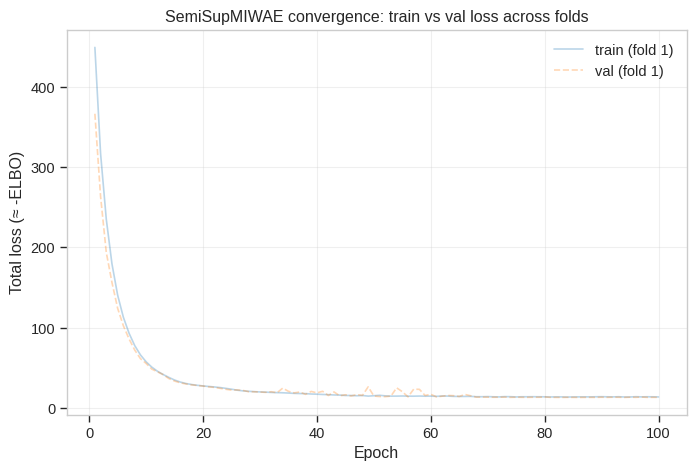

[Convergence] Epochs per fold: [100]
[Convergence] Mean epochs to convergence (approx): 100.0


In [ ]:
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 0. Mount Drive in Colab if available
# ----------------------------------------------------------
try:
    from google.colab import drive  # type: ignore
    if not os.path.ismount("/content/drive"):
        drive.mount("/content/drive", force_remount=False)
        print("[Convergence] Mounted Google Drive at /content/drive")
except Exception:
    print("[Convergence] google.colab not available; assuming local filesystem.")

# ----------------------------------------------------------
# 1. Locate latest run dir and load results_summary
# ----------------------------------------------------------
RESULTS_ROOT = "/content/drive/MyDrive/e6691_2025Spring_nyre_local/results"
RESULTS_PKL_NAME = "miwae_analysis_results.pkl"

def _latest_run_dir(results_root: str) -> str:
    subdirs = [d for d in glob.glob(os.path.join(results_root, "*")) if os.path.isdir(d)]
    if not subdirs:
        raise FileNotFoundError(f"No subdirectories under {results_root}")
    return max(subdirs, key=os.path.getmtime)

run_dir = _latest_run_dir(RESULTS_ROOT)
print(f"[Convergence] Using run dir: {run_dir}")

results_pkl_path = os.path.join(run_dir, RESULTS_PKL_NAME)
if not os.path.exists(results_pkl_path):
    raise FileNotFoundError(f"Could not find {results_pkl_path}")

with open(results_pkl_path, "rb") as f:
    results_summary = pickle.load(f)

print(f"[Convergence] Loaded results_summary with top-level keys: {list(results_summary.keys())}")

# ----------------------------------------------------------
# 1b. Extract fold_histories in a robust way
# ----------------------------------------------------------
def _extract_fold_histories(summary_dict):
    """
    Try to recover a list of history dicts from several possible layouts:
    - summary['vae_training_history']['fold_histories'] (new multi-fold)
    - summary['vae_training_history']['history'] (single history nested)
    - summary['vae_training_history'] itself (flat history dict)
    - summary['history'] at top level (e.g. direct checkpoint save_content)
    """
    fold_histories = []

    vae_hist = summary_dict.get("vae_training_history", None)

    # Case A: New format: {'vae_training_history': {'fold_histories': [history_dict, ...]}}
    if isinstance(vae_hist, dict) and isinstance(vae_hist.get("fold_histories"), list):
        fold_histories = vae_hist["fold_histories"]
        print(f"[Convergence] Found fold_histories under results_summary['vae_training_history']['fold_histories'] "
              f"(n_folds={len(fold_histories)}).")
        return fold_histories

    # Case B: Nested single history: {'vae_training_history': {'history': {...}}}
    if isinstance(vae_hist, dict) and isinstance(vae_hist.get("history"), dict):
        fold_histories = [vae_hist["history"]]
        print("[Convergence] Found single history under results_summary['vae_training_history']['history']; "
              "treating it as one fold.")
        return fold_histories

    # Case C: 'vae_training_history' itself looks like a history dict
    if isinstance(vae_hist, dict):
        has_train_val = any(
            k.startswith("train_") or k.startswith("val_")
            for k in vae_hist.keys()
        )
        if has_train_val:
            fold_histories = [vae_hist]
            print("[Convergence] results_summary['vae_training_history'] looks like a flat history dict; "
                  "treating it as one fold.")
            return fold_histories

    # Case D: Top-level 'history' (e.g. from VAETrainer.save_model)
    top_hist = summary_dict.get("history", None)
    if isinstance(top_hist, dict):
        fold_histories = [top_hist]
        print("[Convergence] Found top-level 'history' dict; treating as one fold.")
        return fold_histories

    # Nothing worked
    raise ValueError(
        "Could not locate any usable training histories. "
        f"Top-level keys: {list(summary_dict.keys())}"
    )

fold_histories = _extract_fold_histories(results_summary)

if not fold_histories:
    raise ValueError("No training histories found after attempting all layouts.")

# ----------------------------------------------------------
# 2. Plot train/val loss vs epoch
# ----------------------------------------------------------
plt.figure(figsize=(8, 5))

for i, hist in enumerate(fold_histories):
    # Try multiple possible key names, fall back gracefully
    train_key = next(
        (k for k in ["train_total_loss", "train_loss", "train_elbo"] if k in hist),
        None,
    )
    val_key = next(
        (k for k in ["val_total_loss", "val_loss", "val_elbo"] if k in hist),
        None,
    )

    if train_key is None or val_key is None:
        print(f"[Convergence] Fold {i+1}: missing train/val keys; has {list(hist.keys())}")
        continue

    train_losses = np.array(hist[train_key], dtype=float)
    val_losses = np.array(hist[val_key], dtype=float)
    epochs = np.arange(1, len(train_losses) + 1)

    plt.plot(
        epochs,
        train_losses,
        alpha=0.3,
        label="train (fold 1)" if i == 0 else None,
    )
    plt.plot(
        epochs,
        val_losses,
        alpha=0.3,
        linestyle="--",
        label="val (fold 1)" if i == 0 else None,
    )

plt.xlabel("Epoch")
plt.ylabel("Total loss (≈ -ELBO)")
plt.title("SemiSupMIWAE convergence: train vs val loss across folds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ----------------------------------------------------------
# 3. Optional summary of epochs per fold
# ----------------------------------------------------------
epochs_per_fold = []
for hist in fold_histories:
    train_key = next(
        (k for k in ["train_total_loss", "train_loss", "train_elbo"] if k in hist),
        None,
    )
    if train_key is not None and isinstance(hist[train_key], (list, tuple)):
        epochs_per_fold.append(len(hist[train_key]))

if epochs_per_fold:
    print(f"[Convergence] Epochs per fold: {epochs_per_fold}")
    print(f"[Convergence] Mean epochs to convergence (approx): {np.mean(epochs_per_fold):.1f}")
else:
    print("[Convergence] Could not compute epochs_per_fold (no usable train_* series).")


[Eval] Using latest run dir: /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16
INFO:MIWAE_Eval:[Eval] Using latest run dir: /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Eval] Using device: cuda
[Eval] RUN_DIR = /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16
[Eval] RESULTS_HISTORY_PKL: /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16/miwae_analysis_results.pkl
[Eval] PRED_PARQUET_PATH:   /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16/final_data_with_miwae_predictions.parquet
[Eval] PRED_CSV_PATH:       /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16/final_data_with_miwae_predictions.csv
[Eval] BEST_MODEL_PATH:   /content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16/vae_results/best_model.pth
[Eval] Loaded results_summary from pickle.


2025-11-23 03:23:30,456 - __main__.prepare_vae_input - INFO - Preparing data and masks for VAE. Input features: 44, Target column: log_sale_price, Scaler type for X: standard
2025-11-23 03:23:30,456 - __main__.prepare_vae_input - INFO - Preparing data and masks for VAE. Input features: 44, Target column: log_sale_price, Scaler type for X: standard
INFO:__main__.prepare_vae_input:Preparing data and masks for VAE. Input features: 44, Target column: log_sale_price, Scaler type for X: standard
2025-11-23 03:23:30,511 - __main__.prepare_vae_input - INFO - X data shape: (122712, 43). X mask shape: (122712, 43). Number of missing values in X: 0 (0.00%).
2025-11-23 03:23:30,511 - __main__.prepare_vae_input - INFO - X data shape: (122712, 43). X mask shape: (122712, 43). Number of missing values in X: 0 (0.00%).
INFO:__main__.prepare_vae_input:X data shape: (122712, 43). X mask shape: (122712, 43). Number of missing values in X: 0 (0.00%).
2025-11-23 03:23:30,513 - __main__.prepare_vae_input - 

[Eval] Loaded predictions from Parquet. Shape: (122712, 150)


2025-11-23 03:23:30,628 - __main__.prepare_vae_input - INFO - Y target ('log_sale_price') data shape: (122712, 1). Y mask shape: (122712, 1). Number of missing values in Y: 30678 (25.00%).
2025-11-23 03:23:30,628 - __main__.prepare_vae_input - INFO - Y target ('log_sale_price') data shape: (122712, 1). Y mask shape: (122712, 1). Number of missing values in Y: 30678 (25.00%).
INFO:__main__.prepare_vae_input:Y target ('log_sale_price') data shape: (122712, 1). Y mask shape: (122712, 1). Number of missing values in Y: 30678 (25.00%).
2025-11-23 03:23:30,630 - __main__.prepare_vae_input - INFO - VAE input preparation complete. Shapes: X_filled: (122712, 43), X_mask: (122712, 43), Y_filled: (122712, 1), Y_mask: (122712, 1)
2025-11-23 03:23:30,630 - __main__.prepare_vae_input - INFO - VAE input preparation complete. Shapes: X_filled: (122712, 43), X_mask: (122712, 43), Y_filled: (122712, 1), Y_mask: (122712, 1)
INFO:__main__.prepare_vae_input:VAE input preparation complete. Shapes: X_filled:

[Eval] VAE input shapes: X=(122712, 43), Y=(122712, 1)
[Eval] Loaded model_state_dict into VAE model from best_model.pth

[Eval] cv_* columns not found; falling back to direct predictions from best_model on a random hold-out split.
[Eval] Evaluating on random hold-out: 18407 / 92034 observed rows.

=== Posterior Predictive Metrics (best_model, random hold-out) ===
Average log posterior predictive (log p(y_log | x)): -1.1483
Average NLL (log-price space):                     1.1483
RMSE (log-price):                                  1.8419
MAE  (log-price):                                  0.9667
RMSE (price):                                      24,551,264.3100
MAE  (price):                                      2,184,720.6044
MAPE (price, y_true > 0):                          169,590.75%
Median |y - ŷ| (log):                              0.2309
95th pct |y - ŷ| (log):                            4.0910
[Eval] results_summary['vae_training_history'] looks like a flat history dict; treatin

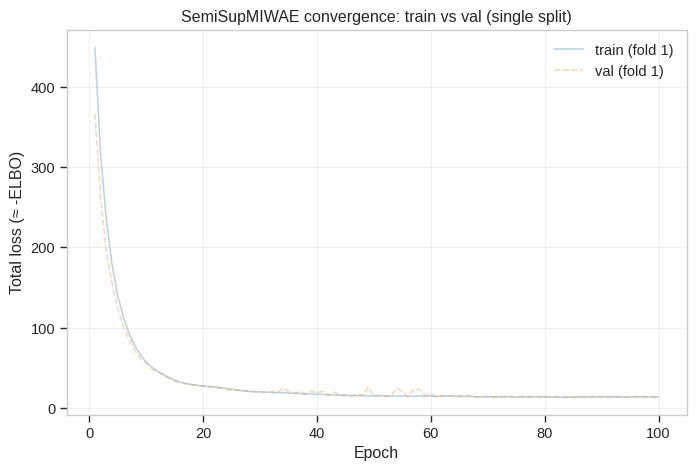

[Eval] Epochs per fold (train history length): [100]
[Eval] Mean epochs to convergence (approx):    100.0

[Eval] Generating residual diagnostics in log-price space.


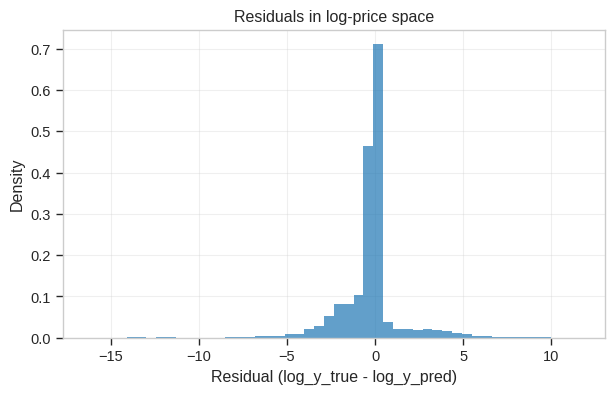

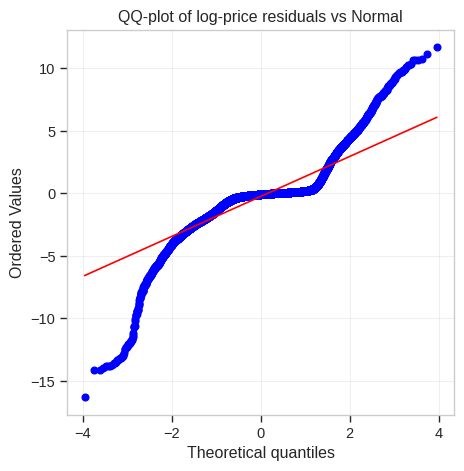


[Eval] Generating latent space visualizations.


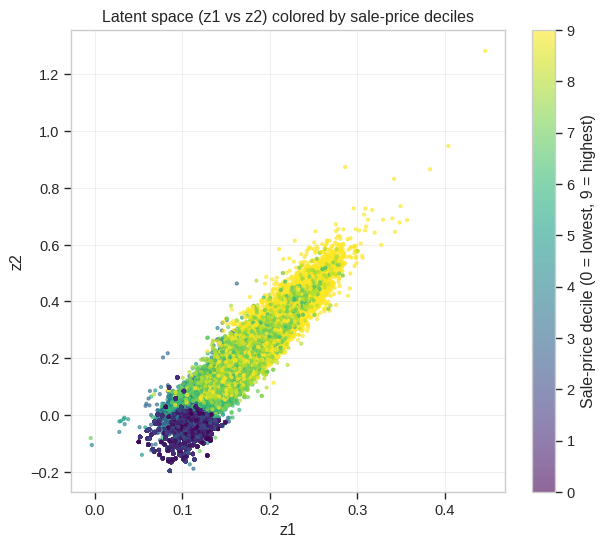

[Eval] Using 'bldgclass' as building class column for latent viz.


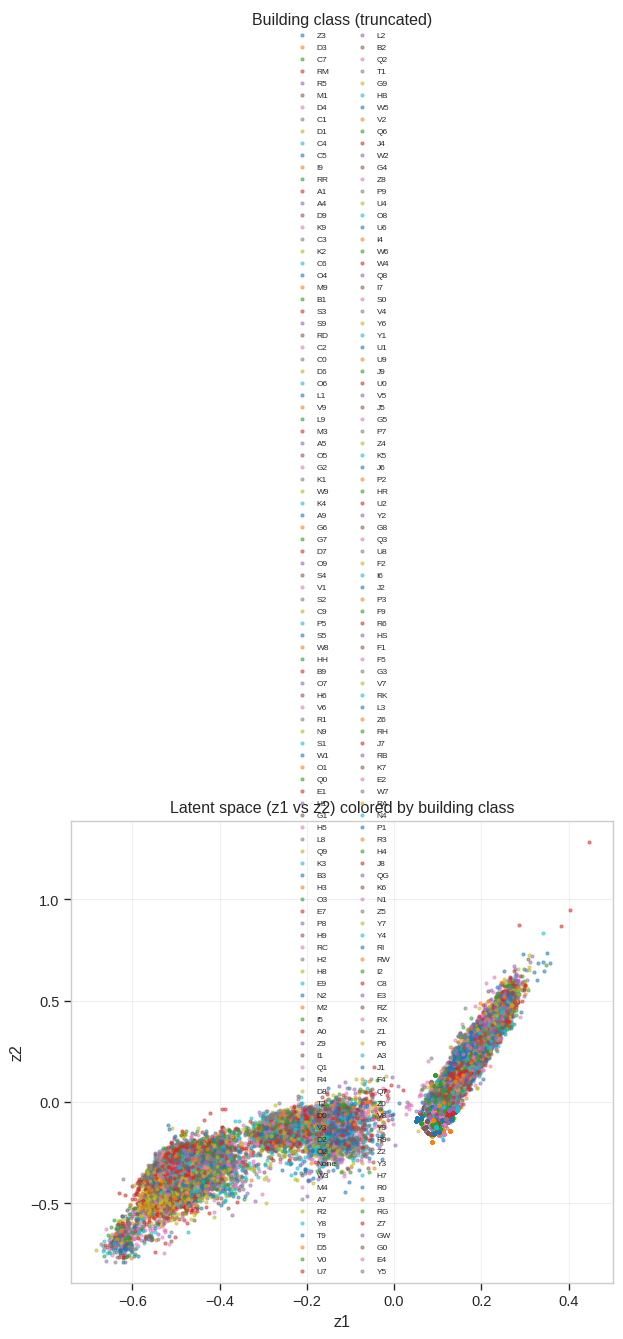

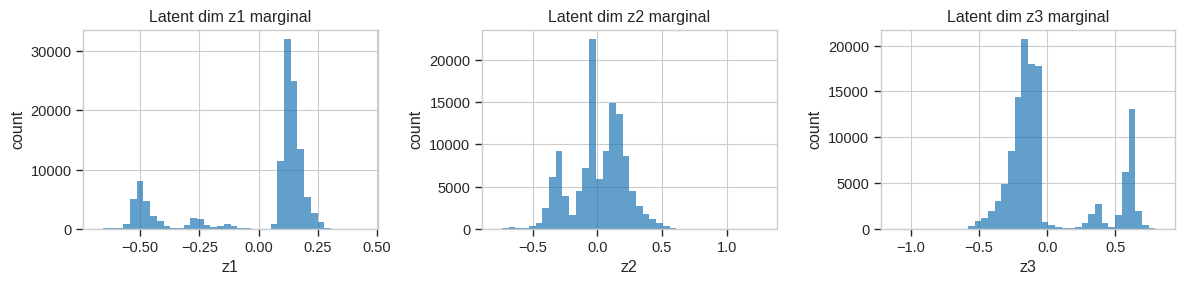

[Eval] Latent visualizations generated (convergence, residuals, z-scatter, marginals).


In [ ]:
# === POST-TRAINING EVAL + VIZ (robust to missing cv_* columns) ===

import os, glob, math, logging, pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # only used in summary artifacts

# Optional: for QQ-plot; we guard against missing scipy.
try:
    from scipy import stats
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False
    print("[Eval] WARNING: scipy not available; QQ-plot will be skipped.")

# ----------------------------------------------------------
# 0. Mount Drive (Colab) and basic setup
# ----------------------------------------------------------
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=False)
except Exception:
    pass

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Eval] Using device: {DEVICE}")

logger = logging.getLogger("MIWAE_Eval")
logger.setLevel(logging.INFO)
if not logger.handlers:
    logger.addHandler(logging.StreamHandler())

# ----------------------------------------------------------
# 1. Paths (aligned with your AlphaScan cell)
# ----------------------------------------------------------
RESULTS_ROOT = "/content/drive/MyDrive/e6691_2025Spring_nyre_local/results"
FALLBACK_RUN_DIR = "/content/drive/MyDrive/e6691_2025Spring_nyre_local/results/2025-10-12_01-58-16"

RESULTS_PKL_NAME = "miwae_analysis_results.pkl"
PRED_PARQUET_NAME = "final_data_with_miwae_predictions.parquet"
PRED_CSV_NAME = "final_data_with_miwae_predictions.csv"

def _latest_run_dir(results_root: str, fallback: str = None) -> str:
    subdirs = [d for d in glob.glob(os.path.join(results_root, "*")) if os.path.isdir(d)]
    if not subdirs:
        if fallback is None:
            raise FileNotFoundError(f"No subdirectories under {results_root}")
        logger.info(f"[Eval] No subdirs under {results_root}, using fallback {fallback}")
        return fallback
    latest = max(subdirs, key=os.path.getmtime)
    logger.info(f"[Eval] Using latest run dir: {latest}")
    return latest

run_dir = _latest_run_dir(RESULTS_ROOT, fallback=FALLBACK_RUN_DIR)
print(f"[Eval] RUN_DIR = {run_dir}")

RESULTS_HISTORY_PKL = os.path.join(run_dir, RESULTS_PKL_NAME)
PRED_PARQUET_PATH   = os.path.join(run_dir, PRED_PARQUET_NAME)
PRED_CSV_PATH       = os.path.join(run_dir, PRED_CSV_NAME)

print(f"[Eval] RESULTS_HISTORY_PKL: {RESULTS_HISTORY_PKL}")
print(f"[Eval] PRED_PARQUET_PATH:   {PRED_PARQUET_PATH}")
print(f"[Eval] PRED_CSV_PATH:       {PRED_CSV_PATH}")

best_model_candidates = glob.glob(os.path.join(run_dir, "**", "best_model.pth"), recursive=True)
if best_model_candidates:
    BEST_MODEL_PATH = best_model_candidates[0]
    print(f"[Eval] BEST_MODEL_PATH:   {BEST_MODEL_PATH}")
else:
    BEST_MODEL_PATH = None
    print("[Eval] WARNING: No best_model.pth found; metrics will skip model-based fallback.")

# ----------------------------------------------------------
# 2. Load results_summary and predictions DataFrame
# ----------------------------------------------------------
if not os.path.exists(RESULTS_HISTORY_PKL):
    raise FileNotFoundError(f"[Eval] Could not find {RESULTS_HISTORY_PKL}")

with open(RESULTS_HISTORY_PKL, "rb") as f:
    results_summary = pickle.load(f)
print("[Eval] Loaded results_summary from pickle.")

if os.path.exists(PRED_PARQUET_PATH):
    df_pred = pd.read_parquet(PRED_PARQUET_PATH)
    print(f"[Eval] Loaded predictions from Parquet. Shape: {df_pred.shape}")
elif os.path.exists(PRED_CSV_PATH):
    df_pred = pd.read_csv(PRED_CSV_PATH)
    print(f"[Eval] Loaded predictions from CSV. Shape: {df_pred.shape}")
else:
    raise FileNotFoundError(
        f"[Eval] Neither {PRED_PARQUET_PATH} nor {PRED_CSV_PATH} exists."
    )

config = results_summary.get("config_summary", {})
price_col = config.get("PRICE_COL", "sale_price")
log_y_col = results_summary.get("vae_target_y_column", None)

if log_y_col is None:
    raise ValueError("[Eval] 'vae_target_y_column' is None in results_summary – cannot evaluate.")
if log_y_col not in df_pred.columns:
    raise KeyError(f"[Eval] Target column '{log_y_col}' not found in df_pred.")

# ----------------------------------------------------------
# 3. Build VAE inputs and load model/trainer
#     (used for both fallback metrics and latent viz)
# ----------------------------------------------------------
vae_x_cols = results_summary.get("vae_actual_x_features_used", [])
if not vae_x_cols:
    raise ValueError("[Eval] 'vae_actual_x_features_used' is empty – cannot rebuild VAE inputs.")

feature_columns_for_vae = list(dict.fromkeys(vae_x_cols + [log_y_col]))
missing_feats = [c for c in feature_columns_for_vae if c not in df_pred.columns]
if missing_feats:
    print(f"[Eval] WARNING: some VAE feature columns missing in df_pred: {missing_feats}")

(X_filled_np, X_mask_np,
 y_filled_np, y_mask_np,
 feature_names_x_out, _, _) = prepare_vae_input(
    df=df_pred.copy(),
    feature_columns=feature_columns_for_vae,
    target_col=log_y_col,
    scaler_type="standard"
)

print(f"[Eval] VAE input shapes: X={X_filled_np.shape}, Y={y_filled_np.shape}")

artifacts_summary = results_summary.get("orchestrator_artifacts_summary", {})
latent_dim_suggestion = artifacts_summary.get("latent_dim_suggestion", 3)
latent_dim_override = max(3, int(latent_dim_suggestion))

vae_model = create_vae_from_artifacts(
    artifacts=artifacts_summary,
    feature_order=feature_names_x_out + [log_y_col],
    target_col_name=log_y_col,
    alpha_price_loss=config.get("VAE_ALPHA_PRICE_LOSS", 10.0),
    latent_dim_override=latent_dim_override,
    device=DEVICE
)

if BEST_MODEL_PATH is not None and os.path.exists(BEST_MODEL_PATH):
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    vae_model.load_state_dict(state_dict)
    print("[Eval] Loaded model_state_dict into VAE model from best_model.pth")
else:
    print("[Eval] WARNING: Using fresh-initialized MIWAE weights (no best_model.pth found).")

vae_trainer = VAETrainer(
    model=vae_model,
    learning_rate=config.get("VAE_LEARNING_RATE", 3e-4),
    device=DEVICE,
    verbose=False,
    reconstruction_loss_type_x=config.get("VAE_RECON_LOSS_X", "mse"),
    price_loss_type_y=config.get("VAE_PRICE_LOSS_Y", "gaussian_nll"),
    alpha_price_loss=config.get("VAE_ALPHA_PRICE_LOSS", 10.0),
    kld_weight=1.0,
)

# ----------------------------------------------------------
# 4. Posterior predictive metrics
#     (use cv_* columns if present; otherwise fallback to best_model)
#     + store residuals for diagnostics
# ----------------------------------------------------------
pred_price_col_cv = f"cv_predicted_{price_col}"
pred_std_col_cv   = f"cv_pred_uncertainty_{log_y_col}_std"
pred_flag_col_cv  = "cv_prediction_available"

have_cv = all(c in df_pred.columns for c in [pred_price_col_cv, pred_std_col_cv, pred_flag_col_cv])

# For later residual diagnostics (log space)
y_true_log_eval = None
mu_log_eval = None

def _report_metrics(y_true_log, y_true, mu_log, var_log, label_prefix=""):
    var_log = np.clip(var_log, 1e-9, np.inf)

    # Gaussian log-likelihood in log-price space
    log_pp = -0.5 * (np.log(2 * math.pi * var_log) + ((y_true_log - mu_log) ** 2) / var_log)
    avg_log_pp = float(np.mean(log_pp))
    avg_nll_log = -avg_log_pp

    # basic errors in log space
    resid_log = y_true_log - mu_log
    mse_log = float(np.mean(resid_log ** 2))
    rmse_log = math.sqrt(mse_log)
    mae_log = float(np.mean(np.abs(resid_log)))

    # robust log-space metrics for the writeup
    abs_resid_log = np.abs(resid_log)
    median_abs_log = float(np.median(abs_resid_log))
    p95_abs_log    = float(np.percentile(abs_resid_log, 95))

    # errors in level space
    mse_price = float(np.mean((y_true - np.exp(mu_log)) ** 2))
    rmse_price = math.sqrt(mse_price)
    mae_price = float(np.mean(np.abs(y_true - np.exp(mu_log))))

    positive_mask = y_true > 0
    if positive_mask.sum() > 0:
        mape_price = float(
            np.mean(
                np.abs(
                    (y_true[positive_mask] - np.exp(mu_log[positive_mask]))
                    / y_true[positive_mask]
                )
            )
        )
    else:
        mape_price = float("nan")

    tag = f" ({label_prefix})" if label_prefix else ""
    print(f"\n=== Posterior Predictive Metrics{tag} ===")
    print(f"Average log posterior predictive (log p(y_log | x)): {avg_log_pp:.4f}")
    print(f"Average NLL (log-price space):                     {avg_nll_log:.4f}")
    print(f"RMSE (log-price):                                  {rmse_log:.4f}")
    print(f"MAE  (log-price):                                  {mae_log:.4f}")
    print(f"RMSE (price):                                      {rmse_price:,.4f}")
    print(f"MAE  (price):                                      {mae_price:,.4f}")
    print(f"MAPE (price, y_true > 0):                          {mape_price * 100:,.2f}%")
    print(f"Median |y - ŷ| (log):                              {median_abs_log:.4f}")
    print(f"95th pct |y - ŷ| (log):                            {p95_abs_log:.4f}")

if have_cv:
    print("\n[Eval] Found cv_* prediction columns; using CV-stitched predictions for held-out metrics.")
    mask_pred = df_pred[pred_flag_col_cv].astype(bool).values
    df_eval = df_pred.loc[mask_pred].copy()
    print(f"[Eval] Rows with CV predictions: {df_eval.shape[0]} / {df_pred.shape[0]}")

    y_true_log = df_eval[log_y_col].astype(float).values
    y_true     = df_eval[price_col].astype(float).values
    y_pred     = df_eval[pred_price_col_cv].astype(float).values
    sigma_log  = df_eval[pred_std_col_cv].astype(float).values

    mu_log = np.log(np.clip(y_pred, 1e-12, np.inf))
    var_log = np.square(sigma_log)

    _report_metrics(y_true_log, y_true, mu_log, var_log, label_prefix="CV stitched")

    # store for residual diagnostics
    y_true_log_eval = y_true_log
    mu_log_eval = mu_log

    # optional metrics on "uncertainty OK" subset
    unc_ok_col = "prediction_uncertainty_ok"
    if unc_ok_col in df_eval.columns:
        mask_unc_ok = df_eval[unc_ok_col].astype(bool).values
        if mask_unc_ok.sum() > 0:
            print(f"\n[Eval] Metrics on subset with {unc_ok_col} == True")
            y_true_log_ok = y_true_log[mask_unc_ok]
            y_true_ok     = y_true[mask_unc_ok]
            mu_log_ok     = mu_log[mask_unc_ok]
            var_log_ok    = var_log[mask_unc_ok]
            _report_metrics(y_true_log_ok, y_true_ok, mu_log_ok, var_log_ok,
                            label_prefix="CV stitched, unc_ok")

else:
    print("\n[Eval] cv_* columns not found; falling back to direct predictions from best_model on a random hold-out split.")
    if BEST_MODEL_PATH is None:
        raise RuntimeError("[Eval] No cv_* columns and no best_model.pth; cannot compute predictive metrics.")

    # mask for rows where the target is observed
    y_mask = y_mask_np.squeeze()
    obs_idx = np.where(y_mask > 0.0)[0]
    if obs_idx.size == 0:
        raise RuntimeError("[Eval] No observed targets according to VAE mask; cannot evaluate.")

    y_true_log_all = df_pred[log_y_col].astype(float).to_numpy()[obs_idx]
    y_true_all     = df_pred[price_col].astype(float).to_numpy()[obs_idx]
    X_obs = X_filled_np[obs_idx]

    N_obs = X_obs.shape[0]
    rng = np.random.default_rng(42)
    perm = rng.permutation(N_obs)
    split = int(0.8 * N_obs)
    test_rel_idx = perm[split:]
    X_test = X_obs[test_rel_idx]
    y_true_log = y_true_log_all[test_rel_idx]
    y_true     = y_true_all[test_rel_idx]

    X_test_tensor = torch.from_numpy(X_test).float().to(DEVICE)
    log_mu, log_var = vae_trainer.predict_price_and_uncertainty(X_test_tensor, batch_size=1024)
    log_mu = np.asarray(log_mu).reshape(-1)
    log_var = np.asarray(log_var).reshape(-1)
    var_log = np.exp(log_var)

    print(f"[Eval] Evaluating on random hold-out: {len(test_rel_idx)} / {N_obs} observed rows.")
    _report_metrics(y_true_log, y_true, log_mu, var_log, label_prefix="best_model, random hold-out")

    # store for residual diagnostics
    y_true_log_eval = y_true_log
    mu_log_eval = log_mu

# ----------------------------------------------------------
# 5. Convergence diagnostics (train/val loss vs epoch)
#     (robust to different layouts)
# ----------------------------------------------------------
def _extract_fold_histories(summary_dict):
    """
    Try to recover a list of history dicts from several possible layouts:
    - summary['vae_training_history']['fold_histories'] (multi-fold)
    - summary['vae_training_history']['history'] (single history nested)
    - summary['vae_training_history'] itself (flat history dict)
    - summary['history'] at top level (e.g. direct VAETrainer.save_model)
    """
    fold_histories_local = []

    vae_hist = summary_dict.get("vae_training_history", None)

    # Case A: multi-fold
    if isinstance(vae_hist, dict) and isinstance(vae_hist.get("fold_histories"), list):
        fold_histories_local = vae_hist["fold_histories"]
        print(f"[Eval] Found fold_histories under results_summary['vae_training_history']['fold_histories'] "
              f"(n_folds={len(fold_histories_local)}).")
        return fold_histories_local

    # Case B: nested single
    if isinstance(vae_hist, dict) and isinstance(vae_hist.get("history"), dict):
        fold_histories_local = [vae_hist["history"]]
        print("[Eval] Found single history under results_summary['vae_training_history']['history']; "
              "treating it as one fold.")
        return fold_histories_local

    # Case C: flat dict with train_/val_ keys
    if isinstance(vae_hist, dict):
        has_train_val = any(
            k.startswith("train_") or k.startswith("val_")
            for k in vae_hist.keys()
        )
        if has_train_val:
            fold_histories_local = [vae_hist]
            print("[Eval] results_summary['vae_training_history'] looks like a flat history dict; "
                  "treating it as one fold.")
            return fold_histories_local

    # Case D: top-level history
    top_hist = summary_dict.get("history", None)
    if isinstance(top_hist, dict):
        fold_histories_local = [top_hist]
        print("[Eval] Found top-level 'history' dict; treating as one fold.")
        return fold_histories_local

    return []  # nothing found

fold_histories = _extract_fold_histories(results_summary)

if not fold_histories:
    print("\n[Eval] No usable training histories found; skipping convergence plots.")
else:
    n_folds = len(fold_histories)
    print(f"\n[Eval] Plotting convergence diagnostics (train/val loss vs epoch, n_folds={n_folds}).")

    plt.figure(figsize=(8, 5))
    for i, hist in enumerate(fold_histories):
        train_key = next((k for k in ["train_total_loss", "train_loss", "train_elbo"] if k in hist), None)
        val_key   = next((k for k in ["val_total_loss", "val_loss", "val_elbo"] if k in hist), None)
        if train_key is None or val_key is None:
            print(f"[Eval] Fold {i+1}: missing train/val loss keys; keys: {list(hist.keys())}")
            continue

        train_losses = np.array(hist[train_key], dtype=float)
        val_losses   = np.array(hist[val_key], dtype=float)
        epochs = np.arange(1, len(train_losses) + 1)

        plt.plot(
            epochs,
            train_losses,
            alpha=0.3,
            label="train (fold 1)" if i == 0 else None,
        )
        plt.plot(
            epochs,
            val_losses,
            alpha=0.3,
            linestyle="--",
            label="val (fold 1)" if i == 0 else None,
        )

    plt.xlabel("Epoch")
    plt.ylabel("Total loss (≈ -ELBO)")
    if n_folds > 1:
        plt.title(f"SemiSupMIWAE convergence: train vs val ({n_folds}-fold CV)")
    else:
        plt.title("SemiSupMIWAE convergence: train vs val (single split)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    epochs_per_fold = []
    for hist in fold_histories:
        train_key = next((k for k in ["train_total_loss", "train_loss", "train_elbo"] if k in hist), None)
        if train_key is not None and isinstance(hist[train_key], (list, tuple)):
            epochs_per_fold.append(len(hist[train_key]))
    if epochs_per_fold:
        print(f"[Eval] Epochs per fold (train history length): {epochs_per_fold}")
        print(f"[Eval] Mean epochs to convergence (approx):    {np.mean(epochs_per_fold):.1f}")

# ----------------------------------------------------------
# 6. Residual diagnostics in log-price space
#     (histogram + QQ-plot vs Normal)
# ----------------------------------------------------------
if y_true_log_eval is not None and mu_log_eval is not None:
    print("\n[Eval] Generating residual diagnostics in log-price space.")

    resid_log = y_true_log_eval - mu_log_eval  # true - predicted (log space)

    # Histogram
    plt.figure(figsize=(7, 4))
    plt.hist(resid_log, bins=50, density=True, alpha=0.7)
    plt.xlabel("Residual (log_y_true - log_y_pred)")
    plt.ylabel("Density")
    plt.title("Residuals in log-price space")
    plt.grid(True, alpha=0.3)
    plt.show()

    # QQ-plot vs Normal
    if HAVE_SCIPY:
        plt.figure(figsize=(5, 5))
        stats.probplot(resid_log, dist="norm", plot=plt)
        plt.title("QQ-plot of log-price residuals vs Normal")
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("[Eval] Skipping QQ-plot (scipy not available).")
else:
    print("\n[Eval] No stored residuals; skipping residual diagnostics.")

# ----------------------------------------------------------
# 7. Latent-space visualization
#     - z1–z2 scatter colored by sale-price deciles
#     - z1–z2 scatter colored by building class (if available)
#     - marginal histograms of first 3 dims
# ----------------------------------------------------------
print("\n[Eval] Generating latent space visualizations.")

# get_latent_representation in VAETrainer expects a NumPy array on CPU,
# not a torch CUDA tensor.
X_all_np = X_filled_np.astype(np.float32, copy=False)

try:
    mu_z, logvar_z = vae_trainer.get_latent_representation(
        X_all_np,
        batch_size=1024,
    )
    mu_z = np.asarray(mu_z)
except AttributeError:
    raise AttributeError(
        "[Eval] VAETrainer is missing 'get_latent_representation'. "
        "Add such a method or expose model.encode() to extract latent means."
    )

if mu_z.ndim != 2 or mu_z.shape[1] < 2:
    raise ValueError(
        f"[Eval] Latent representation has shape {mu_z.shape}; "
        "need at least 2 dims for scatter."
    )

# --- 7a. z1–z2 colored by sale-price deciles (Figure 4) ---
log_price_all = df_pred[log_y_col].astype(float).values
mask_finite_price = np.isfinite(log_price_all)
if mask_finite_price.sum() > 0:
    # Compute decile edges on finite values
    decile_edges = np.quantile(log_price_all[mask_finite_price], np.linspace(0, 1, 11))
    # Map each point to a decile index 0–9; NaNs get -1
    decile_idx = np.full_like(log_price_all, fill_value=-1, dtype=int)
    decile_idx[mask_finite_price] = np.searchsorted(decile_edges[1:-1],
                                                    log_price_all[mask_finite_price],
                                                    side="right")

    valid_mask = decile_idx >= 0
    plt.figure(figsize=(7, 6))
    sc = plt.scatter(
        mu_z[valid_mask, 0],
        mu_z[valid_mask, 1],
        c=decile_idx[valid_mask],
        s=5,
        alpha=0.6,
        cmap="viridis",
    )
    cbar = plt.colorbar(sc)
    cbar.set_label("Sale-price decile (0 = lowest, 9 = highest)")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.title("Latent space (z1 vs z2) colored by sale-price deciles")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("[Eval] No finite log-price values; skipping decile-colored latent scatter.")

# --- 7b. z1–z2 colored by building class (Figure 5) ---
bldg_class_candidates = [
    "bldg_class", "building_class", "bldg_class_group", "bldgclass"
]
bldg_class_col = next((c for c in bldg_class_candidates if c in df_pred.columns), None)

if bldg_class_col is not None:
    print(f"[Eval] Using '{bldg_class_col}' as building class column for latent viz.")
    bldg_series = df_pred[bldg_class_col].astype(str)
    codes, uniques = pd.factorize(bldg_series)

    plt.figure(figsize=(7, 6))
    # If many classes, this may be busy, but it matches the "colored by building class" idea.
    for code, label in enumerate(uniques):
        mask = codes == code
        if not np.any(mask):
            continue
        plt.scatter(
            mu_z[mask, 0],
            mu_z[mask, 1],
            s=5,
            alpha=0.5,
            label=label,
        )
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.title("Latent space (z1 vs z2) colored by building class")
    plt.grid(True, alpha=0.3)
    # Limit legend size if many classes
    n_classes = len(uniques)
    if n_classes <= 10:
        plt.legend(title="Building class", fontsize=8)
    else:
        plt.legend(title="Building class (truncated)", fontsize=6, ncol=2)
    plt.show()
else:
    print("[Eval] No building-class column found; skipping building-class latent scatter.")

# --- 7c. Marginal histograms of first 3 latent dimensions ---
num_latent_dims = mu_z.shape[1]
plt.figure(figsize=(12, 3))
for d in range(min(num_latent_dims, 3)):
    plt.subplot(1, min(num_latent_dims, 3), d + 1)
    plt.hist(mu_z[:, d], bins=40, alpha=0.7)
    plt.xlabel(f"z{d+1}")
    plt.ylabel("count")
    plt.title(f"Latent dim z{d+1} marginal")
plt.tight_layout()
plt.show()

print("[Eval] Latent visualizations generated (convergence, residuals, z-scatter, marginals).")


In [ ]:
import numpy as np
import torch
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score

TARGET_COL = "log_sale_price"  # Target is log-price

# ---------------------------------------------------------
# 0. Helper: call SemiSupMIWAE.predict_price (or forward)
# ---------------------------------------------------------

def get_y_log_pred_from_model(X_obs_np, batch_size=1024):
    """
    Run the trained SemiSupMIWAE on X_obs_np and return the
    predictive mean for log_sale_price as a 1D numpy array.

    Uses model.predict_price(x) if available; otherwise falls
    back to model(x) and assumes it returns:
        (recon_x, mu, logvar, y_pred_mu, y_pred_logvar).
    """
    model = vae_trainer.model
    model.eval()

    preds = []

    with torch.no_grad():
        for start in range(0, X_obs_np.shape[0], batch_size):
            xb_np = X_obs_np[start:start + batch_size]
            xb = torch.from_numpy(xb_np).float().to(DEVICE)

            # Preferred path: explicit predictor
            if hasattr(model, "predict_price"):
                y_mu_batch, y_logvar_batch = model.predict_price(xb)
            else:
                # Fallback: use forward tuple
                out = model(xb)
                # Expect: (recon_x, mu_z, logvar_z, y_pred_mu, y_pred_logvar)
                if not isinstance(out, (tuple, list)) or len(out) < 4:
                    raise RuntimeError(
                        "Model forward did not return a 4/5-tuple as expected. "
                        "Please adapt get_y_log_pred_from_model to your model."
                    )
                y_mu_batch = out[3]  # index 3 = y_pred_mu

            preds.append(y_mu_batch.detach().cpu().numpy().reshape(-1))

    return np.concatenate(preds, axis=0)


# ---------------------------------------------------------
# 1. Build observed subset from df_pred and X_filled_np
# ---------------------------------------------------------

if "df_pred" not in globals():
    raise NameError(
        "df_pred not found. Make sure you loaded "
        "final_data_with_miwae_predictions.parquet into df_pred."
    )

if "X_filled_np" not in globals():
    raise NameError(
        "X_filled_np not found. Make sure you ran the eval cell that "
        "calls prepare_vae_input and assigns its first output to X_filled_np."
    )

mask_obs = df_pred[TARGET_COL].notna().values
X_all     = X_filled_np
y_log_all = df_pred[TARGET_COL].to_numpy(dtype=float)

X_obs     = X_all[mask_obs]
y_log_obs = y_log_all[mask_obs]

print(f"[Diag] Observed rows for residual analysis: {X_obs.shape[0]}")

# ---------------------------------------------------------
# 2. Get MIWAE predictions on observed rows and compute residuals
# ---------------------------------------------------------

print("[Diag] Getting MIWAE predictions for observed rows...")
y_log_pred_obs = get_y_log_pred_from_model(X_obs, batch_size=1024)

y_log_true_obs = y_log_obs.astype(float).reshape(-1)
resid_log      = y_log_true_obs - y_log_pred_obs

print(f"[Diag] Residuals (log-price): mean={resid_log.mean():.4f}, std={resid_log.std():.4f}")

# ---------------------------------------------------------
# 3. Residual structure vs original X
# ---------------------------------------------------------

gbr_resid_x = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=3,
    learning_rate=0.05,
    max_iter=200,
    random_state=0,
)

n   = X_obs.shape[0]
rng = np.random.RandomState(0)
idx = rng.permutation(n)
split = int(0.8 * n)
idx_train, idx_test = idx[:split], idx[split:]

X_resid_train, X_resid_test = X_obs[idx_train], X_obs[idx_test]
r_train, r_test             = resid_log[idx_train], resid_log[idx_test]

print("[Diag] Fitting Residual->X regressor...")
gbr_resid_x.fit(X_resid_train, r_train)
r_pred_test_x = gbr_resid_x.predict(X_resid_test)

r2_x = r2_score(r_test, r_pred_test_x)
print(f"\n[Diag] R^2(residual | X) on held-out: {r2_x:.4f}")

# # ---------------------------------------------------------
# 4. Residual structure vs latent codes z (mu_z)
# ---------------------------------------------------------

print("[Diag] Computing latent codes for observed rows...")

# get_latent_representation expects a *numpy* array, not a torch tensor
mu_z, logvar_z = vae_trainer.get_latent_representation(
    X_obs.astype(np.float32), batch_size=1024
)

# Ensure we have a numpy array for downstream sklearn
if isinstance(mu_z, torch.Tensor):
    mu_z = mu_z.cpu().numpy()
else:
    mu_z = np.asarray(mu_z, dtype=float)

print(f"[Diag] Latent mu_z shape: {mu_z.shape}")

gbr_resid_z = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=3,
    learning_rate=0.05,
    max_iter=200,
    random_state=1,
)

Z_train, Z_test = mu_z[idx_train], mu_z[idx_test]

print("[Diag] Fitting Residual->z regressor...")
gbr_resid_z.fit(Z_train, r_train)
r_pred_test_z = gbr_resid_z.predict(Z_test)

r2_z = r2_score(r_test, r_pred_test_z)
print(f"\n[Diag] R^2(residual | z_mu) on held-out: {r2_z:.4f}")

print(
    "\n[Diag Summary]\n"
    f"  R^2(residual | X)    = {r2_x:.4f}\n"
    f"  R^2(residual | z_mu) = {r2_z:.4f}\n\n"
    "Interpretation:\n"
    "  - If both are near 0, residuals look close to white noise given the inputs, and the\n"
    "    MIWAE is likely close to the noise floor for this feature set.\n"
    "  - If R^2(residual | X) is noticeably > 0, there is still signal in the raw features\n"
    "    that the MIWAE has not exploited (representation or capacity limit).\n"
    "  - If R^2(residual | z_mu) is noticeably > 0, the latent representation has unused\n"
    "    predictive structure that the price head / likelihood is leaving on the table."
)


[Diag] Observed rows for residual analysis: 92034
[Diag] Getting MIWAE predictions for observed rows...
[Diag] Residuals (log-price): mean=-0.2633, std=1.8151
[Diag] Fitting Residual->X regressor...

[Diag] R^2(residual | X) on held-out: 0.4972
[Diag] Computing latent codes for observed rows...
[Diag] Latent mu_z shape: (92034, 3)
[Diag] Fitting Residual->z regressor...

[Diag] R^2(residual | z_mu) on held-out: 0.2729

[Diag Summary]
  R^2(residual | X)    = 0.4972
  R^2(residual | z_mu) = 0.2729

Interpretation:
  - If both are near 0, residuals look close to white noise given the inputs, and the
    MIWAE is likely close to the noise floor for this feature set.
  - If R^2(residual | X) is noticeably > 0, there is still signal in the raw features
    that the MIWAE has not exploited (representation or capacity limit).
  - If R^2(residual | z_mu) is noticeably > 0, the latent representation has unused
    predictive structure that the price head / likelihood is leaving on the table.


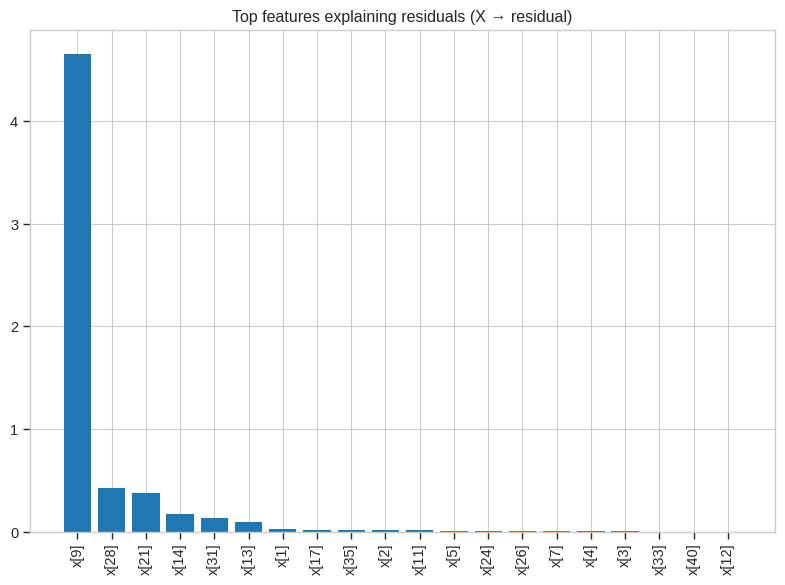

Permutation importances for residual | z_mu (test split):
  z_mu[1]: 1.4831
  z_mu[2]: 0.7673
  z_mu[0]: 0.6646


In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# Permutation importances for residual | X and residual | z
# using the held-out (test) split you already defined
# =========================================================

# Use the test split as validation
X_resid_valid = X_resid_test
Z_resid_valid = Z_test
res_valid     = r_test

# -------------------------------
# 1) Residual | X importances
# -------------------------------
r_x = permutation_importance(
    gbr_resid_x,
    X_resid_valid,   # features
    res_valid,       # residuals on held-out
    n_repeats=10,
    random_state=0,
    n_jobs=-1,
)

imp_x = r_x.importances_mean
order_x = np.argsort(imp_x)[::-1]
top_k = min(20, X_resid_valid.shape[1])

# Try to recover meaningful feature names if possible
if "FEATURE_COLS" in globals():
    feat_names_X = np.array(FEATURE_COLS)
elif "vae_input_cols" in globals():
    feat_names_X = np.array(vae_input_cols)
else:
    # Fallback: generic labels
    feat_names_X = np.array([f"x[{j}]" for j in range(X_resid_valid.shape[1])])

plt.figure(figsize=(8, 6))
plt.bar(range(top_k), imp_x[order_x][:top_k])
plt.xticks(range(top_k), feat_names_X[order_x][:top_k], rotation=90)
plt.title("Top features explaining residuals (X → residual)")
plt.tight_layout()
plt.show()

# -------------------------------
# 2) Residual | z_mu importances
# -------------------------------
r_z = permutation_importance(
    gbr_resid_z,
    Z_resid_valid,
    res_valid,
    n_repeats=10,
    random_state=0,
    n_jobs=-1,
)

imp_z = r_z.importances_mean
order_z = np.argsort(imp_z)[::-1]
feat_names_Z = np.array([f"z_mu[{j}]" for j in range(Z_resid_valid.shape[1])])

print("Permutation importances for residual | z_mu (test split):")
for j in order_z:
    print(f"  {feat_names_Z[j]}: {imp_z[j]:.4f}")


In [ ]:
import numpy as np
import torch
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Optional: SciPy for kurtosis / skew; you can comment this out if you prefer.
try:
    from scipy.stats import kurtosis, skew
    HAVE_SCIPY = True
except ImportError:
    HAVE_SCIPY = False

# --------------------------------------------------------------------
# 0. Guards / setup: assume df_pred, X_filled_np, vae_trainer exist
# --------------------------------------------------------------------
TARGET_COL = "log_sale_price"

if "df_pred" not in globals():
    raise NameError(
        "df_pred not found. Make sure you loaded "
        "final_data_with_miwae_predictions.parquet into df_pred."
    )

if "X_filled_np" not in globals():
    raise NameError(
        "X_filled_np not found. Make sure you ran the eval cell that "
        "calls prepare_vae_input and assigns its first output to X_filled_np."
    )

if "vae_trainer" not in globals():
    raise NameError("vae_trainer not found. Make sure your trainer object is in scope.")

if "DEVICE" not in globals():
    DEVICE = next(vae_trainer.model.parameters()).device

model = vae_trainer.model
model.eval()

# --------------------------------------------------------------------
# 1. Build observed subset
# --------------------------------------------------------------------
mask_obs = df_pred[TARGET_COL].notna().values
X_all = X_filled_np
y_log_all = df_pred[TARGET_COL].to_numpy(dtype=float)

X_obs = X_all[mask_obs]
y_log_obs = y_log_all[mask_obs]

print(f"[Profile+] Observed rows with true {TARGET_COL}: {X_obs.shape[0]}")

# --------------------------------------------------------------------
# 2. Latent codes mu_z for observed rows (no retraining)
# --------------------------------------------------------------------
with torch.no_grad():
    # get_latent_representation expects numpy, not tensor
    mu_z, logvar_z = vae_trainer.get_latent_representation(
        X_obs, batch_size=1024
    )

if isinstance(mu_z, torch.Tensor):
    mu_z = mu_z.cpu().numpy()
else:
    mu_z = np.asarray(mu_z, dtype=float)

print(f"[Profile+] Latent mu_z shape: {mu_z.shape}")

finite_mask = np.isfinite(y_log_obs) & np.isfinite(mu_z).all(axis=1)
X_obs = X_obs[finite_mask]
y_log_obs = y_log_obs[finite_mask]
mu_z = mu_z[finite_mask]

print(f"[Profile+] Rows after finite-filter: {X_obs.shape[0]}")

# --------------------------------------------------------------------
# 3. Get MIWAE head predictions (mean & log-variance) on observed rows
# --------------------------------------------------------------------
def predict_head_on_X(X_np, batch_size=1024):
    preds_mu = []
    preds_logvar = []

    with torch.no_grad():
        for start in range(0, X_np.shape[0], batch_size):
            xb_np = X_np[start:start + batch_size]
            xb = torch.from_numpy(xb_np).float().to(DEVICE)
            y_mu_batch, y_logvar_batch = model.predict_price(xb)
            preds_mu.append(y_mu_batch.detach().cpu().numpy().reshape(-1))
            preds_logvar.append(y_logvar_batch.detach().cpu().numpy().reshape(-1))

    return (
        np.concatenate(preds_mu, axis=0),
        np.concatenate(preds_logvar, axis=0),
    )

print("[Profile+] Getting MIWAE head predictions (y_mu, y_logvar) on observed rows...")
y_mu_obs, y_logvar_obs = predict_head_on_X(X_obs, batch_size=1024)

resid_log = y_log_obs - y_mu_obs
print(f"[Profile+] Residuals (log-price): mean={resid_log.mean():.4f}, std={resid_log.std():.4f}")

# --------------------------------------------------------------------
# 4. y|X (Tree), y|z_mu (Tree), y|z_mu (Head) with consistent split
# --------------------------------------------------------------------
rng = np.random.RandomState(0)
n = X_obs.shape[0]
idx = rng.permutation(n)
split = int(0.8 * n)
idx_train, idx_test = idx[:split], idx[split:]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def summarize_reg(label, y_true_train, y_pred_train, y_true_test, y_pred_test):
    r2_tr = r2_score(y_true_train, y_pred_train)
    r2_te = r2_score(y_true_test,  y_pred_test)
    rmse_te = rmse(y_true_test, y_pred_test)
    mae_te  = mean_absolute_error(y_true_test, y_pred_test)
    print(f"\n[{label}]")
    print(f"  R^2 train: {r2_tr:.4f}")
    print(f"  R^2 test : {r2_te:.4f}")
    print(f"  RMSE test (log-price): {rmse_te:.4f}")
    print(f"  MAE  test (log-price): {mae_te:.4f}")
    return r2_tr, r2_te

# y | X (Tree)
gbr_y_x = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=3,
    learning_rate=0.05,
    max_iter=300,
    random_state=0,
)

X_tr, X_te = X_obs[idx_train], X_obs[idx_test]
y_tr, y_te = y_log_obs[idx_train], y_log_obs[idx_test]

print("\n[Profile+] Fitting y | X (Tree)...")
gbr_y_x.fit(X_tr, y_tr)
y_pred_tr_x = gbr_y_x.predict(X_tr)
y_pred_te_x = gbr_y_x.predict(X_te)
r2_y_x_tr, r2_y_x_te = summarize_reg("y | X (Tree)", y_tr, y_pred_tr_x, y_te, y_pred_te_x)

# y | z_mu (Tree)
gbr_y_z = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=3,
    learning_rate=0.05,
    max_iter=300,
    random_state=1,
)

Z_tr, Z_te = mu_z[idx_train], mu_z[idx_test]

print("\n[Profile+] Fitting y | z_mu (Tree)...")
gbr_y_z.fit(Z_tr, y_tr)
y_pred_tr_z = gbr_y_z.predict(Z_tr)
y_pred_te_z = gbr_y_z.predict(Z_te)
r2_y_z_tr, r2_y_z_te = summarize_reg("y | z_mu (Tree)", y_tr, y_pred_tr_z, y_te, y_pred_te_z)

# y | z_mu (MIWAE head): we already have y_mu_obs
y_mu_tr, y_mu_te = y_mu_obs[idx_train], y_mu_obs[idx_test]
r2_head_tr, r2_head_te = summarize_reg("y | z_mu (MIWAE head)", y_tr, y_mu_tr, y_te, y_mu_te)

print("\n[Profile+ Summary]")
print(f"  R^2(y | X, Tree)       test: {r2_y_x_te:.4f}")
print(f"  R^2(y | z_mu, Tree)    test: {r2_y_z_te:.4f}")
print(f"  R^2(y | z_mu, Head)    test: {r2_head_te:.4f}")

# --------------------------------------------------------------------
# 5. Per-feature reconstructability from z_mu: R^2(f | z_mu)
# --------------------------------------------------------------------
candidate_features = [
    "assess_total", "assessland", "exempt_total",
    "lotarea", "grosssqft", "yearbuilt",
    "num_bldgs", "num_floors",
]

feat_list = [f for f in candidate_features if f in df_pred.columns]
print("\n[Profile+] Per-feature reconstructability from z_mu (LinearRegression):")
if not feat_list:
    print("  (None of the candidate feature names were found in df_pred; edit 'candidate_features'.)")
else:
    for feat in feat_list:
        f_vals = df_pred.loc[mask_obs, feat].to_numpy(dtype=float)[finite_mask]
        mask_finite_f = np.isfinite(f_vals)
        f_sub = f_vals[mask_finite_f]
        z_sub = mu_z[mask_finite_f]

        if len(f_sub) < 100:
            print(f"  {feat}: too few non-NaN points ({len(f_sub)}).")
            continue

        reg_f = LinearRegression().fit(z_sub, f_sub)
        r2_f = reg_f.score(z_sub, f_sub)
        print(f"  R^2({feat} | z_mu) = {r2_f:.4f}")

# --------------------------------------------------------------------
# 6. Uncertainty calibration: z-scores using y_pred_logvar
# --------------------------------------------------------------------
print("\n[Profile+] Uncertainty calibration in log-price space:")
y_sigma_obs = np.sqrt(np.exp(y_logvar_obs))
# guard against zeros
y_sigma_obs = np.where(y_sigma_obs <= 1e-8, 1e-8, y_sigma_obs)

zscores = (y_log_obs - y_mu_obs) / y_sigma_obs
finite_z = np.isfinite(zscores)
zs = zscores[finite_z]

print(f"  Mean z      : {zs.mean():.4f}")
print(f"  Std  z      : {zs.std():.4f}")
print(f"  Frac |z|<=1 : {np.mean(np.abs(zs) <= 1.0):.4f} (Normal(0,1) baseline ~0.68)")
print(f"  Frac |z|<=2 : {np.mean(np.abs(zs) <= 2.0):.4f} (Normal(0,1) baseline ~0.95)")
print(f"  Frac |z|<=3 : {np.mean(np.abs(zs) <= 3.0):.4f} (Normal(0,1) baseline ~0.997)")

# --------------------------------------------------------------------
# 7. Tail behavior of residuals (log space)
# --------------------------------------------------------------------
print("\n[Profile+] Tail behavior of residuals (log-price):")
abs_resid = np.abs(resid_log[np.isfinite(resid_log)])

print(f"  Median |resid| : {np.median(abs_resid):.4f}")
print(f"  90th pct |resid|: {np.percentile(abs_resid, 90):.4f}")
print(f"  95th pct |resid|: {np.percentile(abs_resid, 95):.4f}")
print(f"  99th pct |resid|: {np.percentile(abs_resid, 99):.4f}")

if HAVE_SCIPY:
    print(f"  Skew(resid)    : {skew(resid_log, nan_policy='omit'):.4f}")
    print(f"  Kurtosis(resid): {kurtosis(resid_log, fisher=True, nan_policy='omit'):.4f} "
          "(0 = Normal; >0 = heavy tails)")
else:
    print("  (SciPy not available: skipping skew/kurtosis.)")

# --------------------------------------------------------------------
# 8. Prior vs posterior: mixture usage vs latent cluster usage
# --------------------------------------------------------------------
print("\n[Profile+] Prior vs posterior usage (mixture components):")

prior_means = getattr(model, "prior_means", None)
prior_logits = getattr(model, "prior_weights_logits", None)

if prior_means is None or prior_logits is None:
    print("  Model does not expose prior_means / prior_weights_logits; skipping.")
else:
    prior_means_np = prior_means.detach().cpu().numpy()  # (K, latent_dim)
    logits_np = prior_logits.detach().cpu().numpy()
    # softmax
    w = np.exp(logits_np - logits_np.max())
    w /= w.sum()

    K = prior_means_np.shape[0]
    print(f"  Number of prior components K: {K}")
    print(f"  Prior weights (softmax logits): {w}")

    if K == 1:
        print("  Single-component prior; mixture usage not applicable.")
    else:
        # Assign each mu_z to nearest prior mean (Euclidean) as a crude proxy for responsibilities.
        dists_sq = ((mu_z[:, None, :] - prior_means_np[None, :, :]) ** 2).sum(axis=2)  # (N, K)
        assign = np.argmin(dists_sq, axis=1)
        unique, counts = np.unique(assign, return_counts=True)
        total = len(assign)
        print("  Posterior nearest-component counts:")
        for k, c in zip(unique, counts):
            print(f"    comp {k}: {c} points ({c / total:.2%})")

        # Compare latent cloud variance to prior means scale
        print("  Latent variance by dimension:")
        print("   ", np.var(mu_z, axis=0))


[Profile+] Observed rows with true log_sale_price: 92034
[Profile+] Latent mu_z shape: (92034, 3)
[Profile+] Rows after finite-filter: 92034
[Profile+] Getting MIWAE head predictions (y_mu, y_logvar) on observed rows...
[Profile+] Residuals (log-price): mean=-0.2633, std=1.8151

[Profile+] Fitting y | X (Tree)...

[y | X (Tree)]
  R^2 train: 0.9681
  R^2 test : 0.9660
  RMSE test (log-price): 1.0815
  MAE  test (log-price): 0.5219

[Profile+] Fitting y | z_mu (Tree)...

[y | z_mu (Tree)]
  R^2 train: 0.9306
  R^2 test : 0.9306
  RMSE test (log-price): 1.5451
  MAE  test (log-price): 0.7898

[y | z_mu (MIWAE head)]
  R^2 train: 0.9024
  R^2 test : 0.9017
  RMSE test (log-price): 1.8393
  MAE  test (log-price): 0.9783

[Profile+ Summary]
  R^2(y | X, Tree)       test: 0.9660
  R^2(y | z_mu, Tree)    test: 0.9306
  R^2(y | z_mu, Head)    test: 0.9017

[Profile+] Per-feature reconstructability from z_mu (LinearRegression):
  R^2(assess_total | z_mu) = 0.1857
  R^2(assessland | z_mu) = 0.16